In [1]:
# Some imports to get us started
import warnings
warnings.simplefilter('ignore')

# Utilities
import os 
import sys
import urllib.request
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
random_state = 100 # Ensure reproducible results

# DoWhy
import pygraphviz
from IPython.display import Image, display
import dowhy
from dowhy import CausalModel
import econml

# Generic ML imports
from scipy.stats import uniform, truncnorm, randint
from sklearn.utils.fixes import loguniform
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, CategoricalNB
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, recall_score, f1_score, roc_auc_score, confusion_matrix, plot_roc_curve
from sklearn.model_selection import cross_validate, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Import custom dowhy helper functions module
cwd = Path().resolve()
PARENT_DIR = os.path.dirname(cwd)
SCRIPT_DIR = os.path.join(PARENT_DIR, 'helpers')
sys.path.append(SCRIPT_DIR)
import meta_model_helpers as mmh

In [2]:
# I/O Stuff
DATA_FILENAME = "csdh_burr.csv"
DATA_FILEPATH = "/Users/callum/Uni/GitHubRepos/surviving-the-icu/datasets/drain_data/" + DATA_FILENAME
csdh = pd.read_csv(DATA_FILEPATH)

In [3]:
# DOCTOR DAG features
doc_features = ['age', 'stroke', 'ihd', 'metalvalve', 'antiplatelet', 'warfarin', 'hospital',
                'thickness_sum', 'density', 'optype', 'membranes', 'burrhole_num', 'bedrest',
                'drain', 'recurrence']

In [4]:
# Categorical type conversion
categorical_features = ['stroke', 'antiplatelet', 'ihd', 'metalvalve', 'membranes', 'optype', 'recurrence',
                        'drain', 'hospital', 'bedrest', 'warfarin', 'density', 'membranes', 'burrhole_num',
                        'bedrest']

for feature in categorical_features:
    col = pd.Categorical(csdh[feature])
    csdh[feature] = col.codes


In [5]:
csdh_doc = csdh[doc_features]

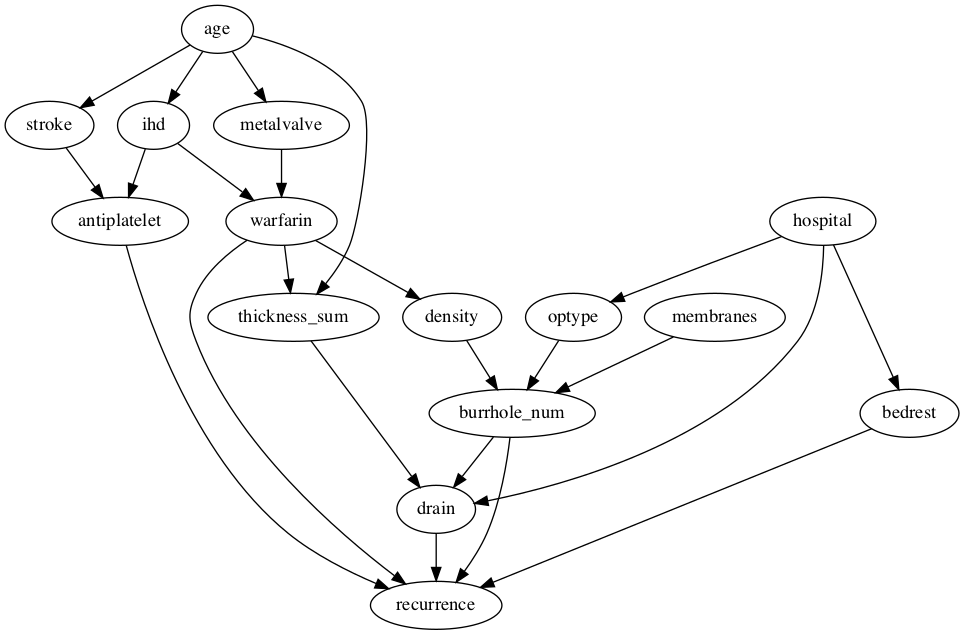

In [6]:
doc_model = CausalModel(data=csdh, 
                         treatment='drain', 
                         outcome='recurrence', 
                         graph='../causal_graphs/doctor_dag.dot'.replace("\n", " "))
doc_model.view_model()
display(Image(filename="causal_model.png"))

---
## Define set of classifiers to investigate

In [7]:
names = ['Dummy', 'LR', 'Linear SVM', 'RBF SVM', 'GB', 'RF', 'XGB']

In [8]:
# Naive Bayes exluded due to mixture of variable types
classifiers = [
    DummyClassifier(strategy='most_frequent'),
    LogisticRegression(max_iter=1000),
    SVC(kernel="linear", probability=True, random_state=random_state),
    SVC(kernel='rbf', probability=True, random_state=random_state),
    GradientBoostingClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state),
    XGBClassifier(random_state=random_state),
]

In [9]:
# define cross-validation structure
cv_5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
cv_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

In [10]:
# define classifiers and hyperparameters to search over
rf = RandomForestClassifier()
params_rf = {
    # randomly sample numbers from 10 to 200 estimators
    'rf__n_estimators':randint(10, 200),
    
    ### DONT TUNE THESE DUE TO DATASET SIZE ###
    # minimum number of samples required to split an internal node
    #'rf__min_samples_split':randint(1, 12),
    # minimum number of samples required to split a leaf
    #'rf__min_samples_leaf':randint(1, 50),
    # The maximum depth of the individual regression estimators.
    
    'rf__max_depth':randint(2, 15),
    # The number of features to consider when looking for the best split
    'rf__max_features':['sqrt', 'log2', None],
    # random seed
    'rf__random_state':[random_state],
    # Whether bootstrap samples are used when building trees
    'rf__bootstrap':[True, False]
}

gb = GradientBoostingClassifier()
params_gb = {
    # randomly sample numbers from 10 to 200 estimators
    'gb__n_estimators':randint(10, 200),
    # fraction of samples to be used for fitting individual base learners
    'gb__subsample':[0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1],
    # learning rate
    'gb__learning_rate':[0.001, 0.003, 0.01, 0.03, 0.07, 0.1, 0.3, 0.7, 1.0],
        
    ### DONT TUNE THESE DUE TO DATASET SIZE ###
    # minimum number of samples required to split an internal node
    #'gb__min_samples_split':randint(1, 12),
    # minimum number of samples required to split a leaf
    #'gb__min_samples_leaf':randint(1, 50),
    # The maximum depth of the individual regression estimators
    
    'gb__max_depth':randint(2, 15),
    # The number of features to consider when looking for the best split
    'gb__max_features':['sqrt', 'log2', None],
    # random seed
    'gb__random_state':[random_state]
}

xgb = XGBClassifier()
params_xgb = {
    # randomly sample numbers from 10 to 200 estimators
    'xgb__n_estimators':randint(10, 200),
    # fraction of samples to be used for fitting individual base learners
    'xgb__subsample':[0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1],
    # learning rate
    'xgb__learning_rate':[0.001, 0.003, 0.01, 0.03, 0.07, 0.1, 0.3, 0.7, 1],
    # min_split_loss
    'xgb__gamma':[0.001, 0.003, 0.01, 0.03, 0.07, 0.1, 0.3],
 
    ### DONT TUNE THESE DUE TO DATASET SIZE ###
    # minimum number of samples required to split an internal node
    #'gb__min_samples_split':randint(1, 12),
    # minimum number of samples required to split a leaf
    #'gb__min_samples_leaf':randint(1, 50),
    # The maximum depth of the individual regression estimators
    
    'xgb__max_depth':randint(2, 15),
    # analagous to max_features in rf and gb
    'xgb__colsample_bytree':[0.6, 0.7, 0.8, 0.9, 1],
    # random seed
    'xgb__random_state':[random_state],
}

In [11]:
# define search spaces for random search tuning
search_space = [('rf', rf, params_rf), ('gb', gb, params_gb), ('xgb', xgb, params_xgb)]

---
## Predicting $T$ (drain) from controls $X, W$

In [12]:
y_drain_full = csdh_doc['drain']
X_drain_full = csdh_doc.drop(['drain', 'recurrence'], axis=1)

In [13]:
# Split into validation set and rest
X_drain_rest, X_drain_test, y_drain_rest, y_drain_test = train_test_split(X_drain_full, y_drain_full, 
                                                                        test_size=0.20,
                                                                        random_state=random_state,
                                                                        stratify=y_drain_full)

# Split rest into train and test set
X_drain_train, X_drain_val, y_drain_train, y_drain_val = train_test_split(X_drain_rest, y_drain_rest, 
                                                                            test_size=0.20,
                                                                            random_state=random_state,
                                                                            stratify=y_drain_rest)

In [14]:
drain_training_scores, drain_val_scores = mmh.train_and_validate_classifiers(X_drain_train, 
                                                                             y_drain_train,
                                                                             X_drain_val,
                                                                             y_drain_val,
                                                                             names,
                                                                             classifiers)

[13:50:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [15]:
mmh.print_metrics_table(drain_training_scores, drain_val_scores, names)

Classification performance on validation set: 

             ----------------Validation-----------------   -----------------Training------------------
Method         Acc↑   AUROC↑  Recall↑      F1↑      LL↓     Acc↑   AUROC↑  Recall↑      F1↑      LL↓
----------------------------------------------------------------------------------------------------
Dummy         0.842    0.500    1.000    0.914   5.454    0.839    0.500    1.000    0.913    5.545
LR            0.874    0.600    1.000    0.930   4.363    0.845    0.530    0.994    0.915    5.363
Linear SVM    0.842    0.500    1.000    0.914   5.454    0.839    0.500    1.000    0.913    5.545
RBF SVM       0.842    0.500    1.000    0.914   5.454    0.839    0.500    1.000    0.913    5.545
GB            0.874    0.681    0.963    0.928   4.363    0.971    0.910    1.000    0.983    1.000
RF            0.853    0.587    0.975    0.918   5.090    1.000    1.000    1.000    1.000    0.000
XGB           0.821    0.623    0.912    0.896 

## `model_t` K-Fold cross validation for hyperparameter tuning and model selection

In [16]:
# do the search
_,_, best_estimator_drain = mmh.randomized_search_cv(X_drain_rest, y_drain_rest, 
                                                     search_space, 
                                                     cv=cv_5,
                                                     refit=True,
                                                     score='roc_auc',
                                                     n_iter=5000, 
                                                     verbose=True)

cv strategy StratifiedKFold(n_splits=5, random_state=100, shuffle=True)
----------------------------------------
Trial 0
----------------------------------------
Parameters {'gb__n_estimators': 109, 'gb__subsample': 0.75, 'gb__learning_rate': 0.1, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=10, max_features='log2',
                                            n_estimators=109, random_state=100,
                                            subsample=0.75))])
cv score: [0.61333333 0.61583333 0.6625     0.73916667 0.76107595]
----------------------------------------
Trial 1
----------------------------------------
Parameters {'rf__n_estimators': 137, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='log2',
                        

cv score: [0.52333333 0.72458333 0.73708333 0.82083333 0.77294304]
----------------------------------------
Trial 11
----------------------------------------
Parameters {'gb__n_estimators': 11, 'gb__subsample': 0.75, 'gb__learning_rate': 0.07, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=14,
                                            n_estimators=11, random_state=100,
                                            subsample=0.75))])
cv score: [0.635      0.70458333 0.76291667 0.785      0.78322785]
----------------------------------------
Trial 12
----------------------------------------
Parameters {'rf__n_estimators': 147, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                    

cv score: [0.67791667 0.73916667 0.79166667 0.83541667 0.87262658]
----------------------------------------
Trial 25
----------------------------------------
Parameters {'xgb__n_estimators': 199, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=199,
                               n_jobs=None, num_parallel_tr

cv score: [0.595      0.66833333 0.7075     0.755      0.78560127]
----------------------------------------
Trial 33
----------------------------------------
Parameters {'gb__n_estimators': 104, 'gb__subsample': 0.75, 'gb__learning_rate': 0.07, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=6,
                                            max_features='log2',
                                            n_estimators=104, random_state=100,
                                            subsample=0.75))])
cv score: [0.605      0.62333333 0.68833333 0.7825     0.74367089]
----------------------------------------
Trial 34
----------------------------------------
Parameters {'xgb__n_estimators': 64, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.07, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(s

cv score: [0.75333333 0.72833333 0.79666667 0.82833333 0.87262658]
----------------------------------------
Trial 43
----------------------------------------
Parameters {'rf__n_estimators': 137, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='sqrt',
                                        n_estimators=137, random_state=100))])
cv score: [0.57166667 0.72       0.69416667 0.8025     0.80221519]
----------------------------------------
Trial 44
----------------------------------------
Parameters {'rf__n_estimators': 76, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features=None, n_estimators=76,
                                        random_state=10

cv score: [0.70208333 0.61083333 0.73083333 0.81875    0.82911392]
----------------------------------------
Trial 53
----------------------------------------
Parameters {'gb__n_estimators': 126, 'gb__subsample': 0.85, 'gb__learning_rate': 0.001, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001,
                                            n_estimators=126, random_state=100,
                                            subsample=0.85))])
cv score: [0.78083333 0.68208333 0.72791667 0.8575     0.85522152]
----------------------------------------
Trial 54
----------------------------------------
Parameters {'xgb__n_estimators': 135, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,

cv score: [0.78       0.71791667 0.76833333 0.83333333 0.90268987]
----------------------------------------
Trial 63
----------------------------------------
Parameters {'rf__n_estimators': 182, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='sqrt', n_estimators=182,
                                        random_state=100))])
cv score: [0.62583333 0.67       0.7        0.8175     0.82832278]
----------------------------------------
Trial 64
----------------------------------------
Parameters {'rf__n_estimators': 110, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='sqrt',
                                        n_estimators=110, random_st

cv score: [0.76083333 0.70166667 0.80666667 0.82833333 0.88844937]
----------------------------------------
Trial 73
----------------------------------------
Parameters {'rf__n_estimators': 59, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features=None, n_estimators=59,
                                        random_state=100))])
cv score: [0.6675     0.50541667 0.795      0.66375    0.78876582]
----------------------------------------
Trial 74
----------------------------------------
Parameters {'xgb__n_estimators': 194, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               

cv score: [0.6175     0.62333333 0.76666667 0.82416667 0.85996835]
----------------------------------------
Trial 86
----------------------------------------
Parameters {'gb__n_estimators': 175, 'gb__subsample': 0.8, 'gb__learning_rate': 0.001, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001,
                                            n_estimators=175, random_state=100,
                                            subsample=0.8))])
cv score: [0.77416667 0.68416667 0.72166667 0.855      0.85443038]
----------------------------------------
Trial 87
----------------------------------------
Parameters {'gb__n_estimators': 97, 'gb__subsample': 0.65, 'gb__learning_rate': 0.3, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=2,
                     

cv score: [0.6025     0.54166667 0.65583333 0.6725     0.77848101]
----------------------------------------
Trial 99
----------------------------------------
Parameters {'rf__n_estimators': 125, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='log2',
                                        n_estimators=125, random_state=100))])
cv score: [0.6875     0.635      0.73916667 0.81541667 0.84098101]
----------------------------------------
Trial 100
----------------------------------------
Parameters {'rf__n_estimators': 158, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='sqrt', n_estimators=158,
                                        rand

cv score: [0.7325     0.74625    0.77       0.84416667 0.8710443 ]
----------------------------------------
Trial 111
----------------------------------------
Parameters {'rf__n_estimators': 95, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features=None,
                                        n_estimators=95, random_state=100))])
cv score: [0.72166667 0.67291667 0.77958333 0.83416667 0.83781646]
----------------------------------------
Trial 112
----------------------------------------
Parameters {'rf__n_estimators': 156, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features=None, n_estimators=156,
                                        random_state=10

cv score: [0.60916667 0.6625     0.69125    0.78916667 0.84889241]
----------------------------------------
Trial 124
----------------------------------------
Parameters {'gb__n_estimators': 189, 'gb__subsample': 0.9, 'gb__learning_rate': 0.03, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=7,
                                            max_features='sqrt',
                                            n_estimators=189, random_state=100,
                                            subsample=0.9))])
cv score: [0.65083333 0.59916667 0.64083333 0.78833333 0.80696203]
----------------------------------------
Trial 125
----------------------------------------
Parameters {'xgb__n_estimators': 58, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(s

cv score: [0.61083333 0.62625    0.77583333 0.71166667 0.82832278]
----------------------------------------
Trial 133
----------------------------------------
Parameters {'rf__n_estimators': 25, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features=None, n_estimators=25,
                                        random_state=100))])
cv score: [0.685      0.49375    0.81125    0.64041667 0.75237342]
----------------------------------------
Trial 134
----------------------------------------
Parameters {'gb__n_estimators': 45, 'gb__subsample': 0.6, 'gb__learning_rate': 0.07, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=12,
                                         

cv score: [0.56       0.63083333 0.73916667 0.62916667 0.70490506]
----------------------------------------
Trial 144
----------------------------------------
Parameters {'rf__n_estimators': 84, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='sqrt',
                                        n_estimators=84, random_state=100))])
cv score: [0.67166667 0.63583333 0.72375    0.8225     0.80617089]
----------------------------------------
Trial 145
----------------------------------------
Parameters {'rf__n_estimators': 186, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features=None, n_estimators=186,
                                        random_stat

cv score: [0.75666667 0.62916667 0.78416667 0.81083333 0.84256329]
----------------------------------------
Trial 156
----------------------------------------
Parameters {'rf__n_estimators': 172, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features=None,
                                        n_estimators=172, random_state=100))])
cv score: [0.7225     0.67666667 0.77708333 0.835      0.82832278]
----------------------------------------
Trial 157
----------------------------------------
Parameters {'rf__n_estimators': 134, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='sqrt', n_estimators=134,
                                        random_

cv score: [0.70916667 0.69666667 0.76583333 0.79833333 0.88212025]
----------------------------------------
Trial 165
----------------------------------------
Parameters {'rf__n_estimators': 188, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='sqrt', n_estimators=188,
                                        random_state=100))])
cv score: [0.63666667 0.57       0.73166667 0.78916667 0.80221519]
----------------------------------------
Trial 166
----------------------------------------
Parameters {'gb__n_estimators': 90, 'gb__subsample': 0.75, 'gb__learning_rate': 0.1, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=8, n_estimators=90,
                                        

cv score: [0.70083333 0.62333333 0.7325     0.805      0.84018987]
----------------------------------------
Trial 177
----------------------------------------
Parameters {'xgb__n_estimators': 125, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.3, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=6, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=125,
                               n_jobs=None, num_parallel_t

cv score: [0.715      0.70333333 0.79333333 0.8025     0.86471519]
----------------------------------------
Trial 188
----------------------------------------
Parameters {'xgb__n_estimators': 52, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.001, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=52,
                               n_jobs=None, num_parallel_tree

cv score: [0.7025     0.56833333 0.64583333 0.78833333 0.80221519]
----------------------------------------
Trial 197
----------------------------------------
Parameters {'rf__n_estimators': 69, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='sqrt', n_estimators=69,
                                        random_state=100))])
cv score: [0.55708333 0.67791667 0.70958333 0.82541667 0.80023734]
----------------------------------------
Trial 198
----------------------------------------
Parameters {'gb__n_estimators': 36, 'gb__subsample': 0.9, 'gb__learning_rate': 0.1, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=4, max_features='sqrt',
                                       

cv score: [0.77666667 0.735      0.78416667 0.84166667 0.87262658]
----------------------------------------
Trial 209
----------------------------------------
Parameters {'rf__n_estimators': 43, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features=None, n_estimators=43,
                                        random_state=100))])
cv score: [0.69       0.48916667 0.77916667 0.67166667 0.63765823]
----------------------------------------
Trial 210
----------------------------------------
Parameters {'gb__n_estimators': 177, 'gb__subsample': 1.0, 'gb__learning_rate': 0.003, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=5,
                                      

cv score: [0.72833333 0.70916667 0.79333333 0.825      0.88132911]
----------------------------------------
Trial 220
----------------------------------------
Parameters {'rf__n_estimators': 169, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='sqrt',
                                        n_estimators=169, random_state=100))])
cv score: [0.68333333 0.63333333 0.7425     0.8225     0.81803797]
----------------------------------------
Trial 221
----------------------------------------
Parameters {'xgb__n_estimators': 105, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
 

cv score: [0.675      0.59333333 0.67916667 0.81333333 0.83860759]
----------------------------------------
Trial 231
----------------------------------------
Parameters {'gb__n_estimators': 106, 'gb__subsample': 1.0, 'gb__learning_rate': 0.7, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=8,
                                            max_features='log2',
                                            n_estimators=106,
                                            random_state=100))])
cv score: [0.61416667 0.54       0.70916667 0.705      0.72705696]
----------------------------------------
Trial 232
----------------------------------------
Parameters {'xgb__n_estimators': 169, 'xgb__subsample': 0.8, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
    

cv score: [0.65833333 0.67833333 0.77833333 0.7625     0.8306962 ]
----------------------------------------
Trial 241
----------------------------------------
Parameters {'gb__n_estimators': 60, 'gb__subsample': 0.7, 'gb__learning_rate': 0.07, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=13,
                                            max_features='sqrt',
                                            n_estimators=60, random_state=100,
                                            subsample=0.7))])
cv score: [0.6875     0.58333333 0.6775     0.76833333 0.79825949]
----------------------------------------
Trial 242
----------------------------------------
Parameters {'rf__n_estimators': 62, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(m

cv score: [0.73833333 0.71333333 0.73375    0.86083333 0.8346519 ]
----------------------------------------
Trial 252
----------------------------------------
Parameters {'xgb__n_estimators': 94, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=94,
                               n_jobs=None, num_parallel_tree=No

cv score: [0.67166667 0.57666667 0.69416667 0.77833333 0.76265823]
----------------------------------------
Trial 265
----------------------------------------
Parameters {'gb__n_estimators': 176, 'gb__subsample': 0.6, 'gb__learning_rate': 0.03, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=12,
                                            max_features='log2',
                                            n_estimators=176, random_state=100,
                                            subsample=0.6))])
cv score: [0.68083333 0.63833333 0.685      0.76416667 0.79905063]
----------------------------------------
Trial 266
----------------------------------------
Parameters {'xgb__n_estimators': 108, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline

cv score: [0.59666667 0.72583333 0.7225     0.86166667 0.77056962]
----------------------------------------
Trial 277
----------------------------------------
Parameters {'gb__n_estimators': 181, 'gb__subsample': 0.85, 'gb__learning_rate': 0.01, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=10,
                                            max_features='log2',
                                            n_estimators=181, random_state=100,
                                            subsample=0.85))])
cv score: [0.69166667 0.6075     0.67166667 0.79583333 0.8164557 ]
----------------------------------------
Trial 278
----------------------------------------
Parameters {'rf__n_estimators': 40, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifie

cv score: [0.70583333 0.6225     0.7325     0.80666667 0.79667722]
----------------------------------------
Trial 289
----------------------------------------
Parameters {'xgb__n_estimators': 123, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.3, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=123,
                               n_jobs=None, num_parallel_tre

cv score: [0.7175     0.62416667 0.815      0.81333333 0.8085443 ]
----------------------------------------
Trial 298
----------------------------------------
Parameters {'rf__n_estimators': 133, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='log2',
                                        n_estimators=133, random_state=100))])
cv score: [0.6875     0.63833333 0.74083333 0.81291667 0.82990506]
----------------------------------------
Trial 299
----------------------------------------
Parameters {'gb__n_estimators': 168, 'gb__subsample': 0.7, 'gb__learning_rate': 0.03, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=6,
                                            max_features='sqrt',
                           

cv score: [0.70833333 0.6025     0.6725     0.80833333 0.83702532]
----------------------------------------
Trial 312
----------------------------------------
Parameters {'gb__n_estimators': 20, 'gb__subsample': 0.7, 'gb__learning_rate': 0.1, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=10, max_features='sqrt',
                                            n_estimators=20, random_state=100,
                                            subsample=0.7))])
cv score: [0.66666667 0.665      0.74333333 0.8125     0.8164557 ]
----------------------------------------
Trial 313
----------------------------------------
Parameters {'gb__n_estimators': 185, 'gb__subsample': 0.85, 'gb__learning_rate': 0.07, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=5,
 

cv score: [0.75666667 0.72083333 0.7725     0.82166667 0.87025316]
----------------------------------------
Trial 322
----------------------------------------
Parameters {'xgb__n_estimators': 60, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=60,
                               n_jobs=None, num_parallel_tree=N

cv score: [0.62       0.69       0.70333333 0.80083333 0.83227848]
----------------------------------------
Trial 331
----------------------------------------
Parameters {'gb__n_estimators': 51, 'gb__subsample': 0.6, 'gb__learning_rate': 0.3, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=12,
                                            n_estimators=51, random_state=100,
                                            subsample=0.6))])
cv score: [0.68333333 0.6525     0.74833333 0.83833333 0.76344937]
----------------------------------------
Trial 332
----------------------------------------
Parameters {'rf__n_estimators': 10, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features=None,
                                      

cv score: [0.79166667 0.7425     0.7975     0.84833333 0.86946203]
----------------------------------------
Trial 342
----------------------------------------
Parameters {'xgb__n_estimators': 45, 'xgb__subsample': 0.95, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=45,
                               n_jobs=None, num_parallel_tree=

cv score: [0.68666667 0.55333333 0.6875     0.775      0.83781646]
----------------------------------------
Trial 353
----------------------------------------
Parameters {'xgb__n_estimators': 35, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=35,
                               n_jobs=None, num_parallel_tree=N

cv score: [0.5725     0.7        0.7        0.81333333 0.8125    ]
----------------------------------------
Trial 364
----------------------------------------
Parameters {'gb__n_estimators': 154, 'gb__subsample': 0.7, 'gb__learning_rate': 0.3, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=10,
                                            n_estimators=154, random_state=100,
                                            subsample=0.7))])
cv score: [0.64333333 0.6575     0.7175     0.80833333 0.76028481]
----------------------------------------
Trial 365
----------------------------------------
Parameters {'rf__n_estimators': 143, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='sqrt',
                               

cv score: [0.55083333 0.60333333 0.67583333 0.6875     0.80221519]
----------------------------------------
Trial 374
----------------------------------------
Parameters {'xgb__n_estimators': 47, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=47,
                               n_jobs=None, num_parallel_tree

cv score: [0.605      0.64       0.70916667 0.775      0.75158228]
----------------------------------------
Trial 387
----------------------------------------
Parameters {'rf__n_estimators': 154, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features=None,
                                        n_estimators=154, random_state=100))])
cv score: [0.7225     0.675      0.77666667 0.83541667 0.8306962 ]
----------------------------------------
Trial 388
----------------------------------------
Parameters {'xgb__n_estimators': 172, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
   

cv score: [0.6475     0.6025     0.67166667 0.68166667 0.80617089]
----------------------------------------
Trial 395
----------------------------------------
Parameters {'rf__n_estimators': 168, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='sqrt', n_estimators=168,
                                        random_state=100))])
cv score: [0.65166667 0.6725     0.69833333 0.82333333 0.84414557]
----------------------------------------
Trial 396
----------------------------------------
Parameters {'xgb__n_estimators': 119, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                      

cv score: [0.56916667 0.7325     0.69416667 0.795      0.80379747]
----------------------------------------
Trial 405
----------------------------------------
Parameters {'xgb__n_estimators': 148, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.1, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=148,
                               n_jobs=None, num_parallel_tree

cv score: [0.62833333 0.72791667 0.71833333 0.83375    0.8215981 ]
----------------------------------------
Trial 417
----------------------------------------
Parameters {'gb__n_estimators': 127, 'gb__subsample': 0.85, 'gb__learning_rate': 0.1, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=9, max_features='log2',
                                            n_estimators=127, random_state=100,
                                            subsample=0.85))])
cv score: [0.65166667 0.58583333 0.69583333 0.7225     0.7460443 ]
----------------------------------------
Trial 418
----------------------------------------
Parameters {'gb__n_estimators': 52, 'gb__subsample': 0.8, 'gb__learning_rate': 0.3, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=7,
   

cv score: [0.67583333 0.62416667 0.73       0.79666667 0.84018987]
----------------------------------------
Trial 428
----------------------------------------
Parameters {'gb__n_estimators': 31, 'gb__subsample': 0.9, 'gb__learning_rate': 0.3, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=9,
                                            n_estimators=31, random_state=100,
                                            subsample=0.9))])
cv score: [0.72333333 0.68833333 0.77333333 0.8075     0.78718354]
----------------------------------------
Trial 429
----------------------------------------
Parameters {'gb__n_estimators': 51, 'gb__subsample': 0.9, 'gb__learning_rate': 0.07, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=6,
         

cv score: [0.7575     0.74       0.79333333 0.8575     0.87262658]
----------------------------------------
Trial 437
----------------------------------------
Parameters {'gb__n_estimators': 59, 'gb__subsample': 0.8, 'gb__learning_rate': 0.07, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=5,
                                            max_features='log2',
                                            n_estimators=59, random_state=100,
                                            subsample=0.8))])
cv score: [0.7025     0.62583333 0.6475     0.825      0.86946203]
----------------------------------------
Trial 438
----------------------------------------
Parameters {'rf__n_estimators': 186, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(b

cv score: [0.74583333 0.74416667 0.80333333 0.86083333 0.86629747]
----------------------------------------
Trial 447
----------------------------------------
Parameters {'xgb__n_estimators': 32, 'xgb__subsample': 0.65, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=32,
                               n_jobs=None, num_parallel_tree=No

cv score: [0.61916667 0.64083333 0.78333333 0.745      0.79588608]
----------------------------------------
Trial 456
----------------------------------------
Parameters {'xgb__n_estimators': 39, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.3, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=12, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=39,
                               n_jobs=None, num_parallel_t

cv score: [0.69       0.6025     0.72916667 0.82333333 0.79667722]
----------------------------------------
Trial 465
----------------------------------------
Parameters {'xgb__n_estimators': 17, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=17,
                               n_jobs=None, num_parallel_tree=

cv score: [0.68041667 0.75166667 0.77083333 0.82833333 0.83742089]
----------------------------------------
Trial 476
----------------------------------------
Parameters {'xgb__n_estimators': 71, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=71,
                               n_jobs=None, num_parallel_tree

cv score: [0.69583333 0.7775     0.71833333 0.85083333 0.81764241]
----------------------------------------
Trial 486
----------------------------------------
Parameters {'rf__n_estimators': 190, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='log2',
                                        n_estimators=190, random_state=100))])
cv score: [0.705      0.60833333 0.73458333 0.82208333 0.79984177]
----------------------------------------
Trial 487
----------------------------------------
Parameters {'gb__n_estimators': 118, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=13,
                                            max_features='sqrt',
                        

cv score: [0.79666667 0.72666667 0.78416667 0.84       0.82199367]
----------------------------------------
Trial 495
----------------------------------------
Parameters {'gb__n_estimators': 172, 'gb__subsample': 0.8, 'gb__learning_rate': 0.01, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=2,
                                            n_estimators=172, random_state=100,
                                            subsample=0.8))])
cv score: [0.74541667 0.71416667 0.73583333 0.87416667 0.87539557]
----------------------------------------
Trial 496
----------------------------------------
Parameters {'gb__n_estimators': 143, 'gb__subsample': 0.7, 'gb__learning_rate': 1.0, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, n_estimators=143,
   

cv score: [0.5625     0.54666667 0.615      0.7025     0.71439873]
----------------------------------------
Trial 506
----------------------------------------
Parameters {'xgb__n_estimators': 55, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.03, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=55,
                               n_jobs=None, num_parallel_tre

cv score: [0.735      0.66       0.7275     0.74333333 0.7721519 ]
----------------------------------------
Trial 515
----------------------------------------
Parameters {'rf__n_estimators': 122, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='log2', n_estimators=122,
                                        random_state=100))])
cv score: [0.51291667 0.66625    0.70541667 0.81416667 0.76107595]
----------------------------------------
Trial 516
----------------------------------------
Parameters {'xgb__n_estimators': 139, 'xgb__subsample': 0.85, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                       

cv score: [0.69       0.6075     0.735      0.76       0.80537975]
----------------------------------------
Trial 525
----------------------------------------
Parameters {'rf__n_estimators': 50, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='sqrt',
                                        n_estimators=50, random_state=100))])
cv score: [0.65583333 0.62166667 0.74333333 0.82083333 0.78401899]
----------------------------------------
Trial 526
----------------------------------------
Parameters {'xgb__n_estimators': 192, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.1, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
    

cv score: [0.7225     0.73291667 0.78       0.86666667 0.85838608]
----------------------------------------
Trial 535
----------------------------------------
Parameters {'xgb__n_estimators': 15, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=15,
                               n_jobs=None, num_parallel_tree=

cv score: [0.76416667 0.72666667 0.79083333 0.845      0.88528481]
----------------------------------------
Trial 546
----------------------------------------
Parameters {'xgb__n_estimators': 160, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.3, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=160,
                               n_jobs=None, num_parallel_tr

cv score: [0.76708333 0.75666667 0.76958333 0.85625    0.84018987]
----------------------------------------
Trial 558
----------------------------------------
Parameters {'xgb__n_estimators': 132, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=132,
                               n_jobs=None, num_parallel_tree

cv score: [0.41083333 0.60666667 0.65916667 0.56       0.74367089]
----------------------------------------
Trial 569
----------------------------------------
Parameters {'xgb__n_estimators': 116, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.03, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=116,
                               n_jobs=None, num_parallel_t

cv score: [0.63125    0.71       0.74666667 0.82666667 0.84533228]
----------------------------------------
Trial 580
----------------------------------------
Parameters {'gb__n_estimators': 58, 'gb__subsample': 0.75, 'gb__learning_rate': 1.0, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=58, random_state=100,
                                            subsample=0.75))])
cv score: [0.635      0.63708333 0.5425     0.50833333 0.63132911]
----------------------------------------
Trial 581
----------------------------------------
Parameters {'gb__n_estimators': 89, 'gb__subsample': 0.6, 'gb__learning_rate': 0.3, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 Gra

cv score: [0.56291667 0.65875    0.68833333 0.83208333 0.80023734]
----------------------------------------
Trial 591
----------------------------------------
Parameters {'xgb__n_estimators': 44, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.1, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=13, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=44,
                               n_jobs=None, num_parallel_t

cv score: [0.81375    0.58166667 0.6625     0.84416667 0.74208861]
----------------------------------------
Trial 600
----------------------------------------
Parameters {'rf__n_estimators': 158, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features=None, n_estimators=158,
                                        random_state=100))])
cv score: [0.6925     0.4875     0.71916667 0.66833333 0.63607595]
----------------------------------------
Trial 601
----------------------------------------
Parameters {'xgb__n_estimators': 109, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.1, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                         

cv score: [0.6775     0.67166667 0.7975     0.78       0.87737342]
----------------------------------------
Trial 611
----------------------------------------
Parameters {'xgb__n_estimators': 98, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.03, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=98,
                               n_jobs=None, num_parallel_tree=N

cv score: [0.62166667 0.61583333 0.735      0.7475     0.74683544]
----------------------------------------
Trial 620
----------------------------------------
Parameters {'gb__n_estimators': 24, 'gb__subsample': 0.9, 'gb__learning_rate': 0.07, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=9,
                                            n_estimators=24, random_state=100,
                                            subsample=0.9))])
cv score: [0.7275     0.65458333 0.82416667 0.79416667 0.84731013]
----------------------------------------
Trial 621
----------------------------------------
Parameters {'rf__n_estimators': 138, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='sqrt',
                                   

cv score: [0.59666667 0.595      0.67833333 0.77333333 0.77531646]
----------------------------------------
Trial 633
----------------------------------------
Parameters {'xgb__n_estimators': 75, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=75,
                               n_jobs=None, num_parallel_tree=N

cv score: [0.58666667 0.57916667 0.7        0.6725     0.70806962]
----------------------------------------
Trial 642
----------------------------------------
Parameters {'gb__n_estimators': 83, 'gb__subsample': 0.95, 'gb__learning_rate': 0.1, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=7, max_features='sqrt',
                                            n_estimators=83, random_state=100,
                                            subsample=0.95))])
cv score: [0.6475     0.60083333 0.72166667 0.75       0.77848101]
----------------------------------------
Trial 643
----------------------------------------
Parameters {'xgb__n_estimators': 119, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.07, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, 

cv score: [0.76666667 0.72916667 0.78208333 0.8525     0.92325949]
----------------------------------------
Trial 653
----------------------------------------
Parameters {'xgb__n_estimators': 158, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=2, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=158,
                               n_jobs=None, num_paralle

cv score: [0.6325     0.64333333 0.72666667 0.69916667 0.75474684]
----------------------------------------
Trial 662
----------------------------------------
Parameters {'xgb__n_estimators': 91, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=91,
                               n_jobs=None, num_parallel

cv score: [0.6925     0.48916667 0.77791667 0.67083333 0.63844937]
----------------------------------------
Trial 671
----------------------------------------
Parameters {'gb__n_estimators': 27, 'gb__subsample': 0.65, 'gb__learning_rate': 0.003, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=14,
                                            max_features='sqrt',
                                            n_estimators=27, random_state=100,
                                            subsample=0.65))])
cv score: [0.61416667 0.65083333 0.6675     0.76166667 0.79193038]
----------------------------------------
Trial 672
----------------------------------------
Parameters {'xgb__n_estimators': 152, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.07, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipel

cv score: [0.63916667 0.60666667 0.7925     0.785      0.82594937]
----------------------------------------
Trial 682
----------------------------------------
Parameters {'gb__n_estimators': 131, 'gb__subsample': 0.85, 'gb__learning_rate': 0.7, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=9,
                                            n_estimators=131, random_state=100,
                                            subsample=0.85))])
cv score: [0.65416667 0.6375     0.77416667 0.78416667 0.69936709]
----------------------------------------
Trial 683
----------------------------------------
Parameters {'xgb__n_estimators': 197, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.1, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booste

cv score: [0.74625    0.72666667 0.76625    0.845      0.86946203]
----------------------------------------
Trial 695
----------------------------------------
Parameters {'xgb__n_estimators': 37, 'xgb__subsample': 0.7, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=37,
                               n_jobs=None, num_parallel_tree=Non

cv score: [0.69833333 0.63666667 0.73083333 0.81083333 0.83544304]
----------------------------------------
Trial 704
----------------------------------------
Parameters {'gb__n_estimators': 37, 'gb__subsample': 0.75, 'gb__learning_rate': 0.3, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=13,
                                            n_estimators=37, random_state=100,
                                            subsample=0.75))])
cv score: [0.6825     0.7075     0.72583333 0.83333333 0.78322785]
----------------------------------------
Trial 705
----------------------------------------
Parameters {'rf__n_estimators': 58, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='sqrt',
                                  

cv score: [0.63666667 0.65416667 0.73166667 0.78166667 0.79509494]
----------------------------------------
Trial 716
----------------------------------------
Parameters {'gb__n_estimators': 113, 'gb__subsample': 1.0, 'gb__learning_rate': 0.003, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=5,
                                            max_features='sqrt',
                                            n_estimators=113,
                                            random_state=100))])
cv score: [0.68166667 0.65333333 0.72583333 0.80083333 0.84493671]
----------------------------------------
Trial 717
----------------------------------------
Parameters {'xgb__n_estimators': 94, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.1, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',


cv score: [0.69333333 0.73541667 0.74875    0.86       0.84810127]
----------------------------------------
Trial 727
----------------------------------------
Parameters {'gb__n_estimators': 164, 'gb__subsample': 0.95, 'gb__learning_rate': 0.003, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=13,
                                            max_features='log2',
                                            n_estimators=164, random_state=100,
                                            subsample=0.95))])
cv score: [0.70166667 0.56416667 0.73083333 0.8        0.80221519]
----------------------------------------
Trial 728
----------------------------------------
Parameters {'rf__n_estimators': 115, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClas

cv score: [0.68666667 0.67666667 0.7925     0.79083333 0.8528481 ]
----------------------------------------
Trial 737
----------------------------------------
Parameters {'gb__n_estimators': 80, 'gb__subsample': 1.0, 'gb__learning_rate': 1.0, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=2,
                                            max_features='log2',
                                            n_estimators=80,
                                            random_state=100))])
cv score: [0.56       0.59333333 0.69       0.7175     0.54667722]
----------------------------------------
Trial 738
----------------------------------------
Parameters {'gb__n_estimators': 71, 'gb__subsample': 1.0, 'gb__learning_rate': 0.003, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingCl

cv score: [0.72583333 0.67166667 0.7775     0.80416667 0.86708861]
----------------------------------------
Trial 751
----------------------------------------
Parameters {'rf__n_estimators': 64, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='log2', n_estimators=64,
                                        random_state=100))])
cv score: [0.61625    0.59083333 0.73291667 0.74458333 0.81012658]
----------------------------------------
Trial 752
----------------------------------------
Parameters {'xgb__n_estimators': 43, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                        

cv score: [0.73333333 0.73625    0.7725     0.8425     0.87737342]
----------------------------------------
Trial 761
----------------------------------------
Parameters {'xgb__n_estimators': 94, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.3, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=94,
                               n_jobs=None, num_parallel_tree=N

cv score: [0.6375     0.6075     0.71166667 0.79416667 0.78797468]
----------------------------------------
Trial 772
----------------------------------------
Parameters {'gb__n_estimators': 188, 'gb__subsample': 0.9, 'gb__learning_rate': 1.0, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=188, random_state=100,
                                            subsample=0.9))])
cv score: [0.56333333 0.5475     0.70333333 0.54416667 0.7056962 ]
----------------------------------------
Trial 773
----------------------------------------
Parameters {'gb__n_estimators': 96, 'gb__subsample': 0.65, 'gb__learning_rate': 0.003, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
              

cv score: [0.68666667 0.67416667 0.76833333 0.78666667 0.85601266]
----------------------------------------
Trial 784
----------------------------------------
Parameters {'rf__n_estimators': 49, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='sqrt', n_estimators=49,
                                        random_state=100))])
cv score: [0.57458333 0.66625    0.70458333 0.82208333 0.82832278]
----------------------------------------
Trial 785
----------------------------------------
Parameters {'gb__n_estimators': 166, 'gb__subsample': 0.7, 'gb__learning_rate': 0.003, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=5,
                                    

cv score: [0.71166667 0.63416667 0.69666667 0.81583333 0.81170886]
----------------------------------------
Trial 796
----------------------------------------
Parameters {'xgb__n_estimators': 122, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=122,
                               n_jobs=None, num_paralle

cv score: [0.76208333 0.71416667 0.78458333 0.82625    0.8477057 ]
----------------------------------------
Trial 806
----------------------------------------
Parameters {'xgb__n_estimators': 147, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.001, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=6, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=147,
                               n_jobs=None, num_paralle

cv score: [0.7275     0.70833333 0.71333333 0.79083333 0.80221519]
----------------------------------------
Trial 816
----------------------------------------
Parameters {'xgb__n_estimators': 34, 'xgb__subsample': 0.65, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=34,
                               n_jobs=None, num_parallel_t

cv score: [0.72083333 0.6725     0.80083333 0.84666667 0.81012658]
----------------------------------------
Trial 827
----------------------------------------
Parameters {'rf__n_estimators': 111, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='sqrt',
                                        n_estimators=111, random_state=100))])
cv score: [0.65166667 0.6775     0.75416667 0.7825     0.84414557]
----------------------------------------
Trial 828
----------------------------------------
Parameters {'gb__n_estimators': 38, 'gb__subsample': 0.6, 'gb__learning_rate': 0.3, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=13,
                                            max_features='sqrt',
                              

cv score: [0.66583333 0.655      0.7525     0.74333333 0.77531646]
----------------------------------------
Trial 836
----------------------------------------
Parameters {'xgb__n_estimators': 77, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=7, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=77,
                               n_jobs=None, num_parallel_tr

cv score: [0.7475     0.70166667 0.76833333 0.815      0.86313291]
----------------------------------------
Trial 848
----------------------------------------
Parameters {'rf__n_estimators': 20, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features=None, n_estimators=20,
                                        random_state=100))])
cv score: [0.75333333 0.60833333 0.78166667 0.83833333 0.82199367]
----------------------------------------
Trial 849
----------------------------------------
Parameters {'xgb__n_estimators': 69, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                              

cv score: [0.61166667 0.6525     0.74333333 0.76833333 0.74683544]
----------------------------------------
Trial 857
----------------------------------------
Parameters {'rf__n_estimators': 111, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='log2', n_estimators=111,
                                        random_state=100))])
cv score: [0.68666667 0.59333333 0.70416667 0.78166667 0.80063291]
----------------------------------------
Trial 858
----------------------------------------
Parameters {'xgb__n_estimators': 154, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.001, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                  

cv score: [0.6575     0.66166667 0.71       0.8175     0.83702532]
----------------------------------------
Trial 867
----------------------------------------
Parameters {'xgb__n_estimators': 61, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.001, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=61,
                               n_jobs=None, num_parallel_tree

cv score: [0.695      0.63416667 0.74333333 0.79083333 0.82436709]
----------------------------------------
Trial 880
----------------------------------------
Parameters {'rf__n_estimators': 113, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features=None, n_estimators=113,
                                        random_state=100))])
cv score: [0.69333333 0.48916667 0.77916667 0.67083333 0.63844937]
----------------------------------------
Trial 881
----------------------------------------
Parameters {'gb__n_estimators': 29, 'gb__subsample': 0.8, 'gb__learning_rate': 0.07, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07,
                                            max_feat

cv score: [0.73583333 0.72833333 0.76833333 0.85833333 0.88053797]
----------------------------------------
Trial 891
----------------------------------------
Parameters {'gb__n_estimators': 76, 'gb__subsample': 0.85, 'gb__learning_rate': 0.03, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=9,
                                            n_estimators=76, random_state=100,
                                            subsample=0.85))])
cv score: [0.75166667 0.62       0.80166667 0.81       0.82753165]
----------------------------------------
Trial 892
----------------------------------------
Parameters {'xgb__n_estimators': 137, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, bo

cv score: [0.61125    0.66125    0.68083333 0.81041667 0.78481013]
----------------------------------------
Trial 898
----------------------------------------
Parameters {'xgb__n_estimators': 73, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=73,
                               n_jobs=None, num_parallel_tree=N

cv score: [0.53416667 0.5375     0.72       0.68833333 0.78085443]
----------------------------------------
Trial 908
----------------------------------------
Parameters {'gb__n_estimators': 178, 'gb__subsample': 0.6, 'gb__learning_rate': 0.07, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=7,
                                            max_features='log2',
                                            n_estimators=178, random_state=100,
                                            subsample=0.6))])
cv score: [0.59333333 0.63666667 0.61583333 0.71       0.7096519 ]
----------------------------------------
Trial 909
----------------------------------------
Parameters {'gb__n_estimators': 115, 'gb__subsample': 1.0, 'gb__learning_rate': 0.7, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
              

cv score: [0.6825     0.665      0.73416667 0.77666667 0.83306962]
----------------------------------------
Trial 918
----------------------------------------
Parameters {'rf__n_estimators': 162, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='log2',
                                        n_estimators=162, random_state=100))])
cv score: [0.69625    0.61583333 0.74333333 0.82208333 0.79707278]
----------------------------------------
Trial 919
----------------------------------------
Parameters {'xgb__n_estimators': 188, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.03, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,

cv score: [0.66166667 0.5875     0.705      0.80958333 0.81724684]
----------------------------------------
Trial 929
----------------------------------------
Parameters {'rf__n_estimators': 189, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='sqrt', n_estimators=189,
                                        random_state=100))])
cv score: [0.585      0.67416667 0.70333333 0.82666667 0.83544304]
----------------------------------------
Trial 930
----------------------------------------
Parameters {'xgb__n_estimators': 94, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                       

cv score: [0.75916667 0.6125     0.82       0.84333333 0.81012658]
----------------------------------------
Trial 940
----------------------------------------
Parameters {'xgb__n_estimators': 122, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.003, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=122,
                               n_jobs=None, num_parall

cv score: [0.70166667 0.66333333 0.78166667 0.79833333 0.86075949]
----------------------------------------
Trial 951
----------------------------------------
Parameters {'gb__n_estimators': 150, 'gb__subsample': 0.75, 'gb__learning_rate': 1.0, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=5,
                                            max_features='sqrt',
                                            n_estimators=150, random_state=100,
                                            subsample=0.75))])
cv score: [0.43666667 0.69       0.57666667 0.48666667 0.6914557 ]
----------------------------------------
Trial 952
----------------------------------------
Parameters {'rf__n_estimators': 80, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(m

cv score: [0.5975     0.59666667 0.65583333 0.73       0.75553797]
----------------------------------------
Trial 962
----------------------------------------
Parameters {'rf__n_estimators': 73, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='sqrt',
                                        n_estimators=73, random_state=100))])
cv score: [0.69583333 0.6675     0.7275     0.7925     0.86867089]
----------------------------------------
Trial 963
----------------------------------------
Parameters {'gb__n_estimators': 57, 'gb__subsample': 0.9, 'gb__learning_rate': 0.01, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=9,
                                            max_features='log2',
                                

cv score: [0.6925     0.66583333 0.79166667 0.82083333 0.89952532]
----------------------------------------
Trial 974
----------------------------------------
Parameters {'gb__n_estimators': 161, 'gb__subsample': 0.65, 'gb__learning_rate': 0.001, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=14,
                                            max_features='sqrt',
                                            n_estimators=161, random_state=100,
                                            subsample=0.65))])
cv score: [0.67083333 0.64916667 0.72916667 0.79833333 0.82832278]
----------------------------------------
Trial 975
----------------------------------------
Parameters {'gb__n_estimators': 184, 'gb__subsample': 0.95, 'gb__learning_rate': 1.0, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
       

cv score: [0.7475     0.72666667 0.7725     0.86583333 0.86629747]
----------------------------------------
Trial 983
----------------------------------------
Parameters {'xgb__n_estimators': 106, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=106,
                               n_jobs=None, num_parallel_tr

cv score: [0.64625    0.59208333 0.71791667 0.77916667 0.77531646]
----------------------------------------
Trial 992
----------------------------------------
Parameters {'rf__n_estimators': 193, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features=None, n_estimators=193,
                                        random_state=100))])
cv score: [0.69416667 0.51791667 0.7975     0.67041667 0.62816456]
----------------------------------------
Trial 993
----------------------------------------
Parameters {'rf__n_estimators': 89, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='log2', n_estimato

cv score: [0.70416667 0.68125    0.74458333 0.785      0.85996835]
----------------------------------------
Trial 1003
----------------------------------------
Parameters {'xgb__n_estimators': 194, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=194,
                               n_jobs=None, num_parallel_tr

cv score: [0.55416667 0.6225     0.72083333 0.72166667 0.77848101]
----------------------------------------
Trial 1012
----------------------------------------
Parameters {'gb__n_estimators': 70, 'gb__subsample': 0.65, 'gb__learning_rate': 0.7, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=70, random_state=100,
                                            subsample=0.65))])
cv score: [0.61666667 0.56583333 0.7275     0.71416667 0.58306962]
----------------------------------------
Trial 1013
----------------------------------------
Parameters {'xgb__n_estimators': 107, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.003, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline

cv score: [0.6425     0.67833333 0.765      0.715      0.78955696]
----------------------------------------
Trial 1022
----------------------------------------
Parameters {'gb__n_estimators': 111, 'gb__subsample': 1.0, 'gb__learning_rate': 1.0, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=11,
                                            max_features='sqrt',
                                            n_estimators=111,
                                            random_state=100))])
cv score: [0.53583333 0.57666667 0.70833333 0.69       0.73259494]
----------------------------------------
Trial 1023
----------------------------------------
Parameters {'xgb__n_estimators': 180, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb'

cv score: [0.74291667 0.67958333 0.775      0.82958333 0.85126582]
----------------------------------------
Trial 1032
----------------------------------------
Parameters {'gb__n_estimators': 24, 'gb__subsample': 0.95, 'gb__learning_rate': 0.001, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=2,
                                            n_estimators=24, random_state=100,
                                            subsample=0.95))])
cv score: [0.60666667 0.56625    0.61       0.73125    0.72705696]
----------------------------------------
Trial 1033
----------------------------------------
Parameters {'xgb__n_estimators': 102, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, bo

cv score: [0.565      0.62458333 0.65125    0.80416667 0.73378165]
----------------------------------------
Trial 1042
----------------------------------------
Parameters {'rf__n_estimators': 76, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='log2',
                                        n_estimators=76, random_state=100))])
cv score: [0.6975     0.66916667 0.725      0.79416667 0.86471519]
----------------------------------------
Trial 1043
----------------------------------------
Parameters {'xgb__n_estimators': 28, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.003, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
 

cv score: [0.68666667 0.49375    0.81       0.64708333 0.75316456]
----------------------------------------
Trial 1052
----------------------------------------
Parameters {'gb__n_estimators': 82, 'gb__subsample': 0.8, 'gb__learning_rate': 0.001, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=5,
                                            max_features='sqrt',
                                            n_estimators=82, random_state=100,
                                            subsample=0.8))])
cv score: [0.66666667 0.71541667 0.69       0.83666667 0.8306962 ]
----------------------------------------
Trial 1053
----------------------------------------
Parameters {'rf__n_estimators': 135, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier

cv score: [0.66166667 0.585      0.67583333 0.79583333 0.81329114]
----------------------------------------
Trial 1061
----------------------------------------
Parameters {'rf__n_estimators': 160, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features=None,
                                        n_estimators=160, random_state=100))])
cv score: [0.78333333 0.68083333 0.76666667 0.85083333 0.87420886]
----------------------------------------
Trial 1062
----------------------------------------
Parameters {'rf__n_estimators': 108, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='sqrt', n_estimators=108,
                                        random_st

cv score: [0.68416667 0.72       0.7575     0.72333333 0.7539557 ]
----------------------------------------
Trial 1071
----------------------------------------
Parameters {'gb__n_estimators': 16, 'gb__subsample': 0.6, 'gb__learning_rate': 0.1, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=9, n_estimators=16,
                                            random_state=100, subsample=0.6))])
cv score: [0.7725     0.70666667 0.7925     0.765      0.79509494]
----------------------------------------
Trial 1072
----------------------------------------
Parameters {'gb__n_estimators': 14, 'gb__subsample': 0.65, 'gb__learning_rate': 0.003, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=12,
                                            max_features='sqrt',


cv score: [0.755      0.6975     0.74041667 0.84708333 0.89398734]
----------------------------------------
Trial 1083
----------------------------------------
Parameters {'xgb__n_estimators': 173, 'xgb__subsample': 0.95, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=173,
                               n_jobs=None, num_parallel_tree

cv score: [0.78666667 0.73333333 0.78541667 0.8475     0.86234177]
----------------------------------------
Trial 1094
----------------------------------------
Parameters {'gb__n_estimators': 157, 'gb__subsample': 1.0, 'gb__learning_rate': 1.0, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=5,
                                            max_features='log2',
                                            n_estimators=157,
                                            random_state=100))])
cv score: [0.62333333 0.625      0.68583333 0.72583333 0.68591772]
----------------------------------------
Trial 1095
----------------------------------------
Parameters {'rf__n_estimators': 174, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, 

cv score: [0.63666667 0.6325     0.7275     0.76833333 0.77294304]
----------------------------------------
Trial 1107
----------------------------------------
Parameters {'xgb__n_estimators': 24, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.3, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=24,
                               n_jobs=None, num_parallel_tre

cv score: [0.70166667 0.68583333 0.77083333 0.7575     0.80617089]
----------------------------------------
Trial 1119
----------------------------------------
Parameters {'xgb__n_estimators': 38, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=12, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=38,
                               n_jobs=None, num_paral

cv score: [0.685      0.68833333 0.78083333 0.8075     0.84731013]
----------------------------------------
Trial 1129
----------------------------------------
Parameters {'xgb__n_estimators': 40, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=6, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=40,
                               n_jobs=None, num_parallel_t

cv score: [0.695      0.67       0.775      0.77166667 0.87420886]
----------------------------------------
Trial 1139
----------------------------------------
Parameters {'gb__n_estimators': 65, 'gb__subsample': 0.8, 'gb__learning_rate': 1.0, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=10,
                                            max_features='log2',
                                            n_estimators=65, random_state=100,
                                            subsample=0.8))])
cv score: [0.55916667 0.5775     0.72833333 0.655      0.67800633]
----------------------------------------
Trial 1140
----------------------------------------
Parameters {'gb__n_estimators': 125, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
            

cv score: [0.61916667 0.67166667 0.69833333 0.81916667 0.82911392]
----------------------------------------
Trial 1152
----------------------------------------
Parameters {'rf__n_estimators': 68, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features=None, n_estimators=68,
                                        random_state=100))])
cv score: [0.66541667 0.50541667 0.79666667 0.66333333 0.78876582]
----------------------------------------
Trial 1153
----------------------------------------
Parameters {'xgb__n_estimators': 146, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                            

cv score: [0.75083333 0.70833333 0.77166667 0.8075     0.84651899]
----------------------------------------
Trial 1161
----------------------------------------
Parameters {'gb__n_estimators': 76, 'gb__subsample': 0.8, 'gb__learning_rate': 0.003, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=2,
                                            max_features='log2',
                                            n_estimators=76, random_state=100,
                                            subsample=0.8))])
cv score: [0.59166667 0.66041667 0.68875    0.78208333 0.77333861]
----------------------------------------
Trial 1162
----------------------------------------
Parameters {'xgb__n_estimators': 86, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.07, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeli

cv score: [0.66583333 0.695      0.71083333 0.77666667 0.84968354]
----------------------------------------
Trial 1171
----------------------------------------
Parameters {'xgb__n_estimators': 23, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=23,
                               n_jobs=None, num_parallel_tree=

cv score: [0.65666667 0.65416667 0.66583333 0.83333333 0.84731013]
----------------------------------------
Trial 1182
----------------------------------------
Parameters {'xgb__n_estimators': 166, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=166,
                               n_jobs=None, num_parallel_

cv score: [0.76166667 0.7175     0.80666667 0.8375     0.89240506]
----------------------------------------
Trial 1190
----------------------------------------
Parameters {'gb__n_estimators': 198, 'gb__subsample': 1.0, 'gb__learning_rate': 0.01, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=198,
                                            random_state=100))])
cv score: [0.6925     0.58916667 0.72       0.78916667 0.80300633]
----------------------------------------
Trial 1191
----------------------------------------
Parameters {'rf__n_estimators': 38, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, m

cv score: [0.67666667 0.66166667 0.74833333 0.7525     0.80458861]
----------------------------------------
Trial 1202
----------------------------------------
Parameters {'xgb__n_estimators': 11, 'xgb__subsample': 0.8, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.01, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=11,
                               n_jobs=None, num_parallel_tree=

cv score: [0.55125    0.72083333 0.66666667 0.82083333 0.77333861]
----------------------------------------
Trial 1211
----------------------------------------
Parameters {'xgb__n_estimators': 142, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=9, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=142,
                               n_jobs=None, num_parallel_

cv score: [0.70666667 0.6725     0.74083333 0.81083333 0.87183544]
----------------------------------------
Trial 1220
----------------------------------------
Parameters {'xgb__n_estimators': 92, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=92,
                               n_jobs=None, num_parallel_t

cv score: [0.69916667 0.65583333 0.7725     0.8025     0.87262658]
----------------------------------------
Trial 1230
----------------------------------------
Parameters {'gb__n_estimators': 111, 'gb__subsample': 0.65, 'gb__learning_rate': 0.03, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=7,
                                            max_features='sqrt',
                                            n_estimators=111, random_state=100,
                                            subsample=0.65))])
cv score: [0.66083333 0.58666667 0.71666667 0.81333333 0.83939873]
----------------------------------------
Trial 1231
----------------------------------------
Parameters {'gb__n_estimators': 22, 'gb__subsample': 0.9, 'gb__learning_rate': 0.1, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
           

cv score: [0.71666667 0.64833333 0.81083333 0.8425     0.80379747]
----------------------------------------
Trial 1243
----------------------------------------
Parameters {'rf__n_estimators': 41, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features=None,
                                        n_estimators=41, random_state=100))])
cv score: [0.75875    0.69125    0.73083333 0.86166667 0.87658228]
----------------------------------------
Trial 1244
----------------------------------------
Parameters {'xgb__n_estimators': 168, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.001, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
       

cv score: [0.63583333 0.59       0.65916667 0.77916667 0.73101266]
----------------------------------------
Trial 1255
----------------------------------------
Parameters {'gb__n_estimators': 73, 'gb__subsample': 0.65, 'gb__learning_rate': 0.03, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=5,
                                            max_features='log2',
                                            n_estimators=73, random_state=100,
                                            subsample=0.65))])
cv score: [0.64833333 0.66583333 0.70166667 0.81       0.86075949]
----------------------------------------
Trial 1256
----------------------------------------
Parameters {'gb__n_estimators': 94, 'gb__subsample': 0.85, 'gb__learning_rate': 0.01, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
            

cv score: [0.67833333 0.63083333 0.7475     0.81333333 0.83306962]
----------------------------------------
Trial 1267
----------------------------------------
Parameters {'xgb__n_estimators': 118, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=14, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=118,
                               n_jobs=None, num_paral

cv score: [0.77833333 0.73       0.78041667 0.85166667 0.9153481 ]
----------------------------------------
Trial 1277
----------------------------------------
Parameters {'xgb__n_estimators': 51, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.003, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=51,
                               n_jobs=None, num_parallel_tr

cv score: [0.70083333 0.65333333 0.73       0.81583333 0.83702532]
----------------------------------------
Trial 1287
----------------------------------------
Parameters {'rf__n_estimators': 14, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features=None, n_estimators=14,
                                        random_state=100))])
cv score: [0.68708333 0.48916667 0.77666667 0.67166667 0.63924051]
----------------------------------------
Trial 1288
----------------------------------------
Parameters {'xgb__n_estimators': 50, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                           

cv score: [0.57166667 0.70583333 0.70083333 0.8125     0.80696203]
----------------------------------------
Trial 1297
----------------------------------------
Parameters {'gb__n_estimators': 57, 'gb__subsample': 0.9, 'gb__learning_rate': 0.03, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=13,
                                            max_features='sqrt',
                                            n_estimators=57, random_state=100,
                                            subsample=0.9))])
cv score: [0.71083333 0.6275     0.70083333 0.7775     0.79825949]
----------------------------------------
Trial 1298
----------------------------------------
Parameters {'gb__n_estimators': 137, 'gb__subsample': 0.65, 'gb__learning_rate': 0.001, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
           

cv score: [0.68833333 0.66166667 0.78833333 0.80666667 0.86867089]
----------------------------------------
Trial 1310
----------------------------------------
Parameters {'xgb__n_estimators': 172, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.07, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=172,
                               n_jobs=None, num_parallel_t

cv score: [0.72916667 0.74416667 0.77375    0.8525     0.85996835]
----------------------------------------
Trial 1320
----------------------------------------
Parameters {'rf__n_estimators': 197, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='sqrt',
                                        n_estimators=197, random_state=100))])
cv score: [0.67833333 0.6625     0.71583333 0.80833333 0.85205696]
----------------------------------------
Trial 1321
----------------------------------------
Parameters {'gb__n_estimators': 36, 'gb__subsample': 0.8, 'gb__learning_rate': 0.07, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=14,
                                            n_estimators=36, random_state=100,
              

cv score: [0.56458333 0.66208333 0.7075     0.82125    0.8125    ]
----------------------------------------
Trial 1330
----------------------------------------
Parameters {'rf__n_estimators': 164, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='log2',
                                        n_estimators=164, random_state=100))])
cv score: [0.69916667 0.62666667 0.72083333 0.81416667 0.84098101]
----------------------------------------
Trial 1331
----------------------------------------
Parameters {'gb__n_estimators': 167, 'gb__subsample': 0.65, 'gb__learning_rate': 1.0, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=12,
                                            max_features='log2',
                          

cv score: [0.59333333 0.67333333 0.77666667 0.735      0.84572785]
----------------------------------------
Trial 1344
----------------------------------------
Parameters {'gb__n_estimators': 180, 'gb__subsample': 0.6, 'gb__learning_rate': 1.0, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=180, random_state=100,
                                            subsample=0.6))])
cv score: [0.66416667 0.4675     0.56916667 0.54416667 0.71993671]
----------------------------------------
Trial 1345
----------------------------------------
Parameters {'xgb__n_estimators': 61, 'xgb__subsample': 0.8, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.03, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(st

cv score: [0.63875    0.57916667 0.7425     0.78375    0.78085443]
----------------------------------------
Trial 1355
----------------------------------------
Parameters {'rf__n_estimators': 159, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='log2',
                                        n_estimators=159, random_state=100))])
cv score: [0.69416667 0.6525     0.715      0.79833333 0.83702532]
----------------------------------------
Trial 1356
----------------------------------------
Parameters {'gb__n_estimators': 56, 'gb__subsample': 0.9, 'gb__learning_rate': 0.001, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001,
                                            max_features='sqrt',
                                       

cv score: [0.6975     0.62       0.72       0.8175     0.82594937]
----------------------------------------
Trial 1367
----------------------------------------
Parameters {'rf__n_estimators': 39, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features=None, n_estimators=39,
                                        random_state=100))])
cv score: [0.68541667 0.49375    0.80833333 0.64583333 0.75237342]
----------------------------------------
Trial 1368
----------------------------------------
Parameters {'xgb__n_estimators': 174, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                         

cv score: [0.75916667 0.71916667 0.79833333 0.85083333 0.88053797]
----------------------------------------
Trial 1378
----------------------------------------
Parameters {'rf__n_estimators': 23, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='sqrt',
                                        n_estimators=23, random_state=100))])
cv score: [0.74916667 0.64041667 0.6875     0.70541667 0.875     ]
----------------------------------------
Trial 1379
----------------------------------------
Parameters {'rf__n_estimators': 83, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='log2',
                                        n_estimators=83, random_state=100))])
cv score: [0.6575     0.62916667 0.75       0.

cv score: [0.77666667 0.7275     0.78083333 0.83916667 0.8931962 ]
----------------------------------------
Trial 1390
----------------------------------------
Parameters {'rf__n_estimators': 199, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='sqrt',
                                        n_estimators=199, random_state=100))])
cv score: [0.665      0.66583333 0.70333333 0.82333333 0.85917722]
----------------------------------------
Trial 1391
----------------------------------------
Parameters {'rf__n_estimators': 76, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features=None, n_estimators=76,
                                        random_stat

cv score: [0.7325     0.72458333 0.77708333 0.83666667 0.86867089]
----------------------------------------
Trial 1401
----------------------------------------
Parameters {'gb__n_estimators': 185, 'gb__subsample': 0.75, 'gb__learning_rate': 0.7, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=185, random_state=100,
                                            subsample=0.75))])
cv score: [0.61083333 0.59833333 0.72166667 0.6625     0.66772152]
----------------------------------------
Trial 1402
----------------------------------------
Parameters {'xgb__n_estimators': 115, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.07, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeli

cv score: [0.62958333 0.50083333 0.58583333 0.82333333 0.71202532]
----------------------------------------
Trial 1411
----------------------------------------
Parameters {'gb__n_estimators': 54, 'gb__subsample': 0.6, 'gb__learning_rate': 0.001, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=10,
                                            max_features='sqrt',
                                            n_estimators=54, random_state=100,
                                            subsample=0.6))])
cv score: [0.70916667 0.6675     0.70916667 0.835      0.8164557 ]
----------------------------------------
Trial 1412
----------------------------------------
Parameters {'rf__n_estimators': 127, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassi

cv score: [0.62625    0.73291667 0.76041667 0.85375    0.84968354]
----------------------------------------
Trial 1421
----------------------------------------
Parameters {'rf__n_estimators': 157, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features=None, n_estimators=157,
                                        random_state=100))])
cv score: [0.68708333 0.49375    0.80833333 0.64666667 0.75316456]
----------------------------------------
Trial 1422
----------------------------------------
Parameters {'rf__n_estimators': 44, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features=None,
                                        n_estimators=44, random_state=10

cv score: [0.65333333 0.66916667 0.69833333 0.82333333 0.83939873]
----------------------------------------
Trial 1435
----------------------------------------
Parameters {'xgb__n_estimators': 56, 'xgb__subsample': 0.9, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=56,
                               n_jobs=None, num_parallel_tree=No

cv score: [0.7475     0.7525     0.78583333 0.85166667 0.87341772]
----------------------------------------
Trial 1449
----------------------------------------
Parameters {'gb__n_estimators': 149, 'gb__subsample': 0.6, 'gb__learning_rate': 0.3, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=14,
                                            max_features='log2',
                                            n_estimators=149, random_state=100,
                                            subsample=0.6))])
cv score: [0.57083333 0.63166667 0.7275     0.74416667 0.80537975]
----------------------------------------
Trial 1450
----------------------------------------
Parameters {'gb__n_estimators': 70, 'gb__subsample': 0.65, 'gb__learning_rate': 0.3, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
             

cv score: [0.74       0.73083333 0.785      0.85       0.89873418]
----------------------------------------
Trial 1460
----------------------------------------
Parameters {'gb__n_estimators': 117, 'gb__subsample': 0.8, 'gb__learning_rate': 0.003, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=12,
                                            n_estimators=117, random_state=100,
                                            subsample=0.8))])
cv score: [0.72583333 0.6675     0.80833333 0.84166667 0.80933544]
----------------------------------------
Trial 1461
----------------------------------------
Parameters {'gb__n_estimators': 194, 'gb__subsample': 0.8, 'gb__learning_rate': 1.0, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=6,


cv score: [0.635      0.61833333 0.61333333 0.66416667 0.6914557 ]
----------------------------------------
Trial 1471
----------------------------------------
Parameters {'xgb__n_estimators': 188, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.001, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=188,
                               n_jobs=None, num_parall

cv score: [0.695      0.63916667 0.6975     0.80333333 0.82515823]
----------------------------------------
Trial 1481
----------------------------------------
Parameters {'gb__n_estimators': 158, 'gb__subsample': 0.7, 'gb__learning_rate': 0.03, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=14,
                                            n_estimators=158, random_state=100,
                                            subsample=0.7))])
cv score: [0.70666667 0.6625     0.77333333 0.82916667 0.83702532]
----------------------------------------
Trial 1482
----------------------------------------
Parameters {'rf__n_estimators': 15, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                 

cv score: [0.6625     0.59       0.66666667 0.7025     0.71360759]
----------------------------------------
Trial 1492
----------------------------------------
Parameters {'gb__n_estimators': 135, 'gb__subsample': 0.95, 'gb__learning_rate': 0.1, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=2, max_features='log2',
                                            n_estimators=135, random_state=100,
                                            subsample=0.95))])
cv score: [0.64333333 0.68833333 0.73583333 0.80666667 0.80696203]
----------------------------------------
Trial 1493
----------------------------------------
Parameters {'gb__n_estimators': 184, 'gb__subsample': 0.6, 'gb__learning_rate': 0.001, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_dept

cv score: [0.56208333 0.66041667 0.69083333 0.82625    0.80537975]
----------------------------------------
Trial 1504
----------------------------------------
Parameters {'gb__n_estimators': 119, 'gb__subsample': 0.8, 'gb__learning_rate': 1.0, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=6,
                                            n_estimators=119, random_state=100,
                                            subsample=0.8))])
cv score: [0.675      0.60416667 0.73166667 0.77916667 0.70806962]
----------------------------------------
Trial 1505
----------------------------------------
Parameters {'rf__n_estimators': 42, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                     

cv score: [0.64833333 0.63583333 0.74       0.70416667 0.77768987]
----------------------------------------
Trial 1515
----------------------------------------
Parameters {'gb__n_estimators': 126, 'gb__subsample': 0.7, 'gb__learning_rate': 0.003, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=13,
                                            max_features='sqrt',
                                            n_estimators=126, random_state=100,
                                            subsample=0.7))])
cv score: [0.65916667 0.62416667 0.7275     0.80583333 0.80775316]
----------------------------------------
Trial 1516
----------------------------------------
Parameters {'xgb__n_estimators': 199, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.3, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipe

cv score: [0.7575     0.71166667 0.76958333 0.85166667 0.87262658]
----------------------------------------
Trial 1525
----------------------------------------
Parameters {'xgb__n_estimators': 13, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.01, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=13,
                               n_jobs=None, num_parallel_tree=

cv score: [0.64833333 0.65583333 0.78166667 0.79166667 0.86787975]
----------------------------------------
Trial 1537
----------------------------------------
Parameters {'gb__n_estimators': 97, 'gb__subsample': 0.7, 'gb__learning_rate': 0.1, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                                            n_estimators=97, random_state=100,
                                            subsample=0.7))])
cv score: [0.62083333 0.63083333 0.64583333 0.75333333 0.74208861]
----------------------------------------
Trial 1538
----------------------------------------
Parameters {'xgb__n_estimators': 148, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, bo

cv score: [0.79333333 0.7225     0.80458333 0.84333333 0.84335443]
----------------------------------------
Trial 1547
----------------------------------------
Parameters {'gb__n_estimators': 24, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=24, random_state=100,
                                            subsample=0.95))])
cv score: [0.6575     0.64291667 0.73416667 0.80916667 0.77848101]
----------------------------------------
Trial 1548
----------------------------------------
Parameters {'rf__n_estimators': 181, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifie

cv score: [0.7475     0.63791667 0.6525     0.78       0.68987342]
----------------------------------------
Trial 1558
----------------------------------------
Parameters {'gb__n_estimators': 103, 'gb__subsample': 0.7, 'gb__learning_rate': 0.003, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=12,
                                            max_features='log2',
                                            n_estimators=103, random_state=100,
                                            subsample=0.7))])
cv score: [0.65583333 0.6175     0.7125     0.80833333 0.7721519 ]
----------------------------------------
Trial 1559
----------------------------------------
Parameters {'xgb__n_estimators': 170, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.003, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pip

cv score: [0.70291667 0.7475     0.73708333 0.87       0.84018987]
----------------------------------------
Trial 1568
----------------------------------------
Parameters {'rf__n_estimators': 171, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='log2',
                                        n_estimators=171, random_state=100))])
cv score: [0.5725     0.70333333 0.70166667 0.81       0.81803797]
----------------------------------------
Trial 1569
----------------------------------------
Parameters {'xgb__n_estimators': 78, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.001, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,

cv score: [0.67875    0.74833333 0.755      0.83666667 0.86352848]
----------------------------------------
Trial 1580
----------------------------------------
Parameters {'gb__n_estimators': 122, 'gb__subsample': 0.95, 'gb__learning_rate': 0.001, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001,
                                            max_features='log2',
                                            n_estimators=122, random_state=100,
                                            subsample=0.95))])
cv score: [0.60166667 0.65875    0.69083333 0.80958333 0.78164557]
----------------------------------------
Trial 1581
----------------------------------------
Parameters {'xgb__n_estimators': 107, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.001, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[(

cv score: [0.7625     0.75166667 0.78666667 0.85666667 0.85047468]
----------------------------------------
Trial 1591
----------------------------------------
Parameters {'gb__n_estimators': 71, 'gb__subsample': 0.95, 'gb__learning_rate': 0.3, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=13,
                                            max_features='log2',
                                            n_estimators=71, random_state=100,
                                            subsample=0.95))])
cv score: [0.65833333 0.58333333 0.70833333 0.76666667 0.74841772]
----------------------------------------
Trial 1592
----------------------------------------
Parameters {'xgb__n_estimators': 98, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.01, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipelin

cv score: [0.62833333 0.58583333 0.64916667 0.71833333 0.71044304]
----------------------------------------
Trial 1602
----------------------------------------
Parameters {'rf__n_estimators': 99, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='sqrt', n_estimators=99,
                                        random_state=100))])
cv score: [0.63083333 0.59458333 0.73666667 0.78166667 0.75158228]
----------------------------------------
Trial 1603
----------------------------------------
Parameters {'xgb__n_estimators': 81, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                    

cv score: [0.73       0.57833333 0.75       0.77333333 0.82753165]
----------------------------------------
Trial 1611
----------------------------------------
Parameters {'xgb__n_estimators': 28, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.003, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=28,
                               n_jobs=None, num_parallel

cv score: [0.6325     0.6625     0.74416667 0.77916667 0.82990506]
----------------------------------------
Trial 1624
----------------------------------------
Parameters {'gb__n_estimators': 68, 'gb__subsample': 0.95, 'gb__learning_rate': 1.0, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=68, random_state=100,
                                            subsample=0.95))])
cv score: [0.5625     0.60166667 0.68166667 0.73083333 0.77848101]
----------------------------------------
Trial 1625
----------------------------------------
Parameters {'rf__n_estimators': 179, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(

cv score: [0.73916667 0.7375     0.78583333 0.86083333 0.88686709]
----------------------------------------
Trial 1636
----------------------------------------
Parameters {'gb__n_estimators': 109, 'gb__subsample': 1.0, 'gb__learning_rate': 0.003, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=12,
                                            max_features='log2',
                                            n_estimators=109,
                                            random_state=100))])
cv score: [0.69833333 0.6025     0.7075     0.77583333 0.8085443 ]
----------------------------------------
Trial 1637
----------------------------------------
Parameters {'xgb__n_estimators': 169, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('

cv score: [0.695      0.64708333 0.7075     0.7875     0.85363924]
----------------------------------------
Trial 1647
----------------------------------------
Parameters {'xgb__n_estimators': 153, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.001, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=153,
                               n_jobs=None, num_paralle

cv score: [0.60416667 0.68833333 0.7        0.80166667 0.8346519 ]
----------------------------------------
Trial 1660
----------------------------------------
Parameters {'xgb__n_estimators': 61, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=6, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=61,
                               n_jobs=None, num_parallel_t

cv score: [0.75416667 0.73166667 0.78541667 0.84       0.88686709]
----------------------------------------
Trial 1671
----------------------------------------
Parameters {'gb__n_estimators': 141, 'gb__subsample': 0.8, 'gb__learning_rate': 0.1, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=7, max_features='log2',
                                            n_estimators=141, random_state=100,
                                            subsample=0.8))])
cv score: [0.64666667 0.585      0.65833333 0.71333333 0.71044304]
----------------------------------------
Trial 1672
----------------------------------------
Parameters {'xgb__n_estimators': 137, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, b

cv score: [0.715      0.6675     0.75083333 0.79416667 0.81962025]
----------------------------------------
Trial 1681
----------------------------------------
Parameters {'xgb__n_estimators': 88, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.003, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=88,
                               n_jobs=None, num_parallel_tre

cv score: [0.69583333 0.6275     0.68833333 0.79666667 0.82753165]
----------------------------------------
Trial 1691
----------------------------------------
Parameters {'rf__n_estimators': 94, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='log2', n_estimators=94,
                                        random_state=100))])
cv score: [0.70166667 0.61833333 0.69166667 0.77833333 0.80775316]
----------------------------------------
Trial 1692
----------------------------------------
Parameters {'xgb__n_estimators': 156, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.01, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                       

cv score: [0.66583333 0.60333333 0.73       0.74166667 0.80933544]
----------------------------------------
Trial 1702
----------------------------------------
Parameters {'xgb__n_estimators': 122, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.003, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=3, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=122,
                               n_jobs=None, num_parall

cv score: [0.63166667 0.56166667 0.68916667 0.72833333 0.75949367]
----------------------------------------
Trial 1713
----------------------------------------
Parameters {'xgb__n_estimators': 163, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=10, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=163,
                               n_jobs=None, num_paral

cv score: [0.6825     0.6375     0.735      0.76       0.84889241]
----------------------------------------
Trial 1723
----------------------------------------
Parameters {'gb__n_estimators': 96, 'gb__subsample': 0.75, 'gb__learning_rate': 1.0, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=10,
                                            n_estimators=96, random_state=100,
                                            subsample=0.75))])
cv score: [0.66833333 0.67       0.60083333 0.6925     0.69303797]
----------------------------------------
Trial 1724
----------------------------------------
Parameters {'rf__n_estimators': 143, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                    

cv score: [0.66666667 0.62166667 0.67416667 0.73583333 0.75712025]
----------------------------------------
Trial 1736
----------------------------------------
Parameters {'rf__n_estimators': 165, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features=None, n_estimators=165,
                                        random_state=100))])
cv score: [0.6925     0.50125    0.72375    0.64875    0.63291139]
----------------------------------------
Trial 1737
----------------------------------------
Parameters {'xgb__n_estimators': 56, 'xgb__subsample': 0.65, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                      

cv score: [0.75166667 0.715      0.81       0.84916667 0.8931962 ]
----------------------------------------
Trial 1746
----------------------------------------
Parameters {'rf__n_estimators': 92, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features=None, n_estimators=92,
                                        random_state=100))])
cv score: [0.75166667 0.58791667 0.80833333 0.79041667 0.80458861]
----------------------------------------
Trial 1747
----------------------------------------
Parameters {'xgb__n_estimators': 13, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.003, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                            

cv score: [0.6825     0.62833333 0.67416667 0.76416667 0.78243671]
----------------------------------------
Trial 1757
----------------------------------------
Parameters {'gb__n_estimators': 197, 'gb__subsample': 0.9, 'gb__learning_rate': 0.07, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=14,
                                            max_features='log2',
                                            n_estimators=197, random_state=100,
                                            subsample=0.9))])
cv score: [0.68916667 0.60416667 0.7075     0.78       0.79667722]
----------------------------------------
Trial 1758
----------------------------------------
Parameters {'rf__n_estimators': 37, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifie

cv score: [0.55416667 0.55666667 0.70833333 0.74833333 0.83227848]
----------------------------------------
Trial 1768
----------------------------------------
Parameters {'gb__n_estimators': 110, 'gb__subsample': 0.95, 'gb__learning_rate': 0.03, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=11,
                                            n_estimators=110, random_state=100,
                                            subsample=0.95))])
cv score: [0.7275     0.63916667 0.81416667 0.83       0.77768987]
----------------------------------------
Trial 1769
----------------------------------------
Parameters {'gb__n_estimators': 179, 'gb__subsample': 0.9, 'gb__learning_rate': 0.07, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=

cv score: [0.555      0.58916667 0.66       0.6625     0.72072785]
----------------------------------------
Trial 1778
----------------------------------------
Parameters {'rf__n_estimators': 167, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features=None, n_estimators=167,
                                        random_state=100))])
cv score: [0.53375    0.545      0.49708333 0.71333333 0.6028481 ]
----------------------------------------
Trial 1779
----------------------------------------
Parameters {'xgb__n_estimators': 93, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.003, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                        

cv score: [0.70333333 0.69416667 0.77166667 0.82083333 0.91218354]
----------------------------------------
Trial 1788
----------------------------------------
Parameters {'rf__n_estimators': 194, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features=None, n_estimators=194,
                                        random_state=100))])
cv score: [0.7525     0.60833333 0.78166667 0.83833333 0.82199367]
----------------------------------------
Trial 1789
----------------------------------------
Parameters {'rf__n_estimators': 77, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='sqrt', n_estimato

cv score: [0.72166667 0.67083333 0.76833333 0.80583333 0.76107595]
----------------------------------------
Trial 1801
----------------------------------------
Parameters {'xgb__n_estimators': 159, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.1, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=159,
                               n_jobs=None, num_parallel_

cv score: [0.57083333 0.71291667 0.70416667 0.82416667 0.80221519]
----------------------------------------
Trial 1810
----------------------------------------
Parameters {'xgb__n_estimators': 57, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.07, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=57,
                               n_jobs=None, num_parallel_t

cv score: [0.64333333 0.66916667 0.70416667 0.8075     0.84177215]
----------------------------------------
Trial 1820
----------------------------------------
Parameters {'xgb__n_estimators': 196, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.001, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=196,
                               n_jobs=None, num_parallel_t

cv score: [0.71583333 0.72333333 0.77041667 0.85916667 0.85601266]
----------------------------------------
Trial 1829
----------------------------------------
Parameters {'rf__n_estimators': 175, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features=None, n_estimators=175,
                                        random_state=100))])
cv score: [0.76458333 0.49375    0.78708333 0.70208333 0.79232595]
----------------------------------------
Trial 1830
----------------------------------------
Parameters {'rf__n_estimators': 130, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='log2',
                                        n_estimators=130, random_st

cv score: [0.74333333 0.64416667 0.7275     0.74333333 0.75079114]
----------------------------------------
Trial 1841
----------------------------------------
Parameters {'gb__n_estimators': 176, 'gb__subsample': 0.8, 'gb__learning_rate': 0.01, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=11,
                                            max_features='log2',
                                            n_estimators=176, random_state=100,
                                            subsample=0.8))])
cv score: [0.68       0.58666667 0.72416667 0.80333333 0.80221519]
----------------------------------------
Trial 1842
----------------------------------------
Parameters {'rf__n_estimators': 106, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassif

cv score: [0.81375    0.58166667 0.6625     0.84416667 0.74208861]
----------------------------------------
Trial 1854
----------------------------------------
Parameters {'xgb__n_estimators': 98, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.001, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=98,
                               n_jobs=None, num_parallel_tr

cv score: [0.67416667 0.64583333 0.765      0.7        0.79272152]
----------------------------------------
Trial 1863
----------------------------------------
Parameters {'rf__n_estimators': 35, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='log2',
                                        n_estimators=35, random_state=100))])
cv score: [0.67083333 0.62333333 0.70833333 0.78       0.84177215]
----------------------------------------
Trial 1864
----------------------------------------
Parameters {'xgb__n_estimators': 60, 'xgb__subsample': 0.95, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.01, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
   

cv score: [0.72666667 0.73583333 0.77666667 0.86083333 0.86155063]
----------------------------------------
Trial 1872
----------------------------------------
Parameters {'rf__n_estimators': 110, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='log2', n_estimators=110,
                                        random_state=100))])
cv score: [0.68166667 0.61083333 0.72083333 0.80916667 0.82278481]
----------------------------------------
Trial 1873
----------------------------------------
Parameters {'gb__n_estimators': 87, 'gb__subsample': 0.75, 'gb__learning_rate': 0.001, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=14,
                              

cv score: [0.725      0.68541667 0.78583333 0.83416667 0.83623418]
----------------------------------------
Trial 1884
----------------------------------------
Parameters {'rf__n_estimators': 117, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='log2',
                                        n_estimators=117, random_state=100))])
cv score: [0.685      0.64166667 0.73083333 0.81583333 0.83148734]
----------------------------------------
Trial 1885
----------------------------------------
Parameters {'xgb__n_estimators': 57, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.3, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
  

cv score: [0.75833333 0.715      0.78833333 0.84       0.92088608]
----------------------------------------
Trial 1895
----------------------------------------
Parameters {'rf__n_estimators': 151, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features=None, n_estimators=151,
                                        random_state=100))])
cv score: [0.6925     0.4875     0.71875    0.66916667 0.63607595]
----------------------------------------
Trial 1896
----------------------------------------
Parameters {'xgb__n_estimators': 51, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                        

cv score: [0.73583333 0.69083333 0.80916667 0.83916667 0.87737342]
----------------------------------------
Trial 1904
----------------------------------------
Parameters {'rf__n_estimators': 85, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features=None, n_estimators=85,
                                        random_state=100))])
cv score: [0.69458333 0.51791667 0.79916667 0.66916667 0.62974684]
----------------------------------------
Trial 1905
----------------------------------------
Parameters {'xgb__n_estimators': 173, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.07, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                         

cv score: [0.68583333 0.62916667 0.77666667 0.77916667 0.83148734]
----------------------------------------
Trial 1913
----------------------------------------
Parameters {'gb__n_estimators': 149, 'gb__subsample': 0.7, 'gb__learning_rate': 0.01, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=149, random_state=100,
                                            subsample=0.7))])
cv score: [0.68083333 0.64       0.71       0.8025     0.81882911]
----------------------------------------
Trial 1914
----------------------------------------
Parameters {'rf__n_estimators': 40, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifie

cv score: [0.68666667 0.6175     0.7775     0.7075     0.80617089]
----------------------------------------
Trial 1927
----------------------------------------
Parameters {'rf__n_estimators': 86, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='sqrt',
                                        n_estimators=86, random_state=100))])
cv score: [0.7125     0.6375     0.74666667 0.7825     0.82674051]
----------------------------------------
Trial 1928
----------------------------------------
Parameters {'gb__n_estimators': 71, 'gb__subsample': 0.95, 'gb__learning_rate': 0.3, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=11,
                                            max_features='log2',
                           

cv score: [0.69083333 0.6075     0.69916667 0.7875     0.7721519 ]
----------------------------------------
Trial 1938
----------------------------------------
Parameters {'gb__n_estimators': 62, 'gb__subsample': 0.7, 'gb__learning_rate': 0.03, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=7,
                                            max_features='log2',
                                            n_estimators=62, random_state=100,
                                            subsample=0.7))])
cv score: [0.67666667 0.6025     0.71666667 0.7925     0.82041139]
----------------------------------------
Trial 1939
----------------------------------------
Parameters {'xgb__n_estimators': 109, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(st

cv score: [0.745      0.64958333 0.79791667 0.83166667 0.83386076]
----------------------------------------
Trial 1949
----------------------------------------
Parameters {'rf__n_estimators': 69, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='sqrt', n_estimators=69,
                                        random_state=100))])
cv score: [0.64583333 0.6575     0.6925     0.81       0.84889241]
----------------------------------------
Trial 1950
----------------------------------------
Parameters {'gb__n_estimators': 149, 'gb__subsample': 0.75, 'gb__learning_rate': 0.7, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=14,
                                     

cv score: [0.61       0.67083333 0.73       0.7925     0.76661392]
----------------------------------------
Trial 1958
----------------------------------------
Parameters {'xgb__n_estimators': 89, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=89,
                               n_jobs=None, num_parallel_

cv score: [0.6925     0.62583333 0.69583333 0.8175     0.84810127]
----------------------------------------
Trial 1969
----------------------------------------
Parameters {'gb__n_estimators': 117, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=2,
                                            n_estimators=117,
                                            random_state=100))])
cv score: [0.72666667 0.68708333 0.755      0.84583333 0.86234177]
----------------------------------------
Trial 1970
----------------------------------------
Parameters {'rf__n_estimators': 33, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features=None,
                                        n_estimator

cv score: [0.73083333 0.68       0.77083333 0.81083333 0.86867089]
----------------------------------------
Trial 1980
----------------------------------------
Parameters {'xgb__n_estimators': 197, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.003, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=3, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=197,
                               n_jobs=None, num_paral

cv score: [0.69       0.50125    0.72583333 0.64958333 0.63291139]
----------------------------------------
Trial 1991
----------------------------------------
Parameters {'rf__n_estimators': 11, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='sqrt', n_estimators=11,
                                        random_state=100))])
cv score: [0.67291667 0.68125    0.69625    0.84208333 0.85205696]
----------------------------------------
Trial 1992
----------------------------------------
Parameters {'xgb__n_estimators': 109, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.03, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                     

cv score: [0.73166667 0.745      0.77958333 0.85458333 0.86867089]
----------------------------------------
Trial 2001
----------------------------------------
Parameters {'xgb__n_estimators': 150, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=150,
                               n_jobs=None, num_parallel_tr

cv score: [0.69333333 0.665      0.7325     0.7375     0.76265823]
----------------------------------------
Trial 2011
----------------------------------------
Parameters {'gb__n_estimators': 154, 'gb__subsample': 0.85, 'gb__learning_rate': 0.003, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=12,
                                            max_features='log2',
                                            n_estimators=154, random_state=100,
                                            subsample=0.85))])
cv score: [0.68583333 0.595      0.7225     0.80083333 0.80221519]
----------------------------------------
Trial 2012
----------------------------------------
Parameters {'gb__n_estimators': 134, 'gb__subsample': 1.0, 'gb__learning_rate': 0.3, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
      

cv score: [0.6525     0.62583333 0.74083333 0.81333333 0.83227848]
----------------------------------------
Trial 2023
----------------------------------------
Parameters {'gb__n_estimators': 24, 'gb__subsample': 0.8, 'gb__learning_rate': 0.01, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=5,
                                            n_estimators=24, random_state=100,
                                            subsample=0.8))])
cv score: [0.72375    0.69125    0.77       0.85458333 0.87776899]
----------------------------------------
Trial 2024
----------------------------------------
Parameters {'rf__n_estimators': 75, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                     

cv score: [0.58166667 0.67083333 0.74333333 0.70833333 0.70727848]
----------------------------------------
Trial 2033
----------------------------------------
Parameters {'gb__n_estimators': 153, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=153, random_state=100,
                                            subsample=0.95))])
cv score: [0.60583333 0.57       0.675      0.7375     0.75949367]
----------------------------------------
Trial 2034
----------------------------------------
Parameters {'xgb__n_estimators': 172, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.1, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipel

cv score: [0.60083333 0.67       0.6825     0.71916667 0.56329114]
----------------------------------------
Trial 2044
----------------------------------------
Parameters {'xgb__n_estimators': 176, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.001, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=176,
                               n_jobs=None, num_parall

cv score: [0.71583333 0.73708333 0.76875    0.84666667 0.86313291]
----------------------------------------
Trial 2053
----------------------------------------
Parameters {'xgb__n_estimators': 167, 'xgb__subsample': 0.85, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.01, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=167,
                               n_jobs=None, num_parallel_

cv score: [0.74916667 0.7175     0.78666667 0.85333333 0.88607595]
----------------------------------------
Trial 2066
----------------------------------------
Parameters {'rf__n_estimators': 54, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='sqrt', n_estimators=54,
                                        random_state=100))])
cv score: [0.65208333 0.59583333 0.71791667 0.77333333 0.78441456]
----------------------------------------
Trial 2067
----------------------------------------
Parameters {'gb__n_estimators': 132, 'gb__subsample': 0.85, 'gb__learning_rate': 0.07, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=14,
                               

cv score: [0.69083333 0.63083333 0.69916667 0.805      0.82753165]
----------------------------------------
Trial 2080
----------------------------------------
Parameters {'rf__n_estimators': 20, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='log2',
                                        n_estimators=20, random_state=100))])
cv score: [0.70333333 0.61583333 0.73       0.69333333 0.80300633]
----------------------------------------
Trial 2081
----------------------------------------
Parameters {'rf__n_estimators': 61, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features=None,
                                        n_estimators=61, random_state=100))])
cv score: [0.74666667 0.69666667 0.73833333 0.8525

cv score: [0.6575     0.66583333 0.72916667 0.75833333 0.85047468]
----------------------------------------
Trial 2091
----------------------------------------
Parameters {'rf__n_estimators': 163, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='log2', n_estimators=163,
                                        random_state=100))])
cv score: [0.70333333 0.6025     0.675      0.80166667 0.84177215]
----------------------------------------
Trial 2092
----------------------------------------
Parameters {'rf__n_estimators': 75, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='sqrt',
                                        n_estimators=75, ran

cv score: [0.71583333 0.68583333 0.77833333 0.78083333 0.8568038 ]
----------------------------------------
Trial 2102
----------------------------------------
Parameters {'rf__n_estimators': 32, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='sqrt', n_estimators=32,
                                        random_state=100))])
cv score: [0.52333333 0.675      0.71916667 0.8375     0.80577532]
----------------------------------------
Trial 2103
----------------------------------------
Parameters {'xgb__n_estimators': 116, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.07, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                       

cv score: [0.73833333 0.7075     0.81333333 0.83083333 0.91297468]
----------------------------------------
Trial 2114
----------------------------------------
Parameters {'gb__n_estimators': 112, 'gb__subsample': 0.85, 'gb__learning_rate': 0.003, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=13,
                                            n_estimators=112, random_state=100,
                                            subsample=0.85))])
cv score: [0.72333333 0.64791667 0.8225     0.83583333 0.79825949]
----------------------------------------
Trial 2115
----------------------------------------
Parameters {'rf__n_estimators': 53, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='log2',
                          

cv score: [0.62583333 0.64416667 0.78166667 0.76583333 0.83227848]
----------------------------------------
Trial 2124
----------------------------------------
Parameters {'rf__n_estimators': 193, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features=None, n_estimators=193,
                                        random_state=100))])
cv score: [0.68708333 0.49375    0.81       0.64833333 0.75316456]
----------------------------------------
Trial 2125
----------------------------------------
Parameters {'gb__n_estimators': 27, 'gb__subsample': 0.9, 'gb__learning_rate': 0.03, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03,
                                            max_feat

cv score: [0.61166667 0.64833333 0.7575     0.73333333 0.83544304]
----------------------------------------
Trial 2135
----------------------------------------
Parameters {'gb__n_estimators': 193, 'gb__subsample': 0.75, 'gb__learning_rate': 0.01, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=14,
                                            max_features='sqrt',
                                            n_estimators=193, random_state=100,
                                            subsample=0.75))])
cv score: [0.68583333 0.6375     0.72583333 0.79833333 0.79905063]
----------------------------------------
Trial 2136
----------------------------------------
Parameters {'gb__n_estimators': 133, 'gb__subsample': 0.9, 'gb__learning_rate': 0.3, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
        

cv score: [0.62583333 0.62333333 0.79083333 0.73333333 0.7721519 ]
----------------------------------------
Trial 2145
----------------------------------------
Parameters {'xgb__n_estimators': 16, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=16,
                               n_jobs=None, num_parallel_tre

cv score: [0.67166667 0.64333333 0.76583333 0.725      0.74208861]
----------------------------------------
Trial 2154
----------------------------------------
Parameters {'rf__n_estimators': 54, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features=None,
                                        n_estimators=54, random_state=100))])
cv score: [0.75416667 0.6975     0.7475     0.8525     0.88370253]
----------------------------------------
Trial 2155
----------------------------------------
Parameters {'xgb__n_estimators': 35, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.03, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
      

cv score: [0.74083333 0.7375     0.77708333 0.84583333 0.8710443 ]
----------------------------------------
Trial 2165
----------------------------------------
Parameters {'gb__n_estimators': 193, 'gb__subsample': 0.9, 'gb__learning_rate': 0.07, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=193, random_state=100,
                                            subsample=0.9))])
cv score: [0.68833333 0.55416667 0.65916667 0.72916667 0.76265823]
----------------------------------------
Trial 2166
----------------------------------------
Parameters {'xgb__n_estimators': 45, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(

cv score: [0.71666667 0.66583333 0.73583333 0.80416667 0.80696203]
----------------------------------------
Trial 2177
----------------------------------------
Parameters {'gb__n_estimators': 130, 'gb__subsample': 1.0, 'gb__learning_rate': 0.01, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=130,
                                            random_state=100))])
cv score: [0.7275     0.58833333 0.73666667 0.81       0.84018987]
----------------------------------------
Trial 2178
----------------------------------------
Parameters {'xgb__n_estimators': 71, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',

cv score: [0.58916667 0.72833333 0.76833333 0.81       0.86669304]
----------------------------------------
Trial 2187
----------------------------------------
Parameters {'rf__n_estimators': 17, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features=None,
                                        n_estimators=17, random_state=100))])
cv score: [0.74666667 0.69875    0.73583333 0.86416667 0.8710443 ]
----------------------------------------
Trial 2188
----------------------------------------
Parameters {'gb__n_estimators': 37, 'gb__subsample': 0.8, 'gb__learning_rate': 0.001, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001,
                                            max_features='log2',
                                            n

cv score: [0.6875     0.60166667 0.67166667 0.785      0.7721519 ]
----------------------------------------
Trial 2200
----------------------------------------
Parameters {'xgb__n_estimators': 61, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.3, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=12, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=61,
                               n_jobs=None, num_parallel_t

cv score: [0.67833333 0.61083333 0.75       0.78083333 0.78639241]
----------------------------------------
Trial 2210
----------------------------------------
Parameters {'gb__n_estimators': 189, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=4,
                                            max_features='log2',
                                            n_estimators=189,
                                            random_state=100))])
cv score: [0.645      0.60833333 0.71       0.77416667 0.78164557]
----------------------------------------
Trial 2211
----------------------------------------
Parameters {'xgb__n_estimators': 16, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb'

cv score: [0.75333333 0.60833333 0.78166667 0.83625    0.82199367]
----------------------------------------
Trial 2219
----------------------------------------
Parameters {'rf__n_estimators': 104, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        n_estimators=104, random_state=100))])
cv score: [0.74333333 0.68875    0.71916667 0.85666667 0.87420886]
----------------------------------------
Trial 2220
----------------------------------------
Parameters {'rf__n_estimators': 14, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features=None,
                                        n_estimators=14, random_state=100))])
cv score: [0.7125     0.64916667 0.77125    0.863333

cv score: [0.59916667 0.67041667 0.695      0.80666667 0.82832278]
----------------------------------------
Trial 2232
----------------------------------------
Parameters {'gb__n_estimators': 38, 'gb__subsample': 0.85, 'gb__learning_rate': 0.03, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=13,
                                            n_estimators=38, random_state=100,
                                            subsample=0.85))])
cv score: [0.67333333 0.63541667 0.81083333 0.82416667 0.76977848]
----------------------------------------
Trial 2233
----------------------------------------
Parameters {'xgb__n_estimators': 96, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, boo

cv score: [0.71541667 0.72375    0.76916667 0.8575     0.86075949]
----------------------------------------
Trial 2242
----------------------------------------
Parameters {'rf__n_estimators': 107, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='log2',
                                        n_estimators=107, random_state=100))])
cv score: [0.70416667 0.60208333 0.73166667 0.82625    0.8085443 ]
----------------------------------------
Trial 2243
----------------------------------------
Parameters {'rf__n_estimators': 145, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='sqrt',
                                        n_estimators=145, random_state=100))])
cv score: [0.69833333 0.61916667 0.725  

cv score: [0.7225     0.71666667 0.80083333 0.795      0.85363924]
----------------------------------------
Trial 2253
----------------------------------------
Parameters {'gb__n_estimators': 130, 'gb__subsample': 0.8, 'gb__learning_rate': 0.7, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=11,
                                            n_estimators=130, random_state=100,
                                            subsample=0.8))])
cv score: [0.60416667 0.58833333 0.6525     0.74666667 0.73892405]
----------------------------------------
Trial 2254
----------------------------------------
Parameters {'gb__n_estimators': 180, 'gb__subsample': 0.75, 'gb__learning_rate': 0.7, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=13,
 

cv score: [0.7325     0.70208333 0.76083333 0.85541667 0.85759494]
----------------------------------------
Trial 2265
----------------------------------------
Parameters {'xgb__n_estimators': 130, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.003, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=130,
                               n_jobs=None, num_parallel_

cv score: [0.65416667 0.60416667 0.65333333 0.77666667 0.68433544]
----------------------------------------
Trial 2275
----------------------------------------
Parameters {'rf__n_estimators': 83, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='log2',
                                        n_estimators=83, random_state=100))])
cv score: [0.56083333 0.73208333 0.68916667 0.79166667 0.80063291]
----------------------------------------
Trial 2276
----------------------------------------
Parameters {'xgb__n_estimators': 33, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
  

cv score: [0.64833333 0.67333333 0.74       0.79083333 0.83860759]
----------------------------------------
Trial 2288
----------------------------------------
Parameters {'xgb__n_estimators': 19, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.001, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=19,
                               n_jobs=None, num_paralle

cv score: [0.72583333 0.73375    0.73541667 0.85666667 0.84651899]
----------------------------------------
Trial 2295
----------------------------------------
Parameters {'xgb__n_estimators': 67, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=67,
                               n_jobs=None, num_parallel_tree=No

cv score: [0.475      0.5675     0.5725     0.84791667 0.70846519]
----------------------------------------
Trial 2303
----------------------------------------
Parameters {'xgb__n_estimators': 33, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=33,
                               n_jobs=None, num_parallel_tr

cv score: [0.76416667 0.74       0.79666667 0.86666667 0.86708861]
----------------------------------------
Trial 2313
----------------------------------------
Parameters {'xgb__n_estimators': 85, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=85,
                               n_jobs=None, num_parallel_tree=

cv score: [0.68416667 0.68       0.77416667 0.76583333 0.89873418]
----------------------------------------
Trial 2326
----------------------------------------
Parameters {'rf__n_estimators': 184, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features=None,
                                        n_estimators=184, random_state=100))])
cv score: [0.75583333 0.68       0.78333333 0.83583333 0.85047468]
----------------------------------------
Trial 2327
----------------------------------------
Parameters {'xgb__n_estimators': 46, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.003, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
    

cv score: [0.69       0.60416667 0.72666667 0.78833333 0.78955696]
----------------------------------------
Trial 2338
----------------------------------------
Parameters {'gb__n_estimators': 174, 'gb__subsample': 1.0, 'gb__learning_rate': 0.003, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=5,
                                            max_features='sqrt',
                                            n_estimators=174,
                                            random_state=100))])
cv score: [0.66166667 0.64083333 0.7375     0.79916667 0.85047468]
----------------------------------------
Trial 2339
----------------------------------------
Parameters {'gb__n_estimators': 143, 'gb__subsample': 0.6, 'gb__learning_rate': 0.03, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBo

cv score: [0.6975     0.70416667 0.67083333 0.77666667 0.81091772]
----------------------------------------
Trial 2349
----------------------------------------
Parameters {'xgb__n_estimators': 52, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=52,
                               n_jobs=None, num_parallel_tree

cv score: [0.7475     0.6675     0.78583333 0.8225     0.82674051]
----------------------------------------
Trial 2361
----------------------------------------
Parameters {'gb__n_estimators': 172, 'gb__subsample': 0.6, 'gb__learning_rate': 0.07, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=5,
                                            n_estimators=172, random_state=100,
                                            subsample=0.6))])
cv score: [0.6725     0.64416667 0.74       0.8175     0.76977848]
----------------------------------------
Trial 2362
----------------------------------------
Parameters {'xgb__n_estimators': 32, 'xgb__subsample': 0.65, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, boos

cv score: [0.635      0.59083333 0.64666667 0.69833333 0.66297468]
----------------------------------------
Trial 2371
----------------------------------------
Parameters {'rf__n_estimators': 64, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='log2',
                                        n_estimators=64, random_state=100))])
cv score: [0.6475     0.62666667 0.75       0.81       0.83386076]
----------------------------------------
Trial 2372
----------------------------------------
Parameters {'gb__n_estimators': 150, 'gb__subsample': 0.85, 'gb__learning_rate': 0.1, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=9, n_estimators=150,
                                            random_state=100,
                                    

cv score: [0.60666667 0.56666667 0.69666667 0.775      0.68275316]
----------------------------------------
Trial 2385
----------------------------------------
Parameters {'rf__n_estimators': 115, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='log2',
                                        n_estimators=115, random_state=100))])
cv score: [0.61583333 0.70166667 0.7025     0.79583333 0.82753165]
----------------------------------------
Trial 2386
----------------------------------------
Parameters {'xgb__n_estimators': 191, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.01, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,

cv score: [0.77333333 0.735      0.79       0.84583333 0.87974684]
----------------------------------------
Trial 2396
----------------------------------------
Parameters {'rf__n_estimators': 82, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='log2', n_estimators=82,
                                        random_state=100))])
cv score: [0.7        0.63875    0.7075     0.79083333 0.83860759]
----------------------------------------
Trial 2397
----------------------------------------
Parameters {'rf__n_estimators': 15, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features=None, n_estimato

cv score: [0.65916667 0.59833333 0.69       0.7375     0.82674051]
----------------------------------------
Trial 2410
----------------------------------------
Parameters {'xgb__n_estimators': 166, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=166,
                               n_jobs=None, num_parallel

cv score: [0.7325     0.69416667 0.76833333 0.78583333 0.84414557]
----------------------------------------
Trial 2421
----------------------------------------
Parameters {'xgb__n_estimators': 127, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=127,
                               n_jobs=None, num_parallel_tre

cv score: [0.69375    0.51791667 0.79958333 0.66958333 0.62974684]
----------------------------------------
Trial 2432
----------------------------------------
Parameters {'xgb__n_estimators': 174, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.07, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=174,
                               n_jobs=None, num_parallel_

cv score: [0.6125     0.63833333 0.74916667 0.67       0.74446203]
----------------------------------------
Trial 2441
----------------------------------------
Parameters {'gb__n_estimators': 152, 'gb__subsample': 0.6, 'gb__learning_rate': 0.1, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=10, max_features='log2',
                                            n_estimators=152, random_state=100,
                                            subsample=0.6))])
cv score: [0.62916667 0.56       0.64166667 0.71       0.74683544]
----------------------------------------
Trial 2442
----------------------------------------
Parameters {'rf__n_estimators': 100, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                              

cv score: [0.70666667 0.63083333 0.72166667 0.79833333 0.8306962 ]
----------------------------------------
Trial 2452
----------------------------------------
Parameters {'rf__n_estimators': 89, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='log2',
                                        n_estimators=89, random_state=100))])
cv score: [0.61333333 0.7        0.70416667 0.78916667 0.83544304]
----------------------------------------
Trial 2453
----------------------------------------
Parameters {'gb__n_estimators': 120, 'gb__subsample': 1.0, 'gb__learning_rate': 0.03, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=5,
                                            n_estimators=120,
                                  

cv score: [0.72416667 0.6275     0.735      0.7425     0.83702532]
----------------------------------------
Trial 2465
----------------------------------------
Parameters {'xgb__n_estimators': 175, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.1, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=175,
                               n_jobs=None, num_parallel_tr

cv score: [0.6375     0.56583333 0.73125    0.78791667 0.79588608]
----------------------------------------
Trial 2475
----------------------------------------
Parameters {'rf__n_estimators': 36, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features=None,
                                        n_estimators=36, random_state=100))])
cv score: [0.74666667 0.68291667 0.77666667 0.84583333 0.85443038]
----------------------------------------
Trial 2476
----------------------------------------
Parameters {'rf__n_estimators': 24, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='sqrt',
                                        n_estimators=24, random_state=100))])
cv score: [0.64458333 0.59583333 0.73416667 0.78

cv score: [0.7175     0.62583333 0.705      0.775      0.79825949]
----------------------------------------
Trial 2486
----------------------------------------
Parameters {'gb__n_estimators': 181, 'gb__subsample': 1.0, 'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=5, max_features='sqrt',
                                            n_estimators=181,
                                            random_state=100))])
cv score: [0.6625     0.63166667 0.715      0.76166667 0.78401899]
----------------------------------------
Trial 2487
----------------------------------------
Parameters {'xgb__n_estimators': 153, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
  

cv score: [0.54875    0.645      0.71666667 0.6575     0.75158228]
----------------------------------------
Trial 2497
----------------------------------------
Parameters {'gb__n_estimators': 36, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=6,
                                            n_estimators=36,
                                            random_state=100))])
cv score: [0.73666667 0.62       0.74833333 0.83166667 0.83781646]
----------------------------------------
Trial 2498
----------------------------------------
Parameters {'xgb__n_estimators': 78, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.003, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
      

cv score: [0.63666667 0.63833333 0.73416667 0.75916667 0.79905063]
----------------------------------------
Trial 2507
----------------------------------------
Parameters {'gb__n_estimators': 91, 'gb__subsample': 0.65, 'gb__learning_rate': 0.3, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, n_estimators=91,
                                            random_state=100,
                                            subsample=0.65))])
cv score: [0.6625     0.68833333 0.71416667 0.77166667 0.73259494]
----------------------------------------
Trial 2508
----------------------------------------
Parameters {'xgb__n_estimators': 90, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.07, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
    

cv score: [0.69083333 0.63583333 0.69916667 0.80416667 0.82674051]
----------------------------------------
Trial 2518
----------------------------------------
Parameters {'rf__n_estimators': 91, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='log2',
                                        n_estimators=91, random_state=100))])
cv score: [0.71916667 0.64166667 0.73916667 0.78166667 0.82990506]
----------------------------------------
Trial 2519
----------------------------------------
Parameters {'xgb__n_estimators': 38, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,

cv score: [0.54833333 0.70916667 0.68416667 0.74166667 0.69462025]
----------------------------------------
Trial 2528
----------------------------------------
Parameters {'xgb__n_estimators': 126, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.01, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=126,
                               n_jobs=None, num_parallel

cv score: [0.76916667 0.73166667 0.775      0.8425     0.92167722]
----------------------------------------
Trial 2537
----------------------------------------
Parameters {'xgb__n_estimators': 136, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.01, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=136,
                               n_jobs=None, num_parallel_t

cv score: [0.62833333 0.70583333 0.68333333 0.79583333 0.79825949]
----------------------------------------
Trial 2548
----------------------------------------
Parameters {'rf__n_estimators': 90, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='sqrt', n_estimators=90,
                                        random_state=100))])
cv score: [0.64333333 0.66916667 0.70416667 0.8075     0.84177215]
----------------------------------------
Trial 2549
----------------------------------------
Parameters {'gb__n_estimators': 158, 'gb__subsample': 0.8, 'gb__learning_rate': 0.001, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=6,
                                  

cv score: [0.63916667 0.65083333 0.75916667 0.78083333 0.82436709]
----------------------------------------
Trial 2559
----------------------------------------
Parameters {'rf__n_estimators': 132, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features=None,
                                        n_estimators=132, random_state=100))])
cv score: [0.74083333 0.68291667 0.79166667 0.83166667 0.83860759]
----------------------------------------
Trial 2560
----------------------------------------
Parameters {'xgb__n_estimators': 161, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.001, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
   

cv score: [0.76       0.6925     0.74416667 0.85666667 0.88370253]
----------------------------------------
Trial 2571
----------------------------------------
Parameters {'gb__n_estimators': 131, 'gb__subsample': 0.8, 'gb__learning_rate': 0.03, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=12,
                                            max_features='log2',
                                            n_estimators=131, random_state=100,
                                            subsample=0.8))])
cv score: [0.69416667 0.61666667 0.73333333 0.80583333 0.82990506]
----------------------------------------
Trial 2572
----------------------------------------
Parameters {'gb__n_estimators': 89, 'gb__subsample': 0.65, 'gb__learning_rate': 0.003, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
        

cv score: [0.75833333 0.70916667 0.80916667 0.845      0.88291139]
----------------------------------------
Trial 2579
----------------------------------------
Parameters {'gb__n_estimators': 104, 'gb__subsample': 0.75, 'gb__learning_rate': 0.001, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=14,
                                            max_features='log2',
                                            n_estimators=104, random_state=100,
                                            subsample=0.75))])
cv score: [0.67       0.60083333 0.7075     0.8        0.79509494]
----------------------------------------
Trial 2580
----------------------------------------
Parameters {'rf__n_estimators': 36, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClass

cv score: [0.62916667 0.68416667 0.71208333 0.7125     0.78639241]
----------------------------------------
Trial 2591
----------------------------------------
Parameters {'rf__n_estimators': 111, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='log2',
                                        n_estimators=111, random_state=100))])
cv score: [0.70583333 0.60083333 0.73666667 0.83083333 0.82001582]
----------------------------------------
Trial 2592
----------------------------------------
Parameters {'rf__n_estimators': 149, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='log2', n_estimators=149,
                                        r

cv score: [0.75666667 0.67833333 0.78333333 0.84       0.84731013]
----------------------------------------
Trial 2605
----------------------------------------
Parameters {'xgb__n_estimators': 68, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=2, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=68,
                               n_jobs=None, num_paralle

cv score: [0.63       0.6375     0.77583333 0.77583333 0.79351266]
----------------------------------------
Trial 2617
----------------------------------------
Parameters {'xgb__n_estimators': 117, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=117,
                               n_jobs=None, num_parallel_tree=

cv score: [0.73916667 0.73083333 0.79666667 0.85083333 0.8789557 ]
----------------------------------------
Trial 2627
----------------------------------------
Parameters {'rf__n_estimators': 42, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features=None, n_estimators=42,
                                        random_state=100))])
cv score: [0.81375    0.58166667 0.6625     0.84416667 0.74208861]
----------------------------------------
Trial 2628
----------------------------------------
Parameters {'gb__n_estimators': 64, 'gb__subsample': 0.6, 'gb__learning_rate': 0.001, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=12,
                                     

cv score: [0.69208333 0.4875     0.72041667 0.66791667 0.63647152]
----------------------------------------
Trial 2639
----------------------------------------
Parameters {'xgb__n_estimators': 122, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=122,
                               n_jobs=None, num_parallel_

cv score: [0.68666667 0.66333333 0.73166667 0.7775     0.82041139]
----------------------------------------
Trial 2649
----------------------------------------
Parameters {'rf__n_estimators': 170, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features=None, n_estimators=170,
                                        random_state=100))])
cv score: [0.81375    0.58166667 0.6625     0.84416667 0.74208861]
----------------------------------------
Trial 2650
----------------------------------------
Parameters {'gb__n_estimators': 52, 'gb__subsample': 0.8, 'gb__learning_rate': 0.3, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=5,
                                         

cv score: [0.695      0.74541667 0.78458333 0.83041667 0.87816456]
----------------------------------------
Trial 2660
----------------------------------------
Parameters {'gb__n_estimators': 47, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07,
                                            max_features='sqrt',
                                            n_estimators=47, random_state=100,
                                            subsample=0.95))])
cv score: [0.66833333 0.65291667 0.69708333 0.81666667 0.82515823]
----------------------------------------
Trial 2661
----------------------------------------
Parameters {'rf__n_estimators': 40, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9,

cv score: [0.67166667 0.725      0.79916667 0.85       0.89082278]
----------------------------------------
Trial 2672
----------------------------------------
Parameters {'xgb__n_estimators': 151, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.3, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=151,
                               n_jobs=None, num_parallel_tre

cv score: [0.7175     0.6875     0.78416667 0.82333333 0.85047468]
----------------------------------------
Trial 2682
----------------------------------------
Parameters {'gb__n_estimators': 74, 'gb__subsample': 0.85, 'gb__learning_rate': 0.03, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=8,
                                            n_estimators=74, random_state=100,
                                            subsample=0.85))])
cv score: [0.76416667 0.63166667 0.805      0.81916667 0.80063291]
----------------------------------------
Trial 2683
----------------------------------------
Parameters {'xgb__n_estimators': 180, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.07, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, bo

cv score: [0.7775     0.69583333 0.77416667 0.85416667 0.8710443 ]
----------------------------------------
Trial 2692
----------------------------------------
Parameters {'xgb__n_estimators': 151, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=151,
                               n_jobs=None, num_parallel_tree=

cv score: [0.8175     0.735      0.79833333 0.84       0.84098101]
----------------------------------------
Trial 2703
----------------------------------------
Parameters {'xgb__n_estimators': 186, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.001, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=186,
                               n_jobs=None, num_parallel_

cv score: [0.67916667 0.67916667 0.76416667 0.755      0.82515823]
----------------------------------------
Trial 2713
----------------------------------------
Parameters {'rf__n_estimators': 194, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='sqrt', n_estimators=194,
                                        random_state=100))])
cv score: [0.71       0.60166667 0.67083333 0.80583333 0.84177215]
----------------------------------------
Trial 2714
----------------------------------------
Parameters {'rf__n_estimators': 133, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='sqrt',
                                        n_estimators=133, ran

cv score: [0.77916667 0.73583333 0.78333333 0.84083333 0.87420886]
----------------------------------------
Trial 2724
----------------------------------------
Parameters {'xgb__n_estimators': 131, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=131,
                               n_jobs=None, num_parallel

cv score: [0.69666667 0.74833333 0.77333333 0.865      0.84810127]
----------------------------------------
Trial 2732
----------------------------------------
Parameters {'gb__n_estimators': 147, 'gb__subsample': 0.95, 'gb__learning_rate': 0.03, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=6,
                                            n_estimators=147, random_state=100,
                                            subsample=0.95))])
cv score: [0.7575     0.67833333 0.76583333 0.83083333 0.77689873]
----------------------------------------
Trial 2733
----------------------------------------
Parameters {'rf__n_estimators': 137, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='log2',
                           

cv score: [0.71333333 0.67583333 0.77416667 0.84       0.83702532]
----------------------------------------
Trial 2747
----------------------------------------
Parameters {'gb__n_estimators': 26, 'gb__subsample': 0.8, 'gb__learning_rate': 0.3, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=26, random_state=100,
                                            subsample=0.8))])
cv score: [0.74166667 0.74541667 0.72416667 0.85416667 0.81606013]
----------------------------------------
Trial 2748
----------------------------------------
Parameters {'gb__n_estimators': 37, 'gb__subsample': 0.7, 'gb__learning_rate': 0.001, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                

cv score: [0.74916667 0.6425     0.71833333 0.74916667 0.73101266]
----------------------------------------
Trial 2759
----------------------------------------
Parameters {'xgb__n_estimators': 20, 'xgb__subsample': 0.85, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=20,
                               n_jobs=None, num_parallel_tr

cv score: [0.6025     0.68291667 0.66041667 0.77708333 0.78125   ]
----------------------------------------
Trial 2768
----------------------------------------
Parameters {'gb__n_estimators': 21, 'gb__subsample': 0.6, 'gb__learning_rate': 0.1, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=9, max_features='log2',
                                            n_estimators=21, random_state=100,
                                            subsample=0.6))])
cv score: [0.69083333 0.66166667 0.7        0.7625     0.86234177]
----------------------------------------
Trial 2769
----------------------------------------
Parameters {'rf__n_estimators': 78, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                   

cv score: [0.73166667 0.65583333 0.78083333 0.84083333 0.81724684]
----------------------------------------
Trial 2780
----------------------------------------
Parameters {'xgb__n_estimators': 152, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=152,
                               n_jobs=None, num_parallel_

cv score: [0.77166667 0.71833333 0.78333333 0.86583333 0.8931962 ]
----------------------------------------
Trial 2790
----------------------------------------
Parameters {'gb__n_estimators': 81, 'gb__subsample': 0.75, 'gb__learning_rate': 0.03, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=7,
                                            n_estimators=81, random_state=100,
                                            subsample=0.75))])
cv score: [0.73666667 0.6475     0.77916667 0.83083333 0.83227848]
----------------------------------------
Trial 2791
----------------------------------------
Parameters {'xgb__n_estimators': 28, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booste

cv score: [0.62291667 0.64166667 0.735      0.84166667 0.77887658]
----------------------------------------
Trial 2801
----------------------------------------
Parameters {'gb__n_estimators': 188, 'gb__subsample': 0.95, 'gb__learning_rate': 0.1, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=8, n_estimators=188,
                                            random_state=100,
                                            subsample=0.95))])
cv score: [0.75       0.61916667 0.74666667 0.7775     0.76107595]
----------------------------------------
Trial 2802
----------------------------------------
Parameters {'rf__n_estimators': 160, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='sqrt',
                                        n_estima

cv score: [0.685      0.66416667 0.7925     0.78       0.87341772]
----------------------------------------
Trial 2814
----------------------------------------
Parameters {'xgb__n_estimators': 170, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=2, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=170,
                               n_jobs=None, num_paral

cv score: [0.70708333 0.73375    0.70916667 0.8525     0.82753165]
----------------------------------------
Trial 2825
----------------------------------------
Parameters {'xgb__n_estimators': 199, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=199,
                               n_jobs=None, num_parallel_t

cv score: [0.74       0.66333333 0.74333333 0.75083333 0.79272152]
----------------------------------------
Trial 2834
----------------------------------------
Parameters {'rf__n_estimators': 130, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='sqrt', n_estimators=130,
                                        random_state=100))])
cv score: [0.69333333 0.5975     0.67416667 0.80583333 0.83860759]
----------------------------------------
Trial 2835
----------------------------------------
Parameters {'gb__n_estimators': 51, 'gb__subsample': 0.65, 'gb__learning_rate': 0.01, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=13,
                              

cv score: [0.71458333 0.70375    0.75541667 0.84916667 0.8346519 ]
----------------------------------------
Trial 2846
----------------------------------------
Parameters {'xgb__n_estimators': 74, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.001, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=74,
                               n_jobs=None, num_parallel_tr

cv score: [0.71833333 0.72208333 0.76375    0.8475     0.86867089]
----------------------------------------
Trial 2853
----------------------------------------
Parameters {'gb__n_estimators': 194, 'gb__subsample': 0.6, 'gb__learning_rate': 0.001, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=194, random_state=100,
                                            subsample=0.6))])
cv score: [0.675      0.63666667 0.7075     0.80083333 0.82832278]
----------------------------------------
Trial 2854
----------------------------------------
Parameters {'xgb__n_estimators': 65, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeli

cv score: [0.6925     0.74375    0.7625     0.85583333 0.86708861]
----------------------------------------
Trial 2863
----------------------------------------
Parameters {'gb__n_estimators': 25, 'gb__subsample': 0.7, 'gb__learning_rate': 0.01, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=9,
                                            max_features='log2',
                                            n_estimators=25, random_state=100,
                                            subsample=0.7))])
cv score: [0.6325     0.6275     0.73666667 0.81666667 0.85759494]
----------------------------------------
Trial 2864
----------------------------------------
Parameters {'gb__n_estimators': 33, 'gb__subsample': 0.6, 'gb__learning_rate': 1.0, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 G

cv score: [0.685      0.66916667 0.77666667 0.81833333 0.82120253]
----------------------------------------
Trial 2873
----------------------------------------
Parameters {'rf__n_estimators': 93, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='log2', n_estimators=93,
                                        random_state=100))])
cv score: [0.67833333 0.60333333 0.7175     0.80583333 0.82278481]
----------------------------------------
Trial 2874
----------------------------------------
Parameters {'rf__n_estimators': 190, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='sqrt', n_est

cv score: [0.69416667 0.6325     0.72166667 0.8025     0.84968354]
----------------------------------------
Trial 2884
----------------------------------------
Parameters {'gb__n_estimators': 138, 'gb__subsample': 1.0, 'gb__learning_rate': 0.7, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=138,
                                            random_state=100))])
cv score: [0.64666667 0.58333333 0.67666667 0.70833333 0.67325949]
----------------------------------------
Trial 2885
----------------------------------------
Parameters {'gb__n_estimators': 15, 'gb__subsample': 1.0, 'gb__learning_rate': 0.001, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoost

cv score: [0.6225     0.66333333 0.75083333 0.77333333 0.80775316]
----------------------------------------
Trial 2895
----------------------------------------
Parameters {'rf__n_estimators': 47, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features=None, n_estimators=47,
                                        random_state=100))])
cv score: [0.75333333 0.60833333 0.78166667 0.83666667 0.82199367]
----------------------------------------
Trial 2896
----------------------------------------
Parameters {'rf__n_estimators': 19, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='sqrt', n_estimato

cv score: [0.64583333 0.6675     0.73666667 0.71166667 0.70648734]
----------------------------------------
Trial 2908
----------------------------------------
Parameters {'gb__n_estimators': 39, 'gb__subsample': 0.6, 'gb__learning_rate': 1.0, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=2,
                                            max_features='log2',
                                            n_estimators=39, random_state=100,
                                            subsample=0.6))])
cv score: [0.70083333 0.47       0.675      0.67083333 0.48813291]
----------------------------------------
Trial 2909
----------------------------------------
Parameters {'gb__n_estimators': 24, 'gb__subsample': 0.85, 'gb__learning_rate': 0.07, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
               

cv score: [0.56416667 0.54916667 0.6575     0.62333333 0.72072785]
----------------------------------------
Trial 2920
----------------------------------------
Parameters {'rf__n_estimators': 45, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='sqrt', n_estimators=45,
                                        random_state=100))])
cv score: [0.58791667 0.68041667 0.70125    0.82875    0.83148734]
----------------------------------------
Trial 2921
----------------------------------------
Parameters {'rf__n_estimators': 53, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='sqrt',
                                        n_estimators=53, random_st

cv score: [0.7375     0.72416667 0.7575     0.85666667 0.88924051]
----------------------------------------
Trial 2931
----------------------------------------
Parameters {'xgb__n_estimators': 173, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=173,
                               n_jobs=None, num_parallel_tr

cv score: [0.55791667 0.60666667 0.64458333 0.8025     0.71004747]
----------------------------------------
Trial 2942
----------------------------------------
Parameters {'gb__n_estimators': 87, 'gb__subsample': 0.65, 'gb__learning_rate': 0.1, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=2, max_features='log2',
                                            n_estimators=87, random_state=100,
                                            subsample=0.65))])
cv score: [0.6825     0.71833333 0.68166667 0.78083333 0.78797468]
----------------------------------------
Trial 2943
----------------------------------------
Parameters {'gb__n_estimators': 106, 'gb__subsample': 0.65, 'gb__learning_rate': 0.3, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=4,
 

cv score: [0.67666667 0.58416667 0.68916667 0.80666667 0.7721519 ]
----------------------------------------
Trial 2954
----------------------------------------
Parameters {'xgb__n_estimators': 22, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.003, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=22,
                               n_jobs=None, num_parallel_t

cv score: [0.71416667 0.68       0.745      0.76333333 0.8085443 ]
----------------------------------------
Trial 2963
----------------------------------------
Parameters {'xgb__n_estimators': 45, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=45,
                               n_jobs=None, num_parallel_tree

cv score: [0.65416667 0.56166667 0.69583333 0.76583333 0.7903481 ]
----------------------------------------
Trial 2975
----------------------------------------
Parameters {'rf__n_estimators': 110, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='log2',
                                        n_estimators=110, random_state=100))])
cv score: [0.55916667 0.72083333 0.695      0.78916667 0.79113924]
----------------------------------------
Trial 2976
----------------------------------------
Parameters {'gb__n_estimators': 127, 'gb__subsample': 0.65, 'gb__learning_rate': 1.0, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=5,
                                            n_estimators=127, random_state=100,
               

cv score: [0.76       0.72416667 0.7725     0.85583333 0.91139241]
----------------------------------------
Trial 2987
----------------------------------------
Parameters {'gb__n_estimators': 182, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=11,
                                            max_features='sqrt',
                                            n_estimators=182, random_state=100,
                                            subsample=0.95))])
cv score: [0.60666667 0.54333333 0.66       0.765      0.73892405]
----------------------------------------
Trial 2988
----------------------------------------
Parameters {'gb__n_estimators': 146, 'gb__subsample': 0.9, 'gb__learning_rate': 0.3, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
          

cv score: [0.62416667 0.6425     0.775      0.75       0.7903481 ]
----------------------------------------
Trial 2999
----------------------------------------
Parameters {'gb__n_estimators': 103, 'gb__subsample': 0.85, 'gb__learning_rate': 0.03, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=11,
                                            max_features='log2',
                                            n_estimators=103, random_state=100,
                                            subsample=0.85))])
cv score: [0.6875     0.58833333 0.71583333 0.74583333 0.77768987]
----------------------------------------
Trial 3000
----------------------------------------
Parameters {'rf__n_estimators': 108, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassi

cv score: [0.6225     0.62166667 0.79166667 0.76166667 0.80933544]
----------------------------------------
Trial 3009
----------------------------------------
Parameters {'xgb__n_estimators': 33, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.3, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=33,
                               n_jobs=None, num_parallel_tree=

cv score: [0.655      0.60583333 0.74333333 0.78833333 0.71281646]
----------------------------------------
Trial 3020
----------------------------------------
Parameters {'rf__n_estimators': 171, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='sqrt', n_estimators=171,
                                        random_state=100))])
cv score: [0.68166667 0.62416667 0.6975     0.8075     0.83623418]
----------------------------------------
Trial 3021
----------------------------------------
Parameters {'gb__n_estimators': 97, 'gb__subsample': 0.65, 'gb__learning_rate': 0.001, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=8,
                                

cv score: [0.72       0.695      0.79833333 0.835      0.8931962 ]
----------------------------------------
Trial 3029
----------------------------------------
Parameters {'xgb__n_estimators': 157, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=157,
                               n_jobs=None, num_parallel_tree=

cv score: [0.76       0.645      0.70333333 0.835      0.77927215]
----------------------------------------
Trial 3041
----------------------------------------
Parameters {'gb__n_estimators': 157, 'gb__subsample': 0.75, 'gb__learning_rate': 0.1, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=12, max_features='log2',
                                            n_estimators=157, random_state=100,
                                            subsample=0.75))])
cv score: [0.65       0.5825     0.70583333 0.69833333 0.78639241]
----------------------------------------
Trial 3042
----------------------------------------
Parameters {'rf__n_estimators': 18, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features=None,
                              

cv score: [0.59833333 0.5925     0.71333333 0.60958333 0.69224684]
----------------------------------------
Trial 3054
----------------------------------------
Parameters {'xgb__n_estimators': 51, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.001, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=51,
                               n_jobs=None, num_parallel_t

cv score: [0.64916667 0.59833333 0.685      0.78666667 0.81012658]
----------------------------------------
Trial 3066
----------------------------------------
Parameters {'gb__n_estimators': 135, 'gb__subsample': 0.7, 'gb__learning_rate': 0.03, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=12,
                                            n_estimators=135, random_state=100,
                                            subsample=0.7))])
cv score: [0.725      0.65916667 0.78       0.83916667 0.8306962 ]
----------------------------------------
Trial 3067
----------------------------------------
Parameters {'xgb__n_estimators': 55, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.001, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None

cv score: [0.75083333 0.75416667 0.78583333 0.87583333 0.85601266]
----------------------------------------
Trial 3074
----------------------------------------
Parameters {'xgb__n_estimators': 165, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.07, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=165,
                               n_jobs=None, num_parallel_t

cv score: [0.76416667 0.68625    0.68458333 0.84333333 0.83346519]
----------------------------------------
Trial 3085
----------------------------------------
Parameters {'gb__n_estimators': 61, 'gb__subsample': 0.6, 'gb__learning_rate': 0.3, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=10,
                                            max_features='log2',
                                            n_estimators=61, random_state=100,
                                            subsample=0.6))])
cv score: [0.5775     0.58416667 0.61333333 0.67333333 0.71044304]
----------------------------------------
Trial 3086
----------------------------------------
Parameters {'gb__n_estimators': 17, 'gb__subsample': 0.65, 'gb__learning_rate': 0.1, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 

cv score: [0.685      0.6325     0.71666667 0.80583333 0.82594937]
----------------------------------------
Trial 3098
----------------------------------------
Parameters {'rf__n_estimators': 192, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features=None,
                                        n_estimators=192, random_state=100))])
cv score: [0.755      0.6775     0.78416667 0.83833333 0.84731013]
----------------------------------------
Trial 3099
----------------------------------------
Parameters {'gb__n_estimators': 63, 'gb__subsample': 0.75, 'gb__learning_rate': 0.001, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=10,
                                            n_estimators=63, random_state=100,
               

cv score: [0.69333333 0.62666667 0.6875     0.79416667 0.82911392]
----------------------------------------
Trial 3111
----------------------------------------
Parameters {'gb__n_estimators': 149, 'gb__subsample': 1.0, 'gb__learning_rate': 0.03, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=14,
                                            max_features='sqrt',
                                            n_estimators=149,
                                            random_state=100))])
cv score: [0.72       0.59333333 0.7375     0.77916667 0.75474684]
----------------------------------------
Trial 3112
----------------------------------------
Parameters {'rf__n_estimators': 68, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4,

cv score: [0.77166667 0.63916667 0.67833333 0.785      0.78876582]
----------------------------------------
Trial 3124
----------------------------------------
Parameters {'rf__n_estimators': 19, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features=None, n_estimators=19,
                                        random_state=100))])
cv score: [0.75333333 0.60833333 0.78166667 0.83916667 0.82199367]
----------------------------------------
Trial 3125
----------------------------------------
Parameters {'gb__n_estimators': 181, 'gb__subsample': 0.6, 'gb__learning_rate': 0.1, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=8, n_estimators=181,
                                            r

cv score: [0.6625     0.66916667 0.68666667 0.82166667 0.84968354]
----------------------------------------
Trial 3134
----------------------------------------
Parameters {'xgb__n_estimators': 161, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.003, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=161,
                               n_jobs=None, num_parallel_

cv score: [0.67375    0.595      0.72375    0.79166667 0.7852057 ]
----------------------------------------
Trial 3143
----------------------------------------
Parameters {'rf__n_estimators': 89, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='sqrt',
                                        n_estimators=89, random_state=100))])
cv score: [0.7        0.665      0.73       0.79416667 0.86629747]
----------------------------------------
Trial 3144
----------------------------------------
Parameters {'rf__n_estimators': 100, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features=None, random_state=100))])
cv score: [0.68541667 0.49375    0.80916667 0.64

cv score: [0.76458333 0.74166667 0.76333333 0.83666667 0.85245253]
----------------------------------------
Trial 3154
----------------------------------------
Parameters {'rf__n_estimators': 53, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='log2',
                                        n_estimators=53, random_state=100))])
cv score: [0.67333333 0.65833333 0.69       0.82166667 0.84731013]
----------------------------------------
Trial 3155
----------------------------------------
Parameters {'gb__n_estimators': 197, 'gb__subsample': 1.0, 'gb__learning_rate': 0.03, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03,
                                            max_features='log2',
                                          

cv score: [0.62666667 0.66416667 0.69166667 0.74916667 0.80696203]
----------------------------------------
Trial 3164
----------------------------------------
Parameters {'xgb__n_estimators': 14, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.01, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=13, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=14,
                               n_jobs=None, num_paralle

cv score: [0.65916667 0.59916667 0.71666667 0.775      0.83860759]
----------------------------------------
Trial 3174
----------------------------------------
Parameters {'rf__n_estimators': 127, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features=None, n_estimators=127,
                                        random_state=100))])
cv score: [0.81375    0.58166667 0.6625     0.84416667 0.74208861]
----------------------------------------
Trial 3175
----------------------------------------
Parameters {'xgb__n_estimators': 19, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.001, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                        

cv score: [0.64583333 0.6475     0.76083333 0.75666667 0.8085443 ]
----------------------------------------
Trial 3183
----------------------------------------
Parameters {'rf__n_estimators': 55, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='sqrt', n_estimators=55,
                                        random_state=100))])
cv score: [0.60833333 0.59166667 0.73666667 0.74041667 0.8164557 ]
----------------------------------------
Trial 3184
----------------------------------------
Parameters {'rf__n_estimators': 39, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features=None,
                                        n_estimators=39, random_st

cv score: [0.7175     0.72916667 0.77166667 0.85666667 0.89240506]
----------------------------------------
Trial 3194
----------------------------------------
Parameters {'rf__n_estimators': 65, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features=None,
                                        n_estimators=65, random_state=100))])
cv score: [0.75333333 0.67458333 0.77083333 0.82583333 0.83939873]
----------------------------------------
Trial 3195
----------------------------------------
Parameters {'xgb__n_estimators': 41, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
      

Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=90, random_state=100,
                                            subsample=0.7))])
cv score: [0.67583333 0.6325     0.7175     0.78166667 0.84018987]
----------------------------------------
Trial 3206
----------------------------------------
Parameters {'xgb__n_estimators': 83, 'xgb__subsample': 0.65, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               i

cv score: [0.68166667 0.6375     0.77666667 0.76083333 0.79509494]
----------------------------------------
Trial 3218
----------------------------------------
Parameters {'rf__n_estimators': 126, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='log2',
                                        n_estimators=126, random_state=100))])
cv score: [0.64916667 0.67416667 0.74166667 0.7875     0.83623418]
----------------------------------------
Trial 3219
----------------------------------------
Parameters {'rf__n_estimators': 21, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='sqrt',
                                        n_estimators=21, random_state=100))])
cv score: [0.66625    0.60125    0.6979166

cv score: [0.7325     0.67166667 0.78583333 0.79916667 0.86867089]
----------------------------------------
Trial 3229
----------------------------------------
Parameters {'xgb__n_estimators': 193, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.3, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=193,
                               n_jobs=None, num_parallel_t

cv score: [0.71833333 0.69833333 0.78416667 0.82083333 0.87025316]
----------------------------------------
Trial 3239
----------------------------------------
Parameters {'rf__n_estimators': 27, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='log2',
                                        n_estimators=27, random_state=100))])
cv score: [0.68333333 0.58833333 0.7475     0.77166667 0.83227848]
----------------------------------------
Trial 3240
----------------------------------------
Parameters {'xgb__n_estimators': 143, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,


cv score: [0.79583333 0.71083333 0.80833333 0.83583333 0.87579114]
----------------------------------------
Trial 3251
----------------------------------------
Parameters {'xgb__n_estimators': 34, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.03, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=34,
                               n_jobs=None, num_parallel_tree

cv score: [0.67583333 0.6025     0.7175     0.80916667 0.81803797]
----------------------------------------
Trial 3262
----------------------------------------
Parameters {'rf__n_estimators': 20, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='log2', n_estimators=20,
                                        random_state=100))])
cv score: [0.72       0.60541667 0.68875    0.77833333 0.80379747]
----------------------------------------
Trial 3263
----------------------------------------
Parameters {'rf__n_estimators': 106, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features=None, n_estim

cv score: [0.74916667 0.72083333 0.75958333 0.86833333 0.86946203]
----------------------------------------
Trial 3271
----------------------------------------
Parameters {'rf__n_estimators': 96, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features=None,
                                        n_estimators=96, random_state=100))])
cv score: [0.77       0.6875     0.7425     0.85833333 0.89556962]
----------------------------------------
Trial 3272
----------------------------------------
Parameters {'gb__n_estimators': 70, 'gb__subsample': 0.95, 'gb__learning_rate': 0.001, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=5,
                                            max_features='log2',
                               

cv score: [0.70166667 0.64083333 0.77833333 0.82       0.81012658]
----------------------------------------
Trial 3282
----------------------------------------
Parameters {'xgb__n_estimators': 130, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=4, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=130,
                               n_jobs=None, num_parallel_

cv score: [0.71583333 0.64666667 0.8        0.82583333 0.79509494]
----------------------------------------
Trial 3292
----------------------------------------
Parameters {'gb__n_estimators': 96, 'gb__subsample': 0.9, 'gb__learning_rate': 0.7, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=4,
                                            max_features='log2',
                                            n_estimators=96, random_state=100,
                                            subsample=0.9))])
cv score: [0.57583333 0.615      0.7        0.7825     0.66455696]
----------------------------------------
Trial 3293
----------------------------------------
Parameters {'gb__n_estimators': 93, 'gb__subsample': 0.6, 'gb__learning_rate': 0.001, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                

cv score: [0.76083333 0.72708333 0.77041667 0.85416667 0.85917722]
----------------------------------------
Trial 3302
----------------------------------------
Parameters {'xgb__n_estimators': 14, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=14,
                               n_jobs=None, num_parallel_tre

cv score: [0.64       0.645      0.69416667 0.78583333 0.67246835]
----------------------------------------
Trial 3311
----------------------------------------
Parameters {'rf__n_estimators': 24, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features=None, n_estimators=24,
                                        random_state=100))])
cv score: [0.81375    0.58166667 0.6625     0.8375     0.74208861]
----------------------------------------
Trial 3312
----------------------------------------
Parameters {'rf__n_estimators': 20, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features=None, n_estimators=20,

cv score: [0.66833333 0.66166667 0.7825     0.79666667 0.86629747]
----------------------------------------
Trial 3322
----------------------------------------
Parameters {'xgb__n_estimators': 119, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.03, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=119,
                               n_jobs=None, num_parallel_

cv score: [0.70166667 0.61458333 0.73916667 0.82083333 0.79786392]
----------------------------------------
Trial 3333
----------------------------------------
Parameters {'gb__n_estimators': 195, 'gb__subsample': 0.95, 'gb__learning_rate': 0.03, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=11,
                                            n_estimators=195, random_state=100,
                                            subsample=0.95))])
cv score: [0.73083333 0.62541667 0.78166667 0.8075     0.80063291]
----------------------------------------
Trial 3334
----------------------------------------
Parameters {'rf__n_estimators': 33, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                               

cv score: [0.61       0.5925     0.71666667 0.72833333 0.75316456]
----------------------------------------
Trial 3346
----------------------------------------
Parameters {'rf__n_estimators': 107, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features=None,
                                        n_estimators=107, random_state=100))])
cv score: [0.63958333 0.69916667 0.6425     0.82083333 0.82041139]
----------------------------------------
Trial 3347
----------------------------------------
Parameters {'rf__n_estimators': 138, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='log2', n_estimators=138,
                                        random_

cv score: [0.74583333 0.72583333 0.76958333 0.85333333 0.86550633]
----------------------------------------
Trial 3356
----------------------------------------
Parameters {'xgb__n_estimators': 98, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.01, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=98,
                               n_jobs=None, num_parallel_tree=

cv score: [0.6        0.6625     0.795      0.755      0.78243671]
----------------------------------------
Trial 3365
----------------------------------------
Parameters {'gb__n_estimators': 132, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=2,
                                            max_features='log2',
                                            n_estimators=132,
                                            random_state=100))])
cv score: [0.67166667 0.6775     0.74708333 0.83416667 0.83860759]
----------------------------------------
Trial 3366
----------------------------------------
Parameters {'rf__n_estimators': 105, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, 

cv score: [0.70166667 0.66583333 0.75833333 0.78166667 0.84968354]
----------------------------------------
Trial 3376
----------------------------------------
Parameters {'gb__n_estimators': 79, 'gb__subsample': 1.0, 'gb__learning_rate': 0.03, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=8,
                                            n_estimators=79,
                                            random_state=100))])
cv score: [0.73       0.59291667 0.77416667 0.7475     0.77294304]
----------------------------------------
Trial 3377
----------------------------------------
Parameters {'gb__n_estimators': 99, 'gb__subsample': 0.95, 'gb__learning_rate': 1.0, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=10,
                   

cv score: [0.62833333 0.57833333 0.69833333 0.75083333 0.77056962]
----------------------------------------
Trial 3387
----------------------------------------
Parameters {'gb__n_estimators': 154, 'gb__subsample': 0.8, 'gb__learning_rate': 0.01, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=12,
                                            n_estimators=154, random_state=100,
                                            subsample=0.8))])
cv score: [0.7375     0.64666667 0.79083333 0.83833333 0.80063291]
----------------------------------------
Trial 3388
----------------------------------------
Parameters {'xgb__n_estimators': 194, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, boo

cv score: [0.7        0.63166667 0.73083333 0.80333333 0.81882911]
----------------------------------------
Trial 3398
----------------------------------------
Parameters {'rf__n_estimators': 148, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='log2',
                                        n_estimators=148, random_state=100))])
cv score: [0.66833333 0.66333333 0.73666667 0.8075     0.83860759]
----------------------------------------
Trial 3399
----------------------------------------
Parameters {'rf__n_estimators': 161, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='sqrt',
                                        n_estimators=161, random_state=100))])
cv score: [0.67958333 0.63625    0.745  

cv score: [0.61208333 0.74583333 0.70875    0.7975     0.74683544]
----------------------------------------
Trial 3409
----------------------------------------
Parameters {'xgb__n_estimators': 144, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=144,
                               n_jobs=None, num_parallel_tre

cv score: [0.755      0.69166667 0.74583333 0.85416667 0.88291139]
----------------------------------------
Trial 3419
----------------------------------------
Parameters {'xgb__n_estimators': 20, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=5, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=20,
                               n_jobs=None, num_parallel_

cv score: [0.80666667 0.73041667 0.8075     0.84541667 0.8568038 ]
----------------------------------------
Trial 3426
----------------------------------------
Parameters {'xgb__n_estimators': 32, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.3, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=32,
                               n_jobs=None, num_parallel_tree=N

cv score: [0.71583333 0.73708333 0.75875    0.83666667 0.85759494]
----------------------------------------
Trial 3437
----------------------------------------
Parameters {'gb__n_estimators': 147, 'gb__subsample': 0.7, 'gb__learning_rate': 0.7, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=14,
                                            max_features='log2',
                                            n_estimators=147, random_state=100,
                                            subsample=0.7))])
cv score: [0.56333333 0.59583333 0.69416667 0.645      0.74841772]
----------------------------------------
Trial 3438
----------------------------------------
Parameters {'gb__n_estimators': 139, 'gb__subsample': 0.65, 'gb__learning_rate': 0.07, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
             

cv score: [0.6775     0.58       0.70166667 0.7925     0.73655063]
----------------------------------------
Trial 3447
----------------------------------------
Parameters {'rf__n_estimators': 56, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='sqrt', n_estimators=56,
                                        random_state=100))])
cv score: [0.645      0.67291667 0.6775     0.79916667 0.83386076]
----------------------------------------
Trial 3448
----------------------------------------
Parameters {'xgb__n_estimators': 154, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.003, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                     

cv score: [0.70875    0.72125    0.73083333 0.85625    0.87143987]
----------------------------------------
Trial 3457
----------------------------------------
Parameters {'gb__n_estimators': 87, 'gb__subsample': 0.65, 'gb__learning_rate': 0.003, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=2,
                                            max_features='log2',
                                            n_estimators=87, random_state=100,
                                            subsample=0.65))])
cv score: [0.53416667 0.655      0.67458333 0.79083333 0.77452532]
----------------------------------------
Trial 3458
----------------------------------------
Parameters {'rf__n_estimators': 178, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassi

cv score: [0.75583333 0.7        0.7475     0.85333333 0.88686709]
----------------------------------------
Trial 3467
----------------------------------------
Parameters {'xgb__n_estimators': 142, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=142,
                               n_jobs=None, num_parall

cv score: [0.64166667 0.5675     0.70083333 0.73416667 0.79825949]
----------------------------------------
Trial 3477
----------------------------------------
Parameters {'xgb__n_estimators': 11, 'xgb__subsample': 0.6, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=11,
                               n_jobs=None, num_parallel_tree=

cv score: [0.74083333 0.72333333 0.78041667 0.83833333 0.86550633]
----------------------------------------
Trial 3487
----------------------------------------
Parameters {'gb__n_estimators': 125, 'gb__subsample': 1.0, 'gb__learning_rate': 0.7, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=5,
                                            max_features='log2',
                                            n_estimators=125,
                                            random_state=100))])
cv score: [0.63       0.58583333 0.74       0.7225     0.7278481 ]
----------------------------------------
Trial 3488
----------------------------------------
Parameters {'rf__n_estimators': 43, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=Fals

cv score: [0.76166667 0.72416667 0.78166667 0.85166667 0.91455696]
----------------------------------------
Trial 3498
----------------------------------------
Parameters {'xgb__n_estimators': 58, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=58,
                               n_jobs=None, num_parallel_t

cv score: [0.53375    0.545      0.49708333 0.71333333 0.6028481 ]
----------------------------------------
Trial 3508
----------------------------------------
Parameters {'xgb__n_estimators': 150, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=150,
                               n_jobs=None, num_paralle

cv score: [0.6975     0.68041667 0.77666667 0.83       0.78481013]
----------------------------------------
Trial 3518
----------------------------------------
Parameters {'gb__n_estimators': 136, 'gb__subsample': 0.95, 'gb__learning_rate': 0.03, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=12,
                                            max_features='sqrt',
                                            n_estimators=136, random_state=100,
                                            subsample=0.95))])
cv score: [0.66666667 0.53833333 0.70416667 0.7775     0.73971519]
----------------------------------------
Trial 3519
----------------------------------------
Parameters {'xgb__n_estimators': 117, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pip

cv score: [0.69166667 0.75083333 0.76875    0.86       0.85363924]
----------------------------------------
Trial 3526
----------------------------------------
Parameters {'rf__n_estimators': 126, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features=None, n_estimators=126,
                                        random_state=100))])
cv score: [0.68666667 0.51375    0.82458333 0.66375    0.66495253]
----------------------------------------
Trial 3527
----------------------------------------
Parameters {'rf__n_estimators': 164, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='log2',
                                        n_estimators=164, random_

cv score: [0.6975     0.65291667 0.70833333 0.7825     0.84968354]
----------------------------------------
Trial 3539
----------------------------------------
Parameters {'rf__n_estimators': 142, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features=None, n_estimators=142,
                                        random_state=100))])
cv score: [0.76458333 0.49375    0.78708333 0.70208333 0.79232595]
----------------------------------------
Trial 3540
----------------------------------------
Parameters {'xgb__n_estimators': 32, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                          

cv score: [0.69833333 0.62625    0.78833333 0.87166667 0.76186709]
----------------------------------------
Trial 3549
----------------------------------------
Parameters {'gb__n_estimators': 168, 'gb__subsample': 0.85, 'gb__learning_rate': 0.7, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=11,
                                            max_features='sqrt',
                                            n_estimators=168, random_state=100,
                                            subsample=0.85))])
cv score: [0.56916667 0.645      0.64083333 0.6925     0.75553797]
----------------------------------------
Trial 3550
----------------------------------------
Parameters {'gb__n_estimators': 39, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
           

cv score: [0.7125     0.7        0.78916667 0.78416667 0.86708861]
----------------------------------------
Trial 3560
----------------------------------------
Parameters {'rf__n_estimators': 128, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='log2',
                                        n_estimators=128, random_state=100))])
cv score: [0.68916667 0.5975     0.74166667 0.82125    0.82515823]
----------------------------------------
Trial 3561
----------------------------------------
Parameters {'rf__n_estimators': 75, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='sqrt',
                                        n_estimators=75, random_state=100))])
cv score: [0.69333333 0.6725     0.7291666

cv score: [0.7025     0.68083333 0.7875     0.78666667 0.87737342]
----------------------------------------
Trial 3573
----------------------------------------
Parameters {'xgb__n_estimators': 131, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.003, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=131,
                               n_jobs=None, num_paralle

cv score: [0.67666667 0.69583333 0.79916667 0.78083333 0.89240506]
----------------------------------------
Trial 3582
----------------------------------------
Parameters {'rf__n_estimators': 167, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features=None,
                                        n_estimators=167, random_state=100))])
cv score: [0.63208333 0.68916667 0.65666667 0.82416667 0.82871835]
----------------------------------------
Trial 3583
----------------------------------------
Parameters {'xgb__n_estimators': 31, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
       

cv score: [0.75083333 0.72583333 0.7775     0.81       0.90585443]
----------------------------------------
Trial 3595
----------------------------------------
Parameters {'xgb__n_estimators': 29, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.03, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=29,
                               n_jobs=None, num_parallel_tr

cv score: [0.61083333 0.71       0.745      0.74166667 0.71598101]
----------------------------------------
Trial 3604
----------------------------------------
Parameters {'gb__n_estimators': 138, 'gb__subsample': 0.85, 'gb__learning_rate': 0.03, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=8,
                                            max_features='log2',
                                            n_estimators=138, random_state=100,
                                            subsample=0.85))])
cv score: [0.68166667 0.5725     0.6875     0.82166667 0.82199367]
----------------------------------------
Trial 3605
----------------------------------------
Parameters {'xgb__n_estimators': 42, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipel

cv score: [0.68333333 0.5975     0.72666667 0.78416667 0.7943038 ]
----------------------------------------
Trial 3616
----------------------------------------
Parameters {'xgb__n_estimators': 155, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.003, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=155,
                               n_jobs=None, num_parallel_

cv score: [0.61583333 0.69666667 0.77833333 0.64833333 0.86313291]
----------------------------------------
Trial 3627
----------------------------------------
Parameters {'rf__n_estimators': 97, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='log2', n_estimators=97,
                                        random_state=100))])
cv score: [0.51208333 0.65708333 0.71083333 0.83       0.76661392]
----------------------------------------
Trial 3628
----------------------------------------
Parameters {'xgb__n_estimators': 92, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                     

cv score: [0.64208333 0.57583333 0.73625    0.78291667 0.79193038]
----------------------------------------
Trial 3636
----------------------------------------
Parameters {'gb__n_estimators': 116, 'gb__subsample': 0.95, 'gb__learning_rate': 0.001, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=116, random_state=100,
                                            subsample=0.95))])
cv score: [0.68083333 0.6225     0.7075     0.80166667 0.81408228]
----------------------------------------
Trial 3637
----------------------------------------
Parameters {'xgb__n_estimators': 114, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipel

cv score: [0.63166667 0.58083333 0.6575     0.72333333 0.63053797]
----------------------------------------
Trial 3646
----------------------------------------
Parameters {'gb__n_estimators': 78, 'gb__subsample': 0.7, 'gb__learning_rate': 0.1, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=6, max_features='sqrt',
                                            n_estimators=78, random_state=100,
                                            subsample=0.7))])
cv score: [0.66166667 0.59583333 0.70333333 0.7825     0.71914557]
----------------------------------------
Trial 3647
----------------------------------------
Parameters {'gb__n_estimators': 20, 'gb__subsample': 0.9, 'gb__learning_rate': 1.0, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=9,
       

cv score: [0.6975     0.66833333 0.80666667 0.80583333 0.87262658]
----------------------------------------
Trial 3656
----------------------------------------
Parameters {'gb__n_estimators': 81, 'gb__subsample': 0.6, 'gb__learning_rate': 1.0, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=8,
                                            max_features='log2',
                                            n_estimators=81, random_state=100,
                                            subsample=0.6))])
cv score: [0.63166667 0.4675     0.56916667 0.54416667 0.71993671]
----------------------------------------
Trial 3657
----------------------------------------
Parameters {'xgb__n_estimators': 18, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.3, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(step

cv score: [0.73666667 0.71625    0.75625    0.84833333 0.82594937]
----------------------------------------
Trial 3667
----------------------------------------
Parameters {'gb__n_estimators': 25, 'gb__subsample': 0.6, 'gb__learning_rate': 0.001, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=12,
                                            max_features='log2',
                                            n_estimators=25, random_state=100,
                                            subsample=0.6))])
cv score: [0.715      0.64166667 0.67833333 0.81333333 0.79588608]
----------------------------------------
Trial 3668
----------------------------------------
Parameters {'rf__n_estimators': 139, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassi

cv score: [0.70416667 0.66333333 0.79166667 0.78166667 0.8346519 ]
----------------------------------------
Trial 3678
----------------------------------------
Parameters {'xgb__n_estimators': 194, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.07, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=11, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=194,
                               n_jobs=None, num_parall

cv score: [0.6075     0.69833333 0.7675     0.72333333 0.8528481 ]
----------------------------------------
Trial 3687
----------------------------------------
Parameters {'gb__n_estimators': 24, 'gb__subsample': 1.0, 'gb__learning_rate': 0.7, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, n_estimators=24,
                                            random_state=100))])
cv score: [0.655      0.64083333 0.82916667 0.78083333 0.84098101]
----------------------------------------
Trial 3688
----------------------------------------
Parameters {'gb__n_estimators': 99, 'gb__subsample': 0.95, 'gb__learning_rate': 0.1, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=7, max_features='log2',
                                            n_estimators=99, random_state=100,

cv score: [0.695      0.63916667 0.6975     0.80333333 0.82515823]
----------------------------------------
Trial 3699
----------------------------------------
Parameters {'rf__n_estimators': 61, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='log2', n_estimators=61,
                                        random_state=100))])
cv score: [0.65583333 0.5825     0.68666667 0.79125    0.81566456]
----------------------------------------
Trial 3700
----------------------------------------
Parameters {'gb__n_estimators': 147, 'gb__subsample': 0.85, 'gb__learning_rate': 1.0, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=9,
                                     

cv score: [0.70833333 0.6875     0.77916667 0.80833333 0.87816456]
----------------------------------------
Trial 3713
----------------------------------------
Parameters {'gb__n_estimators': 178, 'gb__subsample': 0.95, 'gb__learning_rate': 0.1, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=10, n_estimators=178,
                                            random_state=100,
                                            subsample=0.95))])
cv score: [0.6925     0.655      0.77916667 0.825      0.76186709]
----------------------------------------
Trial 3714
----------------------------------------
Parameters {'gb__n_estimators': 170, 'gb__subsample': 0.95, 'gb__learning_rate': 0.1, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=9, max_features='sqrt',
                  

cv score: [0.51333333 0.5925     0.74166667 0.65666667 0.69699367]
----------------------------------------
Trial 3726
----------------------------------------
Parameters {'rf__n_estimators': 55, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='sqrt', n_estimators=55,
                                        random_state=100))])
cv score: [0.62125    0.58291667 0.68791667 0.76583333 0.83781646]
----------------------------------------
Trial 3727
----------------------------------------
Parameters {'xgb__n_estimators': 146, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.001, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                    

cv score: [0.58416667 0.66916667 0.76166667 0.75       0.84889241]
----------------------------------------
Trial 3736
----------------------------------------
Parameters {'xgb__n_estimators': 192, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=5, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=192,
                               n_jobs=None, num_paralle

cv score: [0.69083333 0.72291667 0.77291667 0.85666667 0.8710443 ]
----------------------------------------
Trial 3743
----------------------------------------
Parameters {'rf__n_estimators': 137, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='log2',
                                        n_estimators=137, random_state=100))])
cv score: [0.6825     0.62166667 0.755      0.82333333 0.8255538 ]
----------------------------------------
Trial 3744
----------------------------------------
Parameters {'xgb__n_estimators': 98, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.001, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,


cv score: [0.68333333 0.6125     0.6825     0.7725     0.77373418]
----------------------------------------
Trial 3755
----------------------------------------
Parameters {'xgb__n_estimators': 13, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=13,
                               n_jobs=None, num_parallel_tre

cv score: [0.61666667 0.505      0.745      0.73333333 0.71123418]
----------------------------------------
Trial 3766
----------------------------------------
Parameters {'xgb__n_estimators': 36, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.01, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=36,
                               n_jobs=None, num_parallel_tr

cv score: [0.6525     0.61333333 0.685      0.81083333 0.79351266]
----------------------------------------
Trial 3778
----------------------------------------
Parameters {'gb__n_estimators': 166, 'gb__subsample': 0.75, 'gb__learning_rate': 0.07, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=12,
                                            n_estimators=166, random_state=100,
                                            subsample=0.75))])
cv score: [0.68416667 0.65416667 0.7525     0.805      0.83306962]
----------------------------------------
Trial 3779
----------------------------------------
Parameters {'rf__n_estimators': 128, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                              

cv score: [0.78083333 0.72833333 0.785      0.8625     0.88370253]
----------------------------------------
Trial 3789
----------------------------------------
Parameters {'rf__n_estimators': 116, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features=None,
                                        n_estimators=116, random_state=100))])
cv score: [0.64541667 0.69416667 0.655      0.8175     0.82199367]
----------------------------------------
Trial 3790
----------------------------------------
Parameters {'rf__n_estimators': 153, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features=None, n_estimators=153,
                                        random_state=

cv score: [0.7375     0.68333333 0.80416667 0.8225     0.88607595]
----------------------------------------
Trial 3800
----------------------------------------
Parameters {'gb__n_estimators': 41, 'gb__subsample': 0.7, 'gb__learning_rate': 0.7, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=41, random_state=100,
                                            subsample=0.7))])
cv score: [0.46333333 0.60666667 0.59833333 0.5175     0.71677215]
----------------------------------------
Trial 3801
----------------------------------------
Parameters {'gb__n_estimators': 149, 'gb__subsample': 0.95, 'gb__learning_rate': 0.001, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
             

cv score: [0.65833333 0.65       0.75666667 0.705      0.72468354]
----------------------------------------
Trial 3812
----------------------------------------
Parameters {'xgb__n_estimators': 127, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.003, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=3, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=127,
                               n_jobs=None, num_parall

cv score: [0.70958333 0.61041667 0.73125    0.82291667 0.80379747]
----------------------------------------
Trial 3822
----------------------------------------
Parameters {'gb__n_estimators': 71, 'gb__subsample': 0.65, 'gb__learning_rate': 0.1, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=8, max_features='log2',
                                            n_estimators=71, random_state=100,
                                            subsample=0.65))])
cv score: [0.655      0.58583333 0.6675     0.75416667 0.76661392]
----------------------------------------
Trial 3823
----------------------------------------
Parameters {'gb__n_estimators': 62, 'gb__subsample': 0.6, 'gb__learning_rate': 0.3, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=11,
 

cv score: [0.67833333 0.675      0.76666667 0.78       0.87183544]
----------------------------------------
Trial 3833
----------------------------------------
Parameters {'gb__n_estimators': 47, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=7,
                                            max_features='log2',
                                            n_estimators=47,
                                            random_state=100))])
cv score: [0.63333333 0.62583333 0.71916667 0.7925     0.80933544]
----------------------------------------
Trial 3834
----------------------------------------
Parameters {'gb__n_estimators': 198, 'gb__subsample': 0.65, 'gb__learning_rate': 0.03, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBo

cv score: [0.51291667 0.65708333 0.71083333 0.83       0.7681962 ]
----------------------------------------
Trial 3844
----------------------------------------
Parameters {'rf__n_estimators': 157, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features=None,
                                        n_estimators=157, random_state=100))])
cv score: [0.77       0.68958333 0.77916667 0.8375     0.85205696]
----------------------------------------
Trial 3845
----------------------------------------
Parameters {'rf__n_estimators': 10, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='sqrt',
                                        n_estimators=10, random_state=100))])
cv score: [0.68083333 0.6525     0.62833333 0.74

cv score: [0.74458333 0.61541667 0.7875     0.7025     0.76028481]
----------------------------------------
Trial 3858
----------------------------------------
Parameters {'xgb__n_estimators': 155, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.01, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=14, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=155,
                               n_jobs=None, num_parall

cv score: [0.68666667 0.74583333 0.79166667 0.86       0.84810127]
----------------------------------------
Trial 3871
----------------------------------------
Parameters {'xgb__n_estimators': 142, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.3, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=3, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=142,
                               n_jobs=None, num_parallel_t

cv score: [0.66416667 0.66666667 0.76       0.80833333 0.82041139]
----------------------------------------
Trial 3883
----------------------------------------
Parameters {'rf__n_estimators': 34, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='log2',
                                        n_estimators=34, random_state=100))])
cv score: [0.6825     0.6225     0.715      0.77166667 0.82990506]
----------------------------------------
Trial 3884
----------------------------------------
Parameters {'rf__n_estimators': 176, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='sqrt', n_estimators=176,
                                        rando

cv score: [0.61833333 0.605      0.70583333 0.70916667 0.7056962 ]
----------------------------------------
Trial 3895
----------------------------------------
Parameters {'rf__n_estimators': 183, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features=None, n_estimators=183,
                                        random_state=100))])
cv score: [0.68708333 0.49375    0.80916667 0.64666667 0.75316456]
----------------------------------------
Trial 3896
----------------------------------------
Parameters {'rf__n_estimators': 164, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features=None,
                                        n_estimators=164, random_state=

cv score: [0.665      0.57833333 0.7175     0.785      0.79905063]
----------------------------------------
Trial 3906
----------------------------------------
Parameters {'xgb__n_estimators': 165, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.1, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=8, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=165,
                               n_jobs=None, num_parallel_

cv score: [0.46833333 0.56166667 0.50958333 0.7725     0.60324367]
----------------------------------------
Trial 3915
----------------------------------------
Parameters {'gb__n_estimators': 187, 'gb__subsample': 0.9, 'gb__learning_rate': 0.7, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=13,
                                            n_estimators=187, random_state=100,
                                            subsample=0.9))])
cv score: [0.63416667 0.6125     0.76583333 0.77416667 0.73496835]
----------------------------------------
Trial 3916
----------------------------------------
Parameters {'rf__n_estimators': 175, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                

cv score: [0.6475     0.65666667 0.595      0.67083333 0.67009494]
----------------------------------------
Trial 3927
----------------------------------------
Parameters {'gb__n_estimators': 51, 'gb__subsample': 0.85, 'gb__learning_rate': 0.7, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7,
                                            max_features='sqrt',
                                            n_estimators=51, random_state=100,
                                            subsample=0.85))])
cv score: [0.6475     0.66583333 0.67333333 0.70833333 0.72547468]
----------------------------------------
Trial 3928
----------------------------------------
Parameters {'rf__n_estimators': 130, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14

cv score: [0.72458333 0.67333333 0.77791667 0.8375     0.82120253]
----------------------------------------
Trial 3937
----------------------------------------
Parameters {'rf__n_estimators': 149, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features=None, n_estimators=149,
                                        random_state=100))])
cv score: [0.6925     0.50125    0.72375    0.64958333 0.63212025]
----------------------------------------
Trial 3938
----------------------------------------
Parameters {'rf__n_estimators': 106, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='sqrt', n_estim

cv score: [0.715      0.67791667 0.77916667 0.84166667 0.84098101]
----------------------------------------
Trial 3947
----------------------------------------
Parameters {'rf__n_estimators': 45, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features=None, n_estimators=45,
                                        random_state=100))])
cv score: [0.66458333 0.50541667 0.7975     0.66166667 0.78876582]
----------------------------------------
Trial 3948
----------------------------------------
Parameters {'rf__n_estimators': 18, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='sqrt', n_estimato

cv score: [0.47166667 0.6325     0.6875     0.71833333 0.7721519 ]
----------------------------------------
Trial 3959
----------------------------------------
Parameters {'xgb__n_estimators': 72, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=72,
                               n_jobs=None, num_paralle

cv score: [0.64333333 0.57833333 0.74083333 0.78333333 0.77294304]
----------------------------------------
Trial 3968
----------------------------------------
Parameters {'xgb__n_estimators': 112, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.3, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=112,
                               n_jobs=None, num_parallel_tre

cv score: [0.73       0.61166667 0.71833333 0.8225     0.79588608]
----------------------------------------
Trial 3980
----------------------------------------
Parameters {'gb__n_estimators': 187, 'gb__subsample': 0.9, 'gb__learning_rate': 0.7, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=11,
                                            n_estimators=187, random_state=100,
                                            subsample=0.9))])
cv score: [0.60333333 0.62416667 0.76583333 0.8225     0.77768987]
----------------------------------------
Trial 3981
----------------------------------------
Parameters {'rf__n_estimators': 22, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                   

cv score: [0.69166667 0.4875     0.72125    0.67166667 0.63607595]
----------------------------------------
Trial 3991
----------------------------------------
Parameters {'xgb__n_estimators': 12, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=12,
                               n_jobs=None, num_parallel_tree=

cv score: [0.53375    0.545      0.49708333 0.71333333 0.6028481 ]
----------------------------------------
Trial 4001
----------------------------------------
Parameters {'xgb__n_estimators': 151, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.3, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=151,
                               n_jobs=None, num_parallel_tree=

cv score: [0.66833333 0.63916667 0.74666667 0.79166667 0.84018987]
----------------------------------------
Trial 4011
----------------------------------------
Parameters {'xgb__n_estimators': 57, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.001, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=57,
                               n_jobs=None, num_parallel_tr

cv score: [0.68833333 0.63833333 0.75666667 0.81583333 0.82041139]
----------------------------------------
Trial 4021
----------------------------------------
Parameters {'gb__n_estimators': 14, 'gb__subsample': 0.7, 'gb__learning_rate': 0.003, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=4,
                                            max_features='log2',
                                            n_estimators=14, random_state=100,
                                            subsample=0.7))])
cv score: [0.64166667 0.72625    0.65625    0.81583333 0.84018987]
----------------------------------------
Trial 4022
----------------------------------------
Parameters {'rf__n_estimators': 182, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifi

cv score: [0.7425     0.67166667 0.7925     0.79833333 0.89161392]
----------------------------------------
Trial 4031
----------------------------------------
Parameters {'gb__n_estimators': 85, 'gb__subsample': 0.65, 'gb__learning_rate': 0.7, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=7,
                                            max_features='log2',
                                            n_estimators=85, random_state=100,
                                            subsample=0.65))])
cv score: [0.5875     0.52583333 0.57416667 0.65       0.65348101]
----------------------------------------
Trial 4032
----------------------------------------
Parameters {'xgb__n_estimators': 121, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(s

cv score: [0.73333333 0.6375     0.745      0.81333333 0.80537975]
----------------------------------------
Trial 4045
----------------------------------------
Parameters {'rf__n_estimators': 69, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='log2',
                                        n_estimators=69, random_state=100))])
cv score: [0.63916667 0.66166667 0.74166667 0.7975     0.82278481]
----------------------------------------
Trial 4046
----------------------------------------
Parameters {'gb__n_estimators': 76, 'gb__subsample': 0.95, 'gb__learning_rate': 1.0, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=7,
                                            max_features='log2',
                               

cv score: [0.57583333 0.70083333 0.705      0.81666667 0.81566456]
----------------------------------------
Trial 4054
----------------------------------------
Parameters {'rf__n_estimators': 34, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='sqrt',
                                        n_estimators=34, random_state=100))])
cv score: [0.67583333 0.61083333 0.74583333 0.81541667 0.84256329]
----------------------------------------
Trial 4055
----------------------------------------
Parameters {'gb__n_estimators': 54, 'gb__subsample': 0.9, 'gb__learning_rate': 0.001, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=12,
                                            n_estimators=54, random_state=100,
            

cv score: [0.595      0.59583333 0.74083333 0.72916667 0.77373418]
----------------------------------------
Trial 4064
----------------------------------------
Parameters {'xgb__n_estimators': 179, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=179,
                               n_jobs=None, num_paralle

cv score: [0.7875     0.71625    0.77875    0.85       0.85522152]
----------------------------------------
Trial 4074
----------------------------------------
Parameters {'gb__n_estimators': 97, 'gb__subsample': 0.8, 'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(n_estimators=97, random_state=100,
                                            subsample=0.8))])
cv score: [0.73833333 0.69916667 0.76333333 0.79       0.82357595]
----------------------------------------
Trial 4075
----------------------------------------
Parameters {'xgb__n_estimators': 65, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.07, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_byno

cv score: [0.73125    0.56958333 0.78333333 0.8075     0.80181962]
----------------------------------------
Trial 4086
----------------------------------------
Parameters {'xgb__n_estimators': 118, 'xgb__subsample': 0.8, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=118,
                               n_jobs=None, num_parallel_t

cv score: [0.635      0.66166667 0.71166667 0.8125     0.82199367]
----------------------------------------
Trial 4095
----------------------------------------
Parameters {'rf__n_estimators': 137, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features=None, n_estimators=137,
                                        random_state=100))])
cv score: [0.68708333 0.49375    0.80875    0.64625    0.75316456]
----------------------------------------
Trial 4096
----------------------------------------
Parameters {'rf__n_estimators': 167, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='log2',
                                        n_estimators=167, random_st

cv score: [0.70583333 0.66833333 0.7875     0.79833333 0.88924051]
----------------------------------------
Trial 4106
----------------------------------------
Parameters {'rf__n_estimators': 120, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='log2',
                                        n_estimators=120, random_state=100))])
cv score: [0.6575     0.62       0.73916667 0.80583333 0.84256329]
----------------------------------------
Trial 4107
----------------------------------------
Parameters {'xgb__n_estimators': 127, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
 

cv score: [0.70083333 0.72541667 0.75958333 0.8475     0.87420886]
----------------------------------------
Trial 4117
----------------------------------------
Parameters {'rf__n_estimators': 51, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='log2', n_estimators=51,
                                        random_state=100))])
cv score: [0.69666667 0.65458333 0.70833333 0.77833333 0.84889241]
----------------------------------------
Trial 4118
----------------------------------------
Parameters {'gb__n_estimators': 19, 'gb__subsample': 0.65, 'gb__learning_rate': 0.03, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=14,
                                  

cv score: [0.67583333 0.67083333 0.68       0.82083333 0.83386076]
----------------------------------------
Trial 4128
----------------------------------------
Parameters {'rf__n_estimators': 141, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features=None,
                                        n_estimators=141, random_state=100))])
cv score: [0.77583333 0.67833333 0.75333333 0.85083333 0.90031646]
----------------------------------------
Trial 4129
----------------------------------------
Parameters {'rf__n_estimators': 191, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='log2',
                                        n_estimators=191, random_state=100))])
cv score: [0.69083333 0.61       0.7325     

cv score: [0.64083333 0.645      0.76833333 0.76416667 0.76344937]
----------------------------------------
Trial 4138
----------------------------------------
Parameters {'xgb__n_estimators': 113, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=113,
                               n_jobs=None, num_parallel_

cv score: [0.7525     0.58791667 0.80833333 0.79416667 0.80458861]
----------------------------------------
Trial 4148
----------------------------------------
Parameters {'xgb__n_estimators': 125, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=125,
                               n_jobs=None, num_paralle

cv score: [0.67166667 0.655      0.77916667 0.77166667 0.86075949]
----------------------------------------
Trial 4158
----------------------------------------
Parameters {'rf__n_estimators': 152, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='log2', n_estimators=152,
                                        random_state=100))])
cv score: [0.58416667 0.66333333 0.71083333 0.83333333 0.82753165]
----------------------------------------
Trial 4159
----------------------------------------
Parameters {'rf__n_estimators': 44, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='sqrt',
                                        n_estimators=44, random_

cv score: [0.66416667 0.59416667 0.71333333 0.7925     0.76265823]
----------------------------------------
Trial 4169
----------------------------------------
Parameters {'rf__n_estimators': 109, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='log2',
                                        n_estimators=109, random_state=100))])
cv score: [0.68583333 0.65833333 0.72916667 0.80416667 0.85838608]
----------------------------------------
Trial 4170
----------------------------------------
Parameters {'xgb__n_estimators': 91, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.003, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,


cv score: [0.65666667 0.67083333 0.70166667 0.81       0.84493671]
----------------------------------------
Trial 4179
----------------------------------------
Parameters {'rf__n_estimators': 104, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features=None,
                                        n_estimators=104, random_state=100))])
cv score: [0.72375    0.67       0.78166667 0.83583333 0.83267405]
----------------------------------------
Trial 4180
----------------------------------------
Parameters {'gb__n_estimators': 156, 'gb__subsample': 0.7, 'gb__learning_rate': 0.1, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=11, n_estimators=156,
                                            random_state=100, subsample=0.7))])
cv score: [0.6841

cv score: [0.71166667 0.6675     0.79666667 0.80416667 0.87816456]
----------------------------------------
Trial 4189
----------------------------------------
Parameters {'xgb__n_estimators': 170, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.07, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=170,
                               n_jobs=None, num_paralle

cv score: [0.59416667 0.61583333 0.715      0.725      0.7943038 ]
----------------------------------------
Trial 4199
----------------------------------------
Parameters {'xgb__n_estimators': 109, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=109,
                               n_jobs=None, num_parallel_

cv score: [0.65583333 0.665      0.69916667 0.81083333 0.84098101]
----------------------------------------
Trial 4208
----------------------------------------
Parameters {'gb__n_estimators': 135, 'gb__subsample': 0.6, 'gb__learning_rate': 0.3, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=12,
                                            n_estimators=135, random_state=100,
                                            subsample=0.6))])
cv score: [0.6075     0.645      0.72083333 0.78333333 0.6835443 ]
----------------------------------------
Trial 4209
----------------------------------------
Parameters {'xgb__n_estimators': 27, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, bo

cv score: [0.71416667 0.61166667 0.82291667 0.83166667 0.75079114]
----------------------------------------
Trial 4219
----------------------------------------
Parameters {'rf__n_estimators': 153, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features=None,
                                        n_estimators=153, random_state=100))])
cv score: [0.77916667 0.6825     0.74666667 0.84916667 0.90348101]
----------------------------------------
Trial 4220
----------------------------------------
Parameters {'xgb__n_estimators': 18, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.001, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
   

cv score: [0.74041667 0.73416667 0.80916667 0.86166667 0.87974684]
----------------------------------------
Trial 4231
----------------------------------------
Parameters {'rf__n_estimators': 43, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features=None, n_estimators=43,
                                        random_state=100))])
cv score: [0.62958333 0.50083333 0.58583333 0.82333333 0.71202532]
----------------------------------------
Trial 4232
----------------------------------------
Parameters {'gb__n_estimators': 81, 'gb__subsample': 0.75, 'gb__learning_rate': 0.003, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=9,
                                        

cv score: [0.6725     0.5775     0.70666667 0.70166667 0.80696203]
----------------------------------------
Trial 4242
----------------------------------------
Parameters {'rf__n_estimators': 76, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='log2',
                                        n_estimators=76, random_state=100))])
cv score: [0.6825     0.6475     0.73583333 0.81083333 0.82436709]
----------------------------------------
Trial 4243
----------------------------------------
Parameters {'gb__n_estimators': 78, 'gb__subsample': 0.7, 'gb__learning_rate': 0.01, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=2,
                                            max_features='sqrt',
                            

cv score: [0.715      0.67166667 0.78333333 0.80666667 0.87420886]
----------------------------------------
Trial 4252
----------------------------------------
Parameters {'xgb__n_estimators': 125, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.07, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=125,
                               n_jobs=None, num_parallel_tre

cv score: [0.675      0.69666667 0.72833333 0.79833333 0.78481013]
----------------------------------------
Trial 4260
----------------------------------------
Parameters {'rf__n_estimators': 82, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features=None,
                                        n_estimators=82, random_state=100))])
cv score: [0.73125    0.66833333 0.77958333 0.83458333 0.8346519 ]
----------------------------------------
Trial 4261
----------------------------------------
Parameters {'xgb__n_estimators': 46, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.1, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
     

cv score: [0.6925     0.4875     0.71958333 0.66875    0.63607595]
----------------------------------------
Trial 4270
----------------------------------------
Parameters {'gb__n_estimators': 121, 'gb__subsample': 1.0, 'gb__learning_rate': 0.1, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=4, n_estimators=121,
                                            random_state=100))])
cv score: [0.76833333 0.66833333 0.73666667 0.82083333 0.80696203]
----------------------------------------
Trial 4271
----------------------------------------
Parameters {'rf__n_estimators': 100, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='sqrt',
                                        random_state=100))])
cv score: [0.7        0.62583333 0.7225     0.8058

cv score: [0.65416667 0.5625     0.66166667 0.75666667 0.64794304]
----------------------------------------
Trial 4282
----------------------------------------
Parameters {'rf__n_estimators': 38, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features=None,
                                        n_estimators=38, random_state=100))])
cv score: [0.77833333 0.68708333 0.75       0.845      0.89477848]
----------------------------------------
Trial 4283
----------------------------------------
Parameters {'xgb__n_estimators': 178, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
    

cv score: [0.69083333 0.67083333 0.79416667 0.84583333 0.80221519]
----------------------------------------
Trial 4293
----------------------------------------
Parameters {'gb__n_estimators': 165, 'gb__subsample': 1.0, 'gb__learning_rate': 0.7, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7,
                                            max_features='sqrt',
                                            n_estimators=165,
                                            random_state=100))])
cv score: [0.68166667 0.62166667 0.665      0.76916667 0.68908228]
----------------------------------------
Trial 4294
----------------------------------------
Parameters {'xgb__n_estimators': 137, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.01, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
            

cv score: [0.63       0.5825     0.75083333 0.68083333 0.73655063]
----------------------------------------
Trial 4304
----------------------------------------
Parameters {'rf__n_estimators': 28, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='log2', n_estimators=28,
                                        random_state=100))])
cv score: [0.62166667 0.6475     0.68666667 0.85208333 0.82990506]
----------------------------------------
Trial 4305
----------------------------------------
Parameters {'gb__n_estimators': 66, 'gb__subsample': 0.85, 'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_features='log2',
                                            n_est

cv score: [0.78916667 0.68416667 0.7625     0.84666667 0.87262658]
----------------------------------------
Trial 4314
----------------------------------------
Parameters {'gb__n_estimators': 46, 'gb__subsample': 0.85, 'gb__learning_rate': 0.07, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07,
                                            max_features='log2',
                                            n_estimators=46, random_state=100,
                                            subsample=0.85))])
cv score: [0.69333333 0.66583333 0.73       0.80416667 0.81329114]
----------------------------------------
Trial 4315
----------------------------------------
Parameters {'rf__n_estimators': 41, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=Fal

cv score: [0.77083333 0.7225     0.78166667 0.86333333 0.87737342]
----------------------------------------
Trial 4323
----------------------------------------
Parameters {'xgb__n_estimators': 101, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.07, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=101,
                               n_jobs=None, num_parallel_t

cv score: [0.655      0.6275     0.675      0.78083333 0.81329114]
----------------------------------------
Trial 4334
----------------------------------------
Parameters {'rf__n_estimators': 152, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features=None, n_estimators=152,
                                        random_state=100))])
cv score: [0.66833333 0.50541667 0.79833333 0.66291667 0.78876582]
----------------------------------------
Trial 4335
----------------------------------------
Parameters {'xgb__n_estimators': 36, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                           

cv score: [0.53291667 0.6775     0.65625    0.83041667 0.75356013]
----------------------------------------
Trial 4345
----------------------------------------
Parameters {'xgb__n_estimators': 30, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.03, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=30,
                               n_jobs=None, num_parallel_t

cv score: [0.67       0.66416667 0.7825     0.79416667 0.87658228]
----------------------------------------
Trial 4356
----------------------------------------
Parameters {'xgb__n_estimators': 185, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=185,
                               n_jobs=None, num_parallel

cv score: [0.64583333 0.63583333 0.76083333 0.7375     0.80537975]
----------------------------------------
Trial 4366
----------------------------------------
Parameters {'xgb__n_estimators': 25, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.3, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=25,
                               n_jobs=None, num_parallel_tree=

cv score: [0.60875    0.59208333 0.73291667 0.74583333 0.80775316]
----------------------------------------
Trial 4376
----------------------------------------
Parameters {'xgb__n_estimators': 78, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=78,
                               n_jobs=None, num_parallel_tr

cv score: [0.69583333 0.6675     0.7275     0.7925     0.86867089]
----------------------------------------
Trial 4388
----------------------------------------
Parameters {'gb__n_estimators': 133, 'gb__subsample': 0.8, 'gb__learning_rate': 0.003, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=6,
                                            max_features='log2',
                                            n_estimators=133, random_state=100,
                                            subsample=0.8))])
cv score: [0.685      0.635      0.72166667 0.8025     0.79746835]
----------------------------------------
Trial 4389
----------------------------------------
Parameters {'gb__n_estimators': 188, 'gb__subsample': 0.85, 'gb__learning_rate': 0.3, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
          

cv score: [0.66416667 0.64666667 0.8025     0.75916667 0.82911392]
----------------------------------------
Trial 4399
----------------------------------------
Parameters {'rf__n_estimators': 74, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='sqrt',
                                        n_estimators=74, random_state=100))])
cv score: [0.61       0.68333333 0.71083333 0.7825     0.82436709]
----------------------------------------
Trial 4400
----------------------------------------
Parameters {'rf__n_estimators': 144, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='sqrt', n_estimators=144,
                                        random_

cv score: [0.61666667 0.5925     0.7775     0.745      0.68670886]
----------------------------------------
Trial 4412
----------------------------------------
Parameters {'xgb__n_estimators': 119, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=119,
                               n_jobs=None, num_parallel_t

cv score: [0.6925     0.62041667 0.7225     0.82541667 0.82792722]
----------------------------------------
Trial 4421
----------------------------------------
Parameters {'gb__n_estimators': 91, 'gb__subsample': 0.95, 'gb__learning_rate': 1.0, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=8,
                                            max_features='log2',
                                            n_estimators=91, random_state=100,
                                            subsample=0.95))])
cv score: [0.5475     0.60416667 0.66       0.72333333 0.79825949]
----------------------------------------
Trial 4422
----------------------------------------
Parameters {'gb__n_estimators': 134, 'gb__subsample': 0.85, 'gb__learning_rate': 0.07, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
              

cv score: [0.51625    0.66541667 0.71666667 0.81416667 0.76107595]
----------------------------------------
Trial 4435
----------------------------------------
Parameters {'xgb__n_estimators': 101, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=12, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=101,
                               n_jobs=None, num_parallel

cv score: [0.655      0.58083333 0.68583333 0.7325     0.7096519 ]
----------------------------------------
Trial 4445
----------------------------------------
Parameters {'gb__n_estimators': 123, 'gb__subsample': 0.75, 'gb__learning_rate': 0.003, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=6,
                                            n_estimators=123, random_state=100,
                                            subsample=0.75))])
cv score: [0.7775     0.6775     0.7775     0.8525     0.87658228]
----------------------------------------
Trial 4446
----------------------------------------
Parameters {'rf__n_estimators': 28, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                             

cv score: [0.68833333 0.66833333 0.79166667 0.78416667 0.83386076]
----------------------------------------
Trial 4457
----------------------------------------
Parameters {'gb__n_estimators': 88, 'gb__subsample': 1.0, 'gb__learning_rate': 0.003, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=6,
                                            max_features='log2',
                                            n_estimators=88,
                                            random_state=100))])
cv score: [0.67916667 0.6425     0.7125     0.78125    0.83702532]
----------------------------------------
Trial 4458
----------------------------------------
Parameters {'xgb__n_estimators': 74, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb'

cv score: [0.72       0.58333333 0.725      0.74833333 0.77848101]
----------------------------------------
Trial 4466
----------------------------------------
Parameters {'xgb__n_estimators': 155, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.03, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=155,
                               n_jobs=None, num_parallel_

cv score: [0.75083333 0.6925     0.77       0.84666667 0.8931962 ]
----------------------------------------
Trial 4476
----------------------------------------
Parameters {'xgb__n_estimators': 93, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.001, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=93,
                               n_jobs=None, num_paralle

cv score: [0.73958333 0.73875    0.77875    0.86333333 0.91455696]
----------------------------------------
Trial 4487
----------------------------------------
Parameters {'rf__n_estimators': 41, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features=None,
                                        n_estimators=41, random_state=100))])
cv score: [0.75166667 0.6825     0.76833333 0.84833333 0.88924051]
----------------------------------------
Trial 4488
----------------------------------------
Parameters {'xgb__n_estimators': 195, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
      

cv score: [0.74375    0.69583333 0.71666667 0.86166667 0.86906646]
----------------------------------------
Trial 4499
----------------------------------------
Parameters {'gb__n_estimators': 197, 'gb__subsample': 0.65, 'gb__learning_rate': 0.001, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=13,
                                            max_features='sqrt',
                                            n_estimators=197, random_state=100,
                                            subsample=0.65))])
cv score: [0.6775     0.63166667 0.7325     0.80166667 0.81566456]
----------------------------------------
Trial 4500
----------------------------------------
Parameters {'rf__n_estimators': 166, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestCla

cv score: [0.61416667 0.65416667 0.78083333 0.77833333 0.84572785]
----------------------------------------
Trial 4509
----------------------------------------
Parameters {'xgb__n_estimators': 118, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.01, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=118,
                               n_jobs=None, num_parallel_t

cv score: [0.66791667 0.54291667 0.82416667 0.78041667 0.78322785]
----------------------------------------
Trial 4518
----------------------------------------
Parameters {'xgb__n_estimators': 197, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=10, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=197,
                               n_jobs=None, num_paralle

cv score: [0.75416667 0.70666667 0.80583333 0.82583333 0.88686709]
----------------------------------------
Trial 4530
----------------------------------------
Parameters {'xgb__n_estimators': 97, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=97,
                               n_jobs=None, num_parallel_tree=

cv score: [0.72       0.73333333 0.74833333 0.86916667 0.84572785]
----------------------------------------
Trial 4538
----------------------------------------
Parameters {'gb__n_estimators': 43, 'gb__subsample': 0.75, 'gb__learning_rate': 0.003, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=7,
                                            max_features='log2',
                                            n_estimators=43, random_state=100,
                                            subsample=0.75))])
cv score: [0.73416667 0.66916667 0.74916667 0.7825     0.84572785]
----------------------------------------
Trial 4539
----------------------------------------
Parameters {'xgb__n_estimators': 26, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeli

cv score: [0.7075     0.6925     0.795      0.82666667 0.89952532]
----------------------------------------
Trial 4548
----------------------------------------
Parameters {'rf__n_estimators': 136, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='sqrt',
                                        n_estimators=136, random_state=100))])
cv score: [0.66416667 0.66666667 0.74416667 0.79416667 0.84098101]
----------------------------------------
Trial 4549
----------------------------------------
Parameters {'rf__n_estimators': 61, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='sqrt',
                                        n_estimators=61, random_state=100))])
cv score: [0.6625     0.6075     0.7108333

cv score: [0.64416667 0.615      0.80833333 0.79166667 0.76107595]
----------------------------------------
Trial 4558
----------------------------------------
Parameters {'xgb__n_estimators': 148, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=148,
                               n_jobs=None, num_parallel_

cv score: [0.59083333 0.59333333 0.615      0.66833333 0.75870253]
----------------------------------------
Trial 4568
----------------------------------------
Parameters {'gb__n_estimators': 96, 'gb__subsample': 0.6, 'gb__learning_rate': 0.07, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=14,
                                            max_features='log2',
                                            n_estimators=96, random_state=100,
                                            subsample=0.6))])
cv score: [0.655      0.64833333 0.71583333 0.78166667 0.79746835]
----------------------------------------
Trial 4569
----------------------------------------
Parameters {'gb__n_estimators': 141, 'gb__subsample': 0.75, 'gb__learning_rate': 0.1, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
             

cv score: [0.60416667 0.71166667 0.7325     0.6325     0.77610759]
----------------------------------------
Trial 4578
----------------------------------------
Parameters {'rf__n_estimators': 126, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='log2',
                                        n_estimators=126, random_state=100))])
cv score: [0.655      0.65416667 0.71       0.825      0.85443038]
----------------------------------------
Trial 4579
----------------------------------------
Parameters {'rf__n_estimators': 53, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='log2', n_estimators=53,
                                        random_

cv score: [0.695      0.64666667 0.70833333 0.80083333 0.83781646]
----------------------------------------
Trial 4590
----------------------------------------
Parameters {'gb__n_estimators': 42, 'gb__subsample': 0.65, 'gb__learning_rate': 0.003, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=42, random_state=100,
                                            subsample=0.65))])
cv score: [0.645      0.62166667 0.71583333 0.82666667 0.8306962 ]
----------------------------------------
Trial 4591
----------------------------------------
Parameters {'xgb__n_estimators': 84, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(

cv score: [0.72583333 0.56916667 0.65       0.73583333 0.75632911]
----------------------------------------
Trial 4602
----------------------------------------
Parameters {'rf__n_estimators': 134, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='log2', n_estimators=134,
                                        random_state=100))])
cv score: [0.65333333 0.66583333 0.70166667 0.82       0.84018987]
----------------------------------------
Trial 4603
----------------------------------------
Parameters {'gb__n_estimators': 51, 'gb__subsample': 0.75, 'gb__learning_rate': 0.7, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=7,
                                    

cv score: [0.7075     0.69166667 0.78166667 0.78833333 0.83702532]
----------------------------------------
Trial 4614
----------------------------------------
Parameters {'gb__n_estimators': 13, 'gb__subsample': 0.65, 'gb__learning_rate': 0.07, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=4,
                                            max_features='sqrt',
                                            n_estimators=13, random_state=100,
                                            subsample=0.65))])
cv score: [0.66333333 0.68       0.67083333 0.84916667 0.82950949]
----------------------------------------
Trial 4615
----------------------------------------
Parameters {'rf__n_estimators': 150, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifie

cv score: [0.57625    0.73875    0.72333333 0.8375     0.78560127]
----------------------------------------
Trial 4625
----------------------------------------
Parameters {'gb__n_estimators': 180, 'gb__subsample': 0.85, 'gb__learning_rate': 0.3, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=13,
                                            max_features='sqrt',
                                            n_estimators=180, random_state=100,
                                            subsample=0.85))])
cv score: [0.52166667 0.53583333 0.64416667 0.745      0.77531646]
----------------------------------------
Trial 4626
----------------------------------------
Parameters {'rf__n_estimators': 193, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassi

cv score: [0.665      0.67583333 0.70083333 0.77       0.81170886]
----------------------------------------
Trial 4635
----------------------------------------
Parameters {'rf__n_estimators': 187, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='sqrt',
                                        n_estimators=187, random_state=100))])
cv score: [0.69666667 0.64916667 0.70916667 0.8        0.83544304]
----------------------------------------
Trial 4636
----------------------------------------
Parameters {'rf__n_estimators': 182, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='log2',
                                        n_estimators=182, random_state=100))])
cv score: [0.67833333 0.6175     0.73     

cv score: [0.56666667 0.57333333 0.72833333 0.74333333 0.86471519]
----------------------------------------
Trial 4649
----------------------------------------
Parameters {'rf__n_estimators': 148, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='log2',
                                        n_estimators=148, random_state=100))])
cv score: [0.66833333 0.66333333 0.73666667 0.8075     0.83860759]
----------------------------------------
Trial 4650
----------------------------------------
Parameters {'rf__n_estimators': 69, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='sqrt', n_estimators=69,
                                        random_

cv score: [0.77333333 0.69333333 0.7425     0.85833333 0.89082278]
----------------------------------------
Trial 4663
----------------------------------------
Parameters {'xgb__n_estimators': 137, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=137,
                               n_jobs=None, num_parallel_tree

cv score: [0.74583333 0.73583333 0.76708333 0.86       0.86392405]
----------------------------------------
Trial 4675
----------------------------------------
Parameters {'rf__n_estimators': 173, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='log2', n_estimators=173,
                                        random_state=100))])
cv score: [0.62333333 0.66833333 0.6975     0.8175     0.82832278]
----------------------------------------
Trial 4676
----------------------------------------
Parameters {'gb__n_estimators': 192, 'gb__subsample': 0.75, 'gb__learning_rate': 0.7, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=4,
                                     

cv score: [0.72583333 0.7525     0.78       0.8775     0.86471519]
----------------------------------------
Trial 4686
----------------------------------------
Parameters {'gb__n_estimators': 76, 'gb__subsample': 0.8, 'gb__learning_rate': 0.1, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=11, max_features='log2',
                                            n_estimators=76, random_state=100,
                                            subsample=0.8))])
cv score: [0.65416667 0.58916667 0.6525     0.74416667 0.78322785]
----------------------------------------
Trial 4687
----------------------------------------
Parameters {'xgb__n_estimators': 180, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None,

cv score: [0.74833333 0.72041667 0.7775     0.87       0.90031646]
----------------------------------------
Trial 4696
----------------------------------------
Parameters {'xgb__n_estimators': 138, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.03, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=138,
                               n_jobs=None, num_parallel

cv score: [0.50958333 0.67541667 0.70125    0.81       0.76186709]
----------------------------------------
Trial 4707
----------------------------------------
Parameters {'gb__n_estimators': 35, 'gb__subsample': 0.75, 'gb__learning_rate': 0.3, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=11,
                                            max_features='sqrt',
                                            n_estimators=35, random_state=100,
                                            subsample=0.75))])
cv score: [0.5975     0.58416667 0.6575     0.82416667 0.78243671]
----------------------------------------
Trial 4708
----------------------------------------
Parameters {'xgb__n_estimators': 81, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(s

cv score: [0.77583333 0.68583333 0.75833333 0.85833333 0.87974684]
----------------------------------------
Trial 4719
----------------------------------------
Parameters {'rf__n_estimators': 61, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features=None,
                                        n_estimators=61, random_state=100))])
cv score: [0.74       0.66541667 0.77333333 0.83125    0.84177215]
----------------------------------------
Trial 4720
----------------------------------------
Parameters {'xgb__n_estimators': 39, 'xgb__subsample': 0.95, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.001, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
    

cv score: [0.68583333 0.63833333 0.7325     0.81583333 0.83306962]
----------------------------------------
Trial 4732
----------------------------------------
Parameters {'gb__n_estimators': 106, 'gb__subsample': 0.7, 'gb__learning_rate': 1.0, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=5,
                                            max_features='log2',
                                            n_estimators=106, random_state=100,
                                            subsample=0.7))])
cv score: [0.51333333 0.455      0.645      0.47875    0.42721519]
----------------------------------------
Trial 4733
----------------------------------------
Parameters {'xgb__n_estimators': 43, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.001, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline

cv score: [0.72916667 0.66       0.81416667 0.825      0.8164557 ]
----------------------------------------
Trial 4744
----------------------------------------
Parameters {'xgb__n_estimators': 50, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.001, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=50,
                               n_jobs=None, num_parallel_tre

cv score: [0.53583333 0.72833333 0.74166667 0.77708333 0.8568038 ]
----------------------------------------
Trial 4753
----------------------------------------
Parameters {'rf__n_estimators': 10, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='sqrt', n_estimators=10,
                                        random_state=100))])
cv score: [0.51666667 0.59666667 0.64333333 0.85416667 0.81131329]
----------------------------------------
Trial 4754
----------------------------------------
Parameters {'rf__n_estimators': 136, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features=None,
                                        n_estimators=136, random_st

cv score: [0.77666667 0.71083333 0.80083333 0.84       0.87974684]
----------------------------------------
Trial 4764
----------------------------------------
Parameters {'rf__n_estimators': 54, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='log2', n_estimators=54,
                                        random_state=100))])
cv score: [0.6775     0.60125    0.7        0.80583333 0.84572785]
----------------------------------------
Trial 4765
----------------------------------------
Parameters {'gb__n_estimators': 97, 'gb__subsample': 0.95, 'gb__learning_rate': 0.3, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=10,
                                      

cv score: [0.72916667 0.70916667 0.78333333 0.81833333 0.89556962]
----------------------------------------
Trial 4778
----------------------------------------
Parameters {'gb__n_estimators': 193, 'gb__subsample': 1.0, 'gb__learning_rate': 0.001, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=6,
                                            max_features='log2',
                                            n_estimators=193,
                                            random_state=100))])
cv score: [0.6775     0.65       0.71833333 0.81666667 0.84889241]
----------------------------------------
Trial 4779
----------------------------------------
Parameters {'rf__n_estimators': 140, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=

cv score: [0.7        0.68916667 0.76583333 0.83833333 0.82594937]
----------------------------------------
Trial 4792
----------------------------------------
Parameters {'gb__n_estimators': 67, 'gb__subsample': 0.85, 'gb__learning_rate': 0.001, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=6,
                                            max_features='log2',
                                            n_estimators=67, random_state=100,
                                            subsample=0.85))])
cv score: [0.70333333 0.645      0.715      0.81583333 0.82436709]
----------------------------------------
Trial 4793
----------------------------------------
Parameters {'rf__n_estimators': 43, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifie

cv score: [0.69083333 0.66583333 0.795      0.825      0.87737342]
----------------------------------------
Trial 4804
----------------------------------------
Parameters {'xgb__n_estimators': 185, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.07, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=185,
                               n_jobs=None, num_parallel

cv score: [0.70083333 0.63       0.74       0.78833333 0.81724684]
----------------------------------------
Trial 4816
----------------------------------------
Parameters {'gb__n_estimators': 145, 'gb__subsample': 0.85, 'gb__learning_rate': 0.01, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=13,
                                            max_features='log2',
                                            n_estimators=145, random_state=100,
                                            subsample=0.85))])
cv score: [0.67833333 0.57166667 0.70583333 0.77666667 0.75949367]
----------------------------------------
Trial 4817
----------------------------------------
Parameters {'xgb__n_estimators': 192, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipel

cv score: [0.705      0.68083333 0.7875     0.79416667 0.87420886]
----------------------------------------
Trial 4826
----------------------------------------
Parameters {'rf__n_estimators': 199, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='log2', n_estimators=199,
                                        random_state=100))])
cv score: [0.6375     0.57625    0.7275     0.795      0.80063291]
----------------------------------------
Trial 4827
----------------------------------------
Parameters {'xgb__n_estimators': 168, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                

cv score: [0.7075     0.6525     0.6625     0.79166667 0.80537975]
----------------------------------------
Trial 4836
----------------------------------------
Parameters {'rf__n_estimators': 135, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='sqrt',
                                        n_estimators=135, random_state=100))])
cv score: [0.67666667 0.64666667 0.7275     0.81583333 0.84256329]
----------------------------------------
Trial 4837
----------------------------------------
Parameters {'rf__n_estimators': 189, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='log2',
                                        n_estimators=189, random_state=100))])
cv score: [0.70833333 0.62916667 0.72833

cv score: [0.68916667 0.66166667 0.78416667 0.78666667 0.85917722]
----------------------------------------
Trial 4847
----------------------------------------
Parameters {'gb__n_estimators': 184, 'gb__subsample': 0.8, 'gb__learning_rate': 1.0, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=4,
                                            max_features='sqrt',
                                            n_estimators=184, random_state=100,
                                            subsample=0.8))])
cv score: [0.42333333 0.63333333 0.70083333 0.5125     0.47626582]
----------------------------------------
Trial 4848
----------------------------------------
Parameters {'rf__n_estimators': 22, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(

cv score: [0.69666667 0.64041667 0.71166667 0.78083333 0.84810127]
----------------------------------------
Trial 4858
----------------------------------------
Parameters {'xgb__n_estimators': 16, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.03, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=16,
                               n_jobs=None, num_parallel_tre

cv score: [0.67       0.6725     0.77833333 0.76916667 0.86075949]
----------------------------------------
Trial 4868
----------------------------------------
Parameters {'rf__n_estimators': 153, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features=None, n_estimators=153,
                                        random_state=100))])
cv score: [0.76458333 0.49375    0.78708333 0.70291667 0.79232595]
----------------------------------------
Trial 4869
----------------------------------------
Parameters {'rf__n_estimators': 116, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='log2', n_estim

cv score: [0.75333333 0.60833333 0.78166667 0.83666667 0.82199367]
----------------------------------------
Trial 4882
----------------------------------------
Parameters {'xgb__n_estimators': 194, 'xgb__subsample': 0.65, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=194,
                               n_jobs=None, num_paralle

cv score: [0.69333333 0.73416667 0.73166667 0.85916667 0.81962025]
----------------------------------------
Trial 4893
----------------------------------------
Parameters {'xgb__n_estimators': 188, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.07, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=188,
                               n_jobs=None, num_parallel

cv score: [0.63583333 0.63666667 0.71083333 0.77583333 0.71202532]
----------------------------------------
Trial 4903
----------------------------------------
Parameters {'gb__n_estimators': 182, 'gb__subsample': 1.0, 'gb__learning_rate': 0.1, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=13, max_features='sqrt',
                                            n_estimators=182,
                                            random_state=100))])
cv score: [0.68083333 0.60416667 0.70083333 0.79       0.79984177]
----------------------------------------
Trial 4904
----------------------------------------
Parameters {'xgb__n_estimators': 36, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.1, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
  

cv score: [0.62666667 0.635      0.71833333 0.73333333 0.83386076]
----------------------------------------
Trial 4911
----------------------------------------
Parameters {'gb__n_estimators': 67, 'gb__subsample': 0.9, 'gb__learning_rate': 0.1, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=13, max_features='log2',
                                            n_estimators=67, random_state=100,
                                            subsample=0.9))])
cv score: [0.63083333 0.57666667 0.7        0.74583333 0.78085443]
----------------------------------------
Trial 4912
----------------------------------------
Parameters {'rf__n_estimators': 107, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='sqrt',
                             

cv score: [0.6925     0.4875     0.72       0.6675     0.63528481]
----------------------------------------
Trial 4921
----------------------------------------
Parameters {'xgb__n_estimators': 116, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.1, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=116,
                               n_jobs=None, num_parallel_t

cv score: [0.67       0.66916667 0.735      0.75416667 0.84256329]
----------------------------------------
Trial 4929
----------------------------------------
Parameters {'xgb__n_estimators': 185, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=185,
                               n_jobs=None, num_parallel_tre

cv score: [0.695      0.61416667 0.68       0.82416667 0.78955696]
----------------------------------------
Trial 4939
----------------------------------------
Parameters {'xgb__n_estimators': 128, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.001, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=128,
                               n_jobs=None, num_parallel_t

cv score: [0.67916667 0.59666667 0.715      0.80666667 0.81566456]
----------------------------------------
Trial 4948
----------------------------------------
Parameters {'xgb__n_estimators': 159, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=159,
                               n_jobs=None, num_parallel_

cv score: [0.6575     0.66666667 0.675      0.755      0.65268987]
----------------------------------------
Trial 4959
----------------------------------------
Parameters {'gb__n_estimators': 64, 'gb__subsample': 0.9, 'gb__learning_rate': 0.3, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=5,
                                            max_features='log2',
                                            n_estimators=64, random_state=100,
                                            subsample=0.9))])
cv score: [0.65416667 0.57083333 0.68083333 0.69666667 0.75237342]
----------------------------------------
Trial 4960
----------------------------------------
Parameters {'gb__n_estimators': 71, 'gb__subsample': 0.65, 'gb__learning_rate': 0.03, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 

cv score: [0.66833333 0.58583333 0.7175     0.81416667 0.83148734]
----------------------------------------
Trial 4970
----------------------------------------
Parameters {'xgb__n_estimators': 66, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=6, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=66,
                               n_jobs=None, num_parallel

cv score: [0.67583333 0.655      0.78166667 0.81916667 0.89477848]
----------------------------------------
Trial 4980
----------------------------------------
Parameters {'gb__n_estimators': 158, 'gb__subsample': 0.75, 'gb__learning_rate': 0.1, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=9, n_estimators=158,
                                            random_state=100,
                                            subsample=0.75))])
cv score: [0.66166667 0.64916667 0.75083333 0.8025     0.82515823]
----------------------------------------
Trial 4981
----------------------------------------
Parameters {'gb__n_estimators': 168, 'gb__subsample': 0.7, 'gb__learning_rate': 0.1, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=10, max_features='sqrt',
                   

cv score: [0.7475     0.6825     0.77333333 0.84       0.86155063]
----------------------------------------
Trial 4991
----------------------------------------
Parameters {'xgb__n_estimators': 26, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.01, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=26,
                               n_jobs=None, num_parallel_tre

In [23]:
# best_estimator_drain = XGBClassifier(base_score=0.5, booster='gbtree',
#                                colsample_bylevel=1, colsample_bynode=1,
#                                colsample_bytree=0.8, gamma=0.003, gpu_id=-1,
#                                importance_type='gain',
#                                interaction_constraints='', learning_rate=0.3,
#                                max_delta_step=0, max_depth=3,
#                                min_child_weight=1,
#                                monotone_constraints='()', n_estimators=100,
#                                n_jobs=16, num_parallel_tree=1, random_state=100,
#                                reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
#                                subsample=0.8, tree_method='exact',
#                                validate_parameters=1, verbosity=None)

In [17]:
best_estimator_drain.fit(X_drain_rest, y_drain_rest)

[16:46:49] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=152,
                               n_jobs=16, num_parallel_tree=1, random_state=100,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.9, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [18]:
mmh.get_test_scores(X_drain_rest, y_drain_rest, X_drain_test, y_drain_test, best_estimator_drain)

[16:46:53] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Performance on the test set
Classification accuracy: 0.7983193277310925
AUROC: 0.581578947368421
Recall: 0.9
F1 Score: 0.8823529411764707
Log-loss: 6.965897712956967


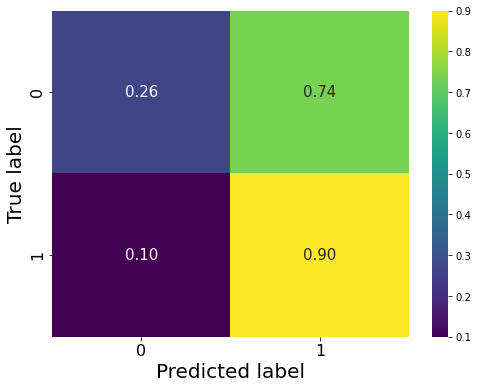

In [19]:
cm_drain_test = confusion_matrix(y_drain_test, best_estimator_drain.predict(X_drain_test), normalize='true')
mmh.plot_confusion_matrix(cm_drain_test, [0, 1])

# _Doubly Robust Learning_: include `drain` as a feature into `model_y`.
- In doubly robust estimators of ATEs and CATES, the treatment variable is included in `model_y`

In [20]:
y_full = csdh_doc['recurrence']
X_full = csdh_doc.drop(['recurrence'], axis=1)

In [21]:
# Split into validation set and rest
X_rest, X_test, y_rest, y_test = train_test_split(X_full, y_full, 
                                                test_size=0.20,
                                                random_state=random_state,
                                                stratify=y_full)

# Split rest into train and test set
X_train, X_val, y_train, y_val = train_test_split(X_rest, y_rest, 
                                                    test_size=0.20,
                                                    random_state=random_state,
                                                    stratify=y_rest)

In [22]:
training_scores, val_scores = mmh.train_and_validate_classifiers(X_train, 
                                                                 y_train,
                                                                 X_val,
                                                                 y_val,
                                                                 names,
                                                                 classifiers)

[16:46:57] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [23]:
mmh.print_metrics_table(training_scores, val_scores, names)

Classification performance on validation set: 

             ----------------Validation-----------------   -----------------Training------------------
Method         Acc↑   AUROC↑  Recall↑      F1↑      LL↓     Acc↑   AUROC↑  Recall↑      F1↑      LL↓
----------------------------------------------------------------------------------------------------
Dummy         0.916    0.500    0.000    0.000   2.909    0.911    0.500    0.000    0.000    3.090
LR            0.916    0.500    0.000    0.000   2.909    0.911    0.500    0.000    0.000    3.090
Linear SVM    0.916    0.500    0.000    0.000   2.909    0.911    0.500    0.000    0.000    3.090
RBF SVM       0.916    0.500    0.000    0.000   2.909    0.911    0.500    0.000    0.000    3.090
GB            0.916    0.557    0.125    0.200   2.909    0.974    0.853    0.706    0.828    0.909
RF            0.916    0.500    0.000    0.000   2.909    1.000    1.000    1.000    1.000    0.000
XGB           0.905    0.494    0.000    0.000 

## `model_y` K-Fold cross validation for hyperparameter tuning and model selection


In [24]:
# do the search
_,_, best_estimator = mmh.randomized_search_cv(X_rest, y_rest, 
                                               search_space, 
                                               cv=cv_5,
                                               refit=True,
                                               score='roc_auc',
                                               n_iter=5000, 
                                               verbose=True)

cv strategy StratifiedKFold(n_splits=5, random_state=100, shuffle=True)
----------------------------------------
Trial 0
----------------------------------------
Parameters {'rf__n_estimators': 171, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='sqrt', n_estimators=171,
                                        random_state=100))])
cv score: [0.72557471 0.65373563 0.59051724 0.63953488 0.42377261]
----------------------------------------
Trial 1
----------------------------------------
Parameters {'xgb__n_estimators': 76, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                     

cv score: [0.78663793 0.5941092  0.67744253 0.62403101 0.47416021]
----------------------------------------
Trial 11
----------------------------------------
Parameters {'rf__n_estimators': 89, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='sqrt', n_estimators=89,
                                        random_state=100))])
cv score: [0.55172414 0.67528736 0.64008621 0.72739018 0.35465116]
----------------------------------------
Trial 12
----------------------------------------
Parameters {'xgb__n_estimators': 46, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                    

cv score: [0.66091954 0.60201149 0.6566092  0.60723514 0.46640827]
----------------------------------------
Trial 22
----------------------------------------
Parameters {'rf__n_estimators': 196, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='log2',
                                        n_estimators=196, random_state=100))])
cv score: [0.63505747 0.65948276 0.61925287 0.66666667 0.40310078]
----------------------------------------
Trial 23
----------------------------------------
Parameters {'rf__n_estimators': 91, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features=None,
                                        n_estimators=91, random_state=100))])
cv score: [0.76293103 0.65517241 0.65804598 0.629198

cv score: [0.71551724 0.63936782 0.67241379 0.5878553  0.3875969 ]
----------------------------------------
Trial 33
----------------------------------------
Parameters {'gb__n_estimators': 158, 'gb__subsample': 0.75, 'gb__learning_rate': 0.7, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=4,
                                            max_features='sqrt',
                                            n_estimators=158, random_state=100,
                                            subsample=0.75))])
cv score: [0.53448276 0.62931034 0.38793103 0.62273902 0.5       ]
----------------------------------------
Trial 34
----------------------------------------
Parameters {'xgb__n_estimators': 151, 'xgb__subsample': 0.65, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.03, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(ste

cv score: [0.66522989 0.64798851 0.51149425 0.52196382 0.5       ]
----------------------------------------
Trial 43
----------------------------------------
Parameters {'gb__n_estimators': 129, 'gb__subsample': 0.65, 'gb__learning_rate': 0.03, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03,
                                            max_features='log2',
                                            n_estimators=129, random_state=100,
                                            subsample=0.65))])
cv score: [0.75431034 0.65517241 0.72557471 0.66149871 0.44056848]
----------------------------------------
Trial 44
----------------------------------------
Parameters {'xgb__n_estimators': 13, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',

cv score: [0.61566092 0.59913793 0.57686782 0.56976744 0.45348837]
----------------------------------------
Trial 54
----------------------------------------
Parameters {'gb__n_estimators': 97, 'gb__subsample': 0.95, 'gb__learning_rate': 0.001, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=97, random_state=100,
                                            subsample=0.95))])
cv score: [0.66810345 0.70545977 0.60201149 0.69250646 0.41602067]
----------------------------------------
Trial 55
----------------------------------------
Parameters {'gb__n_estimators': 123, 'gb__subsample': 0.7, 'gb__learning_rate': 0.003, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
             

cv score: [0.75143678 0.59626437 0.67241379 0.59043928 0.38307494]
----------------------------------------
Trial 67
----------------------------------------
Parameters {'gb__n_estimators': 165, 'gb__subsample': 0.7, 'gb__learning_rate': 0.003, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=4,
                                            max_features='sqrt',
                                            n_estimators=165, random_state=100,
                                            subsample=0.7))])
cv score: [0.74568966 0.66091954 0.68965517 0.6744186  0.42248062]
----------------------------------------
Trial 68
----------------------------------------
Parameters {'rf__n_estimators': 151, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier

cv score: [0.61637931 0.62787356 0.62787356 0.60594315 0.40180879]
----------------------------------------
Trial 79
----------------------------------------
Parameters {'xgb__n_estimators': 121, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=121,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.76867816 0.56321839 0.68103448 0.57428941 0.43863049]
----------------------------------------
Trial 88
----------------------------------------
Parameters {'gb__n_estimators': 40, 'gb__subsample': 0.95, 'gb__learning_rate': 0.003, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=12,
                                            n_estimators=40, random_state=100,
                                            subsample=0.95))])
cv score: [0.59482759 0.74137931 0.54454023 0.60335917 0.34173127]
----------------------------------------
Trial 89
----------------------------------------
Parameters {'rf__n_estimators': 50, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='log2',
                                

cv score: [0.59482759 0.67097701 0.67528736 0.60594315 0.42118863]
----------------------------------------
Trial 100
----------------------------------------
Parameters {'xgb__n_estimators': 166, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.07,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=166,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.68678161 0.65086207 0.63505747 0.65891473 0.46640827]
----------------------------------------
Trial 110
----------------------------------------
Parameters {'gb__n_estimators': 18, 'gb__subsample': 0.9, 'gb__learning_rate': 0.01, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=2,
                                            max_features='log2',
                                            n_estimators=18, random_state=100,
                                            subsample=0.9))])
cv score: [0.79310345 0.58117816 0.76436782 0.67894057 0.37984496]
----------------------------------------
Trial 111
----------------------------------------
Parameters {'gb__n_estimators': 158, 'gb__subsample': 0.95, 'gb__learning_rate': 0.1, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                

cv score: [0.65517241 0.71982759 0.65804598 0.64082687 0.42183463]
----------------------------------------
Trial 122
----------------------------------------
Parameters {'rf__n_estimators': 149, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='log2', n_estimators=149,
                                        random_state=100))])
cv score: [0.69971264 0.64798851 0.67385057 0.65891473 0.42764858]
----------------------------------------
Trial 123
----------------------------------------
Parameters {'gb__n_estimators': 12, 'gb__subsample': 0.95, 'gb__learning_rate': 1.0, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=7,
                                        

cv score: [0.60632184 0.65948276 0.58189655 0.54651163 0.46640827]
----------------------------------------
Trial 132
----------------------------------------
Parameters {'gb__n_estimators': 40, 'gb__subsample': 0.9, 'gb__learning_rate': 0.07, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, n_estimators=40,
                                            random_state=100, subsample=0.9))])
cv score: [0.68390805 0.69683908 0.67385057 0.66149871 0.39664083]
----------------------------------------
Trial 133
----------------------------------------
Parameters {'gb__n_estimators': 75, 'gb__subsample': 0.95, 'gb__learning_rate': 0.7, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=9,
                                            max_features='sqrt',


cv score: [0.68103448 0.67097701 0.58764368 0.64728682 0.41731266]
----------------------------------------
Trial 144
----------------------------------------
Parameters {'rf__n_estimators': 68, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='sqrt',
                                        n_estimators=68, random_state=100))])
cv score: [0.59913793 0.62715517 0.55244253 0.60981912 0.43410853]
----------------------------------------
Trial 145
----------------------------------------
Parameters {'gb__n_estimators': 34, 'gb__subsample': 0.85, 'gb__learning_rate': 0.03, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=11,
                                            n_estimators=34, random_state=100,
               

cv score: [0.59770115 0.68103448 0.58548851 0.46770026 0.49224806]
----------------------------------------
Trial 156
----------------------------------------
Parameters {'gb__n_estimators': 132, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=4,
                                            max_features='sqrt',
                                            n_estimators=132,
                                            random_state=100))])
cv score: [0.58477011 0.70689655 0.50287356 0.56718346 0.44832041]
----------------------------------------
Trial 157
----------------------------------------
Parameters {'rf__n_estimators': 71, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False,

cv score: [0.54741379 0.7183908  0.58045977 0.51421189 0.44832041]
----------------------------------------
Trial 171
----------------------------------------
Parameters {'gb__n_estimators': 178, 'gb__subsample': 0.95, 'gb__learning_rate': 0.01, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=9,
                                            n_estimators=178, random_state=100,
                                            subsample=0.95))])
cv score: [0.55172414 0.71408046 0.56609195 0.73643411 0.40439276]
----------------------------------------
Trial 172
----------------------------------------
Parameters {'xgb__n_estimators': 19, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, boos

cv score: [0.79741379 0.62068966 0.66163793 0.63178295 0.38630491]
----------------------------------------
Trial 183
----------------------------------------
Parameters {'xgb__n_estimators': 195, 'xgb__subsample': 0.8, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=195,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.70402299 0.7341954  0.5933908  0.62790698 0.4121447 ]
----------------------------------------
Trial 195
----------------------------------------
Parameters {'xgb__n_estimators': 104, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=104,
                               n_jobs=16, num_parallel_tree=1, random_state

cv score: [0.625      0.61925287 0.56609195 0.70801034 0.38242894]
----------------------------------------
Trial 206
----------------------------------------
Parameters {'gb__n_estimators': 149, 'gb__subsample': 0.8, 'gb__learning_rate': 0.001, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=7,
                                            n_estimators=149, random_state=100,
                                            subsample=0.8))])
cv score: [0.61781609 0.74281609 0.59195402 0.69896641 0.40439276]
----------------------------------------
Trial 207
----------------------------------------
Parameters {'rf__n_estimators': 191, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                

cv score: [0.55531609 0.67600575 0.61278736 0.56976744 0.43863049]
----------------------------------------
Trial 219
----------------------------------------
Parameters {'rf__n_estimators': 177, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features=None,
                                        n_estimators=177, random_state=100))])
cv score: [0.6566092  0.67528736 0.60201149 0.68217054 0.4379845 ]
----------------------------------------
Trial 220
----------------------------------------
Parameters {'gb__n_estimators': 60, 'gb__subsample': 0.85, 'gb__learning_rate': 0.1, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=4, n_estimators=60,
                                            random_state=100,
                                          

cv score: [0.62212644 0.65373563 0.60057471 0.6744186  0.4496124 ]
----------------------------------------
Trial 233
----------------------------------------
Parameters {'rf__n_estimators': 104, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='sqrt',
                                        n_estimators=104, random_state=100))])
cv score: [0.74137931 0.61637931 0.61350575 0.60465116 0.43152455]
----------------------------------------
Trial 234
----------------------------------------
Parameters {'rf__n_estimators': 152, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='sqrt', n_estimators=152,
                                        random_

cv score: [0.65373563 0.66666667 0.73275862 0.6744186  0.41731266]
----------------------------------------
Trial 244
----------------------------------------
Parameters {'gb__n_estimators': 161, 'gb__subsample': 0.85, 'gb__learning_rate': 0.07, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=13,
                                            max_features='sqrt',
                                            n_estimators=161, random_state=100,
                                            subsample=0.85))])
cv score: [0.63362069 0.6566092  0.52442529 0.68604651 0.40310078]
----------------------------------------
Trial 245
----------------------------------------
Parameters {'rf__n_estimators': 183, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassif

cv score: [0.56752874 0.66235632 0.61494253 0.58010336 0.38113695]
----------------------------------------
Trial 256
----------------------------------------
Parameters {'rf__n_estimators': 141, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='log2',
                                        n_estimators=141, random_state=100))])
cv score: [0.72557471 0.63793103 0.67528736 0.58268734 0.41602067]
----------------------------------------
Trial 257
----------------------------------------
Parameters {'rf__n_estimators': 156, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='log2',
                                        n_estimators=156, random_state=100))])
cv score: [0.63362069 0.65804598 0.5818965

cv score: [0.63936782 0.63793103 0.56752874 0.57622739 0.36111111]
----------------------------------------
Trial 268
----------------------------------------
Parameters {'gb__n_estimators': 18, 'gb__subsample': 0.7, 'gb__learning_rate': 1.0, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=8,
                                            max_features='log2',
                                            n_estimators=18, random_state=100,
                                            subsample=0.7))])
cv score: [0.61063218 0.48275862 0.56034483 0.67829457 0.42635659]
----------------------------------------
Trial 269
----------------------------------------
Parameters {'xgb__n_estimators': 103, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.003, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(st

Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=109,
                               n_jobs=16, num_parallel_tree=1, random_state=100,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.75, tree_method='exact',
                               validate_parameters=1, verbosity=None))])
cv score: [0.58908046 0.70258621 0.60775862 0.52971576 0.44056848]
----------------------------------------
Trial 280

cv score: [0.72413793 0.64655172 0.58045977 0.62661499 0.42248062]
----------------------------------------
Trial 291
----------------------------------------
Parameters {'gb__n_estimators': 72, 'gb__subsample': 0.85, 'gb__learning_rate': 0.1, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=13, max_features='sqrt',
                                            n_estimators=72, random_state=100,
                                            subsample=0.85))])
cv score: [0.64367816 0.64367816 0.62643678 0.61111111 0.42377261]
----------------------------------------
Trial 292
----------------------------------------
Parameters {'xgb__n_estimators': 121, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, b

cv score: [0.76795977 0.61494253 0.69683908 0.62080103 0.42571059]
----------------------------------------
Trial 303
----------------------------------------
Parameters {'xgb__n_estimators': 44, 'xgb__subsample': 0.6, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=44,
                               n_jobs=16, num_parallel_tree=1, random_state=10

cv score: [0.61350575 0.72772989 0.65445402 0.68475452 0.41602067]
----------------------------------------
Trial 314
----------------------------------------
Parameters {'gb__n_estimators': 71, 'gb__subsample': 0.85, 'gb__learning_rate': 0.01, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=14,
                                            max_features='log2',
                                            n_estimators=71, random_state=100,
                                            subsample=0.85))])
cv score: [0.66810345 0.61925287 0.53017241 0.67958656 0.48966408]
----------------------------------------
Trial 315
----------------------------------------
Parameters {'gb__n_estimators': 48, 'gb__subsample': 0.6, 'gb__learning_rate': 0.07, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
            

cv score: [0.61063218 0.67097701 0.58189655 0.60981912 0.48062016]
----------------------------------------
Trial 325
----------------------------------------
Parameters {'gb__n_estimators': 112, 'gb__subsample': 0.8, 'gb__learning_rate': 1.0, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=2,
                                            max_features='log2',
                                            n_estimators=112, random_state=100,
                                            subsample=0.8))])
cv score: [0.55603448 0.59770115 0.60344828 0.56459948 0.48966408]
----------------------------------------
Trial 326
----------------------------------------
Parameters {'xgb__n_estimators': 173, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.07, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(ste

cv score: [0.66522989 0.66954023 0.62212644 0.62015504 0.42635659]
----------------------------------------
Trial 335
----------------------------------------
Parameters {'xgb__n_estimators': 86, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=86,
                               n_jobs=16, num_parallel_tree=1, random_stat

cv score: [0.74568966 0.63505747 0.67887931 0.64018088 0.43410853]
----------------------------------------
Trial 347
----------------------------------------
Parameters {'gb__n_estimators': 152, 'gb__subsample': 0.9, 'gb__learning_rate': 0.001, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=152, random_state=100,
                                            subsample=0.9))])
cv score: [0.78017241 0.60775862 0.72701149 0.64470284 0.36369509]
----------------------------------------
Trial 348
----------------------------------------
Parameters {'rf__n_estimators': 149, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifie

cv score: [0.57614943 0.72844828 0.6408046  0.58139535 0.4121447 ]
----------------------------------------
Trial 359
----------------------------------------
Parameters {'gb__n_estimators': 76, 'gb__subsample': 0.75, 'gb__learning_rate': 1.0, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=13,
                                            max_features='sqrt',
                                            n_estimators=76, random_state=100,
                                            subsample=0.75))])
cv score: [0.63649425 0.68247126 0.59913793 0.69509044 0.43410853]
----------------------------------------
Trial 360
----------------------------------------
Parameters {'gb__n_estimators': 151, 'gb__subsample': 0.9, 'gb__learning_rate': 0.001, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
              

cv score: [0.64367816 0.63793103 0.61637931 0.60594315 0.39922481]
----------------------------------------
Trial 369
----------------------------------------
Parameters {'xgb__n_estimators': 147, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.001, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=147,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.59626437 0.67600575 0.6408046  0.71705426 0.39534884]
----------------------------------------
Trial 381
----------------------------------------
Parameters {'gb__n_estimators': 178, 'gb__subsample': 0.9, 'gb__learning_rate': 0.3, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=13,
                                            n_estimators=178, random_state=100,
                                            subsample=0.9))])
cv score: [0.59051724 0.73850575 0.61637931 0.60206718 0.33850129]
----------------------------------------
Trial 382
----------------------------------------
Parameters {'gb__n_estimators': 102, 'gb__subsample': 0.65, 'gb__learning_rate': 0.1, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=9, max_features='log2',
   

cv score: [0.60632184 0.69683908 0.61637931 0.62790698 0.42635659]
----------------------------------------
Trial 394
----------------------------------------
Parameters {'xgb__n_estimators': 157, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=157,
                               n_jobs=16, num_parallel_tree=1, random_state=

cv score: [0.61206897 0.61637931 0.56465517 0.63178295 0.4625323 ]
----------------------------------------
Trial 405
----------------------------------------
Parameters {'rf__n_estimators': 160, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='log2', n_estimators=160,
                                        random_state=100))])
cv score: [0.54885057 0.66738506 0.58477011 0.74418605 0.40826873]
----------------------------------------
Trial 406
----------------------------------------
Parameters {'gb__n_estimators': 106, 'gb__subsample': 0.75, 'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01,
                                            ma

cv score: [0.56034483 0.70833333 0.74281609 0.66020672 0.3630491 ]
----------------------------------------
Trial 416
----------------------------------------
Parameters {'rf__n_estimators': 187, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='log2',
                                        n_estimators=187, random_state=100))])
cv score: [0.56321839 0.67816092 0.625      0.63307494 0.41602067]
----------------------------------------
Trial 417
----------------------------------------
Parameters {'xgb__n_estimators': 87, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.1, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
      

cv score: [0.64511494 0.67528736 0.50143678 0.64857881 0.41860465]
----------------------------------------
Trial 427
----------------------------------------
Parameters {'gb__n_estimators': 152, 'gb__subsample': 0.9, 'gb__learning_rate': 0.003, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=10,
                                            max_features='sqrt',
                                            n_estimators=152, random_state=100,
                                            subsample=0.9))])
cv score: [0.61063218 0.68534483 0.51867816 0.69767442 0.46124031]
----------------------------------------
Trial 428
----------------------------------------
Parameters {'xgb__n_estimators': 49, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.001, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pip

cv score: [0.5862069  0.68965517 0.56034483 0.67571059 0.45090439]
----------------------------------------
Trial 436
----------------------------------------
Parameters {'rf__n_estimators': 172, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='sqrt',
                                        n_estimators=172, random_state=100))])
cv score: [0.56178161 0.64942529 0.60847701 0.63178295 0.40180879]
----------------------------------------
Trial 437
----------------------------------------
Parameters {'xgb__n_estimators': 111, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
    

cv score: [0.58189655 0.47270115 0.51005747 0.60723514 0.53359173]
----------------------------------------
Trial 448
----------------------------------------
Parameters {'xgb__n_estimators': 73, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=73,
                               n_jobs=16, num_parallel_tree=1, random_state=10

cv score: [0.6408046  0.70402299 0.61637931 0.59302326 0.29844961]
----------------------------------------
Trial 456
----------------------------------------
Parameters {'xgb__n_estimators': 118, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.001, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=118,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.54597701 0.55747126 0.47126437 0.52777778 0.44186047]
----------------------------------------
Trial 466
----------------------------------------
Parameters {'rf__n_estimators': 31, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features=None, n_estimators=31,
                                        random_state=100))])
cv score: [0.6795977  0.6170977  0.5158046  0.70865633 0.45930233]
----------------------------------------
Trial 467
----------------------------------------
Parameters {'rf__n_estimators': 98, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='log2',
                                        n_estimators=98, random_state=10

cv score: [0.55962644 0.67744253 0.57686782 0.60658915 0.44767442]
----------------------------------------
Trial 479
----------------------------------------
Parameters {'gb__n_estimators': 101, 'gb__subsample': 0.7, 'gb__learning_rate': 0.01, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=10,
                                            max_features='sqrt',
                                            n_estimators=101, random_state=100,
                                            subsample=0.7))])
cv score: [0.62212644 0.64511494 0.47413793 0.65245478 0.46382429]
----------------------------------------
Trial 480
----------------------------------------
Parameters {'xgb__n_estimators': 101, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline

cv score: [0.6637931  0.73275862 0.62931034 0.61498708 0.42894057]
----------------------------------------
Trial 489
----------------------------------------
Parameters {'rf__n_estimators': 193, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='sqrt', n_estimators=193,
                                        random_state=100))])
cv score: [0.63505747 0.66810345 0.61925287 0.63565891 0.43152455]
----------------------------------------
Trial 490
----------------------------------------
Parameters {'xgb__n_estimators': 114, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                     

cv score: [0.60488506 0.6637931  0.62931034 0.63565891 0.40956072]
----------------------------------------
Trial 499
----------------------------------------
Parameters {'rf__n_estimators': 36, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='log2', n_estimators=36,
                                        random_state=100))])
cv score: [0.70977011 0.63218391 0.63649425 0.61369509 0.38372093]
----------------------------------------
Trial 500
----------------------------------------
Parameters {'rf__n_estimators': 104, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='sqrt', n_estimat

cv score: [0.58908046 0.7341954  0.50431034 0.5503876  0.43281654]
----------------------------------------
Trial 512
----------------------------------------
Parameters {'rf__n_estimators': 128, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='log2',
                                        n_estimators=128, random_state=100))])
cv score: [0.56321839 0.68678161 0.60057471 0.62338501 0.43281654]
----------------------------------------
Trial 513
----------------------------------------
Parameters {'xgb__n_estimators': 188, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.001, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
  

cv score: [0.61781609 0.61063218 0.625      0.70542636 0.36563307]
----------------------------------------
Trial 523
----------------------------------------
Parameters {'rf__n_estimators': 131, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='sqrt', n_estimators=131,
                                        random_state=100))])
cv score: [0.77011494 0.63074713 0.66163793 0.6369509  0.38888889]
----------------------------------------
Trial 524
----------------------------------------
Parameters {'gb__n_estimators': 15, 'gb__subsample': 0.7, 'gb__learning_rate': 0.3, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=11,
                                     

cv score: [0.55962644 0.6875     0.59698276 0.62273902 0.43281654]
----------------------------------------
Trial 533
----------------------------------------
Parameters {'rf__n_estimators': 192, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='log2',
                                        n_estimators=192, random_state=100))])
cv score: [0.66091954 0.63505747 0.60201149 0.60852713 0.40568475]
----------------------------------------
Trial 534
----------------------------------------
Parameters {'xgb__n_estimators': 115, 'xgb__subsample': 0.9, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.03, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
       

cv score: [0.72916667 0.65445402 0.62428161 0.70155039 0.39793282]
----------------------------------------
Trial 547
----------------------------------------
Parameters {'rf__n_estimators': 171, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='log2',
                                        n_estimators=171, random_state=100))])
cv score: [0.72557471 0.63505747 0.65373563 0.59689922 0.40826873]
----------------------------------------
Trial 548
----------------------------------------
Parameters {'rf__n_estimators': 112, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='log2', n_estimators=112,
                                        random_

cv score: [0.79813218 0.58477011 0.68390805 0.59560724 0.42571059]
----------------------------------------
Trial 558
----------------------------------------
Parameters {'gb__n_estimators': 147, 'gb__subsample': 0.9, 'gb__learning_rate': 0.01, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=9,
                                            max_features='log2',
                                            n_estimators=147, random_state=100,
                                            subsample=0.9))])
cv score: [0.63074713 0.66522989 0.50287356 0.63436693 0.43152455]
----------------------------------------
Trial 559
----------------------------------------
Parameters {'rf__n_estimators': 36, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(

cv score: [0.64655172 0.67672414 0.67097701 0.58139535 0.38888889]
----------------------------------------
Trial 569
----------------------------------------
Parameters {'gb__n_estimators': 16, 'gb__subsample': 0.9, 'gb__learning_rate': 0.003, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=11,
                                            max_features='sqrt',
                                            n_estimators=16, random_state=100,
                                            subsample=0.9))])
cv score: [0.48132184 0.62068966 0.68390805 0.67312661 0.48966408]
----------------------------------------
Trial 570
----------------------------------------
Parameters {'rf__n_estimators': 57, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(m

cv score: [0.65373563 0.64798851 0.64655172 0.60465116 0.41989664]
----------------------------------------
Trial 579
----------------------------------------
Parameters {'xgb__n_estimators': 185, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=13,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=185,
                               n_jobs=16, num_parallel_tree=1, rando

cv score: [0.55747126 0.66738506 0.61637931 0.7377261  0.38501292]
----------------------------------------
Trial 590
----------------------------------------
Parameters {'gb__n_estimators': 25, 'gb__subsample': 0.7, 'gb__learning_rate': 0.07, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=13,
                                            max_features='sqrt',
                                            n_estimators=25, random_state=100,
                                            subsample=0.7))])
cv score: [0.45402299 0.66810345 0.62212644 0.77906977 0.40826873]
----------------------------------------
Trial 591
----------------------------------------
Parameters {'xgb__n_estimators': 108, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.3, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(

cv score: [0.55890805 0.58333333 0.62356322 0.60465116 0.41085271]
----------------------------------------
Trial 600
----------------------------------------
Parameters {'rf__n_estimators': 141, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='log2', n_estimators=141,
                                        random_state=100))])
cv score: [0.66091954 0.64511494 0.65229885 0.64857881 0.4496124 ]
----------------------------------------
Trial 601
----------------------------------------
Parameters {'gb__n_estimators': 158, 'gb__subsample': 0.7, 'gb__learning_rate': 0.07, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=5,
                                    

cv score: [0.71982759 0.6408046  0.66522989 0.56718346 0.4121447 ]
----------------------------------------
Trial 612
----------------------------------------
Parameters {'rf__n_estimators': 80, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='sqrt', n_estimators=80,
                                        random_state=100))])
cv score: [0.56609195 0.67385057 0.62715517 0.72351421 0.34366925]
----------------------------------------
Trial 613
----------------------------------------
Parameters {'xgb__n_estimators': 120, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                    

cv score: [0.55100575 0.58692529 0.47126437 0.52777778 0.3869509 ]
----------------------------------------
Trial 622
----------------------------------------
Parameters {'rf__n_estimators': 196, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='log2',
                                        n_estimators=196, random_state=100))])
cv score: [0.58764368 0.65804598 0.55747126 0.63953488 0.42764858]
----------------------------------------
Trial 623
----------------------------------------
Parameters {'gb__n_estimators': 22, 'gb__subsample': 1.0, 'gb__learning_rate': 0.7, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=4,
                                            max_features='log2',
                              

cv score: [0.63649425 0.68678161 0.55028736 0.58656331 0.41602067]
----------------------------------------
Trial 635
----------------------------------------
Parameters {'xgb__n_estimators': 102, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=102,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.62643678 0.67241379 0.66522989 0.5878553  0.38372093]
----------------------------------------
Trial 647
----------------------------------------
Parameters {'rf__n_estimators': 141, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features=None,
                                        n_estimators=141, random_state=100))])
cv score: [0.60344828 0.71767241 0.65158046 0.68475452 0.41731266]
----------------------------------------
Trial 648
----------------------------------------
Parameters {'xgb__n_estimators': 82, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
        

cv score: [0.52729885 0.6954023  0.5933908  0.54392765 0.4250646 ]
----------------------------------------
Trial 660
----------------------------------------
Parameters {'gb__n_estimators': 155, 'gb__subsample': 1.0, 'gb__learning_rate': 0.001, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=9,
                                            n_estimators=155,
                                            random_state=100))])
cv score: [0.62068966 0.59985632 0.65301724 0.55555556 0.48062016]
----------------------------------------
Trial 661
----------------------------------------
Parameters {'rf__n_estimators': 176, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features=None,
                                        n_estimato

cv score: [0.72557471 0.55890805 0.54741379 0.57235142 0.39793282]
----------------------------------------
Trial 670
----------------------------------------
Parameters {'gb__n_estimators': 174, 'gb__subsample': 1.0, 'gb__learning_rate': 0.001, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=13,
                                            n_estimators=174,
                                            random_state=100))])
cv score: [0.63864943 0.59985632 0.56968391 0.51744186 0.40116279]
----------------------------------------
Trial 671
----------------------------------------
Parameters {'gb__n_estimators': 156, 'gb__subsample': 0.9, 'gb__learning_rate': 0.1, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=14, max_features='log2',
             

cv score: [0.57255747 0.60344828 0.56537356 0.56912145 0.46640827]
----------------------------------------
Trial 685
----------------------------------------
Parameters {'xgb__n_estimators': 90, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=13,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=90,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.72701149 0.6637931  0.72270115 0.65180879 0.41149871]
----------------------------------------
Trial 695
----------------------------------------
Parameters {'xgb__n_estimators': 144, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=11,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=144,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.5387931  0.54166667 0.51867816 0.39793282 0.59625323]
----------------------------------------
Trial 705
----------------------------------------
Parameters {'gb__n_estimators': 168, 'gb__subsample': 0.7, 'gb__learning_rate': 0.001, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=9,
                                            n_estimators=168, random_state=100,
                                            subsample=0.7))])
cv score: [0.57183908 0.72126437 0.55316092 0.7002584  0.45478036]
----------------------------------------
Trial 706
----------------------------------------
Parameters {'gb__n_estimators': 155, 'gb__subsample': 0.8, 'gb__learning_rate': 0.03, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=13,


cv score: [0.56321839 0.62356322 0.65373563 0.60335917 0.42764858]
----------------------------------------
Trial 716
----------------------------------------
Parameters {'xgb__n_estimators': 115, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.07,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=115,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.63936782 0.6566092  0.52729885 0.6369509  0.39922481]
----------------------------------------
Trial 727
----------------------------------------
Parameters {'gb__n_estimators': 68, 'gb__subsample': 0.95, 'gb__learning_rate': 0.1, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=6, max_features='sqrt',
                                            n_estimators=68, random_state=100,
                                            subsample=0.95))])
cv score: [0.63505747 0.67241379 0.54310345 0.56976744 0.44702842]
----------------------------------------
Trial 728
----------------------------------------
Parameters {'rf__n_estimators': 128, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='sqrt',
                               

cv score: [0.66307471 0.64295977 0.48275862 0.56718346 0.41860465]
----------------------------------------
Trial 740
----------------------------------------
Parameters {'xgb__n_estimators': 25, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=25,
                               n_jobs=16, num_parallel_tree=1, random_state=

cv score: [0.63649425 0.68318966 0.49640805 0.69056848 0.4379845 ]
----------------------------------------
Trial 751
----------------------------------------
Parameters {'xgb__n_estimators': 60, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.1, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=60,
                               n_jobs=16, num_parallel_tree=1, random_state=1

cv score: [0.69971264 0.66522989 0.55028736 0.64857881 0.49354005]
----------------------------------------
Trial 761
----------------------------------------
Parameters {'xgb__n_estimators': 120, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=120,
                               n_jobs=16, num_parallel_tree=1, ran

cv score: [0.58764368 0.67672414 0.67097701 0.58914729 0.41472868]
----------------------------------------
Trial 771
----------------------------------------
Parameters {'gb__n_estimators': 150, 'gb__subsample': 0.85, 'gb__learning_rate': 0.1, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=8, max_features='log2',
                                            n_estimators=150, random_state=100,
                                            subsample=0.85))])
cv score: [0.62787356 0.66235632 0.45545977 0.57622739 0.47286822]
----------------------------------------
Trial 772
----------------------------------------
Parameters {'gb__n_estimators': 102, 'gb__subsample': 0.65, 'gb__learning_rate': 0.1, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=13, n_estimators=102,
  

cv score: [0.73635057 0.66235632 0.7183908  0.6369509  0.42635659]
----------------------------------------
Trial 783
----------------------------------------
Parameters {'rf__n_estimators': 133, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='sqrt', n_estimators=133,
                                        random_state=100))])
cv score: [0.74568966 0.64798851 0.6954023  0.64599483 0.43410853]
----------------------------------------
Trial 784
----------------------------------------
Parameters {'gb__n_estimators': 79, 'gb__subsample': 0.8, 'gb__learning_rate': 0.03, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=2,
                                       

cv score: [0.64655172 0.625      0.67097701 0.59689922 0.4121447 ]
----------------------------------------
Trial 794
----------------------------------------
Parameters {'gb__n_estimators': 21, 'gb__subsample': 0.7, 'gb__learning_rate': 1.0, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=14,
                                            n_estimators=21, random_state=100,
                                            subsample=0.7))])
cv score: [0.58764368 0.59195402 0.46695402 0.64082687 0.47932817]
----------------------------------------
Trial 795
----------------------------------------
Parameters {'gb__n_estimators': 10, 'gb__subsample': 0.6, 'gb__learning_rate': 0.1, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=2, max_features='log2',
       

cv score: [0.79382184 0.58908046 0.67600575 0.65116279 0.48514212]
----------------------------------------
Trial 806
----------------------------------------
Parameters {'xgb__n_estimators': 112, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=112,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.60201149 0.7191092  0.64942529 0.68346253 0.41666667]
----------------------------------------
Trial 816
----------------------------------------
Parameters {'gb__n_estimators': 97, 'gb__subsample': 0.95, 'gb__learning_rate': 0.3, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=14,
                                            max_features='log2',
                                            n_estimators=97, random_state=100,
                                            subsample=0.95))])
cv score: [0.59913793 0.76005747 0.58477011 0.5994832  0.39793282]
----------------------------------------
Trial 817
----------------------------------------
Parameters {'rf__n_estimators': 150, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier

cv score: [0.69109195 0.60632184 0.55747126 0.5749354  0.42635659]
----------------------------------------
Trial 828
----------------------------------------
Parameters {'xgb__n_estimators': 188, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.003, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=188,
                               n_jobs=16, num_parallel_tree=1, random

cv score: [0.73635057 0.5704023  0.64798851 0.63178295 0.43346253]
----------------------------------------
Trial 840
----------------------------------------
Parameters {'xgb__n_estimators': 21, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.07,
                               max_delta_step=0, max_depth=14,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=21,
                               n_jobs=16, num_parallel_tree=1, random

cv score: [0.62643678 0.67528736 0.62643678 0.62015504 0.37984496]
----------------------------------------
Trial 852
----------------------------------------
Parameters {'rf__n_estimators': 65, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='sqrt', n_estimators=65,
                                        random_state=100))])
cv score: [0.73706897 0.64224138 0.6954023  0.64470284 0.40310078]
----------------------------------------
Trial 853
----------------------------------------
Parameters {'rf__n_estimators': 145, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features=None,
                                        n_estimators=145, random_stat

cv score: [0.52011494 0.69396552 0.5        0.66408269 0.37726098]
----------------------------------------
Trial 865
----------------------------------------
Parameters {'gb__n_estimators': 63, 'gb__subsample': 0.6, 'gb__learning_rate': 0.03, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, n_estimators=63,
                                            random_state=100, subsample=0.6))])
cv score: [0.70114943 0.65373563 0.70833333 0.6498708  0.44444444]
----------------------------------------
Trial 866
----------------------------------------
Parameters {'gb__n_estimators': 10, 'gb__subsample': 0.65, 'gb__learning_rate': 0.07, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=14,
                                            max_features='sqr

cv score: [0.6091954  0.68103448 0.55890805 0.68863049 0.47416021]
----------------------------------------
Trial 878
----------------------------------------
Parameters {'gb__n_estimators': 88, 'gb__subsample': 0.9, 'gb__learning_rate': 1.0, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=13,
                                            max_features='sqrt',
                                            n_estimators=88, random_state=100,
                                            subsample=0.9))])
cv score: [0.49712644 0.80747126 0.53017241 0.54005168 0.45994832]
----------------------------------------
Trial 879
----------------------------------------
Parameters {'xgb__n_estimators': 66, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(ste

cv score: [0.6795977  0.61063218 0.67241379 0.6130491  0.39793282]
----------------------------------------
Trial 889
----------------------------------------
Parameters {'rf__n_estimators': 161, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='log2', n_estimators=161,
                                        random_state=100))])
cv score: [0.7658046  0.62643678 0.68606322 0.65762274 0.40568475]
----------------------------------------
Trial 890
----------------------------------------
Parameters {'xgb__n_estimators': 192, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                  

cv score: [0.77298851 0.57471264 0.49066092 0.58397933 0.37403101]
----------------------------------------
Trial 898
----------------------------------------
Parameters {'gb__n_estimators': 128, 'gb__subsample': 0.6, 'gb__learning_rate': 0.07, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=128, random_state=100,
                                            subsample=0.6))])
cv score: [0.70833333 0.65373563 0.68534483 0.64082687 0.41860465]
----------------------------------------
Trial 899
----------------------------------------
Parameters {'xgb__n_estimators': 52, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.001, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline

cv score: [0.64367816 0.64942529 0.62931034 0.57105943 0.40568475]
----------------------------------------
Trial 910
----------------------------------------
Parameters {'gb__n_estimators': 81, 'gb__subsample': 0.95, 'gb__learning_rate': 0.3, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=12,
                                            max_features='log2',
                                            n_estimators=81, random_state=100,
                                            subsample=0.95))])
cv score: [0.61494253 0.68678161 0.5316092  0.58010336 0.46511628]
----------------------------------------
Trial 911
----------------------------------------
Parameters {'rf__n_estimators': 186, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(

cv score: [0.64367816 0.63505747 0.51005747 0.63436693 0.39793282]
----------------------------------------
Trial 920
----------------------------------------
Parameters {'gb__n_estimators': 182, 'gb__subsample': 0.95, 'gb__learning_rate': 0.003, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=9,
                                            n_estimators=182, random_state=100,
                                            subsample=0.95))])
cv score: [0.52442529 0.70545977 0.60057471 0.67700258 0.41666667]
----------------------------------------
Trial 921
----------------------------------------
Parameters {'gb__n_estimators': 58, 'gb__subsample': 0.65, 'gb__learning_rate': 0.001, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=

cv score: [0.57183908 0.66666667 0.52155172 0.48449612 0.46640827]
----------------------------------------
Trial 929
----------------------------------------
Parameters {'xgb__n_estimators': 198, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.07, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=198,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.625      0.72557471 0.54454023 0.63953488 0.44832041]
----------------------------------------
Trial 941
----------------------------------------
Parameters {'gb__n_estimators': 101, 'gb__subsample': 0.85, 'gb__learning_rate': 1.0, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=12,
                                            n_estimators=101, random_state=100,
                                            subsample=0.85))])
cv score: [0.60344828 0.75143678 0.56465517 0.62790698 0.50775194]
----------------------------------------
Trial 942
----------------------------------------
Parameters {'rf__n_estimators': 127, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                  

Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=13,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=184,
                               n_jobs=16, num_parallel_tree=1, random_state=100,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.7, tree_method='exact',
                               validate_parameters=1, verbosity=None))])
cv score: [0.59482759 0.69971264 0.58189655 0.62273902 0.44702842]
----------------------------------------
Trial 954
-

cv score: [0.62212644 0.67385057 0.63218391 0.61757106 0.38242894]
----------------------------------------
Trial 964
----------------------------------------
Parameters {'rf__n_estimators': 30, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features=None, n_estimators=30,
                                        random_state=100))])
cv score: [0.61637931 0.60272989 0.56824713 0.57041344 0.45348837]
----------------------------------------
Trial 965
----------------------------------------
Parameters {'xgb__n_estimators': 113, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.01, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                       

cv score: [0.61781609 0.69252874 0.57471264 0.6744186  0.4496124 ]
----------------------------------------
Trial 974
----------------------------------------
Parameters {'xgb__n_estimators': 66, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=66,
                               n_jobs=16, num_parallel_tree=1, random_state=

cv score: [0.68103448 0.625      0.49568966 0.65633075 0.41731266]
----------------------------------------
Trial 983
----------------------------------------
Parameters {'rf__n_estimators': 48, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='sqrt', n_estimators=48,
                                        random_state=100))])
cv score: [0.75       0.62787356 0.6954023  0.6498708  0.40697674]
----------------------------------------
Trial 984
----------------------------------------
Parameters {'gb__n_estimators': 76, 'gb__subsample': 0.9, 'gb__learning_rate': 0.03, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=7,
                                         

cv score: [0.53017241 0.73132184 0.55172414 0.59043928 0.44832041]
----------------------------------------
Trial 994
----------------------------------------
Parameters {'gb__n_estimators': 39, 'gb__subsample': 0.95, 'gb__learning_rate': 0.001, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=13,
                                            max_features='log2',
                                            n_estimators=39, random_state=100,
                                            subsample=0.95))])
cv score: [0.59626437 0.73275862 0.59626437 0.61498708 0.48578811]
----------------------------------------
Trial 995
----------------------------------------
Parameters {'rf__n_estimators': 177, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassif

cv score: [0.74712644 0.64224138 0.68390805 0.62919897 0.40568475]
----------------------------------------
Trial 1006
----------------------------------------
Parameters {'xgb__n_estimators': 59, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.001, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=12,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=59,
                               n_jobs=16, num_parallel_tree=1, rand

cv score: [0.58477011 0.6091954  0.58045977 0.55555556 0.42635659]
----------------------------------------
Trial 1018
----------------------------------------
Parameters {'rf__n_estimators': 90, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features=None, n_estimators=90,
                                        random_state=100))])
cv score: [0.57183908 0.59770115 0.56537356 0.56912145 0.46640827]
----------------------------------------
Trial 1019
----------------------------------------
Parameters {'rf__n_estimators': 75, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features=None, n_estimators=7

cv score: [0.63505747 0.52729885 0.5387931  0.71059432 0.40826873]
----------------------------------------
Trial 1033
----------------------------------------
Parameters {'rf__n_estimators': 148, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='log2', n_estimators=148,
                                        random_state=100))])
cv score: [0.60057471 0.67672414 0.60704023 0.72868217 0.40697674]
----------------------------------------
Trial 1034
----------------------------------------
Parameters {'xgb__n_estimators': 177, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                 

cv score: [0.53735632 0.47844828 0.5158046  0.73901809 0.4754522 ]
----------------------------------------
Trial 1045
----------------------------------------
Parameters {'xgb__n_estimators': 67, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.07, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=67,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.61494253 0.69109195 0.61781609 0.71963824 0.39018088]
----------------------------------------
Trial 1057
----------------------------------------
Parameters {'rf__n_estimators': 163, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features=None,
                                        n_estimators=163, random_state=100))])
cv score: [0.60632184 0.70258621 0.67097701 0.69509044 0.44056848]
----------------------------------------
Trial 1058
----------------------------------------
Parameters {'gb__n_estimators': 137, 'gb__subsample': 0.75, 'gb__learning_rate': 0.7, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=14,
                                            max_features='sqrt',
                              

cv score: [0.59913793 0.70689655 0.50862069 0.63307494 0.41989664]
----------------------------------------
Trial 1071
----------------------------------------
Parameters {'gb__n_estimators': 98, 'gb__subsample': 0.9, 'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=5, n_estimators=98,
                                            random_state=100, subsample=0.9))])
cv score: [0.55890805 0.68678161 0.54310345 0.67700258 0.48449612]
----------------------------------------
Trial 1072
----------------------------------------
Parameters {'xgb__n_estimators': 182, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.003, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, c

cv score: [0.58692529 0.60272989 0.51436782 0.52260982 0.46899225]
----------------------------------------
Trial 1082
----------------------------------------
Parameters {'gb__n_estimators': 100, 'gb__subsample': 0.7, 'gb__learning_rate': 0.3, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=4,
                                            max_features='log2',
                                            random_state=100, subsample=0.7))])
cv score: [0.56034483 0.62212644 0.5387931  0.60981912 0.53617571]
----------------------------------------
Trial 1083
----------------------------------------
Parameters {'rf__n_estimators': 114, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                             

cv score: [0.61206897 0.68821839 0.66522989 0.61757106 0.44573643]
----------------------------------------
Trial 1095
----------------------------------------
Parameters {'rf__n_estimators': 159, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='sqrt', n_estimators=159,
                                        random_state=100))])
cv score: [0.59482759 0.67385057 0.62643678 0.68087855 0.43023256]
----------------------------------------
Trial 1096
----------------------------------------
Parameters {'xgb__n_estimators': 49, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.1, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                 

cv score: [0.5862069  0.68318966 0.61350575 0.71705426 0.39664083]
----------------------------------------
Trial 1106
----------------------------------------
Parameters {'gb__n_estimators': 161, 'gb__subsample': 0.65, 'gb__learning_rate': 1.0, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=4,
                                            n_estimators=161, random_state=100,
                                            subsample=0.65))])
cv score: [0.48275862 0.65301724 0.58405172 0.2997416  0.69638243]
----------------------------------------
Trial 1107
----------------------------------------
Parameters {'rf__n_estimators': 165, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='log2',
                               

cv score: [0.74856322 0.67241379 0.61350575 0.68346253 0.40826873]
----------------------------------------
Trial 1116
----------------------------------------
Parameters {'xgb__n_estimators': 108, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=108,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.77011494 0.63649425 0.67313218 0.64082687 0.39534884]
----------------------------------------
Trial 1125
----------------------------------------
Parameters {'gb__n_estimators': 97, 'gb__subsample': 0.75, 'gb__learning_rate': 0.003, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=7,
                                            max_features='sqrt',
                                            n_estimators=97, random_state=100,
                                            subsample=0.75))])
cv score: [0.65948276 0.6566092  0.62212644 0.65633075 0.41989664]
----------------------------------------
Trial 1126
----------------------------------------
Parameters {'rf__n_estimators': 126, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClass

cv score: [0.60632184 0.6954023  0.48850575 0.64470284 0.37596899]
----------------------------------------
Trial 1134
----------------------------------------
Parameters {'xgb__n_estimators': 43, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.01, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=43,
                               n_jobs=16, num_parallel_tree=1, random_state

cv score: [0.63074713 0.72413793 0.61637931 0.63565891 0.46511628]
----------------------------------------
Trial 1142
----------------------------------------
Parameters {'gb__n_estimators': 33, 'gb__subsample': 0.65, 'gb__learning_rate': 0.7, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=5,
                                            max_features='log2',
                                            n_estimators=33, random_state=100,
                                            subsample=0.65))])
cv score: [0.57327586 0.45402299 0.53448276 0.35788114 0.47803618]
----------------------------------------
Trial 1143
----------------------------------------
Parameters {'gb__n_estimators': 77, 'gb__subsample': 0.75, 'gb__learning_rate': 0.01, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
               

cv score: [0.78735632 0.6566092  0.6795977  0.64018088 0.44702842]
----------------------------------------
Trial 1153
----------------------------------------
Parameters {'gb__n_estimators': 81, 'gb__subsample': 0.75, 'gb__learning_rate': 0.03, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=2,
                                            n_estimators=81, random_state=100,
                                            subsample=0.75))])
cv score: [0.67816092 0.66522989 0.65517241 0.61498708 0.4121447 ]
----------------------------------------
Trial 1154
----------------------------------------
Parameters {'gb__n_estimators': 190, 'gb__subsample': 0.65, 'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=5, n_estimators=190,
      

cv score: [0.64798851 0.58764368 0.66522989 0.65891473 0.44832041]
----------------------------------------
Trial 1163
----------------------------------------
Parameters {'gb__n_estimators': 110, 'gb__subsample': 1.0, 'gb__learning_rate': 0.001, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=14,
                                            max_features='sqrt',
                                            n_estimators=110,
                                            random_state=100))])
cv score: [0.64367816 0.66954023 0.61350575 0.69509044 0.41860465]
----------------------------------------
Trial 1164
----------------------------------------
Parameters {'xgb__n_estimators': 149, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.1, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('

cv score: [0.67816092 0.65301724 0.58836207 0.55555556 0.36757106]
----------------------------------------
Trial 1172
----------------------------------------
Parameters {'gb__n_estimators': 177, 'gb__subsample': 0.9, 'gb__learning_rate': 0.7, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=10,
                                            n_estimators=177, random_state=100,
                                            subsample=0.9))])
cv score: [0.625      0.63649425 0.50143678 0.65633075 0.38113695]
----------------------------------------
Trial 1173
----------------------------------------
Parameters {'xgb__n_estimators': 95, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.3, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, boost

cv score: [0.54741379 0.65948276 0.52442529 0.57105943 0.43927649]
----------------------------------------
Trial 1185
----------------------------------------
Parameters {'xgb__n_estimators': 123, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=123,
                               n_jobs=16, num_parallel_tree=1, rando

cv score: [0.72844828 0.61637931 0.71695402 0.61563307 0.41602067]
----------------------------------------
Trial 1195
----------------------------------------
Parameters {'xgb__n_estimators': 15, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=13,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=15,
                               n_jobs=16, num_parallel_tree=1, random_state

cv score: [0.72844828 0.64367816 0.71695402 0.55297158 0.37080103]
----------------------------------------
Trial 1207
----------------------------------------
Parameters {'xgb__n_estimators': 65, 'xgb__subsample': 0.95, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=65,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.57758621 0.72270115 0.52442529 0.62661499 0.37338501]
----------------------------------------
Trial 1217
----------------------------------------
Parameters {'xgb__n_estimators': 139, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=139,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.69109195 0.68534483 0.63649425 0.63307494 0.44315245]
----------------------------------------
Trial 1226
----------------------------------------
Parameters {'xgb__n_estimators': 48, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.003, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=48,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.68965517 0.6566092  0.67241379 0.58914729 0.44702842]
----------------------------------------
Trial 1237
----------------------------------------
Parameters {'rf__n_estimators': 175, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='log2',
                                        n_estimators=175, random_state=100))])
cv score: [0.56178161 0.64942529 0.60991379 0.64082687 0.40245478]
----------------------------------------
Trial 1238
----------------------------------------
Parameters {'gb__n_estimators': 39, 'gb__subsample': 0.95, 'gb__learning_rate': 0.1, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=13, max_features='log2',
                                            n_estimators=39, random_state=100,
         

cv score: [0.60775862 0.65086207 0.66522989 0.59560724 0.42377261]
----------------------------------------
Trial 1249
----------------------------------------
Parameters {'xgb__n_estimators': 119, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.001, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=119,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.66020115 0.6875     0.70905172 0.58074935 0.38242894]
----------------------------------------
Trial 1259
----------------------------------------
Parameters {'rf__n_estimators': 147, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        n_estimators=147, random_state=100))])
cv score: [0.75862069 0.63074713 0.68103448 0.62790698 0.40826873]
----------------------------------------
Trial 1260
----------------------------------------
Parameters {'rf__n_estimators': 132, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='sqrt',
                                        n_estimators=132, random_state=100))])
cv score: [0.57327586 0.6875     0.61853448 

cv score: [0.77155172 0.63505747 0.5704023  0.625323   0.40374677]
----------------------------------------
Trial 1273
----------------------------------------
Parameters {'xgb__n_estimators': 11, 'xgb__subsample': 0.85, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=11,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.59195402 0.6566092  0.66522989 0.62144703 0.38888889]
----------------------------------------
Trial 1285
----------------------------------------
Parameters {'gb__n_estimators': 118, 'gb__subsample': 0.65, 'gb__learning_rate': 0.001, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=9,
                                            max_features='log2',
                                            n_estimators=118, random_state=100,
                                            subsample=0.65))])
cv score: [0.65373563 0.6954023  0.49856322 0.67054264 0.47674419]
----------------------------------------
Trial 1286
----------------------------------------
Parameters {'xgb__n_estimators': 65, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeli

cv score: [0.54454023 0.65732759 0.58045977 0.73901809 0.41925065]
----------------------------------------
Trial 1295
----------------------------------------
Parameters {'gb__n_estimators': 34, 'gb__subsample': 0.65, 'gb__learning_rate': 0.07, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=6,
                                            n_estimators=34, random_state=100,
                                            subsample=0.65))])
cv score: [0.60057471 0.63649425 0.54310345 0.71059432 0.45736434]
----------------------------------------
Trial 1296
----------------------------------------
Parameters {'gb__n_estimators': 92, 'gb__subsample': 1.0, 'gb__learning_rate': 0.3, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=14,
     

cv score: [0.56609195 0.67385057 0.56681034 0.60142119 0.46705426]
----------------------------------------
Trial 1306
----------------------------------------
Parameters {'xgb__n_estimators': 20, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.003, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=14,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=20,
                               n_jobs=16, num_parallel_tree=1, random

cv score: [0.65948276 0.69396552 0.65086207 0.5878553  0.45865633]
----------------------------------------
Trial 1317
----------------------------------------
Parameters {'gb__n_estimators': 123, 'gb__subsample': 0.6, 'gb__learning_rate': 1.0, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=10,
                                            n_estimators=123, random_state=100,
                                            subsample=0.6))])
cv score: [0.48132184 0.59626437 0.50287356 0.58656331 0.58656331]
----------------------------------------
Trial 1318
----------------------------------------
Parameters {'xgb__n_estimators': 74, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, boost

cv score: [0.83836207 0.60344828 0.61422414 0.56007752 0.39405685]
----------------------------------------
Trial 1330
----------------------------------------
Parameters {'xgb__n_estimators': 53, 'xgb__subsample': 0.6, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=53,
                               n_jobs=16, num_parallel_tree=1, random_state=1

cv score: [0.61063218 0.64224138 0.58189655 0.61369509 0.40310078]
----------------------------------------
Trial 1338
----------------------------------------
Parameters {'gb__n_estimators': 98, 'gb__subsample': 0.75, 'gb__learning_rate': 0.07, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=12,
                                            max_features='sqrt',
                                            n_estimators=98, random_state=100,
                                            subsample=0.75))])
cv score: [0.60344828 0.64511494 0.54166667 0.65116279 0.45736434]
----------------------------------------
Trial 1339
----------------------------------------
Parameters {'gb__n_estimators': 115, 'gb__subsample': 0.65, 'gb__learning_rate': 0.3, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
          

cv score: [0.62212644 0.7183908  0.61206897 0.63436693 0.42764858]
----------------------------------------
Trial 1349
----------------------------------------
Parameters {'gb__n_estimators': 132, 'gb__subsample': 0.6, 'gb__learning_rate': 0.03, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=6,
                                            max_features='log2',
                                            n_estimators=132, random_state=100,
                                            subsample=0.6))])
cv score: [0.6637931  0.61637931 0.54166667 0.60206718 0.4379845 ]
----------------------------------------
Trial 1350
----------------------------------------
Parameters {'gb__n_estimators': 162, 'gb__subsample': 0.7, 'gb__learning_rate': 0.3, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
             

cv score: [0.65517241 0.63793103 0.55747126 0.60594315 0.47932817]
----------------------------------------
Trial 1363
----------------------------------------
Parameters {'gb__n_estimators': 19, 'gb__subsample': 1.0, 'gb__learning_rate': 0.01, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=6,
                                            n_estimators=19,
                                            random_state=100))])
cv score: [0.65229885 0.66235632 0.6091954  0.64211886 0.40245478]
----------------------------------------
Trial 1364
----------------------------------------
Parameters {'gb__n_estimators': 115, 'gb__subsample': 0.6, 'gb__learning_rate': 0.7, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=4,
                     

cv score: [0.73994253 0.63793103 0.69971264 0.62273902 0.39405685]
----------------------------------------
Trial 1373
----------------------------------------
Parameters {'rf__n_estimators': 74, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='log2',
                                        n_estimators=74, random_state=100))])
cv score: [0.72270115 0.60632184 0.57758621 0.57881137 0.43023256]
----------------------------------------
Trial 1374
----------------------------------------
Parameters {'xgb__n_estimators': 25, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.003, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
     

cv score: [0.48132184 0.48994253 0.47126437 0.75968992 0.44573643]
----------------------------------------
Trial 1383
----------------------------------------
Parameters {'xgb__n_estimators': 48, 'xgb__subsample': 0.85, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.01, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=48,
                               n_jobs=16, num_parallel_tree=1, random_stat

cv score: [0.61781609 0.69683908 0.48994253 0.65762274 0.45994832]
----------------------------------------
Trial 1397
----------------------------------------
Parameters {'gb__n_estimators': 107, 'gb__subsample': 0.6, 'gb__learning_rate': 0.07, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=12,
                                            n_estimators=107, random_state=100,
                                            subsample=0.6))])
cv score: [0.55890805 0.69252874 0.55890805 0.68217054 0.44315245]
----------------------------------------
Trial 1398
----------------------------------------
Parameters {'xgb__n_estimators': 70, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.1, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, boo

cv score: [0.59482759 0.6558908  0.64224138 0.72351421 0.38178295]
----------------------------------------
Trial 1408
----------------------------------------
Parameters {'xgb__n_estimators': 86, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.1, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=86,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.67097701 0.66235632 0.66810345 0.64082687 0.4379845 ]
----------------------------------------
Trial 1418
----------------------------------------
Parameters {'gb__n_estimators': 185, 'gb__subsample': 0.75, 'gb__learning_rate': 1.0, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=185, random_state=100,
                                            subsample=0.75))])
cv score: [0.57399425 0.48994253 0.43390805 0.5503876  0.44186047]
----------------------------------------
Trial 1419
----------------------------------------
Parameters {'gb__n_estimators': 16, 'gb__subsample': 0.85, 'gb__learning_rate': 0.07, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
           

cv score: [0.55172414 0.65373563 0.66522989 0.64341085 0.40568475]
----------------------------------------
Trial 1429
----------------------------------------
Parameters {'rf__n_estimators': 15, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='sqrt',
                                        n_estimators=15, random_state=100))])
cv score: [0.74712644 0.63074713 0.57183908 0.47222222 0.45607235]
----------------------------------------
Trial 1430
----------------------------------------
Parameters {'rf__n_estimators': 192, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features=None, n_estimators=192,
                                        random_stat

cv score: [0.73563218 0.62643678 0.68821839 0.6130491  0.42183463]
----------------------------------------
Trial 1439
----------------------------------------
Parameters {'gb__n_estimators': 169, 'gb__subsample': 0.7, 'gb__learning_rate': 0.01, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=7,
                                            max_features='log2',
                                            n_estimators=169, random_state=100,
                                            subsample=0.7))])
cv score: [0.64511494 0.69827586 0.49568966 0.67571059 0.45478036]
----------------------------------------
Trial 1440
----------------------------------------
Parameters {'gb__n_estimators': 154, 'gb__subsample': 0.75, 'gb__learning_rate': 0.003, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
           

cv score: [0.5862069  0.60344828 0.51436782 0.52260982 0.46899225]
----------------------------------------
Trial 1452
----------------------------------------
Parameters {'rf__n_estimators': 88, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features=None,
                                        n_estimators=88, random_state=100))])
cv score: [0.61925287 0.68103448 0.60775862 0.67183463 0.42635659]
----------------------------------------
Trial 1453
----------------------------------------
Parameters {'gb__n_estimators': 103, 'gb__subsample': 0.75, 'gb__learning_rate': 1.0, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=9,
                                            max_features='sqrt',
                                  

cv score: [0.66091954 0.66738506 0.59482759 0.65503876 0.47157623]
----------------------------------------
Trial 1464
----------------------------------------
Parameters {'gb__n_estimators': 66, 'gb__subsample': 0.7, 'gb__learning_rate': 0.1, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=13, max_features='sqrt',
                                            n_estimators=66, random_state=100,
                                            subsample=0.7))])
cv score: [0.51867816 0.68534483 0.54310345 0.61111111 0.53229974]
----------------------------------------
Trial 1465
----------------------------------------
Parameters {'rf__n_estimators': 124, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                              

cv score: [0.64224138 0.6637931  0.65086207 0.61757106 0.41860465]
----------------------------------------
Trial 1477
----------------------------------------
Parameters {'gb__n_estimators': 170, 'gb__subsample': 0.65, 'gb__learning_rate': 0.07, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07,
                                            max_features='sqrt',
                                            n_estimators=170, random_state=100,
                                            subsample=0.65))])
cv score: [0.73706897 0.67816092 0.6566092  0.6744186  0.51033592]
----------------------------------------
Trial 1478
----------------------------------------
Parameters {'xgb__n_estimators': 99, 'xgb__subsample': 0.95, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.01, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xg

cv score: [0.61494253 0.70258621 0.61925287 0.59302326 0.42248062]
----------------------------------------
Trial 1489
----------------------------------------
Parameters {'rf__n_estimators': 129, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='sqrt', n_estimators=129,
                                        random_state=100))])
cv score: [0.55603448 0.65732759 0.58908046 0.7377261  0.42571059]
----------------------------------------
Trial 1490
----------------------------------------
Parameters {'rf__n_estimators': 72, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='sqrt', n_es

cv score: [0.66810345 0.63505747 0.59770115 0.6124031  0.40180879]
----------------------------------------
Trial 1502
----------------------------------------
Parameters {'xgb__n_estimators': 75, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.07, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=13,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=75,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.68103448 0.64367816 0.66235632 0.60852713 0.43023256]
----------------------------------------
Trial 1511
----------------------------------------
Parameters {'xgb__n_estimators': 164, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.03, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=164,
                               n_jobs=16, num_parallel_tree=1, random

cv score: [0.68103448 0.60201149 0.47126437 0.52002584 0.37015504]
----------------------------------------
Trial 1521
----------------------------------------
Parameters {'gb__n_estimators': 109, 'gb__subsample': 0.6, 'gb__learning_rate': 0.1, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=11, max_features='log2',
                                            n_estimators=109, random_state=100,
                                            subsample=0.6))])
cv score: [0.62356322 0.67528736 0.48994253 0.61111111 0.45478036]
----------------------------------------
Trial 1522
----------------------------------------
Parameters {'xgb__n_estimators': 152, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5

cv score: [0.54597701 0.4841954  0.47126437 0.52260982 0.41860465]
----------------------------------------
Trial 1531
----------------------------------------
Parameters {'gb__n_estimators': 110, 'gb__subsample': 0.65, 'gb__learning_rate': 0.7, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=4,
                                            max_features='sqrt',
                                            n_estimators=110, random_state=100,
                                            subsample=0.65))])
cv score: [0.65948276 0.51724138 0.62140805 0.7118863  0.4870801 ]
----------------------------------------
Trial 1532
----------------------------------------
Parameters {'rf__n_estimators': 35, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifie

cv score: [0.67097701 0.61206897 0.5545977  0.62403101 0.36434109]
----------------------------------------
Trial 1541
----------------------------------------
Parameters {'xgb__n_estimators': 124, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.001, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=124,
                               n_jobs=16, num_parallel_tree=1, rando

cv score: [0.60488506 0.46408046 0.49856322 0.66020672 0.32170543]
----------------------------------------
Trial 1553
----------------------------------------
Parameters {'gb__n_estimators': 140, 'gb__subsample': 0.75, 'gb__learning_rate': 0.03, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=140, random_state=100,
                                            subsample=0.75))])
cv score: [0.6637931  0.62931034 0.49712644 0.64470284 0.4625323 ]
----------------------------------------
Trial 1554
----------------------------------------
Parameters {'xgb__n_estimators': 101, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.1, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipe

cv score: [0.76939655 0.64295977 0.65014368 0.55878553 0.36821705]
----------------------------------------
Trial 1563
----------------------------------------
Parameters {'rf__n_estimators': 106, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='log2', n_estimators=106,
                                        random_state=100))])
cv score: [0.77873563 0.63074713 0.66666667 0.63436693 0.4005168 ]
----------------------------------------
Trial 1564
----------------------------------------
Parameters {'rf__n_estimators': 197, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='sqrt',
                                        n_estimators=197, ran

cv score: [0.65373563 0.6795977  0.49281609 0.64728682 0.49483204]
----------------------------------------
Trial 1576
----------------------------------------
Parameters {'gb__n_estimators': 20, 'gb__subsample': 0.8, 'gb__learning_rate': 0.3, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=11,
                                            max_features='sqrt',
                                            n_estimators=20, random_state=100,
                                            subsample=0.8))])
cv score: [0.56034483 0.46695402 0.55316092 0.59173127 0.48837209]
----------------------------------------
Trial 1577
----------------------------------------
Parameters {'rf__n_estimators': 73, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(m

cv score: [0.59195402 0.70258621 0.625      0.68346253 0.40826873]
----------------------------------------
Trial 1588
----------------------------------------
Parameters {'rf__n_estimators': 182, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features=None,
                                        n_estimators=182, random_state=100))])
cv score: [0.71982759 0.65948276 0.64655172 0.67054264 0.4379845 ]
----------------------------------------
Trial 1589
----------------------------------------
Parameters {'xgb__n_estimators': 199, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
        

Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.07,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=187,
                               n_jobs=16, num_parallel_tree=1, random_state=100,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.6, tree_method='exact',
                               validate_parameters=1, verbosity=None))])
cv score: [0.59195402 0.65948276 0.68678161 0.65633075 0.41085271]
----------------------------------------
Trial 1603

cv score: [0.68821839 0.67313218 0.64511494 0.65762274 0.40116279]
----------------------------------------
Trial 1615
----------------------------------------
Parameters {'gb__n_estimators': 82, 'gb__subsample': 0.75, 'gb__learning_rate': 0.001, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=11,
                                            max_features='log2',
                                            n_estimators=82, random_state=100,
                                            subsample=0.75))])
cv score: [0.61494253 0.73994253 0.51149425 0.60981912 0.44573643]
----------------------------------------
Trial 1616
----------------------------------------
Parameters {'xgb__n_estimators': 21, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.001, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pi

cv score: [0.63864943 0.59985632 0.56609195 0.51744186 0.40116279]
----------------------------------------
Trial 1627
----------------------------------------
Parameters {'gb__n_estimators': 176, 'gb__subsample': 0.8, 'gb__learning_rate': 0.03, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=4,
                                            max_features='log2',
                                            n_estimators=176, random_state=100,
                                            subsample=0.8))])
cv score: [0.70258621 0.66666667 0.61781609 0.64341085 0.46899225]
----------------------------------------
Trial 1628
----------------------------------------
Parameters {'rf__n_estimators': 176, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifie

cv score: [0.68103448 0.64655172 0.67816092 0.66666667 0.41343669]
----------------------------------------
Trial 1637
----------------------------------------
Parameters {'gb__n_estimators': 191, 'gb__subsample': 0.7, 'gb__learning_rate': 0.1, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=12, max_features='sqrt',
                                            n_estimators=191, random_state=100,
                                            subsample=0.7))])
cv score: [0.57327586 0.62212644 0.52442529 0.64341085 0.43927649]
----------------------------------------
Trial 1638
----------------------------------------
Parameters {'rf__n_estimators': 48, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                               

cv score: [0.58979885 0.60201149 0.51436782 0.52260982 0.46899225]
----------------------------------------
Trial 1647
----------------------------------------
Parameters {'rf__n_estimators': 181, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features=None,
                                        n_estimators=181, random_state=100))])
cv score: [0.59770115 0.72772989 0.65086207 0.67312661 0.43281654]
----------------------------------------
Trial 1648
----------------------------------------
Parameters {'xgb__n_estimators': 37, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
        

cv score: [0.79382184 0.61494253 0.71408046 0.63824289 0.4496124 ]
----------------------------------------
Trial 1657
----------------------------------------
Parameters {'rf__n_estimators': 153, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features=None, n_estimators=153,
                                        random_state=100))])
cv score: [0.66307471 0.64295977 0.48275862 0.56718346 0.41860465]
----------------------------------------
Trial 1658
----------------------------------------
Parameters {'rf__n_estimators': 57, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='sqrt', n_estimato

cv score: [0.65804598 0.63074713 0.48563218 0.6124031  0.38501292]
----------------------------------------
Trial 1669
----------------------------------------
Parameters {'gb__n_estimators': 63, 'gb__subsample': 0.9, 'gb__learning_rate': 0.01, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=8,
                                            max_features='log2',
                                            n_estimators=63, random_state=100,
                                            subsample=0.9))])
cv score: [0.61494253 0.68534483 0.52155172 0.65116279 0.36563307]
----------------------------------------
Trial 1670
----------------------------------------
Parameters {'gb__n_estimators': 32, 'gb__subsample': 0.75, 'gb__learning_rate': 1.0, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
               

cv score: [0.75287356 0.55316092 0.57255747 0.53617571 0.46576227]
----------------------------------------
Trial 1682
----------------------------------------
Parameters {'gb__n_estimators': 151, 'gb__subsample': 0.75, 'gb__learning_rate': 0.07, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=7,
                                            n_estimators=151, random_state=100,
                                            subsample=0.75))])
cv score: [0.57327586 0.69396552 0.53448276 0.70284238 0.45478036]
----------------------------------------
Trial 1683
----------------------------------------
Parameters {'xgb__n_estimators': 92, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.1, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, boo

cv score: [0.62356322 0.67097701 0.70114943 0.59043928 0.39147287]
----------------------------------------
Trial 1695
----------------------------------------
Parameters {'gb__n_estimators': 184, 'gb__subsample': 0.6, 'gb__learning_rate': 1.0, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=4,
                                            max_features='log2',
                                            n_estimators=184, random_state=100,
                                            subsample=0.6))])
cv score: [0.5933908  0.4533046  0.46192529 0.4870801  0.58850129]
----------------------------------------
Trial 1696
----------------------------------------
Parameters {'rf__n_estimators': 34, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(m

cv score: [0.66666667 0.64511494 0.68390805 0.58397933 0.41989664]
----------------------------------------
Trial 1705
----------------------------------------
Parameters {'rf__n_estimators': 144, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features=None, n_estimators=144,
                                        random_state=100))])
cv score: [0.6795977  0.61566092 0.5158046  0.70865633 0.45930233]
----------------------------------------
Trial 1706
----------------------------------------
Parameters {'rf__n_estimators': 86, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='sqrt', n_estimato

cv score: [0.62787356 0.6954023  0.51293103 0.67700258 0.45607235]
----------------------------------------
Trial 1717
----------------------------------------
Parameters {'gb__n_estimators': 72, 'gb__subsample': 1.0, 'gb__learning_rate': 0.001, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001,
                                            n_estimators=72,
                                            random_state=100))])
cv score: [0.69612069 0.63505747 0.51724138 0.5381137  0.36950904]
----------------------------------------
Trial 1718
----------------------------------------
Parameters {'xgb__n_estimators': 27, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.001, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
            

cv score: [0.66235632 0.65804598 0.58477011 0.63436693 0.41989664]
----------------------------------------
Trial 1727
----------------------------------------
Parameters {'xgb__n_estimators': 181, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.01, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=11,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=181,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.69971264 0.64224138 0.65373563 0.66925065 0.41085271]
----------------------------------------
Trial 1738
----------------------------------------
Parameters {'gb__n_estimators': 128, 'gb__subsample': 0.7, 'gb__learning_rate': 0.1, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=2, max_features='log2',
                                            n_estimators=128, random_state=100,
                                            subsample=0.7))])
cv score: [0.70833333 0.70258621 0.62212644 0.63565891 0.44573643]
----------------------------------------
Trial 1739
----------------------------------------
Parameters {'rf__n_estimators': 165, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='log2',
                           

cv score: [0.57471264 0.72557471 0.58908046 0.61886305 0.43669251]
----------------------------------------
Trial 1750
----------------------------------------
Parameters {'rf__n_estimators': 154, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features=None,
                                        n_estimators=154, random_state=100))])
cv score: [0.59554598 0.73275862 0.63936782 0.6879845  0.42118863]
----------------------------------------
Trial 1751
----------------------------------------
Parameters {'rf__n_estimators': 166, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='sqrt', n_estimators=166,
                                        rando

cv score: [0.55316092 0.67816092 0.63864943 0.72609819 0.3501292 ]
----------------------------------------
Trial 1762
----------------------------------------
Parameters {'gb__n_estimators': 141, 'gb__subsample': 0.8, 'gb__learning_rate': 0.03, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=7,
                                            max_features='log2',
                                            n_estimators=141, random_state=100,
                                            subsample=0.8))])
cv score: [0.55316092 0.67816092 0.42385057 0.58268734 0.49870801]
----------------------------------------
Trial 1763
----------------------------------------
Parameters {'gb__n_estimators': 94, 'gb__subsample': 0.95, 'gb__learning_rate': 1.0, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
             

cv score: [0.64511494 0.66810345 0.58333333 0.68604651 0.39018088]
----------------------------------------
Trial 1774
----------------------------------------
Parameters {'xgb__n_estimators': 191, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.01, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                               max_delta_step=0, max_depth=14,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=191,
                               n_jobs=16, num_parallel_tree=1, rand

cv score: [0.60775862 0.66235632 0.68965517 0.6369509  0.38242894]
----------------------------------------
Trial 1785
----------------------------------------
Parameters {'gb__n_estimators': 143, 'gb__subsample': 0.95, 'gb__learning_rate': 0.03, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03,
                                            max_features='sqrt',
                                            n_estimators=143, random_state=100,
                                            subsample=0.95))])
cv score: [0.66091954 0.62931034 0.63505747 0.62144703 0.40568475]
----------------------------------------
Trial 1786
----------------------------------------
Parameters {'xgb__n_estimators': 116, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.003, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('x

cv score: [0.62931034 0.65229885 0.5862069  0.65633075 0.40826873]
----------------------------------------
Trial 1794
----------------------------------------
Parameters {'gb__n_estimators': 148, 'gb__subsample': 0.8, 'gb__learning_rate': 0.07, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=148, random_state=100,
                                            subsample=0.8))])
cv score: [0.69252874 0.67385057 0.67528736 0.64211886 0.41343669]
----------------------------------------
Trial 1795
----------------------------------------
Parameters {'xgb__n_estimators': 145, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipelin

cv score: [0.63505747 0.66810345 0.61925287 0.63565891 0.43152455]
----------------------------------------
Trial 1804
----------------------------------------
Parameters {'gb__n_estimators': 158, 'gb__subsample': 0.6, 'gb__learning_rate': 0.003, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=158, random_state=100,
                                            subsample=0.6))])
cv score: [0.78017241 0.62068966 0.75574713 0.61369509 0.41085271]
----------------------------------------
Trial 1805
----------------------------------------
Parameters {'rf__n_estimators': 88, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassif

cv score: [0.72413793 0.67241379 0.67241379 0.58397933 0.46640827]
----------------------------------------
Trial 1813
----------------------------------------
Parameters {'xgb__n_estimators': 57, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=57,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.72557471 0.65804598 0.64798851 0.64470284 0.43927649]
----------------------------------------
Trial 1827
----------------------------------------
Parameters {'rf__n_estimators': 155, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='log2', n_estimators=155,
                                        random_state=100))])
cv score: [0.65517241 0.63649425 0.63505747 0.63824289 0.4496124 ]
----------------------------------------
Trial 1828
----------------------------------------
Parameters {'xgb__n_estimators': 38, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.07, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                

cv score: [0.75574713 0.6954023  0.68031609 0.57881137 0.375323  ]
----------------------------------------
Trial 1839
----------------------------------------
Parameters {'rf__n_estimators': 32, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features=None,
                                        n_estimators=32, random_state=100))])
cv score: [0.59482759 0.69109195 0.57183908 0.6621447  0.45348837]
----------------------------------------
Trial 1840
----------------------------------------
Parameters {'gb__n_estimators': 199, 'gb__subsample': 0.9, 'gb__learning_rate': 0.003, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=14,
                                            n_estimators=199, random_state=100,
              

cv score: [0.77729885 0.63362069 0.66882184 0.6369509  0.39793282]
----------------------------------------
Trial 1851
----------------------------------------
Parameters {'rf__n_estimators': 93, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features=None,
                                        n_estimators=93, random_state=100))])
cv score: [0.60344828 0.69827586 0.64727011 0.66472868 0.41860465]
----------------------------------------
Trial 1852
----------------------------------------
Parameters {'rf__n_estimators': 184, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features=None,
                                        n_estimators=184, random_state=100))])
cv score: [0.76867816 0.6408046  0.56034483 0.6266

cv score: [0.80387931 0.65229885 0.68103448 0.60400517 0.47222222]
----------------------------------------
Trial 1862
----------------------------------------
Parameters {'rf__n_estimators': 141, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='log2', n_estimators=141,
                                        random_state=100))])
cv score: [0.75143678 0.64942529 0.69396552 0.64341085 0.43927649]
----------------------------------------
Trial 1863
----------------------------------------
Parameters {'gb__n_estimators': 21, 'gb__subsample': 0.7, 'gb__learning_rate': 0.07, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=7,
                                   

cv score: [0.5933908  0.70043103 0.66666667 0.70542636 0.41537468]
----------------------------------------
Trial 1877
----------------------------------------
Parameters {'rf__n_estimators': 46, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='log2',
                                        n_estimators=46, random_state=100))])
cv score: [0.59626437 0.61494253 0.63793103 0.71059432 0.33074935]
----------------------------------------
Trial 1878
----------------------------------------
Parameters {'rf__n_estimators': 66, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='sqrt',
                                        n_estimators=66, random_state=100))])
cv score: [0.62931034 0.60488506 0.58045977 0.

cv score: [0.52155172 0.72988506 0.73994253 0.62273902 0.44573643]
----------------------------------------
Trial 1893
----------------------------------------
Parameters {'rf__n_estimators': 163, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features=None,
                                        n_estimators=163, random_state=100))])
cv score: [0.68247126 0.66810345 0.64224138 0.68992248 0.4496124 ]
----------------------------------------
Trial 1894
----------------------------------------
Parameters {'gb__n_estimators': 138, 'gb__subsample': 0.6, 'gb__learning_rate': 0.3, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=4,
                                            max_features='sqrt',
                                 

cv score: [0.68678161 0.62356322 0.64942529 0.53617571 0.45607235]
----------------------------------------
Trial 1905
----------------------------------------
Parameters {'xgb__n_estimators': 60, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.001, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=60,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.57183908 0.66235632 0.64942529 0.60077519 0.37984496]
----------------------------------------
Trial 1914
----------------------------------------
Parameters {'gb__n_estimators': 107, 'gb__subsample': 0.6, 'gb__learning_rate': 0.7, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=107, random_state=100,
                                            subsample=0.6))])
cv score: [0.52442529 0.63505747 0.34051724 0.54328165 0.49483204]
----------------------------------------
Trial 1915
----------------------------------------
Parameters {'xgb__n_estimators': 136, 'xgb__subsample': 0.75, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(st

cv score: [0.73132184 0.64798851 0.58045977 0.62919897 0.41731266]
----------------------------------------
Trial 1925
----------------------------------------
Parameters {'gb__n_estimators': 67, 'gb__subsample': 0.75, 'gb__learning_rate': 0.003, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=67, random_state=100,
                                            subsample=0.75))])
cv score: [0.64798851 0.70977011 0.53017241 0.68346253 0.44056848]
----------------------------------------
Trial 1926
----------------------------------------
Parameters {'xgb__n_estimators': 137, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipe

cv score: [0.59913793 0.70977011 0.59051724 0.59431525 0.45348837]
----------------------------------------
Trial 1935
----------------------------------------
Parameters {'gb__n_estimators': 103, 'gb__subsample': 1.0, 'gb__learning_rate': 0.01, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=14,
                                            max_features='sqrt',
                                            n_estimators=103,
                                            random_state=100))])
cv score: [0.51724138 0.67241379 0.61781609 0.72739018 0.47286822]
----------------------------------------
Trial 1936
----------------------------------------
Parameters {'gb__n_estimators': 46, 'gb__subsample': 0.7, 'gb__learning_rate': 0.01, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 Gradient

cv score: [0.52442529 0.66522989 0.51867816 0.51162791 0.38501292]
----------------------------------------
Trial 1948
----------------------------------------
Parameters {'gb__n_estimators': 109, 'gb__subsample': 0.8, 'gb__learning_rate': 0.07, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=14,
                                            n_estimators=109, random_state=100,
                                            subsample=0.8))])
cv score: [0.57183908 0.72988506 0.63793103 0.70155039 0.47674419]
----------------------------------------
Trial 1949
----------------------------------------
Parameters {'rf__n_estimators': 129, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='sqrt',
                             

cv score: [0.6091954  0.6875     0.65086207 0.6873385  0.43152455]
----------------------------------------
Trial 1960
----------------------------------------
Parameters {'gb__n_estimators': 147, 'gb__subsample': 1.0, 'gb__learning_rate': 0.03, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=2,
                                            n_estimators=147,
                                            random_state=100))])
cv score: [0.69396552 0.67385057 0.77801724 0.64857881 0.37855297]
----------------------------------------
Trial 1961
----------------------------------------
Parameters {'xgb__n_estimators': 23, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
 

cv score: [0.57758621 0.65373563 0.5862069  0.6369509  0.44702842]
----------------------------------------
Trial 1972
----------------------------------------
Parameters {'xgb__n_estimators': 94, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.001, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=94,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.58477011 0.72126437 0.61206897 0.62403101 0.40310078]
----------------------------------------
Trial 1983
----------------------------------------
Parameters {'xgb__n_estimators': 118, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.1, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.07,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=118,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.57471264 0.69109195 0.6408046  0.62919897 0.4379845 ]
----------------------------------------
Trial 1991
----------------------------------------
Parameters {'xgb__n_estimators': 97, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.1, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=97,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.40948276 0.65086207 0.4454023  0.62403101 0.5374677 ]
----------------------------------------
Trial 2001
----------------------------------------
Parameters {'xgb__n_estimators': 173, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=12,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=173,
                               n_jobs=16, num_parallel_tree=1, ran

cv score: [0.56465517 0.60488506 0.58189655 0.52196382 0.51937984]
----------------------------------------
Trial 2013
----------------------------------------
Parameters {'gb__n_estimators': 23, 'gb__subsample': 0.65, 'gb__learning_rate': 1.0, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=11,
                                            max_features='sqrt',
                                            n_estimators=23, random_state=100,
                                            subsample=0.65))])
cv score: [0.60488506 0.72413793 0.67672414 0.57364341 0.31524548]
----------------------------------------
Trial 2014
----------------------------------------
Parameters {'gb__n_estimators': 184, 'gb__subsample': 0.75, 'gb__learning_rate': 0.3, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
              

Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=14,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=120,
                               n_jobs=16, num_parallel_tree=1, random_state=100,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.7, tree_method='exact',
                               validate_parameters=1, verbosity=None))])
cv score: [0.68534483 0.71551724 0.62356322 0.55943152 0.41343669]
----------------------------------------
Trial 202

cv score: [0.74568966 0.65229885 0.69683908 0.64599483 0.4379845 ]
----------------------------------------
Trial 2035
----------------------------------------
Parameters {'xgb__n_estimators': 37, 'xgb__subsample': 0.85, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=37,
                               n_jobs=16, num_parallel_tree=1, random_state=

cv score: [0.68031609 0.64008621 0.55172414 0.63565891 0.35529716]
----------------------------------------
Trial 2045
----------------------------------------
Parameters {'rf__n_estimators': 77, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='sqrt',
                                        n_estimators=77, random_state=100))])
cv score: [0.61781609 0.63649425 0.66091954 0.58268734 0.4121447 ]
----------------------------------------
Trial 2046
----------------------------------------
Parameters {'rf__n_estimators': 176, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features=None, n_estimators=176,
                                        random_stat

cv score: [0.6091954  0.69252874 0.55172414 0.68604651 0.42377261]
----------------------------------------
Trial 2058
----------------------------------------
Parameters {'rf__n_estimators': 52, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='sqrt',
                                        n_estimators=52, random_state=100))])
cv score: [0.55531609 0.67025862 0.61206897 0.56330749 0.44832041]
----------------------------------------
Trial 2059
----------------------------------------
Parameters {'gb__n_estimators': 154, 'gb__subsample': 0.9, 'gb__learning_rate': 0.01, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=14,
                                            max_features='log2',
                         

cv score: [0.68031609 0.72054598 0.67528736 0.62596899 0.40116279]
----------------------------------------
Trial 2071
----------------------------------------
Parameters {'xgb__n_estimators': 179, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.001, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=179,
                               n_jobs=16, num_parallel_tree=1, ran

cv score: [0.62931034 0.65229885 0.62068966 0.6744186  0.39534884]
----------------------------------------
Trial 2081
----------------------------------------
Parameters {'gb__n_estimators': 34, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=9,
                                            n_estimators=34,
                                            random_state=100))])
cv score: [0.57327586 0.55531609 0.58333333 0.67054264 0.42118863]
----------------------------------------
Trial 2082
----------------------------------------
Parameters {'gb__n_estimators': 105, 'gb__subsample': 0.9, 'gb__learning_rate': 0.3, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=13,
                   

cv score: [0.57255747 0.70617816 0.63505747 0.68475452 0.43217054]
----------------------------------------
Trial 2095
----------------------------------------
Parameters {'gb__n_estimators': 92, 'gb__subsample': 0.9, 'gb__learning_rate': 0.01, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=6,
                                            max_features='log2',
                                            n_estimators=92, random_state=100,
                                            subsample=0.9))])
cv score: [0.68965517 0.68821839 0.47844828 0.63049096 0.43281654]
----------------------------------------
Trial 2096
----------------------------------------
Parameters {'gb__n_estimators': 188, 'gb__subsample': 0.9, 'gb__learning_rate': 0.3, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                

cv score: [0.64942529 0.74425287 0.63218391 0.48191214 0.43152455]
----------------------------------------
Trial 2106
----------------------------------------
Parameters {'rf__n_estimators': 155, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='log2', n_estimators=155,
                                        random_state=100))])
cv score: [0.77729885 0.63793103 0.68247126 0.6369509  0.39793282]
----------------------------------------
Trial 2107
----------------------------------------
Parameters {'rf__n_estimators': 192, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='sqrt',
                                        n_estimators=192, ran

cv score: [0.73132184 0.62212644 0.66235632 0.61369509 0.4121447 ]
----------------------------------------
Trial 2118
----------------------------------------
Parameters {'gb__n_estimators': 89, 'gb__subsample': 0.6, 'gb__learning_rate': 0.001, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=11,
                                            max_features='sqrt',
                                            n_estimators=89, random_state=100,
                                            subsample=0.6))])
cv score: [0.6408046  0.61925287 0.57327586 0.60335917 0.45736434]
----------------------------------------
Trial 2119
----------------------------------------
Parameters {'xgb__n_estimators': 169, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.003, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeli

cv score: [0.61350575 0.63505747 0.6091954  0.60594315 0.42635659]
----------------------------------------
Trial 2128
----------------------------------------
Parameters {'gb__n_estimators': 127, 'gb__subsample': 0.75, 'gb__learning_rate': 0.03, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=2,
                                            n_estimators=127, random_state=100,
                                            subsample=0.75))])
cv score: [0.68247126 0.64655172 0.67816092 0.62273902 0.4121447 ]
----------------------------------------
Trial 2129
----------------------------------------
Parameters {'xgb__n_estimators': 151, 'xgb__subsample': 0.9, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, boo

cv score: [0.6795977  0.64942529 0.61637931 0.66666667 0.4005168 ]
----------------------------------------
Trial 2139
----------------------------------------
Parameters {'gb__n_estimators': 118, 'gb__subsample': 0.75, 'gb__learning_rate': 0.1, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=10, n_estimators=118,
                                            random_state=100,
                                            subsample=0.75))])
cv score: [0.54022989 0.66666667 0.67385057 0.59043928 0.42118863]
----------------------------------------
Trial 2140
----------------------------------------
Parameters {'rf__n_estimators': 40, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='log2',
                                        n_estimat

cv score: [0.63074713 0.67385057 0.46551724 0.60077519 0.50775194]
----------------------------------------
Trial 2151
----------------------------------------
Parameters {'rf__n_estimators': 51, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features=None, n_estimators=51,
                                        random_state=100))])
cv score: [0.69037356 0.56106322 0.52298851 0.54263566 0.4127907 ]
----------------------------------------
Trial 2152
----------------------------------------
Parameters {'xgb__n_estimators': 105, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.1, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                         

cv score: [0.59051724 0.68606322 0.59195402 0.68475452 0.41989664]
----------------------------------------
Trial 2163
----------------------------------------
Parameters {'rf__n_estimators': 114, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='log2',
                                        n_estimators=114, random_state=100))])
cv score: [0.75862069 0.63218391 0.65517241 0.58010336 0.39147287]
----------------------------------------
Trial 2164
----------------------------------------
Parameters {'xgb__n_estimators': 46, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.001, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
    

cv score: [0.68318966 0.70258621 0.72557471 0.6621447  0.4625323 ]
----------------------------------------
Trial 2174
----------------------------------------
Parameters {'xgb__n_estimators': 191, 'xgb__subsample': 0.75, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.001, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=191,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.75718391 0.57974138 0.6795977  0.60400517 0.38824289]
----------------------------------------
Trial 2182
----------------------------------------
Parameters {'xgb__n_estimators': 156, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.003, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=156,
                               n_jobs=16, num_parallel_tree=1, random

cv score: [0.75143678 0.61781609 0.67600575 0.65116279 0.39534884]
----------------------------------------
Trial 2193
----------------------------------------
Parameters {'xgb__n_estimators': 91, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.3, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=91,
                               n_jobs=16, num_parallel_tree=1, random_state=1

cv score: [0.58333333 0.65229885 0.49568966 0.62144703 0.46511628]
----------------------------------------
Trial 2205
----------------------------------------
Parameters {'gb__n_estimators': 176, 'gb__subsample': 1.0, 'gb__learning_rate': 0.7, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=9,
                                            n_estimators=176,
                                            random_state=100))])
cv score: [0.55172414 0.63218391 0.5704023  0.7377261  0.4625323 ]
----------------------------------------
Trial 2206
----------------------------------------
Parameters {'rf__n_estimators': 50, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='sqrt',
                                        n_estim

cv score: [0.59482759 0.63505747 0.63218391 0.64082687 0.38501292]
----------------------------------------
Trial 2217
----------------------------------------
Parameters {'xgb__n_estimators': 138, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.003, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=138,
                               n_jobs=16, num_parallel_tree=1, random

cv score: [0.7341954  0.59626437 0.68534483 0.65633075 0.42183463]
----------------------------------------
Trial 2226
----------------------------------------
Parameters {'rf__n_estimators': 24, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='log2',
                                        n_estimators=24, random_state=100))])
cv score: [0.60057471 0.63505747 0.5158046  0.59431525 0.54134367]
----------------------------------------
Trial 2227
----------------------------------------
Parameters {'gb__n_estimators': 199, 'gb__subsample': 0.95, 'gb__learning_rate': 0.7, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=6,
                                            n_estimators=199, random_state=100,
                 

cv score: [0.6795977  0.65086207 0.6795977  0.5503876  0.42894057]
----------------------------------------
Trial 2238
----------------------------------------
Parameters {'rf__n_estimators': 166, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features=None,
                                        n_estimators=166, random_state=100))])
cv score: [0.61206897 0.70114943 0.66235632 0.69250646 0.44186047]
----------------------------------------
Trial 2239
----------------------------------------
Parameters {'gb__n_estimators': 83, 'gb__subsample': 0.85, 'gb__learning_rate': 0.07, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=6,
                                            max_features='sqrt',
                               

cv score: [0.61206897 0.65086207 0.52586207 0.60852713 0.44444444]
----------------------------------------
Trial 2251
----------------------------------------
Parameters {'xgb__n_estimators': 13, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.03, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=13,
                               n_jobs=16, num_parallel_tree=1, random_st

Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=90,
                               n_jobs=16, num_parallel_tree=1, random_state=100,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.75, tree_method='exact',
                               validate_parameters=1, verbosity=None))])
cv score: [0.58045977 0.70545977 0.51724138 0.62144703 0.40956072]
----------------------------------------
Trial 2263
-

cv score: [0.64942529 0.69252874 0.54741379 0.55297158 0.50775194]
----------------------------------------
Trial 2274
----------------------------------------
Parameters {'gb__n_estimators': 54, 'gb__subsample': 0.6, 'gb__learning_rate': 0.001, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=6,
                                            max_features='log2',
                                            n_estimators=54, random_state=100,
                                            subsample=0.6))])
cv score: [0.65948276 0.61925287 0.60775862 0.56976744 0.46770026]
----------------------------------------
Trial 2275
----------------------------------------
Parameters {'rf__n_estimators': 35, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifi

cv score: [0.67816092 0.67313218 0.61925287 0.65762274 0.46382429]
----------------------------------------
Trial 2288
----------------------------------------
Parameters {'rf__n_estimators': 189, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='log2', n_estimators=189,
                                        random_state=100))])
cv score: [0.5933908  0.67241379 0.62643678 0.69896641 0.39534884]
----------------------------------------
Trial 2289
----------------------------------------
Parameters {'rf__n_estimators': 37, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='log2',
                                        n_estimators=37, ran

cv score: [0.62068966 0.6954023  0.65948276 0.69379845 0.42764858]
----------------------------------------
Trial 2302
----------------------------------------
Parameters {'xgb__n_estimators': 108, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=108,
                               n_jobs=16, num_parallel_tree=1, random_state

cv score: [0.59482759 0.68534483 0.63505747 0.67700258 0.47803618]
----------------------------------------
Trial 2312
----------------------------------------
Parameters {'gb__n_estimators': 64, 'gb__subsample': 0.8, 'gb__learning_rate': 0.01, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=12,
                                            n_estimators=64, random_state=100,
                                            subsample=0.8))])
cv score: [0.57758621 0.76436782 0.58045977 0.69250646 0.41085271]
----------------------------------------
Trial 2313
----------------------------------------
Parameters {'xgb__n_estimators': 22, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.07, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, boos

cv score: [0.70977011 0.68821839 0.63936782 0.63953488 0.4870801 ]
----------------------------------------
Trial 2324
----------------------------------------
Parameters {'rf__n_estimators': 191, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='log2', n_estimators=191,
                                        random_state=100))])
cv score: [0.54885057 0.65517241 0.58764368 0.73643411 0.40310078]
----------------------------------------
Trial 2325
----------------------------------------
Parameters {'gb__n_estimators': 152, 'gb__subsample': 0.7, 'gb__learning_rate': 0.01, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=5,
                                

cv score: [0.59195402 0.70977011 0.5704023  0.67958656 0.44444444]
----------------------------------------
Trial 2338
----------------------------------------
Parameters {'rf__n_estimators': 17, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='sqrt', n_estimators=17,
                                        random_state=100))])
cv score: [0.68103448 0.62787356 0.55172414 0.69121447 0.37855297]
----------------------------------------
Trial 2339
----------------------------------------
Parameters {'xgb__n_estimators': 131, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.3, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                    

cv score: [0.54454023 0.70545977 0.57327586 0.75839793 0.4379845 ]
----------------------------------------
Trial 2349
----------------------------------------
Parameters {'xgb__n_estimators': 193, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.07,
                               max_delta_step=0, max_depth=13,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=193,
                               n_jobs=16, num_parallel_tree=1, rand

cv score: [0.58045977 0.69109195 0.46695402 0.69638243 0.42118863]
----------------------------------------
Trial 2360
----------------------------------------
Parameters {'xgb__n_estimators': 58, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.003, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=14,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=58,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.6408046  0.6566092  0.64798851 0.6744186  0.40826873]
----------------------------------------
Trial 2369
----------------------------------------
Parameters {'gb__n_estimators': 109, 'gb__subsample': 0.9, 'gb__learning_rate': 0.3, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=14,
                                            max_features='sqrt',
                                            n_estimators=109, random_state=100,
                                            subsample=0.9))])
cv score: [0.59051724 0.7341954  0.54741379 0.62015504 0.43540052]
----------------------------------------
Trial 2370
----------------------------------------
Parameters {'xgb__n_estimators': 114, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeli

cv score: [0.72126437 0.63793103 0.64224138 0.59431525 0.40568475]
----------------------------------------
Trial 2380
----------------------------------------
Parameters {'rf__n_estimators': 99, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='log2', n_estimators=99,
                                        random_state=100))])
cv score: [0.7112069  0.64798851 0.6795977  0.65245478 0.40439276]
----------------------------------------
Trial 2381
----------------------------------------
Parameters {'gb__n_estimators': 54, 'gb__subsample': 0.75, 'gb__learning_rate': 0.1, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=13, max_features='sqrt',
                                  

cv score: [0.59195402 0.65804598 0.58908046 0.59431525 0.38501292]
----------------------------------------
Trial 2392
----------------------------------------
Parameters {'gb__n_estimators': 52, 'gb__subsample': 0.65, 'gb__learning_rate': 0.001, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=13,
                                            max_features='sqrt',
                                            n_estimators=52, random_state=100,
                                            subsample=0.65))])
cv score: [0.56321839 0.58908046 0.60201149 0.62015504 0.50516796]
----------------------------------------
Trial 2393
----------------------------------------
Parameters {'gb__n_estimators': 25, 'gb__subsample': 0.6, 'gb__learning_rate': 0.1, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
         

cv score: [0.64655172 0.68821839 0.58045977 0.67829457 0.43023256]
----------------------------------------
Trial 2403
----------------------------------------
Parameters {'gb__n_estimators': 68, 'gb__subsample': 0.8, 'gb__learning_rate': 1.0, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=10,
                                            max_features='sqrt',
                                            n_estimators=68, random_state=100,
                                            subsample=0.8))])
cv score: [0.57758621 0.66810345 0.70258621 0.62273902 0.33850129]
----------------------------------------
Trial 2404
----------------------------------------
Parameters {'gb__n_estimators': 94, 'gb__subsample': 0.85, 'gb__learning_rate': 0.001, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
            

cv score: [0.57686782 0.71408046 0.64727011 0.69379845 0.44573643]
----------------------------------------
Trial 2417
----------------------------------------
Parameters {'xgb__n_estimators': 67, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=11,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=67,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.5704023  0.60775862 0.54310345 0.63436693 0.38888889]
----------------------------------------
Trial 2426
----------------------------------------
Parameters {'rf__n_estimators': 125, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features=None, n_estimators=125,
                                        random_state=100))])
cv score: [0.68031609 0.57543103 0.47413793 0.67700258 0.4121447 ]
----------------------------------------
Trial 2427
----------------------------------------
Parameters {'gb__n_estimators': 54, 'gb__subsample': 0.85, 'gb__learning_rate': 0.01, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=4,
                                        

cv score: [0.60344828 0.67816092 0.54310345 0.63178295 0.41472868]
----------------------------------------
Trial 2438
----------------------------------------
Parameters {'rf__n_estimators': 81, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features=None,
                                        n_estimators=81, random_state=100))])
cv score: [0.57686782 0.71551724 0.64942529 0.6627907  0.42118863]
----------------------------------------
Trial 2439
----------------------------------------
Parameters {'xgb__n_estimators': 89, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
         

cv score: [0.60775862 0.68534483 0.59913793 0.70801034 0.39793282]
----------------------------------------
Trial 2449
----------------------------------------
Parameters {'gb__n_estimators': 173, 'gb__subsample': 0.9, 'gb__learning_rate': 0.1, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=12, n_estimators=173,
                                            random_state=100, subsample=0.9))])
cv score: [0.52442529 0.72701149 0.55747126 0.64470284 0.36434109]
----------------------------------------
Trial 2450
----------------------------------------
Parameters {'rf__n_estimators': 103, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='log2', n_estimators=103,
                  

cv score: [0.74856322 0.64224138 0.65229885 0.62855297 0.48643411]
----------------------------------------
Trial 2461
----------------------------------------
Parameters {'xgb__n_estimators': 113, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=113,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.6637931  0.65804598 0.65373563 0.65633075 0.42635659]
----------------------------------------
Trial 2472
----------------------------------------
Parameters {'rf__n_estimators': 197, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features=None, n_estimators=197,
                                        random_state=100))])
cv score: [0.61278736 0.60057471 0.5466954  0.57041344 0.45930233]
----------------------------------------
Trial 2473
----------------------------------------
Parameters {'rf__n_estimators': 154, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features=None, n_estimators=

cv score: [0.57471264 0.75143678 0.59913793 0.64082687 0.4496124 ]
----------------------------------------
Trial 2482
----------------------------------------
Parameters {'rf__n_estimators': 83, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='sqrt', n_estimators=83,
                                        random_state=100))])
cv score: [0.6091954  0.68821839 0.60344828 0.71059432 0.37080103]
----------------------------------------
Trial 2483
----------------------------------------
Parameters {'gb__n_estimators': 159, 'gb__subsample': 0.9, 'gb__learning_rate': 0.3, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=12,
                                    

cv score: [0.75431034 0.68534483 0.68534483 0.624677   0.43281654]
----------------------------------------
Trial 2493
----------------------------------------
Parameters {'xgb__n_estimators': 165, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.3, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=165,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.79166667 0.56393678 0.60416667 0.52713178 0.39018088]
----------------------------------------
Trial 2503
----------------------------------------
Parameters {'rf__n_estimators': 183, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='sqrt', n_estimators=183,
                                        random_state=100))])
cv score: [0.60488506 0.68390805 0.56321839 0.68475452 0.42764858]
----------------------------------------
Trial 2504
----------------------------------------
Parameters {'rf__n_estimators': 61, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features=None,
                                        n_estimators=61, random_

cv score: [0.63649425 0.63649425 0.61494253 0.61111111 0.39922481]
----------------------------------------
Trial 2514
----------------------------------------
Parameters {'rf__n_estimators': 194, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features=None,
                                        n_estimators=194, random_state=100))])
cv score: [0.59770115 0.72988506 0.63793103 0.67700258 0.43669251]
----------------------------------------
Trial 2515
----------------------------------------
Parameters {'xgb__n_estimators': 100, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.03, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
    

cv score: [0.67097701 0.67816092 0.65804598 0.61757106 0.4496124 ]
----------------------------------------
Trial 2524
----------------------------------------
Parameters {'gb__n_estimators': 12, 'gb__subsample': 1.0, 'gb__learning_rate': 0.03, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=14,
                                            n_estimators=12,
                                            random_state=100))])
cv score: [0.6408046  0.59770115 0.61135057 0.6001292  0.41343669]
----------------------------------------
Trial 2525
----------------------------------------
Parameters {'xgb__n_estimators': 51, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.03, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
 

cv score: [0.54454023 0.66091954 0.5862069  0.74289406 0.41085271]
----------------------------------------
Trial 2534
----------------------------------------
Parameters {'xgb__n_estimators': 123, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=123,
                               n_jobs=16, num_parallel_tree=1, rando

cv score: [0.59482759 0.75143678 0.56752874 0.59689922 0.41989664]
----------------------------------------
Trial 2545
----------------------------------------
Parameters {'gb__n_estimators': 90, 'gb__subsample': 0.85, 'gb__learning_rate': 0.01, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=14,
                                            max_features='sqrt',
                                            n_estimators=90, random_state=100,
                                            subsample=0.85))])
cv score: [0.66954023 0.60488506 0.52586207 0.68604651 0.48320413]
----------------------------------------
Trial 2546
----------------------------------------
Parameters {'rf__n_estimators': 136, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassif

cv score: [0.79741379 0.57686782 0.62787356 0.62144703 0.4625323 ]
----------------------------------------
Trial 2557
----------------------------------------
Parameters {'gb__n_estimators': 73, 'gb__subsample': 0.65, 'gb__learning_rate': 0.01, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=8,
                                            n_estimators=73, random_state=100,
                                            subsample=0.65))])
cv score: [0.5545977  0.71982759 0.59195402 0.68346253 0.43281654]
----------------------------------------
Trial 2558
----------------------------------------
Parameters {'xgb__n_estimators': 188, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.3, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, boos

cv score: [0.6795977  0.6566092  0.69683908 0.58268734 0.44702842]
----------------------------------------
Trial 2567
----------------------------------------
Parameters {'rf__n_estimators': 160, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='sqrt',
                                        n_estimators=160, random_state=100))])
cv score: [0.63074713 0.65373563 0.58333333 0.67700258 0.39147287]
----------------------------------------
Trial 2568
----------------------------------------
Parameters {'gb__n_estimators': 194, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=6,
                                            max_features='log2',
                         

cv score: [0.78520115 0.58692529 0.6566092  0.61950904 0.44121447]
----------------------------------------
Trial 2578
----------------------------------------
Parameters {'xgb__n_estimators': 99, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.001, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=99,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.70977011 0.70545977 0.68103448 0.60335917 0.41020672]
----------------------------------------
Trial 2586
----------------------------------------
Parameters {'rf__n_estimators': 19, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='log2', n_estimators=19,
                                        random_state=100))])
cv score: [0.7887931  0.66810345 0.70833333 0.69056848 0.46770026]
----------------------------------------
Trial 2587
----------------------------------------
Parameters {'xgb__n_estimators': 70, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.1, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                      

cv score: [0.62643678 0.72270115 0.63793103 0.61627907 0.43023256]
----------------------------------------
Trial 2595
----------------------------------------
Parameters {'gb__n_estimators': 165, 'gb__subsample': 0.65, 'gb__learning_rate': 1.0, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=7,
                                            n_estimators=165, random_state=100,
                                            subsample=0.65))])
cv score: [0.44109195 0.5        0.50574713 0.5620155  0.48837209]
----------------------------------------
Trial 2596
----------------------------------------
Parameters {'xgb__n_estimators': 146, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booste

Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=190,
                               n_jobs=16, num_parallel_tree=1, random_state=100,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.7, tree_method='exact',
                               validate_parameters=1, verbosity=None))])
cv score: [0.58333333 0.72701149 0.53591954 0.57622739 0.42764858]
----------------------------------------
Trial 260

cv score: [0.64367816 0.70833333 0.50862069 0.55426357 0.45090439]
----------------------------------------
Trial 2619
----------------------------------------
Parameters {'xgb__n_estimators': 186, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.03, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=14,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=186,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.57471264 0.73132184 0.59626437 0.61627907 0.41343669]
----------------------------------------
Trial 2630
----------------------------------------
Parameters {'rf__n_estimators': 197, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='sqrt',
                                        n_estimators=197, random_state=100))])
cv score: [0.67097701 0.63362069 0.59482759 0.61111111 0.40180879]
----------------------------------------
Trial 2631
----------------------------------------
Parameters {'rf__n_estimators': 141, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='sqrt', n_estimators=141,
                                        ran

cv score: [0.72126437 0.69396552 0.59626437 0.61369509 0.50516796]
----------------------------------------
Trial 2641
----------------------------------------
Parameters {'xgb__n_estimators': 131, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=14,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=131,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.61350575 0.69971264 0.66810345 0.67571059 0.42571059]
----------------------------------------
Trial 2651
----------------------------------------
Parameters {'gb__n_estimators': 160, 'gb__subsample': 0.95, 'gb__learning_rate': 0.001, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=9,
                                            max_features='log2',
                                            n_estimators=160, random_state=100,
                                            subsample=0.95))])
cv score: [0.59770115 0.70977011 0.50143678 0.63953488 0.45348837]
----------------------------------------
Trial 2652
----------------------------------------
Parameters {'gb__n_estimators': 117, 'gb__subsample': 0.9, 'gb__learning_rate': 1.0, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
        

cv score: [0.63793103 0.63936782 0.47701149 0.58914729 0.46770026]
----------------------------------------
Trial 2663
----------------------------------------
Parameters {'rf__n_estimators': 38, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features=None, n_estimators=38,
                                        random_state=100))])
cv score: [0.66307471 0.64295977 0.48275862 0.56718346 0.41860465]
----------------------------------------
Trial 2664
----------------------------------------
Parameters {'xgb__n_estimators': 30, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.3, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                          

cv score: [0.66810345 0.68821839 0.60632184 0.65762274 0.41860465]
----------------------------------------
Trial 2672
----------------------------------------
Parameters {'gb__n_estimators': 177, 'gb__subsample': 0.85, 'gb__learning_rate': 0.03, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=11,
                                            n_estimators=177, random_state=100,
                                            subsample=0.85))])
cv score: [0.54597701 0.71551724 0.57471264 0.68087855 0.40310078]
----------------------------------------
Trial 2673
----------------------------------------
Parameters {'xgb__n_estimators': 30, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.07, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5,

cv score: [0.57183908 0.73706897 0.60488506 0.66408269 0.40439276]
----------------------------------------
Trial 2684
----------------------------------------
Parameters {'xgb__n_estimators': 24, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.07,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=24,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.68821839 0.66522989 0.69396552 0.65503876 0.42571059]
----------------------------------------
Trial 2696
----------------------------------------
Parameters {'rf__n_estimators': 65, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='sqrt', n_estimators=65,
                                        random_state=100))])
cv score: [0.68821839 0.62931034 0.67097701 0.65374677 0.38113695]
----------------------------------------
Trial 2697
----------------------------------------
Parameters {'gb__n_estimators': 106, 'gb__subsample': 0.85, 'gb__learning_rate': 0.3, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=14,
                                     

cv score: [0.73275862 0.6091954  0.55747126 0.56847545 0.43023256]
----------------------------------------
Trial 2710
----------------------------------------
Parameters {'gb__n_estimators': 155, 'gb__subsample': 0.75, 'gb__learning_rate': 0.03, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=11,
                                            max_features='log2',
                                            n_estimators=155, random_state=100,
                                            subsample=0.75))])
cv score: [0.58045977 0.63218391 0.54741379 0.64857881 0.43281654]
----------------------------------------
Trial 2711
----------------------------------------
Parameters {'rf__n_estimators': 178, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassi

cv score: [0.5387931  0.72413793 0.63505747 0.62273902 0.38113695]
----------------------------------------
Trial 2723
----------------------------------------
Parameters {'xgb__n_estimators': 147, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.001, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=147,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.57327586 0.68031609 0.59770115 0.58656331 0.45284238]
----------------------------------------
Trial 2732
----------------------------------------
Parameters {'xgb__n_estimators': 145, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.3, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=145,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.64655172 0.69252874 0.71408046 0.71963824 0.44444444]
----------------------------------------
Trial 2741
----------------------------------------
Parameters {'gb__n_estimators': 72, 'gb__subsample': 0.6, 'gb__learning_rate': 0.003, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=8,
                                            n_estimators=72, random_state=100,
                                            subsample=0.6))])
cv score: [0.62643678 0.68821839 0.64798851 0.66537468 0.49741602]
----------------------------------------
Trial 2742
----------------------------------------
Parameters {'rf__n_estimators': 36, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features=None,
                                  

cv score: [0.67241379 0.375      0.61206897 0.54909561 0.4625323 ]
----------------------------------------
Trial 2752
----------------------------------------
Parameters {'gb__n_estimators': 49, 'gb__subsample': 0.75, 'gb__learning_rate': 0.003, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=11,
                                            max_features='sqrt',
                                            n_estimators=49, random_state=100,
                                            subsample=0.75))])
cv score: [0.60057471 0.65086207 0.53735632 0.64728682 0.50904393]
----------------------------------------
Trial 2753
----------------------------------------
Parameters {'gb__n_estimators': 63, 'gb__subsample': 0.6, 'gb__learning_rate': 0.001, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
       

cv score: [0.56896552 0.69109195 0.63362069 0.61627907 0.43281654]
----------------------------------------
Trial 2763
----------------------------------------
Parameters {'xgb__n_estimators': 44, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=44,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.58477011 0.68247126 0.5316092  0.59689922 0.43281654]
----------------------------------------
Trial 2774
----------------------------------------
Parameters {'rf__n_estimators': 54, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features=None,
                                        n_estimators=54, random_state=100))])
cv score: [0.6408046  0.68247126 0.59913793 0.68992248 0.43217054]
----------------------------------------
Trial 2775
----------------------------------------
Parameters {'gb__n_estimators': 132, 'gb__subsample': 0.8, 'gb__learning_rate': 0.003, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=4,
                                            max_features='log2',
                               

cv score: [0.68247126 0.6954023  0.76436782 0.61627907 0.38888889]
----------------------------------------
Trial 2786
----------------------------------------
Parameters {'xgb__n_estimators': 94, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.01, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=13,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=94,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.6566092  0.64224138 0.59482759 0.54651163 0.42377261]
----------------------------------------
Trial 2795
----------------------------------------
Parameters {'gb__n_estimators': 40, 'gb__subsample': 0.7, 'gb__learning_rate': 0.7, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=4,
                                            max_features='sqrt',
                                            n_estimators=40, random_state=100,
                                            subsample=0.7))])
cv score: [0.625      0.39798851 0.31752874 0.44056848 0.53682171]
----------------------------------------
Trial 2796
----------------------------------------
Parameters {'rf__n_estimators': 137, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_

cv score: [0.77801724 0.61350575 0.71192529 0.61821705 0.45671835]
----------------------------------------
Trial 2808
----------------------------------------
Parameters {'rf__n_estimators': 153, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features=None, n_estimators=153,
                                        random_state=100))])
cv score: [0.63721264 0.59913793 0.56609195 0.51744186 0.40116279]
----------------------------------------
Trial 2809
----------------------------------------
Parameters {'xgb__n_estimators': 168, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                    

cv score: [0.7112069  0.63649425 0.65373563 0.59560724 0.41472868]
----------------------------------------
Trial 2819
----------------------------------------
Parameters {'xgb__n_estimators': 97, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.001, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=97,
                               n_jobs=16, num_parallel_tree=1, random

cv score: [0.52442529 0.67816092 0.5316092  0.53617571 0.34754522]
----------------------------------------
Trial 2830
----------------------------------------
Parameters {'xgb__n_estimators': 126, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.07, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=14,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=126,
                               n_jobs=16, num_parallel_tree=1, random

cv score: [0.80531609 0.56393678 0.67025862 0.60788114 0.48255814]
----------------------------------------
Trial 2840
----------------------------------------
Parameters {'xgb__n_estimators': 11, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.001, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=14,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=11,
                               n_jobs=16, num_parallel_tree=1, rando

cv score: [0.61494253 0.57902299 0.54454023 0.65116279 0.46382429]
----------------------------------------
Trial 2851
----------------------------------------
Parameters {'xgb__n_estimators': 176, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.1, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=176,
                               n_jobs=16, num_parallel_tree=1, random_state

cv score: [0.5545977  0.68103448 0.64655172 0.60465116 0.40956072]
----------------------------------------
Trial 2863
----------------------------------------
Parameters {'gb__n_estimators': 146, 'gb__subsample': 0.65, 'gb__learning_rate': 1.0, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=6,
                                            max_features='log2',
                                            n_estimators=146, random_state=100,
                                            subsample=0.65))])
cv score: [0.41163793 0.43390805 0.73850575 0.65245478 0.47609819]
----------------------------------------
Trial 2864
----------------------------------------
Parameters {'rf__n_estimators': 132, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier

cv score: [0.62931034 0.71695402 0.72701149 0.67571059 0.40956072]
----------------------------------------
Trial 2874
----------------------------------------
Parameters {'rf__n_estimators': 136, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='log2',
                                        n_estimators=136, random_state=100))])
cv score: [0.63362069 0.63649425 0.61925287 0.59173127 0.40439276]
----------------------------------------
Trial 2875
----------------------------------------
Parameters {'rf__n_estimators': 34, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='sqrt',
                                        n_estimators=34, random_state=100))])
cv score: [0.72126437 0.65948276 0.67816092 

cv score: [0.59195402 0.72701149 0.59195402 0.61111111 0.43152455]
----------------------------------------
Trial 2887
----------------------------------------
Parameters {'gb__n_estimators': 92, 'gb__subsample': 0.9, 'gb__learning_rate': 0.003, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=6,
                                            n_estimators=92, random_state=100,
                                            subsample=0.9))])
cv score: [0.6408046  0.71408046 0.61781609 0.69379845 0.41085271]
----------------------------------------
Trial 2888
----------------------------------------
Parameters {'rf__n_estimators': 150, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='log2',
                               

cv score: [0.6795977  0.61566092 0.5158046  0.70865633 0.45930233]
----------------------------------------
Trial 2900
----------------------------------------
Parameters {'gb__n_estimators': 195, 'gb__subsample': 0.85, 'gb__learning_rate': 0.3, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=11,
                                            n_estimators=195, random_state=100,
                                            subsample=0.85))])
cv score: [0.5862069  0.7112069  0.44396552 0.63178295 0.37726098]
----------------------------------------
Trial 2901
----------------------------------------
Parameters {'xgb__n_estimators': 173, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.001, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5,

cv score: [0.63649425 0.68534483 0.59770115 0.56718346 0.42635659]
----------------------------------------
Trial 2912
----------------------------------------
Parameters {'gb__n_estimators': 35, 'gb__subsample': 0.6, 'gb__learning_rate': 0.03, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=5,
                                            max_features='log2',
                                            n_estimators=35, random_state=100,
                                            subsample=0.6))])
cv score: [0.66810345 0.64367816 0.51005747 0.56330749 0.47286822]
----------------------------------------
Trial 2913
----------------------------------------
Parameters {'gb__n_estimators': 62, 'gb__subsample': 0.7, 'gb__learning_rate': 0.003, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
              

cv score: [0.73706897 0.61350575 0.62643678 0.60335917 0.42764858]
----------------------------------------
Trial 2922
----------------------------------------
Parameters {'gb__n_estimators': 176, 'gb__subsample': 0.8, 'gb__learning_rate': 0.003, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=10,
                                            max_features='sqrt',
                                            n_estimators=176, random_state=100,
                                            subsample=0.8))])
cv score: [0.56465517 0.65948276 0.56321839 0.65374677 0.45478036]
----------------------------------------
Trial 2923
----------------------------------------
Parameters {'rf__n_estimators': 45, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClas

cv score: [0.58908046 0.69252874 0.49856322 0.57235142 0.47674419]
----------------------------------------
Trial 2934
----------------------------------------
Parameters {'xgb__n_estimators': 123, 'xgb__subsample': 0.85, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=123,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.61925287 0.66810345 0.63074713 0.64728682 0.44444444]
----------------------------------------
Trial 2945
----------------------------------------
Parameters {'rf__n_estimators': 10, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='log2',
                                        n_estimators=10, random_state=100))])
cv score: [0.77011494 0.62643678 0.34123563 0.62144703 0.39341085]
----------------------------------------
Trial 2946
----------------------------------------
Parameters {'xgb__n_estimators': 14, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.3, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
         

cv score: [0.4295977  0.57758621 0.41810345 0.49483204 0.39018088]
----------------------------------------
Trial 2956
----------------------------------------
Parameters {'xgb__n_estimators': 21, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.3, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=21,
                               n_jobs=16, num_parallel_tree=1, random_state

cv score: [0.61925287 0.62356322 0.62068966 0.65762274 0.3630491 ]
----------------------------------------
Trial 2966
----------------------------------------
Parameters {'xgb__n_estimators': 47, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=47,
                               n_jobs=16, num_parallel_tree=1, random_state=

Parameters {'gb__n_estimators': 68, 'gb__subsample': 0.7, 'gb__learning_rate': 1.0, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=14,
                                            n_estimators=68, random_state=100,
                                            subsample=0.7))])
cv score: [0.55316092 0.54022989 0.43965517 0.67312661 0.39664083]
----------------------------------------
Trial 2976
----------------------------------------
Parameters {'gb__n_estimators': 114, 'gb__subsample': 0.9, 'gb__learning_rate': 0.003, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=114, random_state=100,
                 

cv score: [0.54885057 0.68821839 0.52729885 0.63436693 0.42894057]
----------------------------------------
Trial 2988
----------------------------------------
Parameters {'gb__n_estimators': 47, 'gb__subsample': 0.65, 'gb__learning_rate': 0.07, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=4,
                                            max_features='log2',
                                            n_estimators=47, random_state=100,
                                            subsample=0.65))])
cv score: [0.68247126 0.60344828 0.64798851 0.62919897 0.53359173]
----------------------------------------
Trial 2989
----------------------------------------
Parameters {'rf__n_estimators': 118, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier

cv score: [0.63936782 0.61781609 0.61781609 0.61369509 0.42377261]
----------------------------------------
Trial 2999
----------------------------------------
Parameters {'xgb__n_estimators': 91, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=91,
                               n_jobs=16, num_parallel_tree=1, random_state

cv score: [0.80890805 0.60272989 0.66666667 0.62661499 0.46124031]
----------------------------------------
Trial 3008
----------------------------------------
Parameters {'rf__n_estimators': 137, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features=None,
                                        n_estimators=137, random_state=100))])
cv score: [0.77298851 0.63936782 0.59051724 0.63436693 0.38953488]
----------------------------------------
Trial 3009
----------------------------------------
Parameters {'rf__n_estimators': 173, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='sqrt',
                                        n_estimators=173, random_state=100))])
cv score: [0.63218391 0.65373563 0.62212644 0.

cv score: [0.71623563 0.56178161 0.63577586 0.55232558 0.38824289]
----------------------------------------
Trial 3021
----------------------------------------
Parameters {'rf__n_estimators': 95, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='sqrt', n_estimators=95,
                                        random_state=100))])
cv score: [0.59051724 0.69109195 0.61781609 0.68475452 0.39664083]
----------------------------------------
Trial 3022
----------------------------------------
Parameters {'gb__n_estimators': 198, 'gb__subsample': 1.0, 'gb__learning_rate': 0.003, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=5,
                                  

cv score: [0.7341954  0.63649425 0.65804598 0.64082687 0.4121447 ]
----------------------------------------
Trial 3033
----------------------------------------
Parameters {'rf__n_estimators': 190, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features=None, n_estimators=190,
                                        random_state=100))])
cv score: [0.56321839 0.61063218 0.48060345 0.62273902 0.42958656]
----------------------------------------
Trial 3034
----------------------------------------
Parameters {'rf__n_estimators': 81, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='log2', n_estima

cv score: [0.74784483 0.64439655 0.64295977 0.71963824 0.39793282]
----------------------------------------
Trial 3043
----------------------------------------
Parameters {'gb__n_estimators': 108, 'gb__subsample': 0.75, 'gb__learning_rate': 0.003, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=7,
                                            max_features='sqrt',
                                            n_estimators=108, random_state=100,
                                            subsample=0.75))])
cv score: [0.67097701 0.66235632 0.61063218 0.65891473 0.4379845 ]
----------------------------------------
Trial 3044
----------------------------------------
Parameters {'gb__n_estimators': 77, 'gb__subsample': 0.85, 'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
         

cv score: [0.54597701 0.70689655 0.59626437 0.60335917 0.44573643]
----------------------------------------
Trial 3054
----------------------------------------
Parameters {'rf__n_estimators': 120, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='log2', n_estimators=120,
                                        random_state=100))])
cv score: [0.61063218 0.68534483 0.61063218 0.71059432 0.42700258]
----------------------------------------
Trial 3055
----------------------------------------
Parameters {'gb__n_estimators': 190, 'gb__subsample': 0.7, 'gb__learning_rate': 0.03, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=4,
                                  

cv score: [0.75933908 0.64439655 0.68534483 0.61886305 0.46834625]
----------------------------------------
Trial 3065
----------------------------------------
Parameters {'rf__n_estimators': 106, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='sqrt',
                                        n_estimators=106, random_state=100))])
cv score: [0.55962644 0.70689655 0.61206897 0.60271318 0.42958656]
----------------------------------------
Trial 3066
----------------------------------------
Parameters {'gb__n_estimators': 78, 'gb__subsample': 0.6, 'gb__learning_rate': 0.003, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=9,
                                            max_features='sqrt',
                        

cv score: [0.72413793 0.6408046  0.63793103 0.60981912 0.40956072]
----------------------------------------
Trial 3076
----------------------------------------
Parameters {'xgb__n_estimators': 170, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=170,
                               n_jobs=16, num_parallel_tree=1, rando

cv score: [0.72126437 0.61925287 0.69683908 0.5994832  0.45478036]
----------------------------------------
Trial 3086
----------------------------------------
Parameters {'gb__n_estimators': 81, 'gb__subsample': 0.8, 'gb__learning_rate': 1.0, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=11,
                                            max_features='sqrt',
                                            n_estimators=81, random_state=100,
                                            subsample=0.8))])
cv score: [0.56752874 0.57758621 0.60488506 0.625323   0.4250646 ]
----------------------------------------
Trial 3087
----------------------------------------
Parameters {'gb__n_estimators': 43, 'gb__subsample': 0.9, 'gb__learning_rate': 0.03, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
               

cv score: [0.61925287 0.69396552 0.64511494 0.62661499 0.41989664]
----------------------------------------
Trial 3097
----------------------------------------
Parameters {'rf__n_estimators': 176, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='log2', n_estimators=176,
                                        random_state=100))])
cv score: [0.60344828 0.68821839 0.56465517 0.68346253 0.43023256]
----------------------------------------
Trial 3098
----------------------------------------
Parameters {'gb__n_estimators': 182, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=8,
                                 

cv score: [0.59482759 0.69109195 0.57471264 0.58397933 0.44186047]
----------------------------------------
Trial 3109
----------------------------------------
Parameters {'xgb__n_estimators': 124, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=124,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.63074713 0.68390805 0.60057471 0.66408269 0.43669251]
----------------------------------------
Trial 3120
----------------------------------------
Parameters {'gb__n_estimators': 128, 'gb__subsample': 0.8, 'gb__learning_rate': 1.0, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=6,
                                            max_features='log2',
                                            n_estimators=128, random_state=100,
                                            subsample=0.8))])
cv score: [0.57327586 0.59770115 0.5        0.56847545 0.38630491]
----------------------------------------
Trial 3121
----------------------------------------
Parameters {'xgb__n_estimators': 161, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline

cv score: [0.67816092 0.62068966 0.61206897 0.56976744 0.43023256]
----------------------------------------
Trial 3132
----------------------------------------
Parameters {'xgb__n_estimators': 136, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.1, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=136,
                               n_jobs=16, num_parallel_tree=1, random

cv score: [0.60201149 0.67241379 0.52586207 0.68863049 0.42635659]
----------------------------------------
Trial 3141
----------------------------------------
Parameters {'gb__n_estimators': 142, 'gb__subsample': 0.8, 'gb__learning_rate': 0.1, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=13, max_features='sqrt',
                                            n_estimators=142, random_state=100,
                                            subsample=0.8))])
cv score: [0.59482759 0.63505747 0.54597701 0.62403101 0.44186047]
----------------------------------------
Trial 3142
----------------------------------------
Parameters {'rf__n_estimators': 164, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='log2',
                           

cv score: [0.73706897 0.56465517 0.66307471 0.64082687 0.39341085]
----------------------------------------
Trial 3153
----------------------------------------
Parameters {'rf__n_estimators': 105, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features=None,
                                        n_estimators=105, random_state=100))])
cv score: [0.68390805 0.6795977  0.60057471 0.63565891 0.41989664]
----------------------------------------
Trial 3154
----------------------------------------
Parameters {'gb__n_estimators': 91, 'gb__subsample': 0.65, 'gb__learning_rate': 0.7, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=13,
                                            max_features='log2',
                               

cv score: [0.48994253 0.62931034 0.52729885 0.5374677  0.4870801 ]
----------------------------------------
Trial 3165
----------------------------------------
Parameters {'xgb__n_estimators': 76, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.07, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=76,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.6795977  0.69683908 0.64798851 0.64211886 0.41085271]
----------------------------------------
Trial 3176
----------------------------------------
Parameters {'rf__n_estimators': 117, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features=None,
                                        n_estimators=117, random_state=100))])
cv score: [0.6795977  0.68247126 0.5862069  0.63178295 0.41989664]
----------------------------------------
Trial 3177
----------------------------------------
Parameters {'gb__n_estimators': 171, 'gb__subsample': 0.6, 'gb__learning_rate': 0.07, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=2,
                                            n_estimators=171, random_state=100,
                  

cv score: [0.69252874 0.60488506 0.56178161 0.5374677  0.30490956]
----------------------------------------
Trial 3188
----------------------------------------
Parameters {'gb__n_estimators': 138, 'gb__subsample': 0.65, 'gb__learning_rate': 0.003, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003,
                                            n_estimators=138, random_state=100,
                                            subsample=0.65))])
cv score: [0.72126437 0.6637931  0.56465517 0.64728682 0.41989664]
----------------------------------------
Trial 3189
----------------------------------------
Parameters {'xgb__n_estimators': 87, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtr

cv score: [0.59051724 0.64152299 0.62356322 0.69379845 0.37984496]
----------------------------------------
Trial 3198
----------------------------------------
Parameters {'rf__n_estimators': 34, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features=None,
                                        n_estimators=34, random_state=100))])
cv score: [0.68103448 0.65876437 0.53735632 0.65891473 0.48062016]
----------------------------------------
Trial 3199
----------------------------------------
Parameters {'xgb__n_estimators': 183, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
         

cv score: [0.65014368 0.73132184 0.70617816 0.64470284 0.39664083]
----------------------------------------
Trial 3210
----------------------------------------
Parameters {'gb__n_estimators': 58, 'gb__subsample': 0.65, 'gb__learning_rate': 1.0, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=5,
                                            max_features='log2',
                                            n_estimators=58, random_state=100,
                                            subsample=0.65))])
cv score: [0.37068966 0.61135057 0.71264368 0.55684755 0.67183463]
----------------------------------------
Trial 3211
----------------------------------------
Parameters {'gb__n_estimators': 71, 'gb__subsample': 0.75, 'gb__learning_rate': 0.003, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
               

cv score: [0.68390805 0.57758621 0.61925287 0.63565891 0.41149871]
----------------------------------------
Trial 3220
----------------------------------------
Parameters {'xgb__n_estimators': 107, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=107,
                               n_jobs=16, num_parallel_tree=1, random_stat

cv score: [0.54597701 0.57902299 0.6408046  0.58914729 0.54134367]
----------------------------------------
Trial 3231
----------------------------------------
Parameters {'rf__n_estimators': 158, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='log2', n_estimators=158,
                                        random_state=100))])
cv score: [0.75143678 0.65086207 0.68821839 0.63824289 0.44186047]
----------------------------------------
Trial 3232
----------------------------------------
Parameters {'xgb__n_estimators': 29, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                  

cv score: [0.56178161 0.71408046 0.76867816 0.62726098 0.41408269]
----------------------------------------
Trial 3242
----------------------------------------
Parameters {'gb__n_estimators': 109, 'gb__subsample': 0.6, 'gb__learning_rate': 0.7, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=5,
                                            n_estimators=109, random_state=100,
                                            subsample=0.6))])
cv score: [0.61494253 0.5        0.20545977 0.51679587 0.5245478 ]
----------------------------------------
Trial 3243
----------------------------------------
Parameters {'xgb__n_estimators': 127, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booste

cv score: [0.55316092 0.66810345 0.61637931 0.65116279 0.36175711]
----------------------------------------
Trial 3250
----------------------------------------
Parameters {'gb__n_estimators': 45, 'gb__subsample': 1.0, 'gb__learning_rate': 1.0, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=6,
                                            n_estimators=45,
                                            random_state=100))])
cv score: [0.44252874 0.61637931 0.52873563 0.76485788 0.39405685]
----------------------------------------
Trial 3251
----------------------------------------
Parameters {'gb__n_estimators': 35, 'gb__subsample': 0.95, 'gb__learning_rate': 0.01, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=2,
                       

cv score: [0.60344828 0.67672414 0.61781609 0.59689922 0.42635659]
----------------------------------------
Trial 3261
----------------------------------------
Parameters {'rf__n_estimators': 119, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='sqrt',
                                        n_estimators=119, random_state=100))])
cv score: [0.7341954  0.60344828 0.63936782 0.60981912 0.42118863]
----------------------------------------
Trial 3262
----------------------------------------
Parameters {'gb__n_estimators': 150, 'gb__subsample': 0.6, 'gb__learning_rate': 0.7, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=9,
                                            max_features='sqrt',
                             

cv score: [0.59770115 0.71264368 0.63218391 0.63049096 0.39405685]
----------------------------------------
Trial 3274
----------------------------------------
Parameters {'rf__n_estimators': 85, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features=None, n_estimators=85,
                                        random_state=100))])
cv score: [0.61637931 0.59913793 0.5625     0.51744186 0.46963824]
----------------------------------------
Trial 3275
----------------------------------------
Parameters {'xgb__n_estimators': 82, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.001, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                     

cv score: [0.68678161 0.66522989 0.63649425 0.5620155  0.45994832]
----------------------------------------
Trial 3286
----------------------------------------
Parameters {'rf__n_estimators': 154, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features=None,
                                        n_estimators=154, random_state=100))])
cv score: [0.59913793 0.70186782 0.66954023 0.70542636 0.41666667]
----------------------------------------
Trial 3287
----------------------------------------
Parameters {'xgb__n_estimators': 157, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.003, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
        

cv score: [0.7341954  0.64439655 0.6875     0.60142119 0.42571059]
----------------------------------------
Trial 3295
----------------------------------------
Parameters {'gb__n_estimators': 92, 'gb__subsample': 0.85, 'gb__learning_rate': 0.1, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=4, n_estimators=92,
                                            random_state=100,
                                            subsample=0.85))])
cv score: [0.63649425 0.67241379 0.57183908 0.73126615 0.4496124 ]
----------------------------------------
Trial 3296
----------------------------------------
Parameters {'rf__n_estimators': 76, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='sqrt',
                                        n_estimators=

cv score: [0.78663793 0.5941092  0.7033046  0.59883721 0.40503876]
----------------------------------------
Trial 3307
----------------------------------------
Parameters {'rf__n_estimators': 149, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='sqrt', n_estimators=149,
                                        random_state=100))])
cv score: [0.77155172 0.63936782 0.68103448 0.63953488 0.39922481]
----------------------------------------
Trial 3308
----------------------------------------
Parameters {'xgb__n_estimators': 100, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.001, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                

cv score: [0.63074713 0.70258621 0.6408046  0.62273902 0.43281654]
----------------------------------------
Trial 3317
----------------------------------------
Parameters {'xgb__n_estimators': 118, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=118,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.64511494 0.66810345 0.63649425 0.60852713 0.47416021]
----------------------------------------
Trial 3331
----------------------------------------
Parameters {'gb__n_estimators': 78, 'gb__subsample': 0.65, 'gb__learning_rate': 0.003, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003,
                                            n_estimators=78, random_state=100,
                                            subsample=0.65))])
cv score: [0.70402299 0.66738506 0.49568966 0.64599483 0.44315245]
----------------------------------------
Trial 3332
----------------------------------------
Parameters {'rf__n_estimators': 82, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_fe

cv score: [0.72270115 0.60632184 0.57758621 0.57881137 0.43023256]
----------------------------------------
Trial 3343
----------------------------------------
Parameters {'rf__n_estimators': 18, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='log2', n_estimators=18,
                                        random_state=100))])
cv score: [0.59985632 0.64224138 0.60201149 0.55103359 0.40439276]
----------------------------------------
Trial 3344
----------------------------------------
Parameters {'xgb__n_estimators': 82, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.07, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                 

cv score: [0.61278736 0.67887931 0.63577586 0.70671835 0.38824289]
----------------------------------------
Trial 3355
----------------------------------------
Parameters {'rf__n_estimators': 38, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='log2', n_estimators=38,
                                        random_state=100))])
cv score: [0.5316092  0.56034483 0.56465517 0.69509044 0.39664083]
----------------------------------------
Trial 3356
----------------------------------------
Parameters {'gb__n_estimators': 91, 'gb__subsample': 0.95, 'gb__learning_rate': 0.3, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=12,
                                  

cv score: [0.55890805 0.63218391 0.55028736 0.70155039 0.45219638]
----------------------------------------
Trial 3371
----------------------------------------
Parameters {'xgb__n_estimators': 174, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=11,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=174,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.77155172 0.63793103 0.6408046  0.63630491 0.44056848]
----------------------------------------
Trial 3381
----------------------------------------
Parameters {'rf__n_estimators': 132, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='log2',
                                        n_estimators=132, random_state=100))])
cv score: [0.64798851 0.66810345 0.56465517 0.67054264 0.3630491 ]
----------------------------------------
Trial 3382
----------------------------------------
Parameters {'rf__n_estimators': 104, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='sqrt',
                                        n_estimators=104, random_state=100))])
cv score: [0.54885057 0.67456897 0.611

cv score: [0.75862069 0.64942529 0.68821839 0.64470284 0.44056848]
----------------------------------------
Trial 3394
----------------------------------------
Parameters {'xgb__n_estimators': 118, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=118,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.63074713 0.68534483 0.60344828 0.66408269 0.43540052]
----------------------------------------
Trial 3406
----------------------------------------
Parameters {'gb__n_estimators': 120, 'gb__subsample': 0.6, 'gb__learning_rate': 0.3, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=10,
                                            max_features='sqrt',
                                            n_estimators=120, random_state=100,
                                            subsample=0.6))])
cv score: [0.57327586 0.68103448 0.44109195 0.63049096 0.4379845 ]
----------------------------------------
Trial 3407
----------------------------------------
Parameters {'xgb__n_estimators': 42, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.1, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(

cv score: [0.63362069 0.66666667 0.60632184 0.62661499 0.39922481]
----------------------------------------
Trial 3416
----------------------------------------
Parameters {'rf__n_estimators': 132, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features=None, n_estimators=132,
                                        random_state=100))])
cv score: [0.6795977  0.61566092 0.5158046  0.70865633 0.45930233]
----------------------------------------
Trial 3417
----------------------------------------
Parameters {'rf__n_estimators': 176, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='sqrt',
                                        n_estimators=176, random_st

cv score: [0.64942529 0.69109195 0.62212644 0.6124031  0.39664083]
----------------------------------------
Trial 3429
----------------------------------------
Parameters {'rf__n_estimators': 143, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='log2',
                                        n_estimators=143, random_state=100))])
cv score: [0.71551724 0.64511494 0.67385057 0.59431525 0.39922481]
----------------------------------------
Trial 3430
----------------------------------------
Parameters {'gb__n_estimators': 168, 'gb__subsample': 0.6, 'gb__learning_rate': 1.0, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=7,
                                            n_estimators=168, random_state=100,
                

cv score: [0.62787356 0.68965517 0.60344828 0.66537468 0.41085271]
----------------------------------------
Trial 3440
----------------------------------------
Parameters {'xgb__n_estimators': 75, 'xgb__subsample': 0.6, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.01, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=12,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=75,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.61206897 0.69971264 0.61206897 0.60335917 0.40439276]
----------------------------------------
Trial 3452
----------------------------------------
Parameters {'gb__n_estimators': 31, 'gb__subsample': 0.8, 'gb__learning_rate': 0.1, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=8, n_estimators=31,
                                            random_state=100, subsample=0.8))])
cv score: [0.54166667 0.76005747 0.57902299 0.65891473 0.42764858]
----------------------------------------
Trial 3453
----------------------------------------
Parameters {'xgb__n_estimators': 30, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.01, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, co

cv score: [0.63936782 0.74425287 0.63074713 0.61111111 0.40180879]
----------------------------------------
Trial 3464
----------------------------------------
Parameters {'rf__n_estimators': 161, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='sqrt',
                                        n_estimators=161, random_state=100))])
cv score: [0.72557471 0.63505747 0.6637931  0.64082687 0.41602067]
----------------------------------------
Trial 3465
----------------------------------------
Parameters {'xgb__n_estimators': 141, 'xgb__subsample': 0.7, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
    

cv score: [0.5316092  0.48994253 0.37068966 0.54909561 0.55555556]
----------------------------------------
Trial 3472
----------------------------------------
Parameters {'rf__n_estimators': 163, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='sqrt', n_estimators=163,
                                        random_state=100))])
cv score: [0.59195402 0.6795977  0.57758621 0.69121447 0.42248062]
----------------------------------------
Trial 3473
----------------------------------------
Parameters {'gb__n_estimators': 75, 'gb__subsample': 0.85, 'gb__learning_rate': 1.0, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=14,
                                  

cv score: [0.62212644 0.76724138 0.56321839 0.61498708 0.45348837]
----------------------------------------
Trial 3485
----------------------------------------
Parameters {'xgb__n_estimators': 167, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=11,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=167,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.56034483 0.72270115 0.55747126 0.73643411 0.4250646 ]
----------------------------------------
Trial 3495
----------------------------------------
Parameters {'xgb__n_estimators': 80, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.01, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=80,
                               n_jobs=16, num_parallel_tree=1, random_state

cv score: [0.61350575 0.70833333 0.60344828 0.58139535 0.42894057]
----------------------------------------
Trial 3505
----------------------------------------
Parameters {'rf__n_estimators': 171, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features=None,
                                        n_estimators=171, random_state=100))])
cv score: [0.58477011 0.73347701 0.63433908 0.67829457 0.44186047]
----------------------------------------
Trial 3506
----------------------------------------
Parameters {'rf__n_estimators': 194, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='log2',
                                        n_estimators=194, random_state=100))])
cv score: [0.64511494 0.66522989 0.59626437 

cv score: [0.66954023 0.70689655 0.58908046 0.63436693 0.44702842]
----------------------------------------
Trial 3517
----------------------------------------
Parameters {'gb__n_estimators': 195, 'gb__subsample': 0.7, 'gb__learning_rate': 0.03, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=10,
                                            max_features='sqrt',
                                            n_estimators=195, random_state=100,
                                            subsample=0.7))])
cv score: [0.61637931 0.66522989 0.52873563 0.65891473 0.46382429]
----------------------------------------
Trial 3518
----------------------------------------
Parameters {'rf__n_estimators': 133, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClass

cv score: [0.54022989 0.72270115 0.56034483 0.61369509 0.47416021]
----------------------------------------
Trial 3528
----------------------------------------
Parameters {'gb__n_estimators': 172, 'gb__subsample': 0.9, 'gb__learning_rate': 1.0, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=8,
                                            max_features='log2',
                                            n_estimators=172, random_state=100,
                                            subsample=0.9))])
cv score: [0.5862069  0.63362069 0.44971264 0.5620155  0.50645995]
----------------------------------------
Trial 3529
----------------------------------------
Parameters {'xgb__n_estimators': 91, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(ste

cv score: [0.79956897 0.57471264 0.60416667 0.55167959 0.39341085]
----------------------------------------
Trial 3538
----------------------------------------
Parameters {'gb__n_estimators': 106, 'gb__subsample': 0.75, 'gb__learning_rate': 0.01, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=13,
                                            max_features='sqrt',
                                            n_estimators=106, random_state=100,
                                            subsample=0.75))])
cv score: [0.5933908  0.66954023 0.56034483 0.56976744 0.39405685]
----------------------------------------
Trial 3539
----------------------------------------
Parameters {'xgb__n_estimators': 41, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.003, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipel

cv score: [0.56609195 0.64224138 0.61925287 0.63307494 0.42248062]
----------------------------------------
Trial 3547
----------------------------------------
Parameters {'gb__n_estimators': 108, 'gb__subsample': 0.6, 'gb__learning_rate': 0.001, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=9,
                                            max_features='log2',
                                            n_estimators=108, random_state=100,
                                            subsample=0.6))])
cv score: [0.6795977  0.62931034 0.52155172 0.66925065 0.41602067]
----------------------------------------
Trial 3548
----------------------------------------
Parameters {'rf__n_estimators': 171, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassif

cv score: [0.68103448 0.68103448 0.64511494 0.63436693 0.45607235]
----------------------------------------
Trial 3559
----------------------------------------
Parameters {'gb__n_estimators': 47, 'gb__subsample': 0.8, 'gb__learning_rate': 0.07, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07,
                                            max_features='log2',
                                            n_estimators=47, random_state=100,
                                            subsample=0.8))])
cv score: [0.7183908  0.57902299 0.68103448 0.62919897 0.45219638]
----------------------------------------
Trial 3560
----------------------------------------
Parameters {'rf__n_estimators': 169, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=Fa

cv score: [0.53591954 0.72701149 0.5933908  0.64211886 0.37209302]
----------------------------------------
Trial 3569
----------------------------------------
Parameters {'xgb__n_estimators': 13, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=13,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.61350575 0.59985632 0.57686782 0.56976744 0.45348837]
----------------------------------------
Trial 3581
----------------------------------------
Parameters {'rf__n_estimators': 199, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='sqrt',
                                        n_estimators=199, random_state=100))])
cv score: [0.72126437 0.63936782 0.63505747 0.60594315 0.4250646 ]
----------------------------------------
Trial 3582
----------------------------------------
Parameters {'xgb__n_estimators': 70, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.03, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
      

cv score: [0.6408046  0.73563218 0.68821839 0.55684755 0.48191214]
----------------------------------------
Trial 3591
----------------------------------------
Parameters {'xgb__n_estimators': 55, 'xgb__subsample': 0.95, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=11,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=55,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.58189655 0.72701149 0.625      0.62403101 0.42635659]
----------------------------------------
Trial 3600
----------------------------------------
Parameters {'rf__n_estimators': 192, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='sqrt', n_estimators=192,
                                        random_state=100))])
cv score: [0.60201149 0.68103448 0.56609195 0.67054264 0.43023256]
----------------------------------------
Trial 3601
----------------------------------------
Parameters {'rf__n_estimators': 140, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        n_estimators=140, random_

cv score: [0.54022989 0.72413793 0.61206897 0.66925065 0.43023256]
----------------------------------------
Trial 3613
----------------------------------------
Parameters {'gb__n_estimators': 34, 'gb__subsample': 0.7, 'gb__learning_rate': 0.03, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=5,
                                            max_features='log2',
                                            n_estimators=34, random_state=100,
                                            subsample=0.7))])
cv score: [0.73275862 0.61063218 0.52011494 0.64211886 0.40826873]
----------------------------------------
Trial 3614
----------------------------------------
Parameters {'gb__n_estimators': 33, 'gb__subsample': 0.75, 'gb__learning_rate': 0.01, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
             

cv score: [0.5933908  0.68247126 0.57902299 0.66795866 0.41085271]
----------------------------------------
Trial 3623
----------------------------------------
Parameters {'xgb__n_estimators': 170, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.07, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.07,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=170,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.52442529 0.75431034 0.47988506 0.61369509 0.45736434]
----------------------------------------
Trial 3633
----------------------------------------
Parameters {'xgb__n_estimators': 39, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=39,
                               n_jobs=16, num_parallel_tree=1, random_stat

cv score: [0.61781609 0.75431034 0.55316092 0.56847545 0.43540052]
----------------------------------------
Trial 3643
----------------------------------------
Parameters {'rf__n_estimators': 75, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features=None,
                                        n_estimators=75, random_state=100))])
cv score: [0.57112069 0.72772989 0.65517241 0.6505168  0.45155039]
----------------------------------------
Trial 3644
----------------------------------------
Parameters {'rf__n_estimators': 68, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='log2', n_estimators=68,
                                        random_st

cv score: [0.56321839 0.72557471 0.64511494 0.59043928 0.43927649]
----------------------------------------
Trial 3656
----------------------------------------
Parameters {'xgb__n_estimators': 184, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.3, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=184,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.61278736 0.6012931  0.5466954  0.57041344 0.45930233]
----------------------------------------
Trial 3667
----------------------------------------
Parameters {'rf__n_estimators': 193, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='log2', n_estimators=193,
                                        random_state=100))])
cv score: [0.76724138 0.63936782 0.6954023  0.63824289 0.39147287]
----------------------------------------
Trial 3668
----------------------------------------
Parameters {'rf__n_estimators': 193, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='sqrt',
                                        n_estimators=193, rando

cv score: [0.61925287 0.73563218 0.58764368 0.54134367 0.46382429]
----------------------------------------
Trial 3679
----------------------------------------
Parameters {'gb__n_estimators': 38, 'gb__subsample': 1.0, 'gb__learning_rate': 1.0, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0,
                                            max_features='sqrt',
                                            n_estimators=38,
                                            random_state=100))])
cv score: [0.58189655 0.7183908  0.59913793 0.61757106 0.50775194]
----------------------------------------
Trial 3680
----------------------------------------
Parameters {'xgb__n_estimators': 34, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.3, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 

cv score: [0.58333333 0.72126437 0.65086207 0.66343669 0.42700258]
----------------------------------------
Trial 3693
----------------------------------------
Parameters {'xgb__n_estimators': 159, 'xgb__subsample': 0.75, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=159,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.58692529 0.60416667 0.51436782 0.52260982 0.46899225]
----------------------------------------
Trial 3706
----------------------------------------
Parameters {'rf__n_estimators': 174, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='log2', n_estimators=174,
                                        random_state=100))])
cv score: [0.70258621 0.65229885 0.66954023 0.65891473 0.42635659]
----------------------------------------
Trial 3707
----------------------------------------
Parameters {'xgb__n_estimators': 28, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                    

cv score: [0.55747126 0.60201149 0.58045977 0.6369509  0.48966408]
----------------------------------------
Trial 3717
----------------------------------------
Parameters {'gb__n_estimators': 91, 'gb__subsample': 0.7, 'gb__learning_rate': 0.001, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=6,
                                            max_features='log2',
                                            n_estimators=91, random_state=100,
                                            subsample=0.7))])
cv score: [0.65229885 0.63362069 0.61206897 0.65891473 0.42248062]
----------------------------------------
Trial 3718
----------------------------------------
Parameters {'gb__n_estimators': 160, 'gb__subsample': 0.75, 'gb__learning_rate': 0.01, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
          

cv score: [0.6795977  0.60201149 0.54166667 0.5503876  0.31524548]
----------------------------------------
Trial 3726
----------------------------------------
Parameters {'gb__n_estimators': 90, 'gb__subsample': 0.95, 'gb__learning_rate': 0.03, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=2,
                                            n_estimators=90, random_state=100,
                                            subsample=0.95))])
cv score: [0.71982759 0.67385057 0.69252874 0.6744186  0.38372093]
----------------------------------------
Trial 3727
----------------------------------------
Parameters {'gb__n_estimators': 70, 'gb__subsample': 0.7, 'gb__learning_rate': 0.03, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=9,
   

cv score: [0.60201149 0.70761494 0.66810345 0.69379845 0.41860465]
----------------------------------------
Trial 3738
----------------------------------------
Parameters {'xgb__n_estimators': 179, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=179,
                               n_jobs=16, num_parallel_tree=1, random

cv score: [0.61925287 0.69683908 0.67241379 0.68346253 0.42958656]
----------------------------------------
Trial 3749
----------------------------------------
Parameters {'xgb__n_estimators': 142, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.1, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=12,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=142,
                               n_jobs=16, num_parallel_tree=1, random

cv score: [0.53304598 0.71408046 0.58045977 0.63953488 0.40439276]
----------------------------------------
Trial 3761
----------------------------------------
Parameters {'rf__n_estimators': 44, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='sqrt', n_estimators=44,
                                        random_state=100))])
cv score: [0.78951149 0.61997126 0.71264368 0.63824289 0.38049096]
----------------------------------------
Trial 3762
----------------------------------------
Parameters {'rf__n_estimators': 87, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features=None, n_estimato

cv score: [0.73275862 0.64942529 0.62643678 0.62919897 0.44056848]
----------------------------------------
Trial 3772
----------------------------------------
Parameters {'rf__n_estimators': 23, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='sqrt', n_estimators=23,
                                        random_state=100))])
cv score: [0.69396552 0.61494253 0.59051724 0.67054264 0.41085271]
----------------------------------------
Trial 3773
----------------------------------------
Parameters {'gb__n_estimators': 15, 'gb__subsample': 0.75, 'gb__learning_rate': 0.001, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=5,
                                  

cv score: [0.60344828 0.6637931  0.6091954  0.62790698 0.43927649]
----------------------------------------
Trial 3784
----------------------------------------
Parameters {'xgb__n_estimators': 74, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.07,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=74,
                               n_jobs=16, num_parallel_tree=1, random_stat

cv score: [0.69252874 0.62356322 0.54885057 0.625323   0.49612403]
----------------------------------------
Trial 3795
----------------------------------------
Parameters {'rf__n_estimators': 46, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='sqrt',
                                        n_estimators=46, random_state=100))])
cv score: [0.53591954 0.67313218 0.57112069 0.58850129 0.47674419]
----------------------------------------
Trial 3796
----------------------------------------
Parameters {'rf__n_estimators': 74, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='sqrt',
                                        n_estimators=74, random_state=100))])
cv score: [0.6408046  0.59913793 0.57183908 

cv score: [0.58908046 0.69827586 0.60344828 0.59173127 0.37338501]
----------------------------------------
Trial 3808
----------------------------------------
Parameters {'rf__n_estimators': 89, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='log2', n_estimators=89,
                                        random_state=100))])
cv score: [0.60632184 0.67672414 0.6487069  0.70542636 0.36627907]
----------------------------------------
Trial 3809
----------------------------------------
Parameters {'xgb__n_estimators': 76, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                  

cv score: [0.77083333 0.57902299 0.74856322 0.55426357 0.40956072]
----------------------------------------
Trial 3820
----------------------------------------
Parameters {'gb__n_estimators': 161, 'gb__subsample': 0.7, 'gb__learning_rate': 0.03, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=4,
                                            n_estimators=161, random_state=100,
                                            subsample=0.7))])
cv score: [0.64798851 0.64942529 0.5387931  0.71317829 0.45478036]
----------------------------------------
Trial 3821
----------------------------------------
Parameters {'rf__n_estimators': 83, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                   

cv score: [0.61781609 0.64367816 0.61781609 0.62919897 0.39534884]
----------------------------------------
Trial 3833
----------------------------------------
Parameters {'gb__n_estimators': 68, 'gb__subsample': 1.0, 'gb__learning_rate': 0.01, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=7,
                                            max_features='sqrt',
                                            n_estimators=68,
                                            random_state=100))])
cv score: [0.61063218 0.69827586 0.68103448 0.66149871 0.42377261]
----------------------------------------
Trial 3834
----------------------------------------
Parameters {'rf__n_estimators': 93, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max

cv score: [0.62212644 0.63793103 0.53304598 0.58397933 0.4379845 ]
----------------------------------------
Trial 3845
----------------------------------------
Parameters {'gb__n_estimators': 162, 'gb__subsample': 1.0, 'gb__learning_rate': 0.003, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=6,
                                            max_features='log2',
                                            n_estimators=162,
                                            random_state=100))])
cv score: [0.70258621 0.69109195 0.6408046  0.62790698 0.44444444]
----------------------------------------
Trial 3846
----------------------------------------
Parameters {'gb__n_estimators': 149, 'gb__subsample': 0.7, 'gb__learning_rate': 0.003, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 Gradien

cv score: [0.74568966 0.67097701 0.70761494 0.64147287 0.43217054]
----------------------------------------
Trial 3857
----------------------------------------
Parameters {'xgb__n_estimators': 196, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.003, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=12,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=196,
                               n_jobs=16, num_parallel_tree=1, random

cv score: [0.54310345 0.71982759 0.61637931 0.69121447 0.45994832]
----------------------------------------
Trial 3869
----------------------------------------
Parameters {'gb__n_estimators': 149, 'gb__subsample': 0.9, 'gb__learning_rate': 0.03, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=13,
                                            n_estimators=149, random_state=100,
                                            subsample=0.9))])
cv score: [0.55316092 0.74281609 0.5704023  0.7002584  0.3501292 ]
----------------------------------------
Trial 3870
----------------------------------------
Parameters {'xgb__n_estimators': 177, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, b

cv score: [0.63649425 0.68821839 0.66666667 0.65374677 0.45090439]
----------------------------------------
Trial 3878
----------------------------------------
Parameters {'gb__n_estimators': 199, 'gb__subsample': 0.7, 'gb__learning_rate': 0.07, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=7,
                                            max_features='log2',
                                            n_estimators=199, random_state=100,
                                            subsample=0.7))])
cv score: [0.66522989 0.6408046  0.4295977  0.58010336 0.4870801 ]
----------------------------------------
Trial 3879
----------------------------------------
Parameters {'xgb__n_estimators': 98, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeli

cv score: [0.69683908 0.63362069 0.72557471 0.65826873 0.43604651]
----------------------------------------
Trial 3889
----------------------------------------
Parameters {'rf__n_estimators': 35, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='log2',
                                        n_estimators=35, random_state=100))])
cv score: [0.54166667 0.61781609 0.6795977  0.60400517 0.43669251]
----------------------------------------
Trial 3890
----------------------------------------
Parameters {'rf__n_estimators': 189, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='log2', n_estimators=189,
                                        rando

cv score: [0.59913793 0.63505747 0.52729885 0.63436693 0.48191214]
----------------------------------------
Trial 3902
----------------------------------------
Parameters {'gb__n_estimators': 118, 'gb__subsample': 0.9, 'gb__learning_rate': 0.03, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=8,
                                            max_features='log2',
                                            n_estimators=118, random_state=100,
                                            subsample=0.9))])
cv score: [0.62068966 0.62931034 0.48994253 0.58397933 0.43540052]
----------------------------------------
Trial 3903
----------------------------------------
Parameters {'xgb__n_estimators': 175, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.07, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline

cv score: [0.62787356 0.65804598 0.67097701 0.64082687 0.38242894]
----------------------------------------
Trial 3911
----------------------------------------
Parameters {'rf__n_estimators': 104, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='log2', n_estimators=104,
                                        random_state=100))])
cv score: [0.63218391 0.66810345 0.59626437 0.63824289 0.41472868]
----------------------------------------
Trial 3912
----------------------------------------
Parameters {'gb__n_estimators': 34, 'gb__subsample': 0.75, 'gb__learning_rate': 1.0, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=10,
                                  

cv score: [0.73850575 0.66666667 0.66810345 0.61886305 0.43152455]
----------------------------------------
Trial 3922
----------------------------------------
Parameters {'rf__n_estimators': 76, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features=None, n_estimators=76,
                                        random_state=100))])
cv score: [0.61422414 0.60057471 0.5466954  0.57041344 0.45930233]
----------------------------------------
Trial 3923
----------------------------------------
Parameters {'gb__n_estimators': 107, 'gb__subsample': 0.85, 'gb__learning_rate': 0.003, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003,
                                            max_fe

cv score: [0.55747126 0.62212644 0.58189655 0.57751938 0.41602067]
----------------------------------------
Trial 3931
----------------------------------------
Parameters {'gb__n_estimators': 102, 'gb__subsample': 0.7, 'gb__learning_rate': 0.001, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=5,
                                            max_features='sqrt',
                                            n_estimators=102, random_state=100,
                                            subsample=0.7))])
cv score: [0.75       0.65229885 0.57471264 0.64728682 0.4121447 ]
----------------------------------------
Trial 3932
----------------------------------------
Parameters {'xgb__n_estimators': 181, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.3, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipel

cv score: [0.63649425 0.68965517 0.52011494 0.65633075 0.4121447 ]
----------------------------------------
Trial 3943
----------------------------------------
Parameters {'xgb__n_estimators': 20, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.001, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=14,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=20,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.55172414 0.70833333 0.59913793 0.60852713 0.38501292]
----------------------------------------
Trial 3952
----------------------------------------
Parameters {'xgb__n_estimators': 142, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.1, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=142,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.63864943 0.60488506 0.56609195 0.51744186 0.40116279]
----------------------------------------
Trial 3963
----------------------------------------
Parameters {'rf__n_estimators': 105, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='sqrt', n_estimators=105,
                                        random_state=100))])
cv score: [0.71264368 0.64798851 0.66954023 0.65633075 0.40439276]
----------------------------------------
Trial 3964
----------------------------------------
Parameters {'gb__n_estimators': 11, 'gb__subsample': 0.95, 'gb__learning_rate': 0.003, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=11,
                              

cv score: [0.60344828 0.67241379 0.58045977 0.62790698 0.43281654]
----------------------------------------
Trial 3976
----------------------------------------
Parameters {'rf__n_estimators': 171, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features=None,
                                        n_estimators=171, random_state=100))])
cv score: [0.60775862 0.70402299 0.66666667 0.68475452 0.44315245]
----------------------------------------
Trial 3977
----------------------------------------
Parameters {'gb__n_estimators': 105, 'gb__subsample': 0.7, 'gb__learning_rate': 0.03, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=11,
                                            max_features='log2',
                             

cv score: [0.71408046 0.64367816 0.65373563 0.5994832  0.37855297]
----------------------------------------
Trial 3990
----------------------------------------
Parameters {'rf__n_estimators': 14, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='log2',
                                        n_estimators=14, random_state=100))])
cv score: [0.51077586 0.62428161 0.58764368 0.57235142 0.53165375]
----------------------------------------
Trial 3991
----------------------------------------
Parameters {'xgb__n_estimators': 181, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.001, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
   

cv score: [0.62356322 0.69683908 0.60344828 0.56330749 0.50387597]
----------------------------------------
Trial 4000
----------------------------------------
Parameters {'xgb__n_estimators': 191, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.01, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=191,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.56178161 0.7183908  0.57902299 0.56072351 0.48966408]
----------------------------------------
Trial 4010
----------------------------------------
Parameters {'gb__n_estimators': 81, 'gb__subsample': 0.95, 'gb__learning_rate': 0.01, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=12,
                                            max_features='log2',
                                            n_estimators=81, random_state=100,
                                            subsample=0.95))])
cv score: [0.58189655 0.66091954 0.58764368 0.66020672 0.47286822]
----------------------------------------
Trial 4011
----------------------------------------
Parameters {'gb__n_estimators': 124, 'gb__subsample': 1.0, 'gb__learning_rate': 0.01, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
          

cv score: [0.59626437 0.56321839 0.47701149 0.54909561 0.52196382]
----------------------------------------
Trial 4021
----------------------------------------
Parameters {'gb__n_estimators': 31, 'gb__subsample': 0.6, 'gb__learning_rate': 0.07, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=31, random_state=100,
                                            subsample=0.6))])
cv score: [0.75431034 0.63074713 0.54166667 0.67183463 0.40826873]
----------------------------------------
Trial 4022
----------------------------------------
Parameters {'rf__n_estimators': 170, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier

cv score: [0.67385057 0.66954023 0.63936782 0.68346253 0.45478036]
----------------------------------------
Trial 4033
----------------------------------------
Parameters {'xgb__n_estimators': 77, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=14,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=77,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.55890805 0.57614943 0.61494253 0.70284238 0.35917313]
----------------------------------------
Trial 4043
----------------------------------------
Parameters {'rf__n_estimators': 72, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='sqrt', n_estimators=72,
                                        random_state=100))])
cv score: [0.71264368 0.62356322 0.67816092 0.60465116 0.37209302]
----------------------------------------
Trial 4044
----------------------------------------
Parameters {'xgb__n_estimators': 27, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.03, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                     

cv score: [0.62787356 0.72413793 0.61206897 0.62403101 0.42377261]
----------------------------------------
Trial 4053
----------------------------------------
Parameters {'gb__n_estimators': 108, 'gb__subsample': 0.8, 'gb__learning_rate': 0.3, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=12,
                                            n_estimators=108, random_state=100,
                                            subsample=0.8))])
cv score: [0.5545977  0.72126437 0.55603448 0.60077519 0.45607235]
----------------------------------------
Trial 4054
----------------------------------------
Parameters {'gb__n_estimators': 179, 'gb__subsample': 0.95, 'gb__learning_rate': 0.3, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=8,
   

cv score: [0.62931034 0.6954023  0.54597701 0.60723514 0.48062016]
----------------------------------------
Trial 4064
----------------------------------------
Parameters {'xgb__n_estimators': 120, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=120,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.54885057 0.6795977  0.51293103 0.56072351 0.3875969 ]
----------------------------------------
Trial 4073
----------------------------------------
Parameters {'rf__n_estimators': 185, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='sqrt', n_estimators=185,
                                        random_state=100))])
cv score: [0.75862069 0.64942529 0.68821839 0.64470284 0.44056848]
----------------------------------------
Trial 4074
----------------------------------------
Parameters {'rf__n_estimators': 189, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='log2',
                                        n_estimators=189, ran

cv score: [0.70617816 0.58045977 0.60057471 0.56589147 0.40826873]
----------------------------------------
Trial 4083
----------------------------------------
Parameters {'gb__n_estimators': 87, 'gb__subsample': 0.8, 'gb__learning_rate': 0.07, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=13,
                                            max_features='sqrt',
                                            n_estimators=87, random_state=100,
                                            subsample=0.8))])
cv score: [0.57902299 0.61350575 0.54166667 0.60465116 0.4379845 ]
----------------------------------------
Trial 4084
----------------------------------------
Parameters {'xgb__n_estimators': 139, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(

cv score: [0.76724138 0.60272989 0.72341954 0.63242894 0.36498708]
----------------------------------------
Trial 4092
----------------------------------------
Parameters {'gb__n_estimators': 139, 'gb__subsample': 1.0, 'gb__learning_rate': 0.01, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=13,
                                            max_features='sqrt',
                                            n_estimators=139,
                                            random_state=100))])
cv score: [0.60488506 0.6795977  0.57327586 0.6744186  0.48191214]
----------------------------------------
Trial 4093
----------------------------------------
Parameters {'gb__n_estimators': 21, 'gb__subsample': 1.0, 'gb__learning_rate': 0.003, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 Gradien

cv score: [0.64511494 0.70043103 0.76724138 0.60335917 0.36821705]
----------------------------------------
Trial 4103
----------------------------------------
Parameters {'xgb__n_estimators': 137, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.001, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=137,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.68821839 0.6408046  0.66522989 0.65762274 0.40826873]
----------------------------------------
Trial 4111
----------------------------------------
Parameters {'gb__n_estimators': 186, 'gb__subsample': 0.85, 'gb__learning_rate': 0.07, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07,
                                            max_features='sqrt',
                                            n_estimators=186, random_state=100,
                                            subsample=0.85))])
cv score: [0.69252874 0.69252874 0.63793103 0.6498708  0.47803618]
----------------------------------------
Trial 4112
----------------------------------------
Parameters {'xgb__n_estimators': 88, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.001, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[(

cv score: [0.75718391 0.61781609 0.72844828 0.63178295 0.37403101]
----------------------------------------
Trial 4121
----------------------------------------
Parameters {'gb__n_estimators': 174, 'gb__subsample': 0.85, 'gb__learning_rate': 0.003, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=7,
                                            n_estimators=174, random_state=100,
                                            subsample=0.85))])
cv score: [0.59195402 0.72844828 0.61637931 0.72351421 0.42377261]
----------------------------------------
Trial 4122
----------------------------------------
Parameters {'gb__n_estimators': 47, 'gb__subsample': 0.9, 'gb__learning_rate': 1.0, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=4,
 

cv score: [0.59482759 0.76867816 0.61350575 0.5878553  0.40826873]
----------------------------------------
Trial 4134
----------------------------------------
Parameters {'gb__n_estimators': 23, 'gb__subsample': 0.65, 'gb__learning_rate': 0.7, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=7,
                                            n_estimators=23, random_state=100,
                                            subsample=0.65))])
cv score: [0.38505747 0.4841954  0.47126437 0.67958656 0.50904393]
----------------------------------------
Trial 4135
----------------------------------------
Parameters {'rf__n_estimators': 89, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='sqrt',
                                  

cv score: [0.61063218 0.72844828 0.64798851 0.66149871 0.43023256]
----------------------------------------
Trial 4146
----------------------------------------
Parameters {'xgb__n_estimators': 131, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.001, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                               max_delta_step=0, max_depth=12,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=131,
                               n_jobs=16, num_parallel_tree=1, r

cv score: [0.77945402 0.61063218 0.64583333 0.6124031  0.44121447]
----------------------------------------
Trial 4158
----------------------------------------
Parameters {'rf__n_estimators': 15, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='sqrt',
                                        n_estimators=15, random_state=100))])
cv score: [0.7112069  0.63505747 0.33117816 0.60788114 0.39211886]
----------------------------------------
Trial 4159
----------------------------------------
Parameters {'rf__n_estimators': 63, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features=None,
                                        n_estimators=63, random_state=100))])
cv score: [0.5704023  0.70689655 0.6329023  0.68

cv score: [0.74568966 0.6637931  0.65086207 0.66343669 0.38049096]
----------------------------------------
Trial 4173
----------------------------------------
Parameters {'rf__n_estimators': 52, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='sqrt',
                                        n_estimators=52, random_state=100))])
cv score: [0.54525862 0.63146552 0.58548851 0.52196382 0.43604651]
----------------------------------------
Trial 4174
----------------------------------------
Parameters {'rf__n_estimators': 91, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features=None, n_estimators=91,
                                        random_st

cv score: [0.5625     0.68103448 0.61350575 0.5994832  0.4502584 ]
----------------------------------------
Trial 4187
----------------------------------------
Parameters {'gb__n_estimators': 83, 'gb__subsample': 0.7, 'gb__learning_rate': 0.01, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=83, random_state=100,
                                            subsample=0.7))])
cv score: [0.61494253 0.6566092  0.53448276 0.73126615 0.49354005]
----------------------------------------
Trial 4188
----------------------------------------
Parameters {'rf__n_estimators': 116, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(

cv score: [0.57183908 0.69971264 0.49712644 0.60594315 0.40439276]
----------------------------------------
Trial 4199
----------------------------------------
Parameters {'rf__n_estimators': 90, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features=None, n_estimators=90,
                                        random_state=100))])
cv score: [0.61278736 0.6012931  0.5466954  0.57041344 0.45930233]
----------------------------------------
Trial 4200
----------------------------------------
Parameters {'rf__n_estimators': 128, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features=None,
                                        n_estimators=128, random_state=10

cv score: [0.65373563 0.65517241 0.54022989 0.64082687 0.44832041]
----------------------------------------
Trial 4212
----------------------------------------
Parameters {'rf__n_estimators': 28, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features=None, n_estimators=28,
                                        random_state=100))])
cv score: [0.61925287 0.60560345 0.55675287 0.51744186 0.46963824]
----------------------------------------
Trial 4213
----------------------------------------
Parameters {'rf__n_estimators': 37, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features=None, n_estimators=3

cv score: [0.74137931 0.65086207 0.6408046  0.64341085 0.40956072]
----------------------------------------
Trial 4223
----------------------------------------
Parameters {'rf__n_estimators': 64, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='log2', n_estimators=64,
                                        random_state=100))])
cv score: [0.60344828 0.63577586 0.60775862 0.68863049 0.36434109]
----------------------------------------
Trial 4224
----------------------------------------
Parameters {'rf__n_estimators': 113, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='sqrt', n_e

cv score: [0.57327586 0.66954023 0.60201149 0.62403101 0.41731266]
----------------------------------------
Trial 4235
----------------------------------------
Parameters {'gb__n_estimators': 73, 'gb__subsample': 0.85, 'gb__learning_rate': 0.07, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=73, random_state=100,
                                            subsample=0.85))])
cv score: [0.61350575 0.63362069 0.50431034 0.54134367 0.56072351]
----------------------------------------
Trial 4236
----------------------------------------
Parameters {'gb__n_estimators': 42, 'gb__subsample': 0.75, 'gb__learning_rate': 0.03, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
           

cv score: [0.625      0.67672414 0.61925287 0.62273902 0.45219638]
----------------------------------------
Trial 4247
----------------------------------------
Parameters {'xgb__n_estimators': 21, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=21,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.77658046 0.61494253 0.68821839 0.59883721 0.4121447 ]
----------------------------------------
Trial 4258
----------------------------------------
Parameters {'rf__n_estimators': 166, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='sqrt',
                                        n_estimators=166, random_state=100))])
cv score: [0.62643678 0.65517241 0.62068966 0.68087855 0.39664083]
----------------------------------------
Trial 4259
----------------------------------------
Parameters {'rf__n_estimators': 52, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features=None, n_estimators=52,
                                        random_stat

cv score: [0.65301724 0.60201149 0.61925287 0.54392765 0.33850129]
----------------------------------------
Trial 4268
----------------------------------------
Parameters {'gb__n_estimators': 28, 'gb__subsample': 0.6, 'gb__learning_rate': 0.1, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=13, max_features='sqrt',
                                            n_estimators=28, random_state=100,
                                            subsample=0.6))])
cv score: [0.61494253 0.59770115 0.59770115 0.55684755 0.41602067]
----------------------------------------
Trial 4269
----------------------------------------
Parameters {'rf__n_estimators': 185, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                              

cv score: [0.68390805 0.65804598 0.68103448 0.63953488 0.45736434]
----------------------------------------
Trial 4280
----------------------------------------
Parameters {'xgb__n_estimators': 20, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=20,
                               n_jobs=16, num_parallel_tree=1, random_state=

cv score: [0.56896552 0.73275862 0.61063218 0.61886305 0.43281654]
----------------------------------------
Trial 4290
----------------------------------------
Parameters {'xgb__n_estimators': 90, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.07,
                               max_delta_step=0, max_depth=12,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=90,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.6091954  0.70545977 0.57183908 0.62273902 0.42894057]
----------------------------------------
Trial 4299
----------------------------------------
Parameters {'xgb__n_estimators': 175, 'xgb__subsample': 0.9, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.01, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=11,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=175,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.79166667 0.61781609 0.6875     0.63630491 0.41989664]
----------------------------------------
Trial 4307
----------------------------------------
Parameters {'gb__n_estimators': 154, 'gb__subsample': 0.7, 'gb__learning_rate': 0.3, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=8,
                                            n_estimators=154, random_state=100,
                                            subsample=0.7))])
cv score: [0.69396552 0.625      0.49856322 0.64211886 0.47674419]
----------------------------------------
Trial 4308
----------------------------------------
Parameters {'xgb__n_estimators': 168, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booste

cv score: [0.80316092 0.59626437 0.68678161 0.63049096 0.5       ]
----------------------------------------
Trial 4316
----------------------------------------
Parameters {'rf__n_estimators': 118, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='sqrt',
                                        n_estimators=118, random_state=100))])
cv score: [0.64798851 0.67097701 0.55172414 0.66408269 0.37080103]
----------------------------------------
Trial 4317
----------------------------------------
Parameters {'rf__n_estimators': 194, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='log2', n_estimators=194,
                                        ran

cv score: [0.69252874 0.59913793 0.6566092  0.58010336 0.43863049]
----------------------------------------
Trial 4326
----------------------------------------
Parameters {'rf__n_estimators': 168, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='log2',
                                        n_estimators=168, random_state=100))])
cv score: [0.72701149 0.63793103 0.65948276 0.64599483 0.41472868]
----------------------------------------
Trial 4327
----------------------------------------
Parameters {'gb__n_estimators': 38, 'gb__subsample': 0.65, 'gb__learning_rate': 0.07, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=4,
                                            n_estimators=38, random_state=100,
               

cv score: [0.66307471 0.64295977 0.48275862 0.56718346 0.41860465]
----------------------------------------
Trial 4339
----------------------------------------
Parameters {'xgb__n_estimators': 98, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=12,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=98,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.63074713 0.71264368 0.74425287 0.63436693 0.37855297]
----------------------------------------
Trial 4350
----------------------------------------
Parameters {'gb__n_estimators': 95, 'gb__subsample': 0.75, 'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_features='sqrt',
                                            n_estimators=95, random_state=100,
                                            subsample=0.75))])
cv score: [0.72270115 0.64511494 0.58045977 0.62661499 0.48449612]
----------------------------------------
Trial 4351
----------------------------------------
Parameters {'xgb__n_estimators': 194, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.03, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree

cv score: [0.57327586 0.65804598 0.45545977 0.63565891 0.50904393]
----------------------------------------
Trial 4362
----------------------------------------
Parameters {'gb__n_estimators': 121, 'gb__subsample': 0.8, 'gb__learning_rate': 0.001, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=12,
                                            n_estimators=121, random_state=100,
                                            subsample=0.8))])
cv score: [0.59051724 0.74568966 0.59051724 0.68992248 0.43540052]
----------------------------------------
Trial 4363
----------------------------------------
Parameters {'xgb__n_estimators': 193, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, bo

cv score: [0.78807471 0.59554598 0.61781609 0.54586563 0.38824289]
----------------------------------------
Trial 4373
----------------------------------------
Parameters {'xgb__n_estimators': 55, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=55,
                               n_jobs=16, num_parallel_tree=1, random_state=

cv score: [0.59482759 0.72485632 0.67385057 0.68217054 0.43992248]
----------------------------------------
Trial 4384
----------------------------------------
Parameters {'rf__n_estimators': 44, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features=None,
                                        n_estimators=44, random_state=100))])
cv score: [0.58045977 0.71336207 0.63721264 0.71382429 0.4244186 ]
----------------------------------------
Trial 4385
----------------------------------------
Parameters {'gb__n_estimators': 77, 'gb__subsample': 0.75, 'gb__learning_rate': 0.7, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=10,
                                            max_features='sqrt',
                               

cv score: [0.56321839 0.63936782 0.58908046 0.56847545 0.42635659]
----------------------------------------
Trial 4396
----------------------------------------
Parameters {'gb__n_estimators': 163, 'gb__subsample': 0.6, 'gb__learning_rate': 0.001, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=9,
                                            n_estimators=163, random_state=100,
                                            subsample=0.6))])
cv score: [0.56465517 0.70689655 0.6091954  0.68475452 0.46124031]
----------------------------------------
Trial 4397
----------------------------------------
Parameters {'xgb__n_estimators': 75, 'xgb__subsample': 0.6, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.01, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, boos

cv score: [0.63721264 0.60201149 0.56609195 0.51744186 0.40116279]
----------------------------------------
Trial 4409
----------------------------------------
Parameters {'xgb__n_estimators': 143, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.1, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.07,
                               max_delta_step=0, max_depth=14,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=143,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.45545977 0.61063218 0.56896552 0.5994832  0.37726098]
----------------------------------------
Trial 4421
----------------------------------------
Parameters {'xgb__n_estimators': 130, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=13,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=130,
                               n_jobs=16, num_parallel_tree=1, random_

Parameters {'rf__n_estimators': 56, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features=None,
                                        n_estimators=56, random_state=100))])
cv score: [0.56393678 0.70402299 0.64367816 0.69379845 0.43669251]
----------------------------------------
Trial 4431
----------------------------------------
Parameters {'gb__n_estimators': 130, 'gb__subsample': 0.9, 'gb__learning_rate': 0.03, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=13,
                                            n_estimators=130, random_state=100,
                                            subsample=0.9))])
cv score: [0.55890805 0.74137931 0.57183908 0.70930233 0.36563307]
----------------------------------------
Trial 

cv score: [0.76867816 0.59626437 0.70402299 0.62144703 0.44121447]
----------------------------------------
Trial 4441
----------------------------------------
Parameters {'gb__n_estimators': 42, 'gb__subsample': 0.65, 'gb__learning_rate': 0.3, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=7,
                                            max_features='sqrt',
                                            n_estimators=42, random_state=100,
                                            subsample=0.65))])
cv score: [0.60775862 0.65229885 0.45402299 0.59689922 0.42118863]
----------------------------------------
Trial 4442
----------------------------------------
Parameters {'gb__n_estimators': 187, 'gb__subsample': 0.85, 'gb__learning_rate': 0.01, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
             

cv score: [0.71264368 0.65804598 0.71408046 0.59689922 0.35529716]
----------------------------------------
Trial 4450
----------------------------------------
Parameters {'rf__n_estimators': 130, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='log2', n_estimators=130,
                                        random_state=100))])
cv score: [0.77155172 0.63218391 0.66163793 0.62919897 0.38888889]
----------------------------------------
Trial 4451
----------------------------------------
Parameters {'xgb__n_estimators': 49, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                   

cv score: [0.7816092  0.61494253 0.65086207 0.6130491  0.4748062 ]
----------------------------------------
Trial 4461
----------------------------------------
Parameters {'rf__n_estimators': 34, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='sqrt', n_estimators=34,
                                        random_state=100))])
cv score: [0.54238506 0.55603448 0.56752874 0.70542636 0.3998708 ]
----------------------------------------
Trial 4462
----------------------------------------
Parameters {'rf__n_estimators': 46, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features=None,
                                        n_estimators=46, random_stat

cv score: [0.59051724 0.71695402 0.62356322 0.64341085 0.43540052]
----------------------------------------
Trial 4470
----------------------------------------
Parameters {'rf__n_estimators': 162, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='sqrt',
                                        n_estimators=162, random_state=100))])
cv score: [0.72557471 0.625      0.66091954 0.61627907 0.41343669]
----------------------------------------
Trial 4471
----------------------------------------
Parameters {'rf__n_estimators': 19, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features=None,
                                        n_estimators=19, random_state=100))])
cv score: [0.73275862 0.61206897 0.58189655 0.65

cv score: [0.67097701 0.60344828 0.6408046  0.59819121 0.44315245]
----------------------------------------
Trial 4480
----------------------------------------
Parameters {'gb__n_estimators': 73, 'gb__subsample': 0.6, 'gb__learning_rate': 0.07, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=73, random_state=100,
                                            subsample=0.6))])
cv score: [0.73850575 0.67097701 0.7112069  0.59819121 0.39922481]
----------------------------------------
Trial 4481
----------------------------------------
Parameters {'rf__n_estimators': 44, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier

cv score: [0.57327586 0.5941092  0.56537356 0.56912145 0.46640827]
----------------------------------------
Trial 4491
----------------------------------------
Parameters {'xgb__n_estimators': 192, 'xgb__subsample': 0.9, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.03, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=192,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.63649425 0.71982759 0.59770115 0.61757106 0.41085271]
----------------------------------------
Trial 4503
----------------------------------------
Parameters {'xgb__n_estimators': 193, 'xgb__subsample': 0.85, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=193,
                               n_jobs=16, num_parallel_tree=1, random_stat

cv score: [0.61494253 0.66522989 0.52298851 0.60723514 0.46640827]
----------------------------------------
Trial 4516
----------------------------------------
Parameters {'xgb__n_estimators': 48, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.07,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=48,
                               n_jobs=16, num_parallel_tree=1, random_state

cv score: [0.66810345 0.68534483 0.68390805 0.63953488 0.44315245]
----------------------------------------
Trial 4527
----------------------------------------
Parameters {'rf__n_estimators': 67, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='log2', n_estimators=67,
                                        random_state=100))])
cv score: [0.57614943 0.65804598 0.66882184 0.71382429 0.38824289]
----------------------------------------
Trial 4528
----------------------------------------
Parameters {'rf__n_estimators': 132, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='sqrt', n_est

cv score: [0.57614943 0.66882184 0.58333333 0.62015504 0.42700258]
----------------------------------------
Trial 4540
----------------------------------------
Parameters {'gb__n_estimators': 145, 'gb__subsample': 0.7, 'gb__learning_rate': 0.003, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=6,
                                            n_estimators=145, random_state=100,
                                            subsample=0.7))])
cv score: [0.625      0.69109195 0.58333333 0.69896641 0.43152455]
----------------------------------------
Trial 4541
----------------------------------------
Parameters {'gb__n_estimators': 97, 'gb__subsample': 1.0, 'gb__learning_rate': 0.001, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=13,

cv score: [0.62356322 0.76436782 0.62356322 0.73385013 0.44573643]
----------------------------------------
Trial 4550
----------------------------------------
Parameters {'gb__n_estimators': 191, 'gb__subsample': 0.85, 'gb__learning_rate': 0.07, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=10,
                                            max_features='sqrt',
                                            n_estimators=191, random_state=100,
                                            subsample=0.85))])
cv score: [0.59913793 0.67672414 0.43965517 0.6124031  0.51162791]
----------------------------------------
Trial 4551
----------------------------------------
Parameters {'xgb__n_estimators': 68, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeli

cv score: [0.73275862 0.60201149 0.6170977  0.57105943 0.41537468]
----------------------------------------
Trial 4560
----------------------------------------
Parameters {'xgb__n_estimators': 47, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.001, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=13,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=47,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.78735632 0.57112069 0.72054598 0.55167959 0.39857881]
----------------------------------------
Trial 4571
----------------------------------------
Parameters {'xgb__n_estimators': 14, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.01, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=14,
                               n_jobs=16, num_parallel_tree=1, random_stat

cv score: [0.62787356 0.59913793 0.61350575 0.63436693 0.39018088]
----------------------------------------
Trial 4581
----------------------------------------
Parameters {'rf__n_estimators': 12, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='sqrt',
                                        n_estimators=12, random_state=100))])
cv score: [0.54597701 0.6408046  0.56034483 0.58397933 0.55555556]
----------------------------------------
Trial 4582
----------------------------------------
Parameters {'rf__n_estimators': 113, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features=None,
                                        n_estimators=113, random_state=100))])
cv score: [0.71264368 0.67672414 0.62068966 0.

cv score: [0.68103448 0.68390805 0.45689655 0.55943152 0.45090439]
----------------------------------------
Trial 4594
----------------------------------------
Parameters {'rf__n_estimators': 100, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='sqrt',
                                        random_state=100))])
cv score: [0.61494253 0.6954023  0.63074713 0.71576227 0.41472868]
----------------------------------------
Trial 4595
----------------------------------------
Parameters {'gb__n_estimators': 169, 'gb__subsample': 0.7, 'gb__learning_rate': 0.7, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=9,
                                            n_estimato

cv score: [0.61350575 0.59770115 0.58405172 0.56976744 0.45348837]
----------------------------------------
Trial 4605
----------------------------------------
Parameters {'gb__n_estimators': 68, 'gb__subsample': 0.85, 'gb__learning_rate': 0.01, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=5,
                                            max_features='log2',
                                            n_estimators=68, random_state=100,
                                            subsample=0.85))])
cv score: [0.70402299 0.64511494 0.67241379 0.69638243 0.45090439]
----------------------------------------
Trial 4606
----------------------------------------
Parameters {'gb__n_estimators': 80, 'gb__subsample': 0.6, 'gb__learning_rate': 0.03, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
               

cv score: [0.73778736 0.64942529 0.71982759 0.63565891 0.43346253]
----------------------------------------
Trial 4616
----------------------------------------
Parameters {'rf__n_estimators': 199, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='sqrt', n_estimators=199,
                                        random_state=100))])
cv score: [0.60201149 0.68965517 0.59626437 0.6744186  0.42894057]
----------------------------------------
Trial 4617
----------------------------------------
Parameters {'rf__n_estimators': 194, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        n_estimators=194, random_

cv score: [0.79094828 0.5933908  0.6954023  0.64082687 0.48126615]
----------------------------------------
Trial 4629
----------------------------------------
Parameters {'rf__n_estimators': 182, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='log2',
                                        n_estimators=182, random_state=100))])
cv score: [0.7341954  0.64511494 0.64655172 0.64599483 0.41343669]
----------------------------------------
Trial 4630
----------------------------------------
Parameters {'rf__n_estimators': 66, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='log2',
                                        n_estimators=66, random_state=100))])
cv score: [0.62931034 0.60488506 0.58045977 

cv score: [0.63936782 0.65229885 0.63649425 0.57622739 0.45865633]
----------------------------------------
Trial 4641
----------------------------------------
Parameters {'gb__n_estimators': 95, 'gb__subsample': 0.85, 'gb__learning_rate': 0.01, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=2,
                                            n_estimators=95, random_state=100,
                                            subsample=0.85))])
cv score: [0.76293103 0.66522989 0.65732759 0.69379845 0.39534884]
----------------------------------------
Trial 4642
----------------------------------------
Parameters {'xgb__n_estimators': 84, 'xgb__subsample': 0.85, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.001, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, boos

Parameters {'rf__n_estimators': 136, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='sqrt', n_estimators=136,
                                        random_state=100))])
cv score: [0.54454023 0.65948276 0.58333333 0.7377261  0.42054264]
----------------------------------------
Trial 4653
----------------------------------------
Parameters {'gb__n_estimators': 179, 'gb__subsample': 1.0, 'gb__learning_rate': 0.03, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03,
                                            n_estimators=179,
                                            random_state=100))])
cv score: [0.67385057 0.71695402 0.70689655 0.6124031  0.41537468]
-------------

cv score: [0.51436782 0.73275862 0.58477011 0.67958656 0.44832041]
----------------------------------------
Trial 4665
----------------------------------------
Parameters {'xgb__n_estimators': 137, 'xgb__subsample': 0.75, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=137,
                               n_jobs=16, num_parallel_tree=1, random_stat

cv score: [0.67672414 0.66954023 0.66810345 0.58527132 0.44444444]
----------------------------------------
Trial 4674
----------------------------------------
Parameters {'xgb__n_estimators': 89, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.001, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.001, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=14,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=89,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.51293103 0.59626437 0.5862069  0.56847545 0.47157623]
----------------------------------------
Trial 4686
----------------------------------------
Parameters {'gb__n_estimators': 65, 'gb__subsample': 0.95, 'gb__learning_rate': 0.03, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=2,
                                            n_estimators=65, random_state=100,
                                            subsample=0.95))])
cv score: [0.73706897 0.68103448 0.6487069  0.68281654 0.37855297]
----------------------------------------
Trial 4687
----------------------------------------
Parameters {'rf__n_estimators': 20, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='log2',
                              

cv score: [0.70545977 0.62787356 0.51724138 0.6369509  0.4754522 ]
----------------------------------------
Trial 4695
----------------------------------------
Parameters {'xgb__n_estimators': 51, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1.0, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=51,
                               n_jobs=16, num_parallel_tree=1, random_state

cv score: [0.61350575 0.64224138 0.56465517 0.63049096 0.4005168 ]
----------------------------------------
Trial 4705
----------------------------------------
Parameters {'xgb__n_estimators': 89, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=13,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=89,
                               n_jobs=16, num_parallel_tree=1, random_sta

cv score: [0.71048851 0.66810345 0.67097701 0.65374677 0.41085271]
----------------------------------------
Trial 4718
----------------------------------------
Parameters {'gb__n_estimators': 134, 'gb__subsample': 0.6, 'gb__learning_rate': 0.003, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=12,
                                            max_features='log2',
                                            n_estimators=134, random_state=100,
                                            subsample=0.6))])
cv score: [0.61494253 0.62212644 0.61781609 0.66020672 0.44444444]
----------------------------------------
Trial 4719
----------------------------------------
Parameters {'xgb__n_estimators': 91, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.01, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipe

cv score: [0.63793103 0.65373563 0.5933908  0.68604651 0.45865633]
----------------------------------------
Trial 4727
----------------------------------------
Parameters {'xgb__n_estimators': 52, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=52,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.75       0.56537356 0.68390805 0.54328165 0.374677  ]
----------------------------------------
Trial 4737
----------------------------------------
Parameters {'rf__n_estimators': 145, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='sqrt',
                                        n_estimators=145, random_state=100))])
cv score: [0.54597701 0.67097701 0.61422414 0.62144703 0.43217054]
----------------------------------------
Trial 4738
----------------------------------------
Parameters {'rf__n_estimators': 165, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='log2', n_estimators=165,
                                        ran

cv score: [0.63505747 0.66522989 0.51724138 0.67054264 0.37338501]
----------------------------------------
Trial 4750
----------------------------------------
Parameters {'gb__n_estimators': 131, 'gb__subsample': 0.65, 'gb__learning_rate': 0.01, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=8,
                                            max_features='log2',
                                            n_estimators=131, random_state=100,
                                            subsample=0.65))])
cv score: [0.63936782 0.63362069 0.6091954  0.70284238 0.45865633]
----------------------------------------
Trial 4751
----------------------------------------
Parameters {'xgb__n_estimators': 49, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipel

cv score: [0.55675287 0.62571839 0.59123563 0.55555556 0.42054264]
----------------------------------------
Trial 4762
----------------------------------------
Parameters {'gb__n_estimators': 144, 'gb__subsample': 0.75, 'gb__learning_rate': 0.7, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=7,
                                            max_features='sqrt',
                                            n_estimators=144, random_state=100,
                                            subsample=0.75))])
cv score: [0.58045977 0.63218391 0.4454023  0.63565891 0.48449612]
----------------------------------------
Trial 4763
----------------------------------------
Parameters {'gb__n_estimators': 189, 'gb__subsample': 1.0, 'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
               

cv score: [0.56465517 0.66522989 0.49856322 0.67183463 0.44832041]
----------------------------------------
Trial 4775
----------------------------------------
Parameters {'gb__n_estimators': 62, 'gb__subsample': 0.9, 'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_features='sqrt',
                                            n_estimators=62, random_state=100,
                                            subsample=0.9))])
cv score: [0.72701149 0.66954023 0.67816092 0.60852713 0.43410853]
----------------------------------------
Trial 4776
----------------------------------------
Parameters {'gb__n_estimators': 167, 'gb__subsample': 0.9, 'gb__learning_rate': 0.1, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=4, max_features='sqrt',
               

cv score: [0.68318966 0.57686782 0.47413793 0.67700258 0.4121447 ]
----------------------------------------
Trial 4788
----------------------------------------
Parameters {'rf__n_estimators': 136, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features=None, n_estimators=136,
                                        random_state=100))])
cv score: [0.63577586 0.59770115 0.56609195 0.51744186 0.40116279]
----------------------------------------
Trial 4789
----------------------------------------
Parameters {'xgb__n_estimators': 157, 'xgb__subsample': 0.65, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.001, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                  

cv score: [0.61637931 0.71695402 0.61637931 0.63178295 0.39405685]
----------------------------------------
Trial 4800
----------------------------------------
Parameters {'rf__n_estimators': 97, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='log2', n_estimators=97,
                                        random_state=100))])
cv score: [0.64798851 0.63793103 0.62787356 0.63307494 0.42764858]
----------------------------------------
Trial 4801
----------------------------------------
Parameters {'gb__n_estimators': 76, 'gb__subsample': 0.9, 'gb__learning_rate': 1.0, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=10,
                                     

cv score: [0.61206897 0.7341954  0.61925287 0.64728682 0.4379845 ]
----------------------------------------
Trial 4812
----------------------------------------
Parameters {'xgb__n_estimators': 52, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.07, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=52,
                               n_jobs=16, num_parallel_tree=1, random_st

cv score: [0.66522989 0.64511494 0.70258621 0.66020672 0.39534884]
----------------------------------------
Trial 4822
----------------------------------------
Parameters {'gb__n_estimators': 102, 'gb__subsample': 0.7, 'gb__learning_rate': 0.07, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07,
                                            max_features='log2',
                                            n_estimators=102, random_state=100,
                                            subsample=0.7))])
cv score: [0.75143678 0.64224138 0.63793103 0.61111111 0.48191214]
----------------------------------------
Trial 4823
----------------------------------------
Parameters {'rf__n_estimators': 118, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=

cv score: [0.63936782 0.71551724 0.55172414 0.58139535 0.44315245]
----------------------------------------
Trial 4836
----------------------------------------
Parameters {'xgb__n_estimators': 135, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.001,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=135,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.79094828 0.53735632 0.6795977  0.64728682 0.39211886]
----------------------------------------
Trial 4846
----------------------------------------
Parameters {'gb__n_estimators': 158, 'gb__subsample': 1.0, 'gb__learning_rate': 0.003, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=158,
                                            random_state=100))])
cv score: [0.70114943 0.68534483 0.64367816 0.62919897 0.4379845 ]
----------------------------------------
Trial 4847
----------------------------------------
Parameters {'rf__n_estimators': 61, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=Fal

cv score: [0.69971264 0.62787356 0.63362069 0.62790698 0.4496124 ]
----------------------------------------
Trial 4857
----------------------------------------
Parameters {'rf__n_estimators': 41, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='log2', n_estimators=41,
                                        random_state=100))])
cv score: [0.61637931 0.64655172 0.6329023  0.6744186  0.39147287]
----------------------------------------
Trial 4858
----------------------------------------
Parameters {'rf__n_estimators': 153, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='sqrt', n_est

cv score: [0.55890805 0.53448276 0.51867816 0.67054264 0.38501292]
----------------------------------------
Trial 4870
----------------------------------------
Parameters {'xgb__n_estimators': 163, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.3, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=163,
                               n_jobs=16, num_parallel_tree=1, random_state

cv score: [0.6954023  0.65517241 0.52586207 0.56589147 0.47674419]
----------------------------------------
Trial 4880
----------------------------------------
Parameters {'xgb__n_estimators': 127, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.3, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.003,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=127,
                               n_jobs=16, num_parallel_tree=1, random_

cv score: [0.62643678 0.39942529 0.46982759 0.63178295 0.26614987]
----------------------------------------
Trial 4890
----------------------------------------
Parameters {'gb__n_estimators': 161, 'gb__subsample': 0.6, 'gb__learning_rate': 0.03, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=14,
                                            max_features='sqrt',
                                            n_estimators=161, random_state=100,
                                            subsample=0.6))])
cv score: [0.63649425 0.63649425 0.58045977 0.66020672 0.47286822]
----------------------------------------
Trial 4891
----------------------------------------
Parameters {'gb__n_estimators': 30, 'gb__subsample': 0.9, 'gb__learning_rate': 0.01, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
           

cv score: [0.60488506 0.67528736 0.58045977 0.69121447 0.4625323 ]
----------------------------------------
Trial 4901
----------------------------------------
Parameters {'rf__n_estimators': 33, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='log2', n_estimators=33,
                                        random_state=100))])
cv score: [0.62068966 0.65948276 0.6329023  0.64728682 0.33074935]
----------------------------------------
Trial 4902
----------------------------------------
Parameters {'rf__n_estimators': 124, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='sqrt', n_est

cv score: [0.71408046 0.72413793 0.61781609 0.62790698 0.4754522 ]
----------------------------------------
Trial 4911
----------------------------------------
Parameters {'rf__n_estimators': 32, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='log2',
                                        n_estimators=32, random_state=100))])
cv score: [0.59195402 0.70833333 0.60775862 0.58010336 0.50129199]
----------------------------------------
Trial 4912
----------------------------------------
Parameters {'xgb__n_estimators': 133, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.03, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
  

cv score: [0.64511494 0.63793103 0.48994253 0.67054264 0.39664083]
----------------------------------------
Trial 4923
----------------------------------------
Parameters {'rf__n_estimators': 160, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='log2', n_estimators=160,
                                        random_state=100))])
cv score: [0.77298851 0.6408046  0.68821839 0.64082687 0.39793282]
----------------------------------------
Trial 4924
----------------------------------------
Parameters {'rf__n_estimators': 18, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='sqrt',
                                        n_estimators=18, random_

cv score: [0.54741379 0.58908046 0.6558908  0.59366925 0.40374677]
----------------------------------------
Trial 4937
----------------------------------------
Parameters {'gb__n_estimators': 94, 'gb__subsample': 0.75, 'gb__learning_rate': 0.3, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=4,
                                            max_features='sqrt',
                                            n_estimators=94, random_state=100,
                                            subsample=0.75))])
cv score: [0.53735632 0.70977011 0.52873563 0.59689922 0.5245478 ]
----------------------------------------
Trial 4938
----------------------------------------
Parameters {'rf__n_estimators': 161, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier

cv score: [0.55316092 0.6091954  0.59626437 0.52325581 0.39793282]
----------------------------------------
Trial 4948
----------------------------------------
Parameters {'xgb__n_estimators': 119, 'xgb__subsample': 0.8, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=1.0,
                               max_delta_step=0, max_depth=11,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=119,
                               n_jobs=16, num_parallel_tree=1, random_s

cv score: [0.77586207 0.56034483 0.68462644 0.55232558 0.41925065]
----------------------------------------
Trial 4961
----------------------------------------
Parameters {'gb__n_estimators': 180, 'gb__subsample': 1.0, 'gb__learning_rate': 1.0, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=12,
                                            max_features='log2',
                                            n_estimators=180,
                                            random_state=100))])
cv score: [0.51724138 0.70114943 0.45833333 0.65633075 0.42764858]
----------------------------------------
Trial 4962
----------------------------------------
Parameters {'xgb__n_estimators': 193, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.001, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb'

cv score: [0.74137931 0.64655172 0.65301724 0.64534884 0.45219638]
----------------------------------------
Trial 4974
----------------------------------------
Parameters {'xgb__n_estimators': 71, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.01, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.7,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=71,
                               n_jobs=16, num_parallel_tree=1, random_stat

Parameters {'rf__n_estimators': 136, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='sqrt', n_estimators=136,
                                        random_state=100))])
cv score: [0.5933908  0.67385057 0.64655172 0.66149871 0.43152455]
----------------------------------------
Trial 4988
----------------------------------------
Parameters {'gb__n_estimators': 49, 'gb__subsample': 0.85, 'gb__learning_rate': 0.001, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=4,
                                            max_features='sqrt',
                                            n_estimators=49, random_state=100,
                                            su

cv score: [0.77873563 0.68390805 0.67097701 0.59883721 0.44573643]
----------------------------------------
Trial 4998
----------------------------------------
Parameters {'gb__n_estimators': 38, 'gb__subsample': 0.8, 'gb__learning_rate': 0.7, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=6,
                                            max_features='log2',
                                            n_estimators=38, random_state=100,
                                            subsample=0.8))])
cv score: [0.45689655 0.33764368 0.68247126 0.65374677 0.54651163]
----------------------------------------
Trial 4999
----------------------------------------
Parameters {'gb__n_estimators': 150, 'gb__subsample': 0.65, 'gb__learning_rate': 0.7, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
               

In [25]:
# best_estimator = XGBClassifier(base_score=0.5, booster='gbtree',
#                                colsample_bylevel=1, colsample_bynode=1,
#                                colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
#                                importance_type='gain',
#                                interaction_constraints='', learning_rate=0.03,
#                                max_delta_step=0, max_depth=5,
#                                min_child_weight=1,
#                                monotone_constraints='()', n_estimators=151,
#                                n_jobs=16, num_parallel_tree=1, random_state=100,
#                                reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
#                                subsample=0.7, tree_method='exact',
#                                validate_parameters=1, verbosity=None)

In [26]:
best_estimator.fit(X_rest, y_rest)

Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=14,
                                            max_features='sqrt',
                                            n_estimators=150, random_state=100,
                                            subsample=0.65))])

In [27]:
mmh.get_test_scores(X_rest, y_rest, X_test, y_test, best_estimator)

Performance on the test set
Classification accuracy: 0.8991596638655462
AUROC: 0.4908256880733945
Recall: 0.0
F1 Score: 0.0
Log-loss: 3.4829152599478035


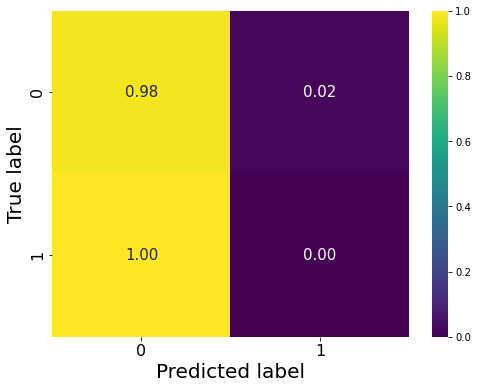

In [28]:
cm_test = confusion_matrix(y_test, best_estimator.predict(X_test), normalize='true')
mmh.plot_confusion_matrix(cm_test, [0, 1])